 # Projet de Machine Learning

Notebook <b>R</b> avec les codes utilisés pour le rapport final.<br>
Auteurs : Juan AYALA, Jeong Hwan KO, Alice LALOUE, Aldo MELLADO AGUILAR.<br>
4A MA - Groupes A et B<br>
2020 - 2021

<p>Lien <a href="https://github.com/jayalabanda/projet-ML">Github</a></p>
<p>Lien <a href="https://www.overleaf.com/read/mgsjtvzkhmyn">Overleaf</a></p>

# Importation des librairies

In [1]:
library(corrplot)
library(dplyr)
library(ggplot2)
library(RColorBrewer)
library(vcd)

corrplot 0.84 loaded


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: grid



In [2]:
# Cette cellule permet de centrer les figures automatiquement
IRdisplay::display_html('
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
')

# Obtenir les données

In [3]:
spotify_data <- read.table(file = "data/spotify-extr.txt", header = T, sep = " ")

# Description de l'ensemble du jeu de données

In [4]:
head(spotify_data)

,valence,year,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,pop.class
,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
161704,0.647,1975,0.4490,0.376,298840,0.827,7.88e-03,B,0.466,-7.604,1,25,0.3990,170.475,C
168077,0.150,2008,0.8990,0.508,236800,0.169,1.12e-05,Ab,0.136,-11.332,1,42,0.0553,107.477,B
35922,0.423,2007,0.0185,0.470,301093,0.878,8.39e-02,B,0.276,-5.576,0,65,0.0377,150.093,A
135823,0.302,1995,0.0384,0.176,142200,0.980,5.52e-01,B,0.237,-3.154,1,36,0.0721,172.566,C
165395,0.828,1994,0.5310,0.705,187800,0.625,7.73e-06,G,0.348,-11.963,0,38,0.0639,97.831,C
38184,0.489,2018,0.3710,0.856,324189,0.694,0.00e+00,D,0.109,-4.393,1,68,0.1690,122.080,A


In [5]:
str(spotify_data)

'data.frame':	10000 obs. of  15 variables:
 $ valence         : num  0.647 0.15 0.423 0.302 0.828 0.489 0.963 0.809 0.411 0.463 ...
 $ year            : int  1975 2008 2007 1995 1994 2018 2003 1992 1980 2001 ...
 $ acousticness    : num  0.449 0.899 0.0185 0.0384 0.531 0.371 0.523 0.00556 0.36 0.137 ...
 $ danceability    : num  0.376 0.508 0.47 0.176 0.705 0.856 0.819 0.737 0.602 0.453 ...
 $ duration        : int  298840 236800 301093 142200 187800 324189 178680 262800 312773 514867 ...
 $ energy          : num  0.827 0.169 0.878 0.98 0.625 0.694 0.615 0.89 0.732 0.562 ...
 $ instrumentalness: num  7.88e-03 1.12e-05 8.39e-02 5.52e-01 7.73e-06 0.00 1.48e-06 1.71e-03 3.14e-04 2.90e-03 ...
 $ key             : chr  "B" "Ab" "B" "B" ...
 $ liveness        : num  0.466 0.136 0.276 0.237 0.348 0.109 0.0794 0.0801 0.0755 0.0463 ...
 $ loudness        : num  -7.6 -11.33 -5.58 -3.15 -11.96 ...
 $ mode            : int  1 1 0 1 0 1 1 1 1 0 ...
 $ popularity      : int  25 42 65 36 38 68 47 59 

On n'a pas de valeurs manquantes donc on n'a pas besoin de les retravailler.

Les variables explicatives sont :
* `valence` : la positivité de la chanson, vaut 1 si la chanson est très joyeuse, 0 sinon ;
* `year` : année de sortie ;
* `acousticness` : mesure "l'acousticité" de la chanson ;
* `danceability` : mesure la "dançabilite" d'une chanson ;
* `duration` : durée d'une chanson en millisecondes ;
* `energy` : l'énergie de la chanson, vaut 1 si la chanson est très énergétique, 0 sinon ;
* `intrumentalness` : taux d'instrumentalisation, vaut 1 s'il n'y a aucune voix présente dans la chanson, 0 sinon ; 
* `key` : tonalité de la musique (ex : A=la), ne prend pas en compte la distinction majeur/mineur ;
* `liveness` : taux de prestation en live, vaut 1 si la chanson ne comporte que de la musique (sans sons à intérêts non-musicaux), 0 sinon ;
* `loudness` : intensité sonore de la chanson
* `mode` : variable binaire qui indique si la chanson commence par une progression d'accords majeure (1) ou non (0)
* `speechiness` : taux de vocaux dans la chanson, vaut 1 si la chanson comporte de la voix tout le long, 0 sinon ;
* `tempo` :  tempo de la chanson en beats par minute (bpm)

Notre objectif consiste à prédire la valeur de `pop.class` et de `popularity`, c'est-à-dire la popularité d'une chanson, soit comme un entier entre 0 et 100, soit comme une classe $A$, $B$, $C$ ou $D$.

In [6]:
summary(spotify_data)

    valence            year       acousticness      danceability  
 Min.   :0.0000   Min.   :1921   Min.   :0.00000   Min.   :0.000  
 1st Qu.:0.3240   1st Qu.:1956   1st Qu.:0.09267   1st Qu.:0.417  
 Median :0.5430   Median :1978   Median :0.50400   Median :0.550  
 Mean   :0.5328   Mean   :1977   Mean   :0.49572   Mean   :0.540  
 3rd Qu.:0.7510   3rd Qu.:1999   3rd Qu.:0.88925   3rd Qu.:0.671  
 Max.   :0.9930   Max.   :2020   Max.   :0.99600   Max.   :0.988  
    duration           energy       instrumentalness       key           
 Min.   :   5991   Min.   :0.0000   Min.   :0.000000   Length:10000      
 1st Qu.: 169067   1st Qu.:0.2620   1st Qu.:0.000000   Class :character  
 Median : 206530   Median :0.4760   Median :0.000174   Mode  :character  
 Mean   : 227215   Mean   :0.4875   Mean   :0.164947                     
 3rd Qu.: 259733   3rd Qu.:0.7080   3rd Qu.:0.087100                     
 Max.   :2703227   Max.   :1.0000   Max.   :1.000000                     
    liveness 

Dans notre jeu de données, les variables qualitatives sont :
* `pop.class`,
* `key`,
* `mode`.

Le reste des variables sont quantitatives.

On transforme les variables qualitatives en catégories pour mieux traiter les données.

In [7]:
spotify_data$pop.class <- factor(spotify_data$pop.class, ordered = TRUE)
spotify_data$key <- factor(spotify_data$key)
spotify_data$mode <- factor(spotify_data$mode)

In [8]:
pop.class <- spotify_data$pop.class
key <- spotify_data$key
mode <- spotify_data$mode

In [9]:
rev(levels(pop.class))
levels(key)
levels(mode)

[1] "D" "C" "B" "A"

[1] "A"  "Ab" "B"  "Bb" "C"  "D"  "Db" "E"  "Eb" "F"  "G"  "Gb"

[1] "0" "1"

In [10]:
sapply(spotify_data, class)

$valence
[1] "numeric"

$year
[1] "integer"

$acousticness
[1] "numeric"

$danceability
[1] "numeric"

$duration
[1] "integer"

$energy
[1] "numeric"

$instrumentalness
[1] "numeric"

$key
[1] "factor"

$liveness
[1] "numeric"

$loudness
[1] "numeric"

$mode
[1] "factor"

$popularity
[1] "integer"

$speechiness
[1] "numeric"

$tempo
[1] "numeric"

$pop.class
[1] "ordered" "factor"

# Analyses uni et multidimensionnelles

## Variables qualitatives

On commence par analyser les variables qualitatives `pop.class`, `key` et `mode`.

In [11]:
data.qual <- spotify_data[, c("key", "mode", "pop.class")]
head(data.qual)

,key,mode,pop.class
,<fct>,<fct>,<ord>
161704,B,1,C
168077,Ab,1,B
35922,B,0,A
135823,B,1,C
165395,G,0,C
38184,D,1,A


<b>Classe de popularité</b> (variable à prédire)

Cette variable a été créée en amont de l'obtention des données.

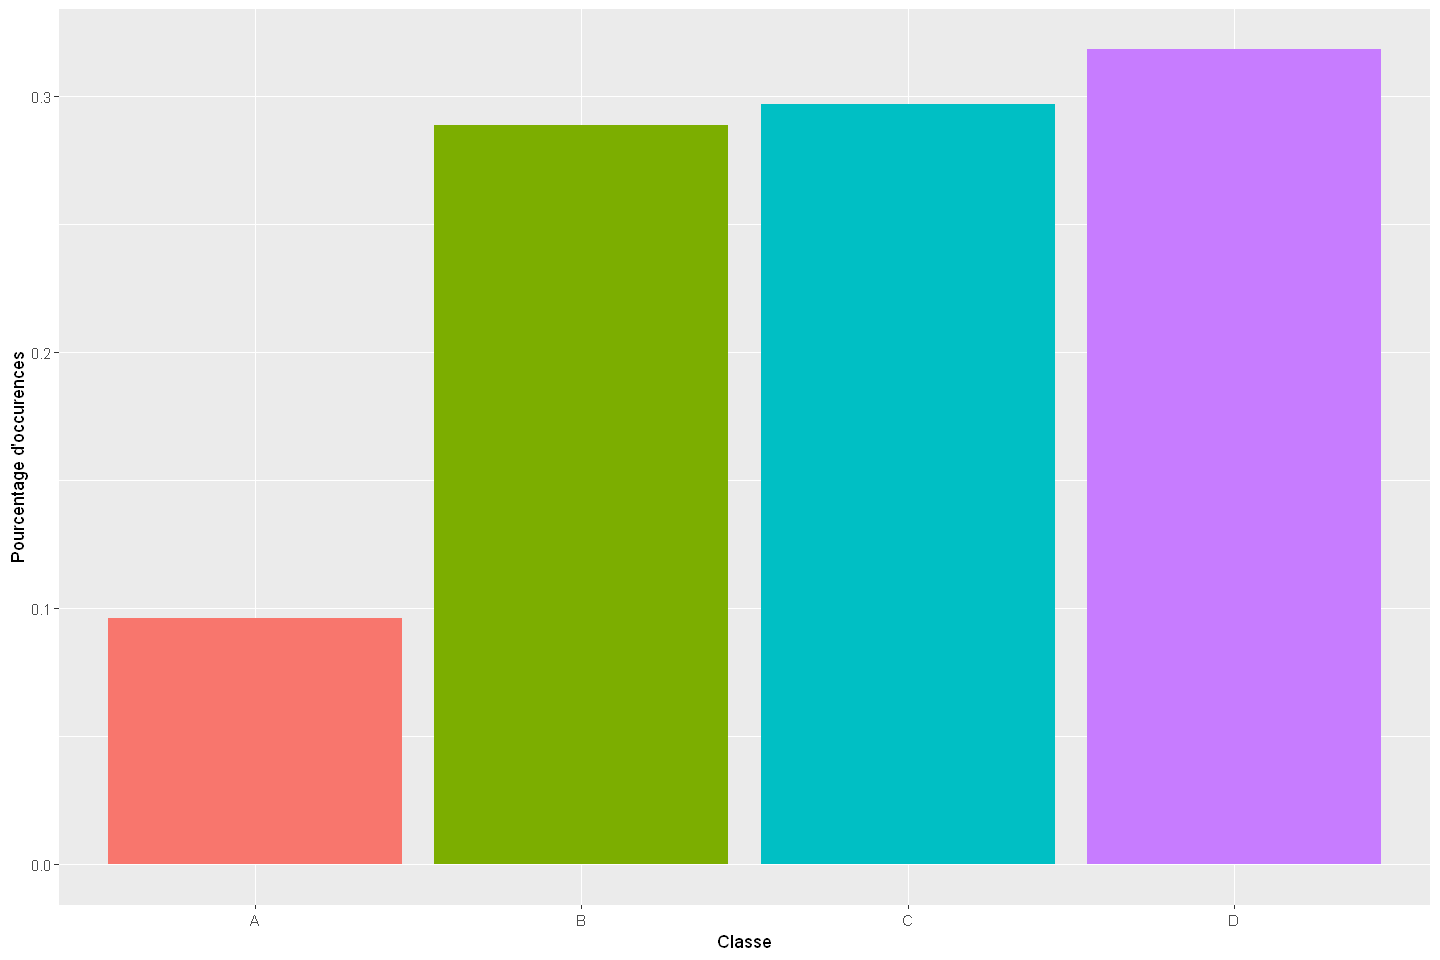

In [12]:
percentage <- as.data.frame(table(pop.class))
percentage$Freq <- percentage$Freq/sum(percentage$Freq)

pop.class.count <- data.frame(name = levels(pop.class), value = percentage$Freq)

options(repr.plot.width = 12, repr.plot.height = 8)

ggplot(data = pop.class.count, aes(x = name, y = value, fill = name)) +
    geom_bar(stat = "identity", show.legend = FALSE) +
    labs(x = "Classe", y = "Pourcentage d'occurences")

On voit qu'il y a une distribution uniforme des chansons par classe, sauf pour la classe `A`, qui comprend moins de 10% des chansons. Ceci risque de poser problème dans la suite en termes de prédiction.

<b>Clé</b>

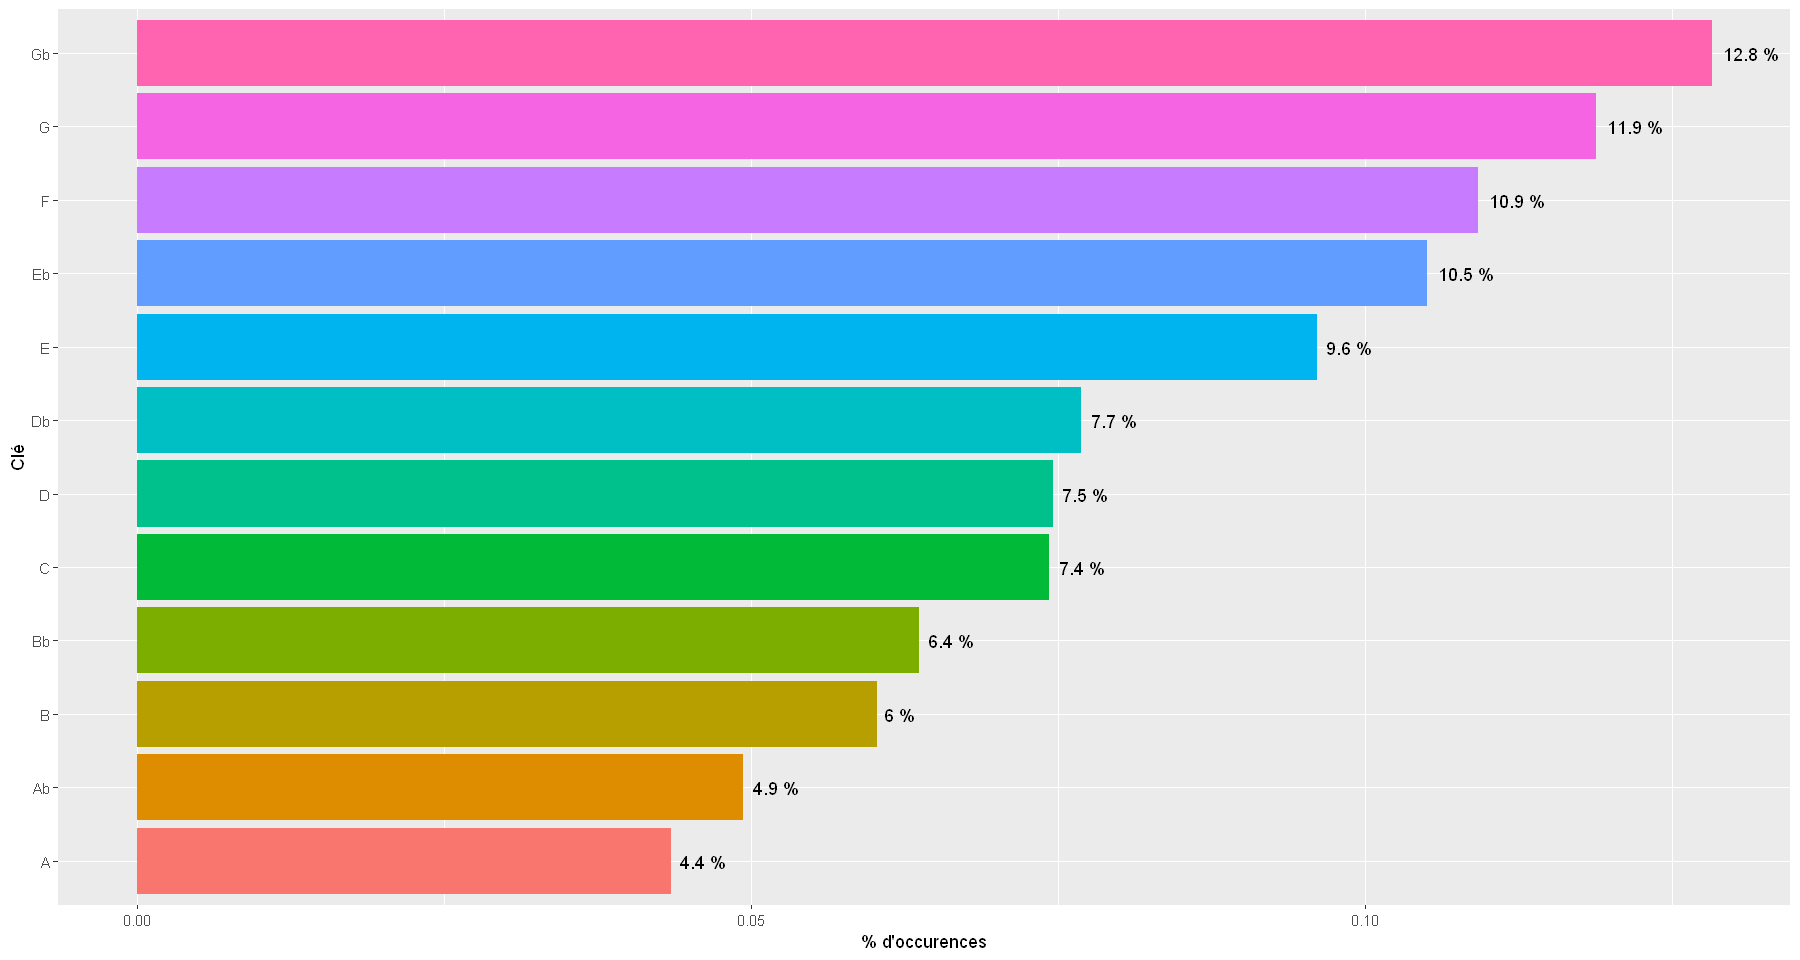

In [13]:
percentage <- as.data.frame(table(key))
percentage$Freq <- sort(percentage$Freq/sum(percentage$Freq), decreasing = F)

key.count <- data.frame(name = levels(key), value = percentage$Freq)

options(repr.plot.width = 15, repr.plot.height = 8)

ggplot(data = key.count, aes(x = name, y = value, fill = name)) +
    geom_bar(stat = "identity", show.legend = FALSE) +
    labs(x = "Clé", y = "% d'occurences") +
    geom_text(aes(label = paste(round(value, 3) * 100, "%"), hjust = -0.2)) +
    coord_flip()

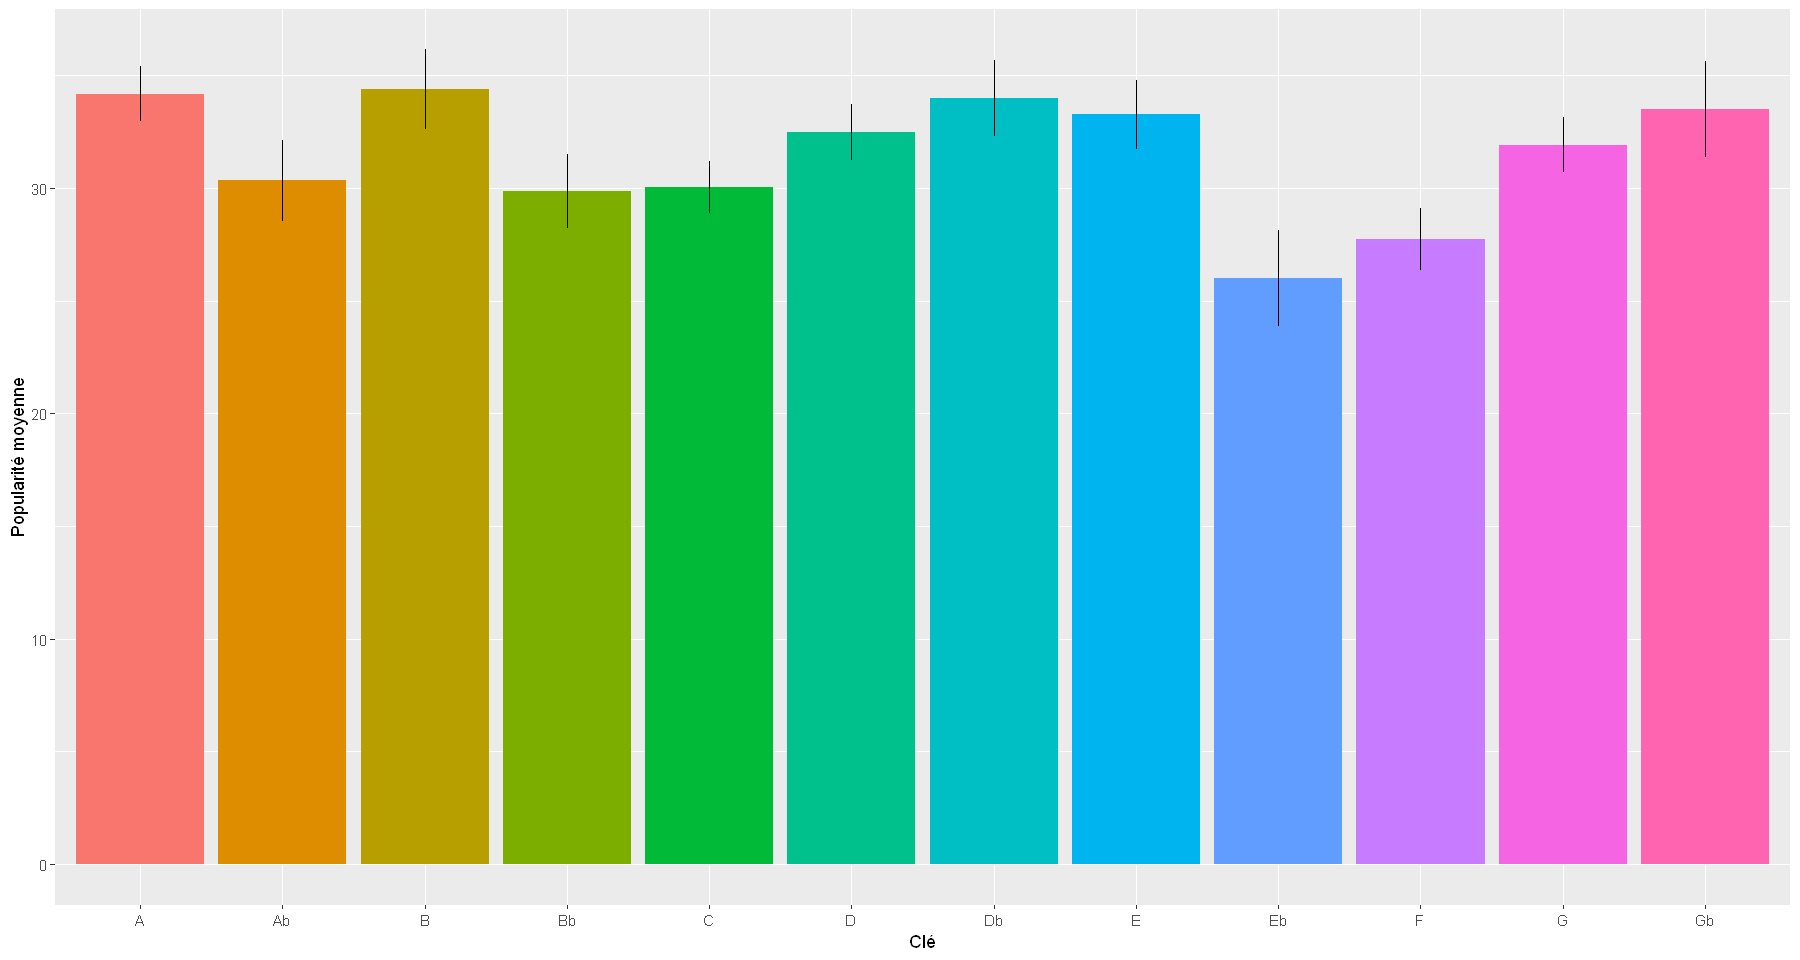

In [14]:
plotdata <- spotify_data %>%
    group_by(key) %>%
    summarize(n = n(), mean = mean(popularity), sd = sd(popularity)) %>%
    mutate(se = sd/sqrt(n)) %>%
    mutate(ic = se * qt((1 - 0.05)/2 + 0.5, n - 1))

ggplot(plotdata, aes(x = key, y = mean, fill = key)) +
    geom_bar(stat = "identity", show.legend = FALSE) +
    geom_linerange(aes(x = key, ymin = mean - ic, ymax = mean + ic)) +
    labs(x = "Clé", y = "Popularité moyenne")

Les variances de la popularité dans chacune des valeurs de `key` est petite donc nous n'avons pas besoin de transformer ces données.

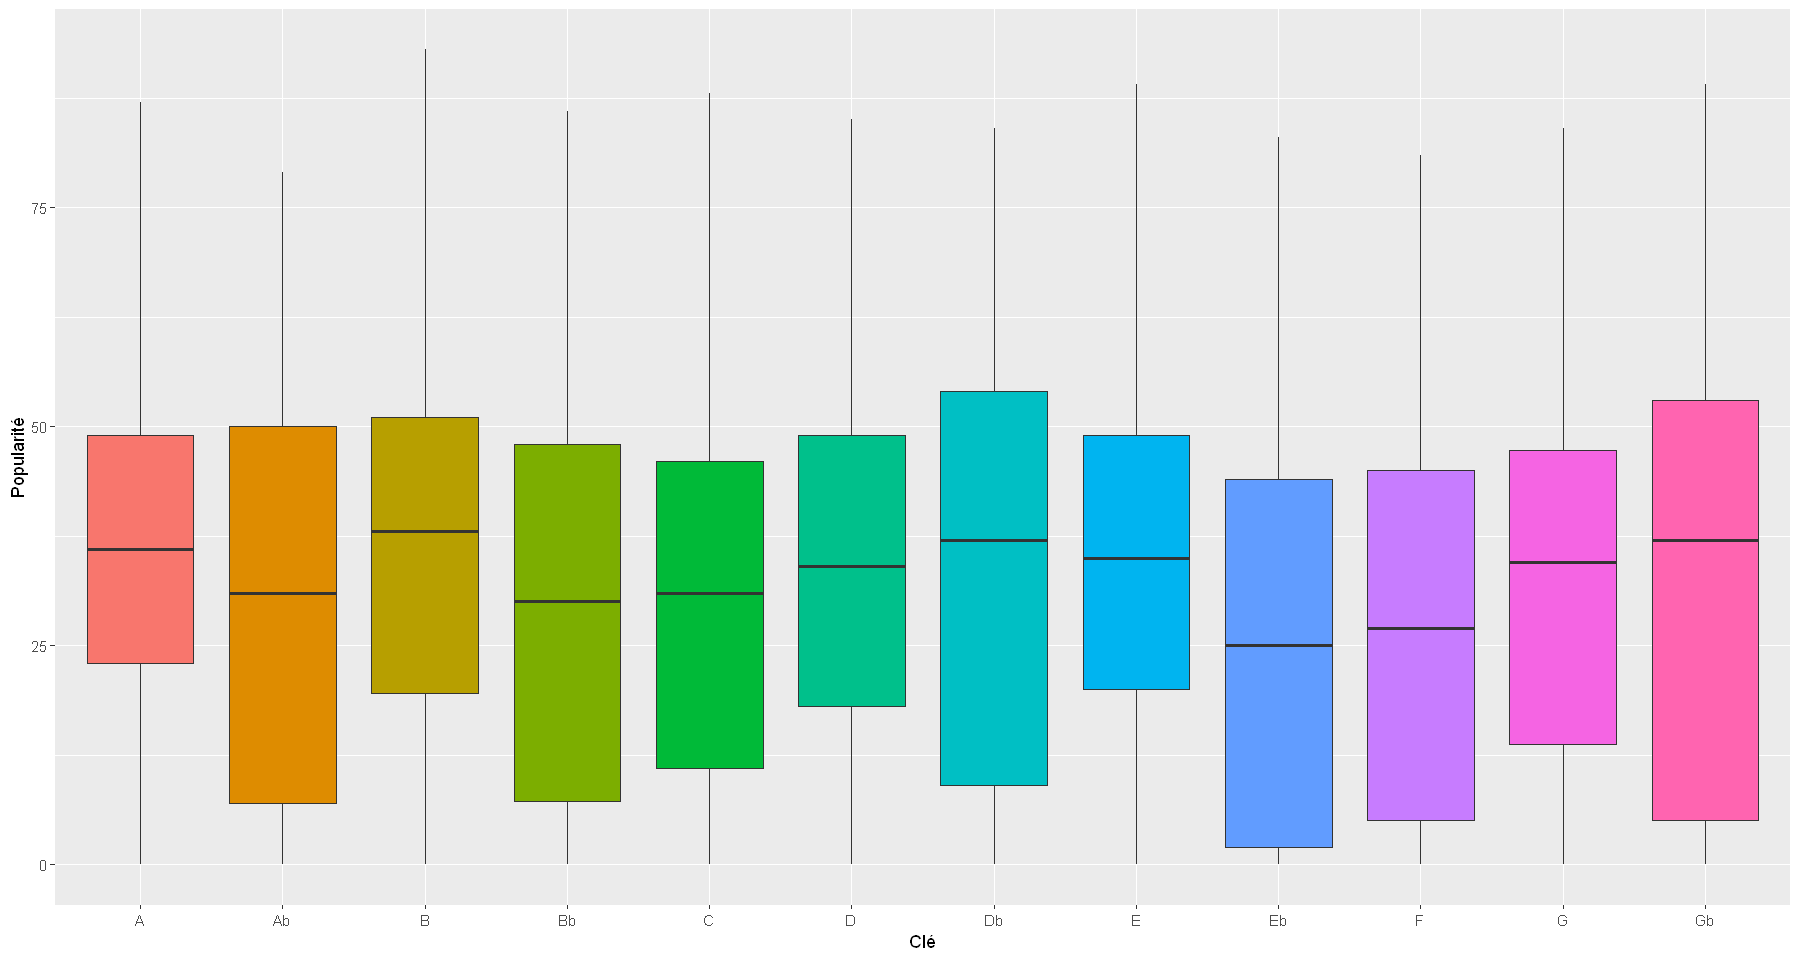

In [15]:
ggplot(data = spotify_data, aes(x = key, y = popularity, fill = key)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = "Clé", y = "Popularité")

De la même façon, la distribution de la popularité reste plutôt uniforme par clé : les boîtes ont une taille similaire et la médiane est au même niveau.

<b>Mode</b>

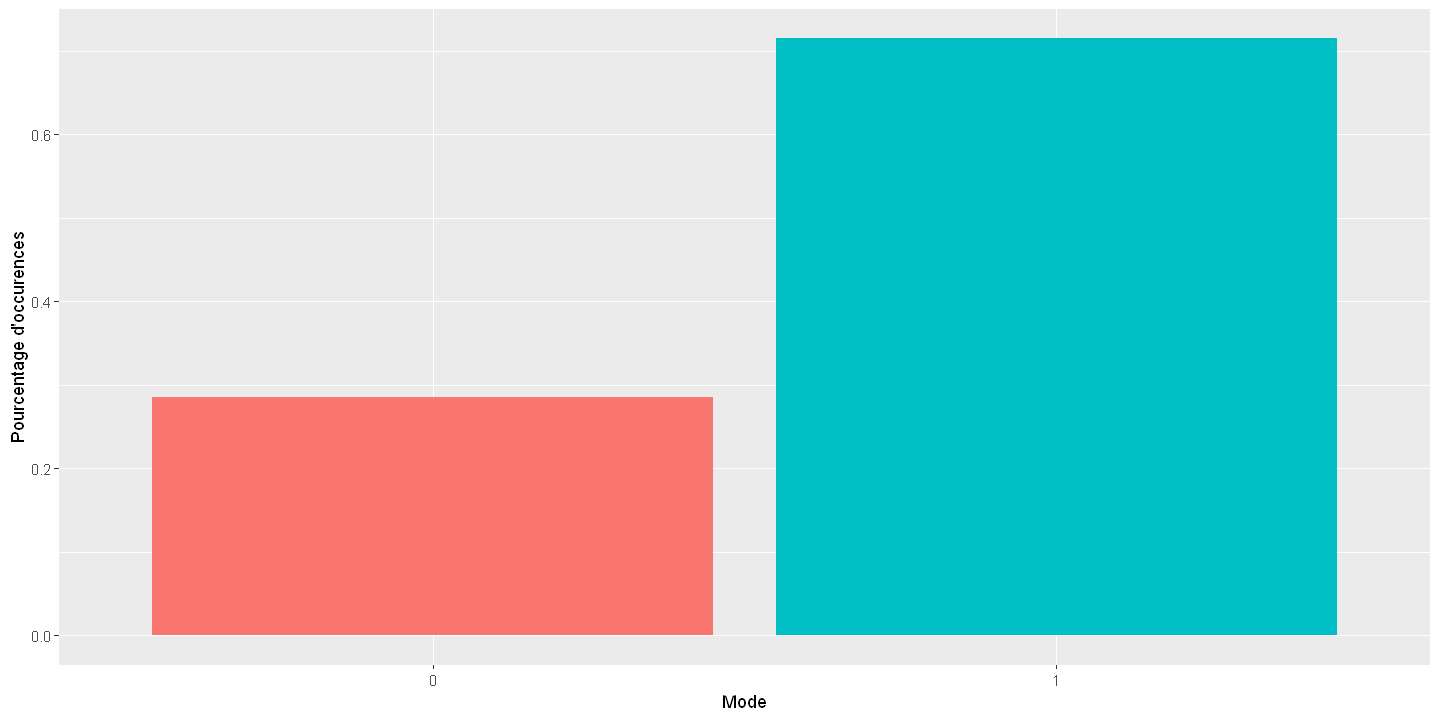

In [16]:
percentage <- as.data.frame(table(mode))
percentage$Freq <- percentage$Freq/sum(percentage$Freq)

mode.count <- data.frame(name = levels(mode), value = percentage$Freq)

options(repr.plot.width = 12, repr.plot.height = 6)

ggplot(data = mode.count, aes(x = name, y = value, fill = name)) +
    geom_bar(stat = "identity", show.legend = FALSE) +
    labs(x = "Mode", y = "Pourcentage d'occurences")

La distribution de la variable `mode` est inégale : il y a 30% et 70% des chansons avec `mode` = 0 et `mode` = 1 respectivement.

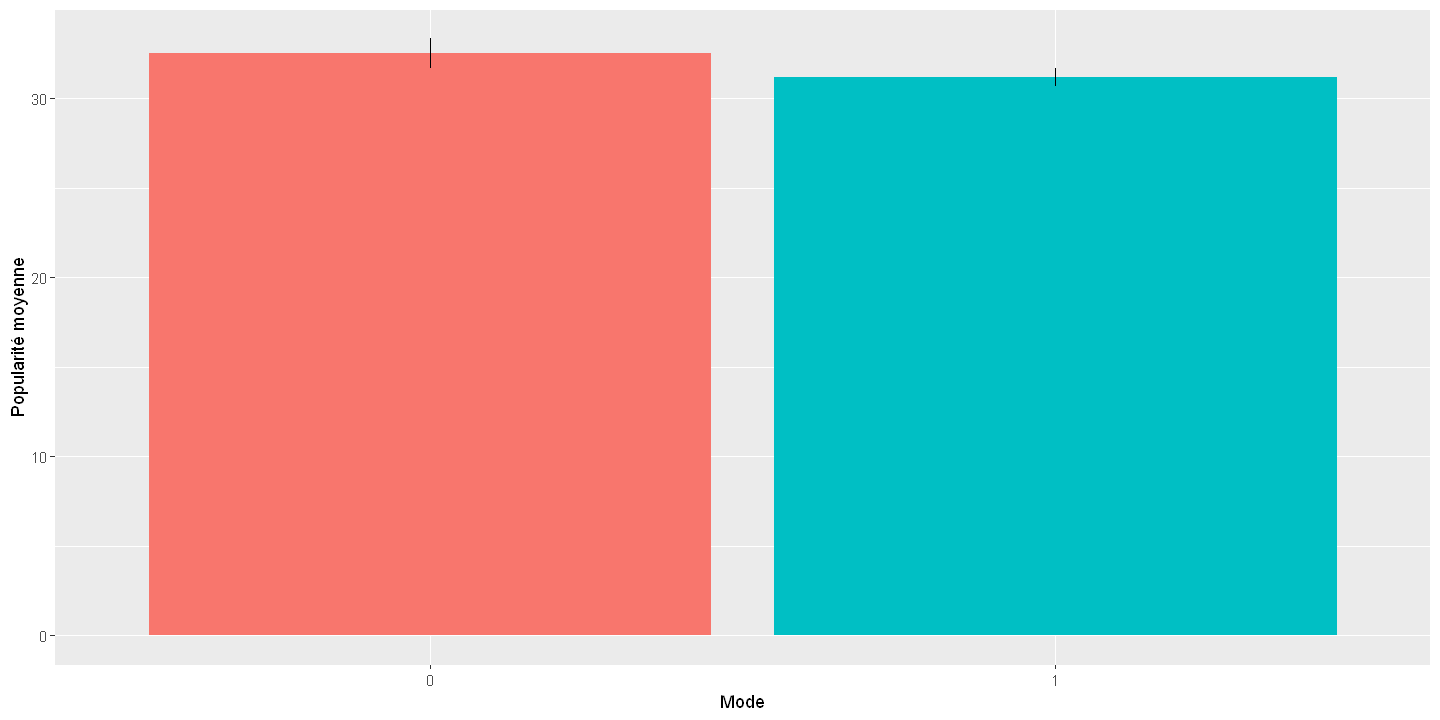

In [17]:
plotdata <- spotify_data %>%
    group_by(mode) %>%
    summarize(n = n(), mean = mean(popularity), sd = sd(popularity)) %>%
    mutate(se = sd/sqrt(n)) %>%
    mutate(ic = se * qt((1 - 0.05)/2 + 0.5, n - 1))

ggplot(plotdata, aes(x = mode, y = mean, fill = mode)) +
    geom_bar(stat = "identity", show.legend = FALSE) +
    geom_linerange(aes(x = mode, ymin = mean - ic, ymax = mean + ic)) +
    labs(x = "Mode", y = "Popularité moyenne")

Par contre, la popularité est similaire selon le mode.

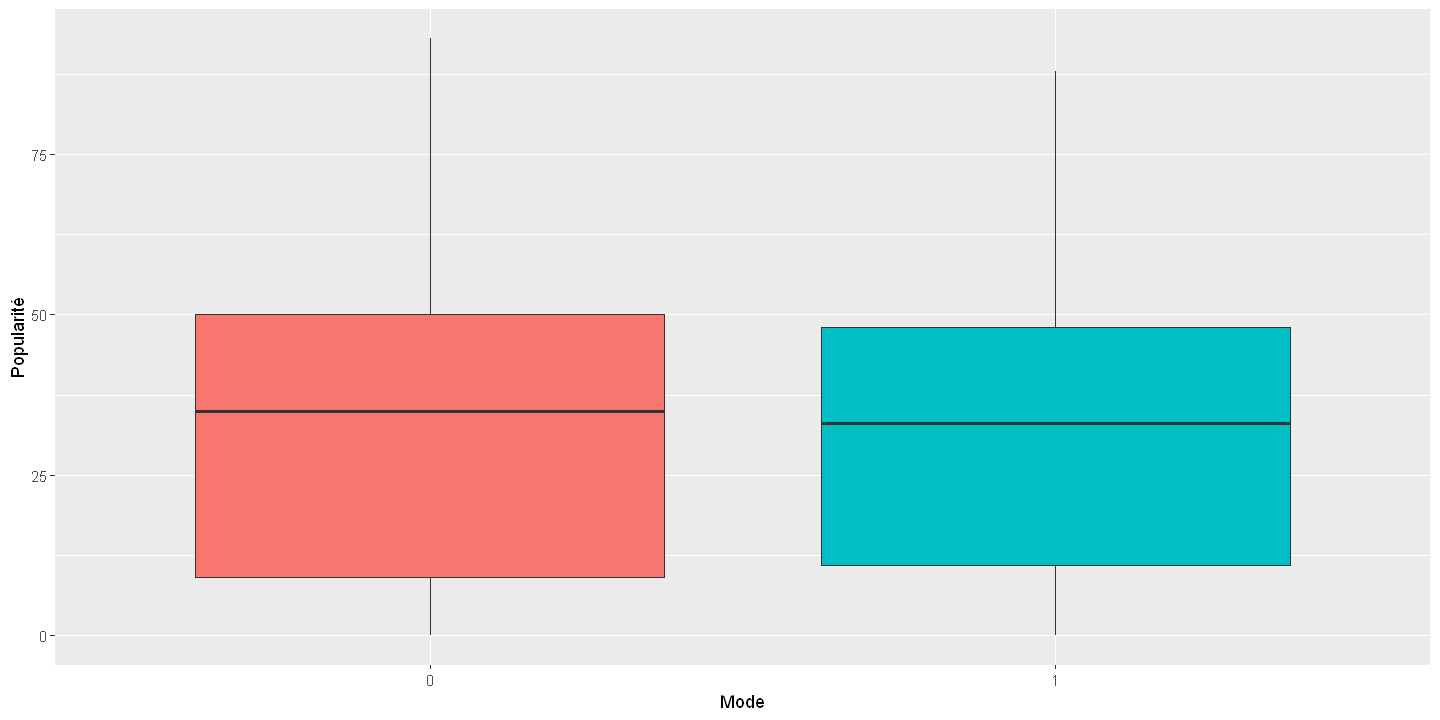

In [18]:
ggplot(data = spotify_data, aes(x = mode, y = popularity, fill = mode)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = "Mode", y = "Popularité")

On regroupe toutes les variables qualitatives en un barplot :

`summarise()` has grouped output by 'key'. You can override using the `.groups` argument.



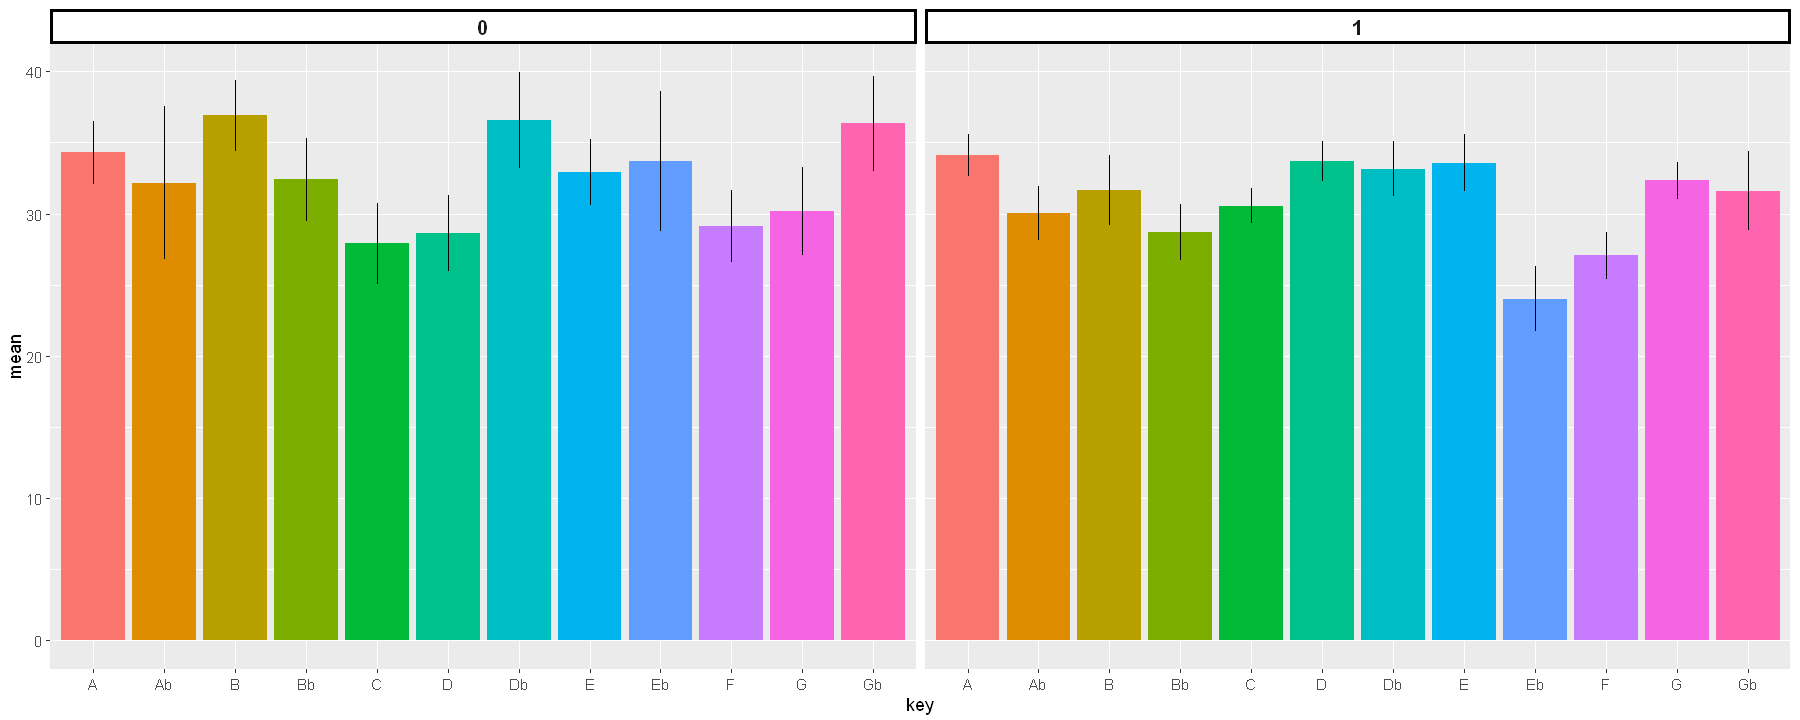

In [19]:
plotdata <- spotify_data %>%
    group_by(key, mode) %>%
    summarize(n = n(), mean = mean(popularity), sd = sd(popularity)) %>%
    mutate(se = sd/sqrt(n)) %>%
    mutate(ic = se * qt((1 - 0.05)/2 + 0.5, n - 1))

options(repr.plot.width = 15, repr.plot.height = 6)

ggplot(data = plotdata, aes(x = key, y = mean, fill = key)) +
    geom_bar(position="dodge", stat="identity", show.legend = FALSE) +
    geom_linerange(aes(x = key, ymin = mean - ic, ymax = mean + ic)) +
    facet_wrap(~mode) +
    theme(strip.background = element_rect(colour="black", fill="white",
                                          size=1.5, linetype="solid"),
          strip.text.x = element_text(size=12, face="bold"))

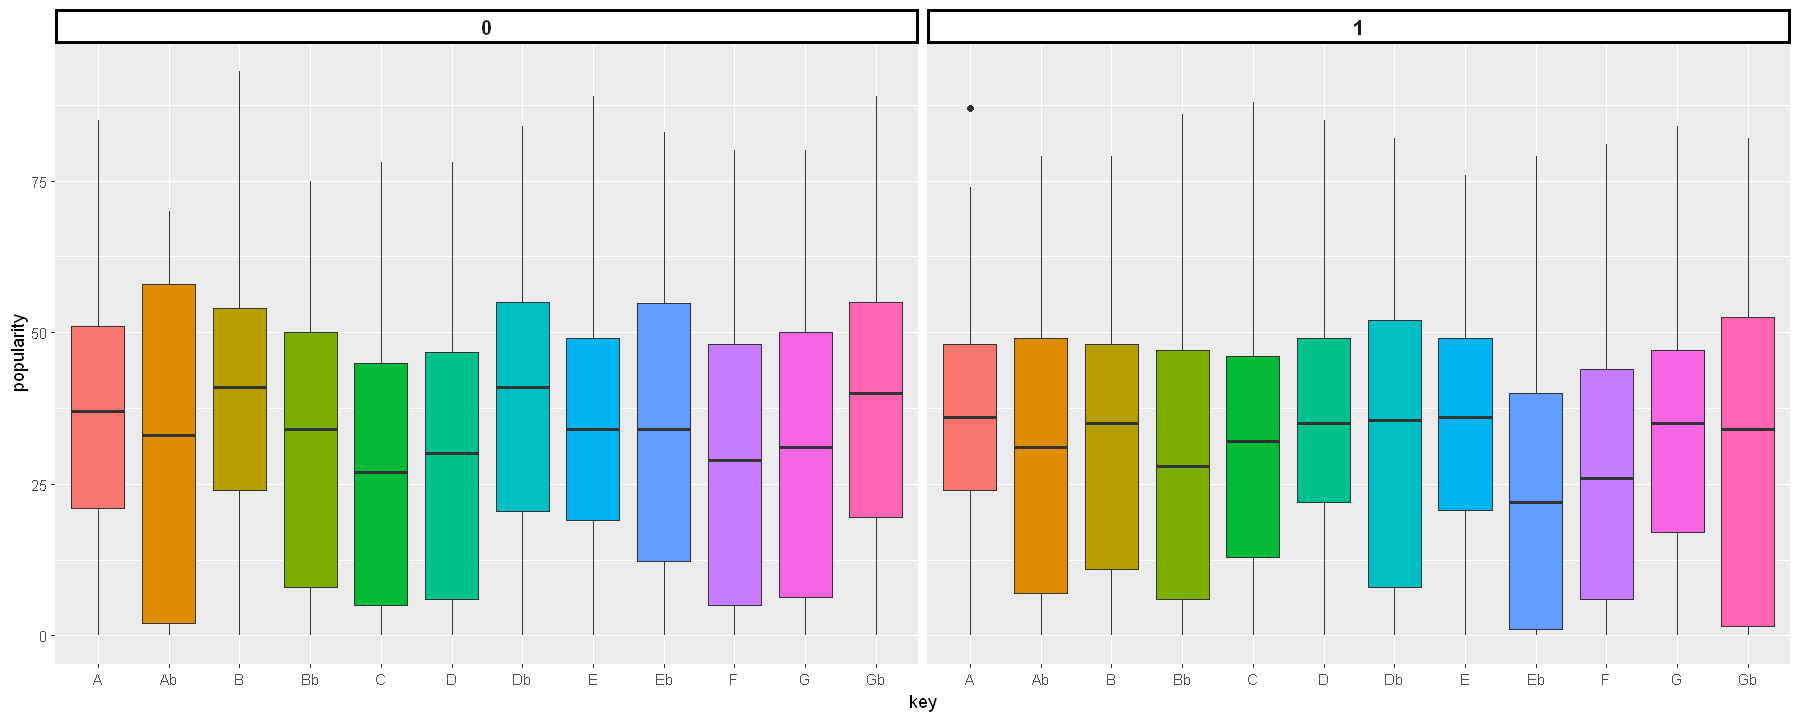

In [20]:
options(repr.plot.width = 15, repr.plot.height = 6)

ggplot(data = spotify_data, aes(x = key, y = popularity, fill = key)) +
    geom_boxplot(show.legend = FALSE) +
    facet_wrap(~mode) +
    theme(strip.background = element_rect(colour="black", fill="white",
                                          size=1.5, linetype="solid"),
          strip.text.x = element_text(size=12, face="bold"))

## Variables quantitatives

On commence par visualiser la corrélation entre les variables quantitatives :

In [21]:
data.quant <- spotify_data[, -c(8, 11, 15)]
colnames(data.quant)

[1] "valence"          "year"             "acousticness"     "danceability"    
 [5] "duration"         "energy"           "instrumentalness" "liveness"        
 [9] "loudness"         "popularity"       "speechiness"      "tempo"

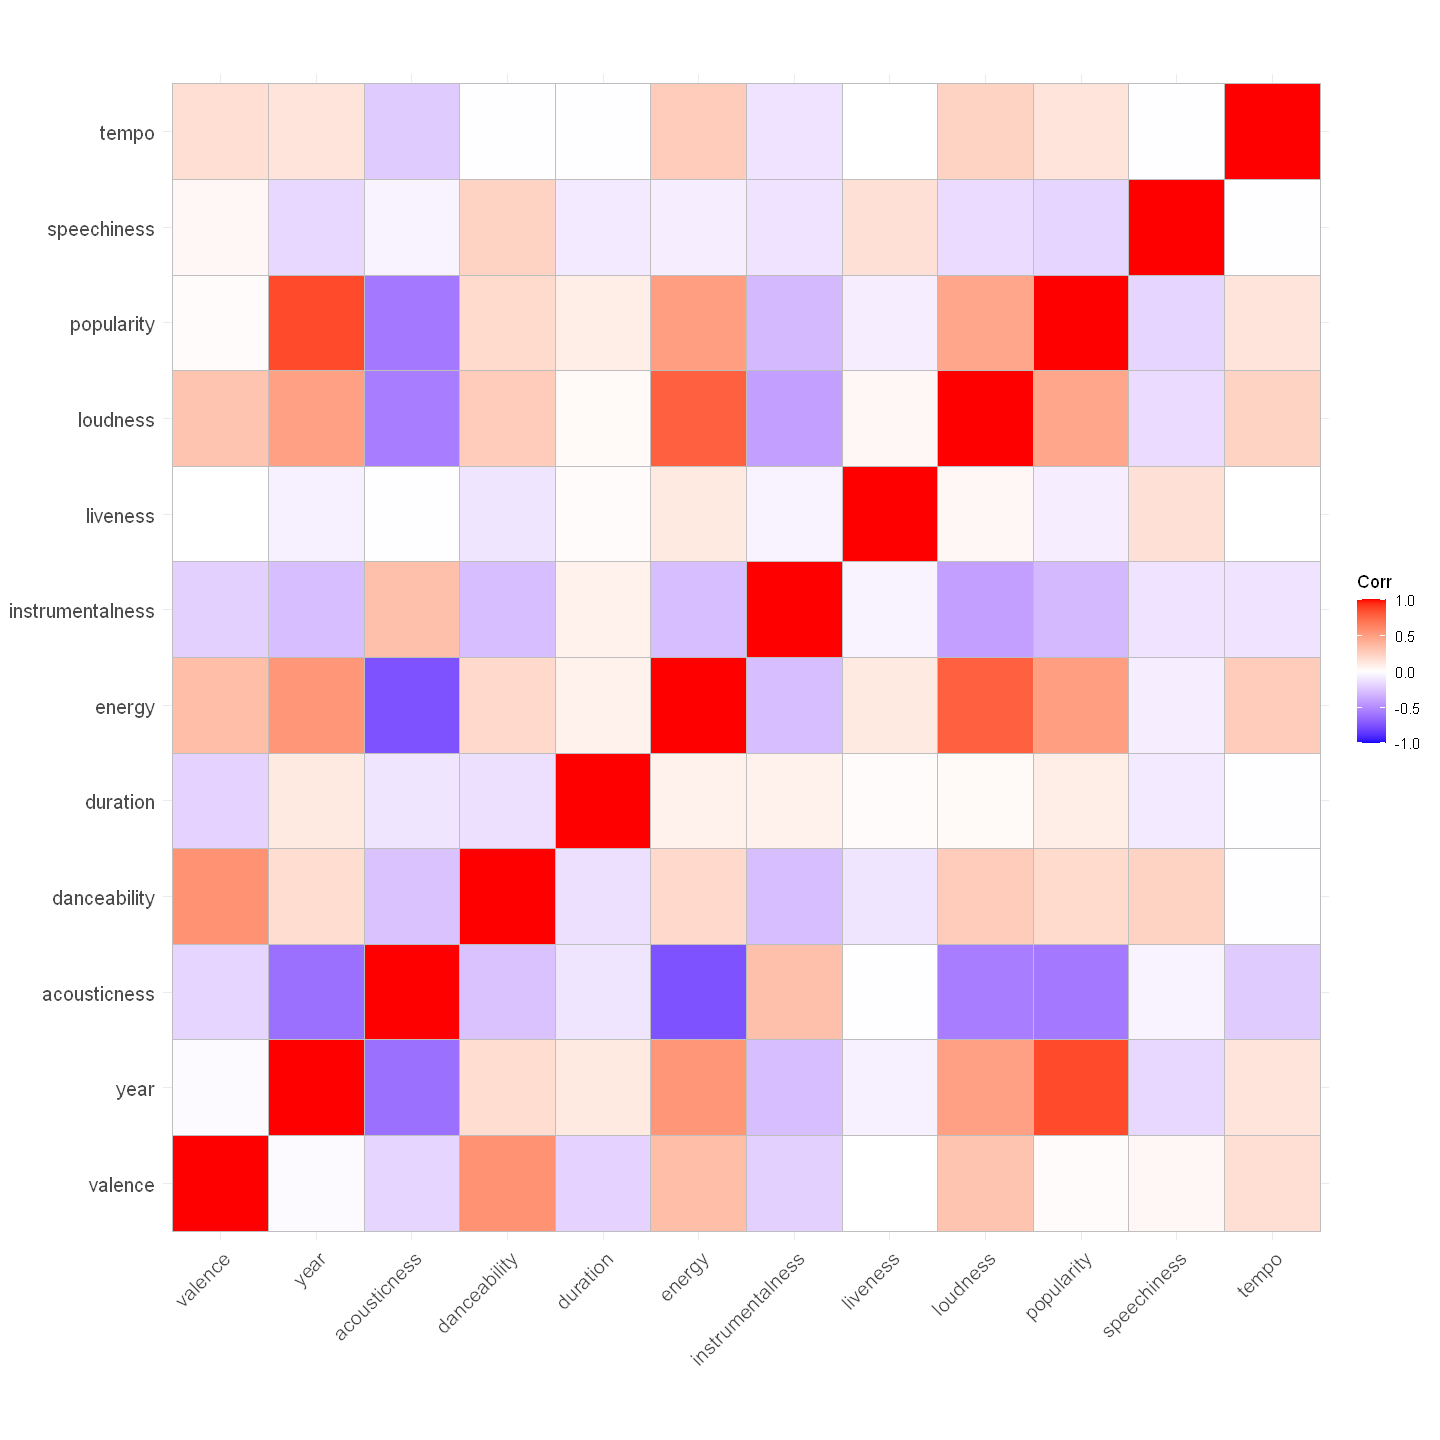

In [22]:
library(ggcorrplot)

options(repr.plot.width = 12, repr.plot.height = 12)

M <- cor(data.quant)
ggcorrplot(M)

Ce graphique nous montre qu'il y a certaines variables qui ont une forte corrélation. Par exemple, il y a une forte corrélation négative entre les variables `energy` et `acousticness`. Cela a du sens vu que les chansons acoustiques sont plus tranquilles (moins énergiques) que celles qui ne sont pas acoustiques. De même, `energy` et `loudness` sont positivement corrélées, ce qui est attendu vu que les chansons bruyantes ont souvent plus d'énergie.
<br>
On voit aussi que plus une chanson est acoustique, moins elle est populaire, vu que les variables `acousticness` et `popularity` ont une forte corrélation négative.

In [23]:
correlation <- sort(abs(M[, 10]), decreasing = T)
series <- as.data.frame(correlation)

print("Les variables les plus corrélées avec 'popularity' sont :")
for (row in rownames(series)) {
    if (series[row, 1] >= 0.2 && series[row, 1] < 1) {
        print(paste(row, round(series[row, 1], 2), "(abs)"))
    }
}

[1] "Les variables les plus corrélées avec 'popularity' sont :"
[1] "year 0.86 (abs)"
[1] "acousticness 0.58 (abs)"
[1] "energy 0.5 (abs)"
[1] "loudness 0.46 (abs)"
[1] "instrumentalness 0.3 (abs)"


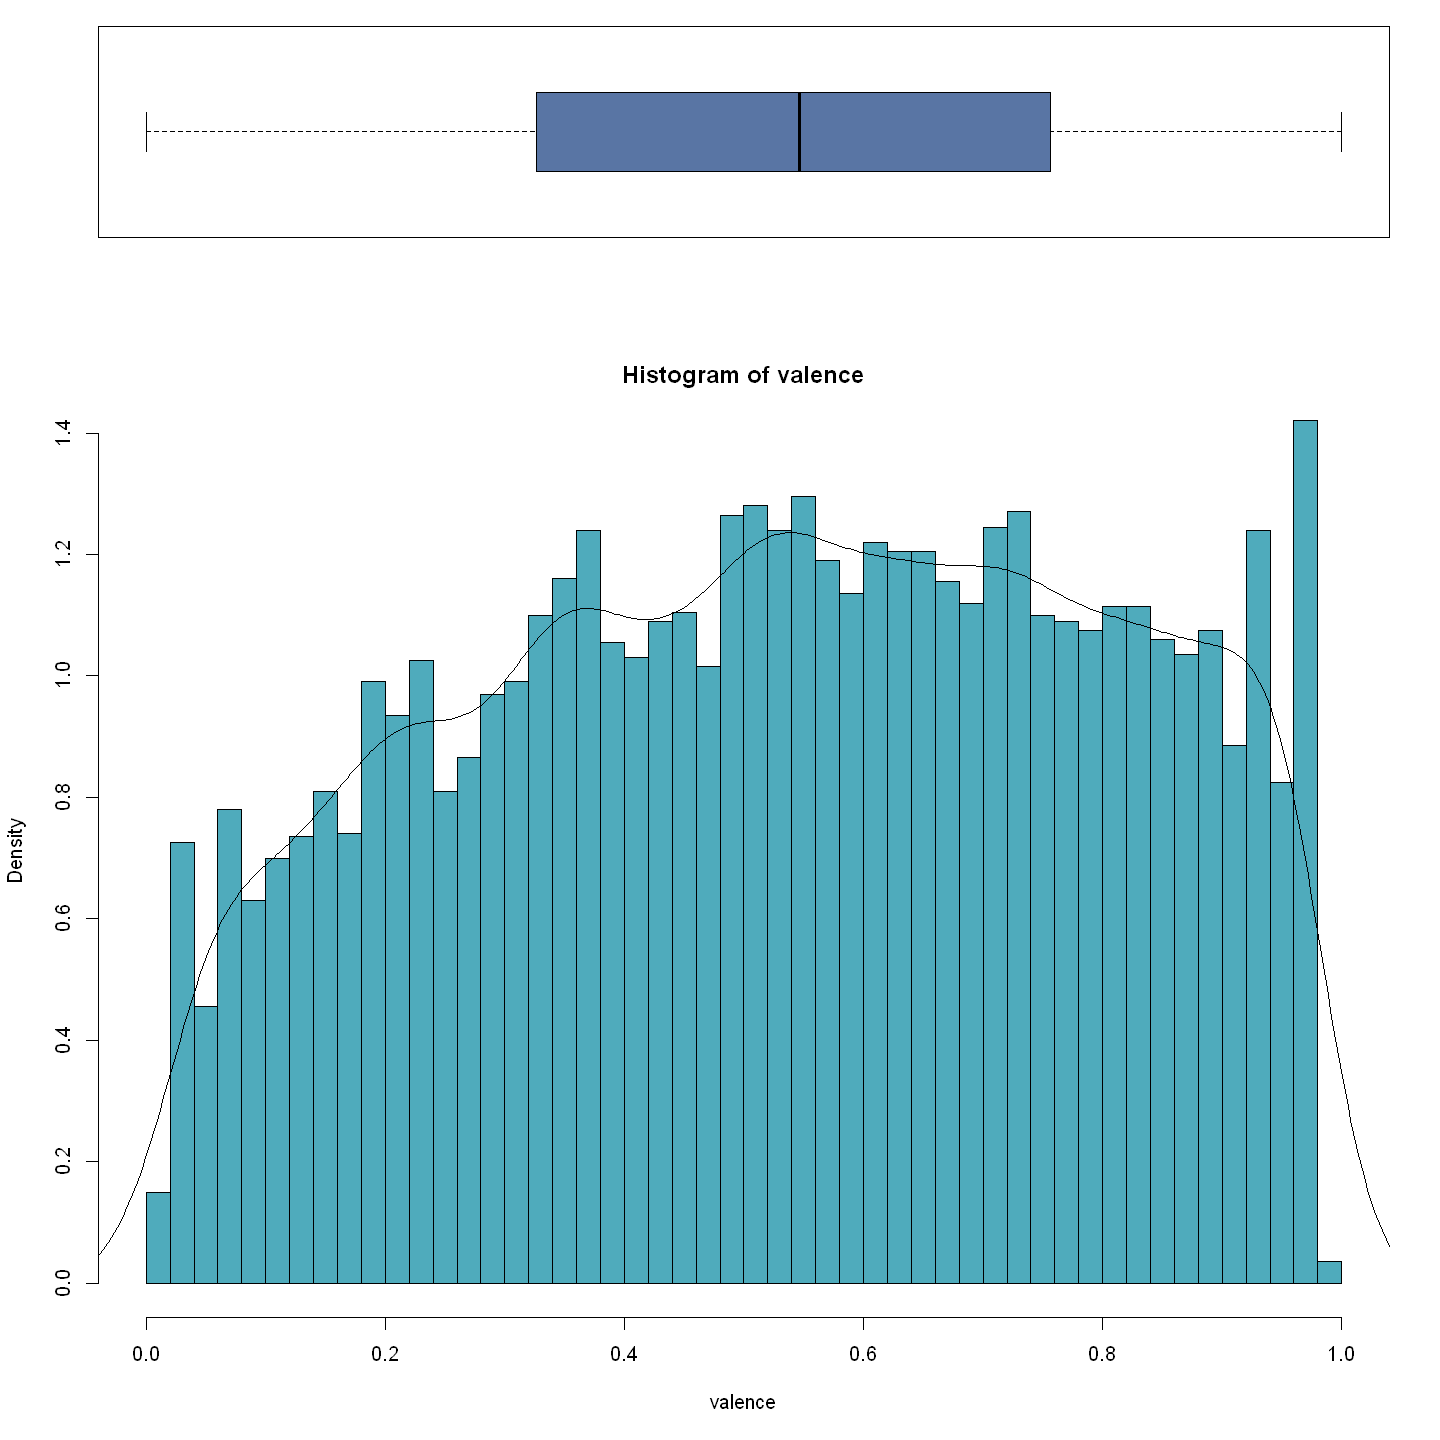

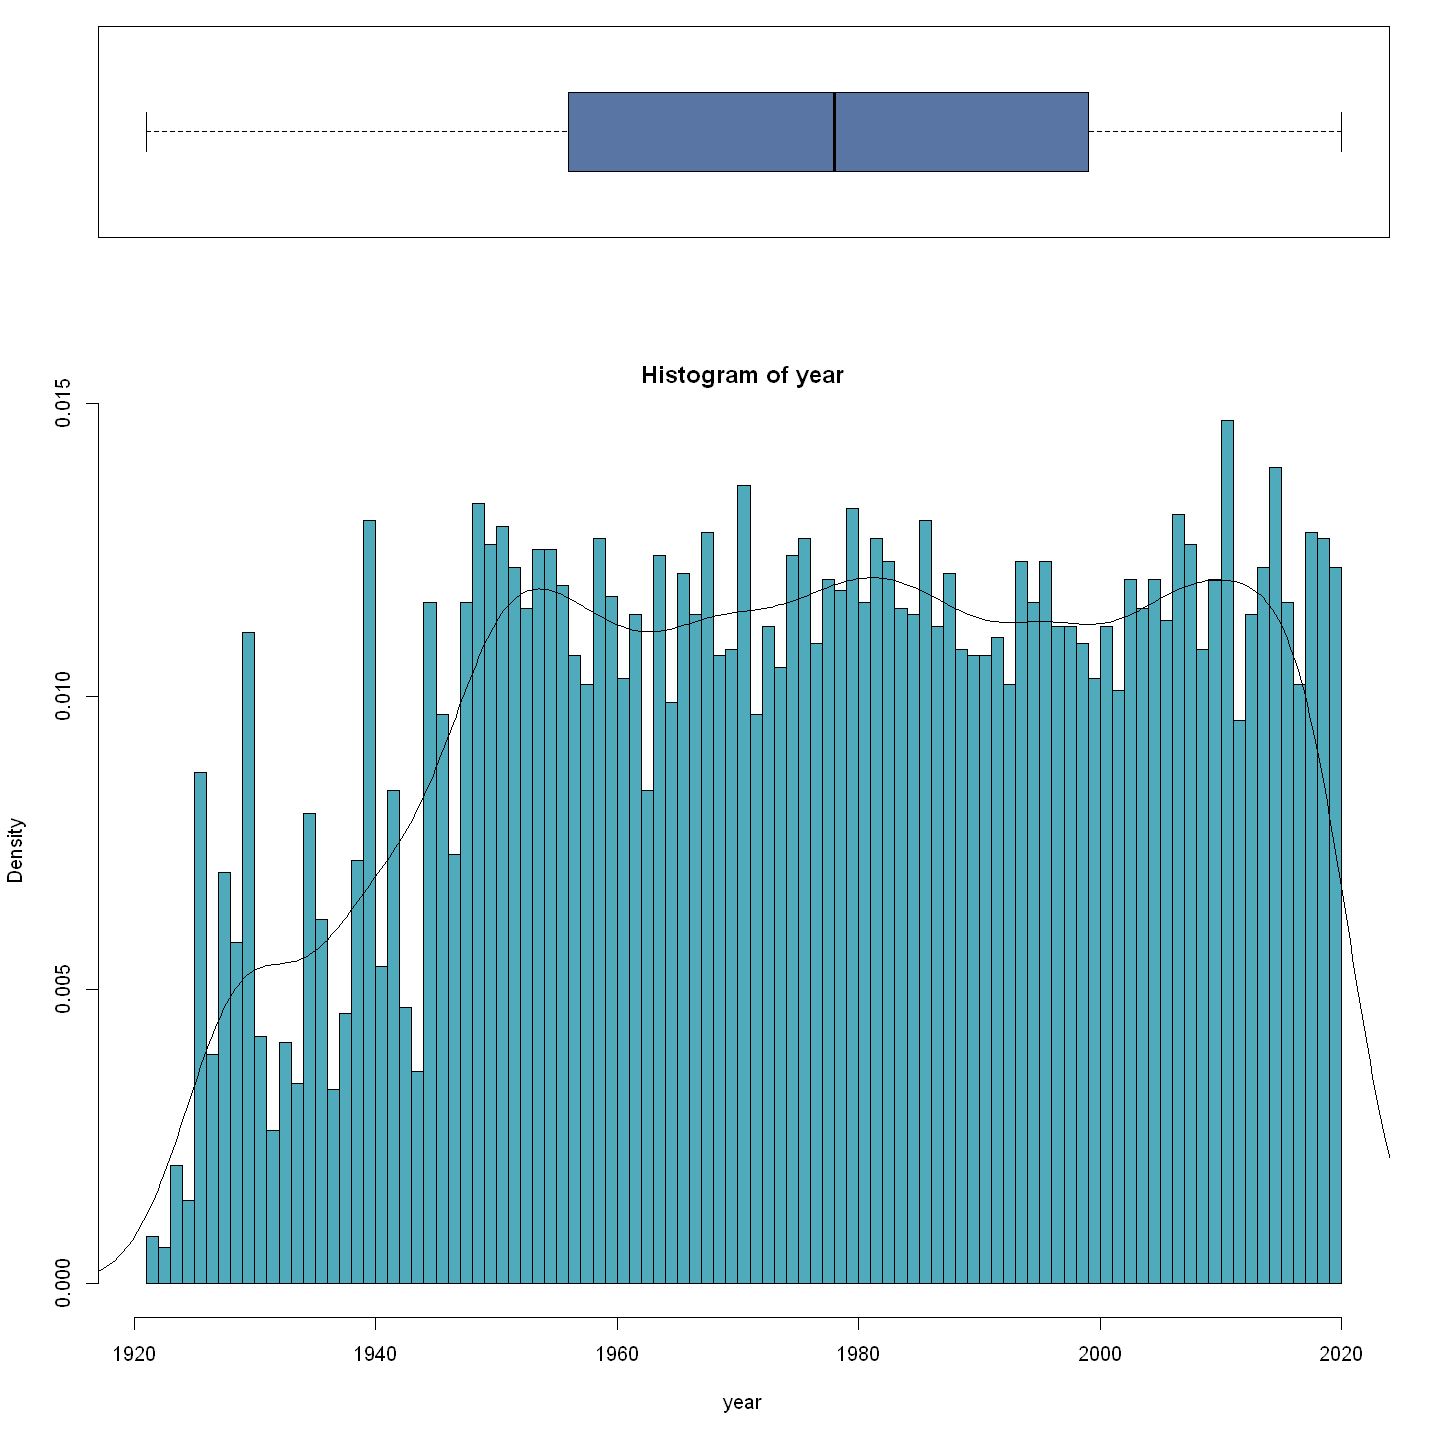

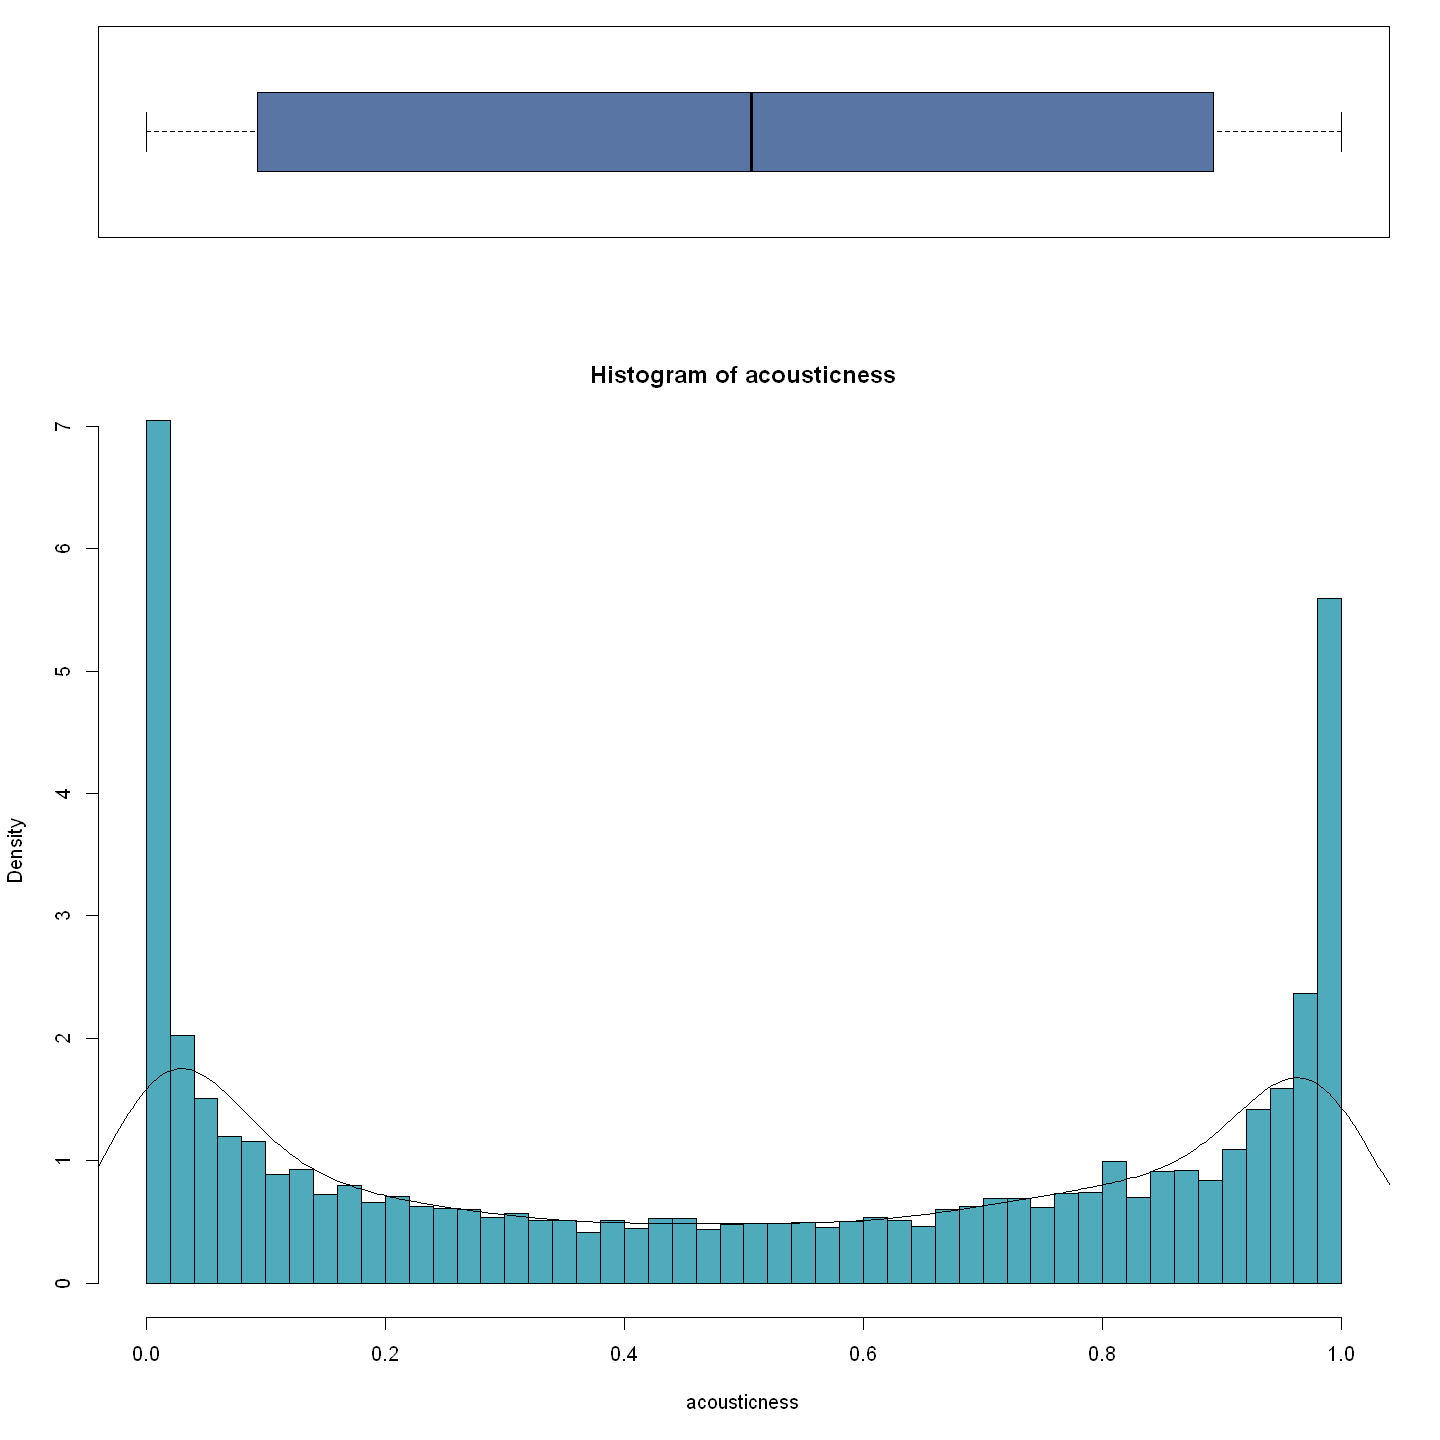

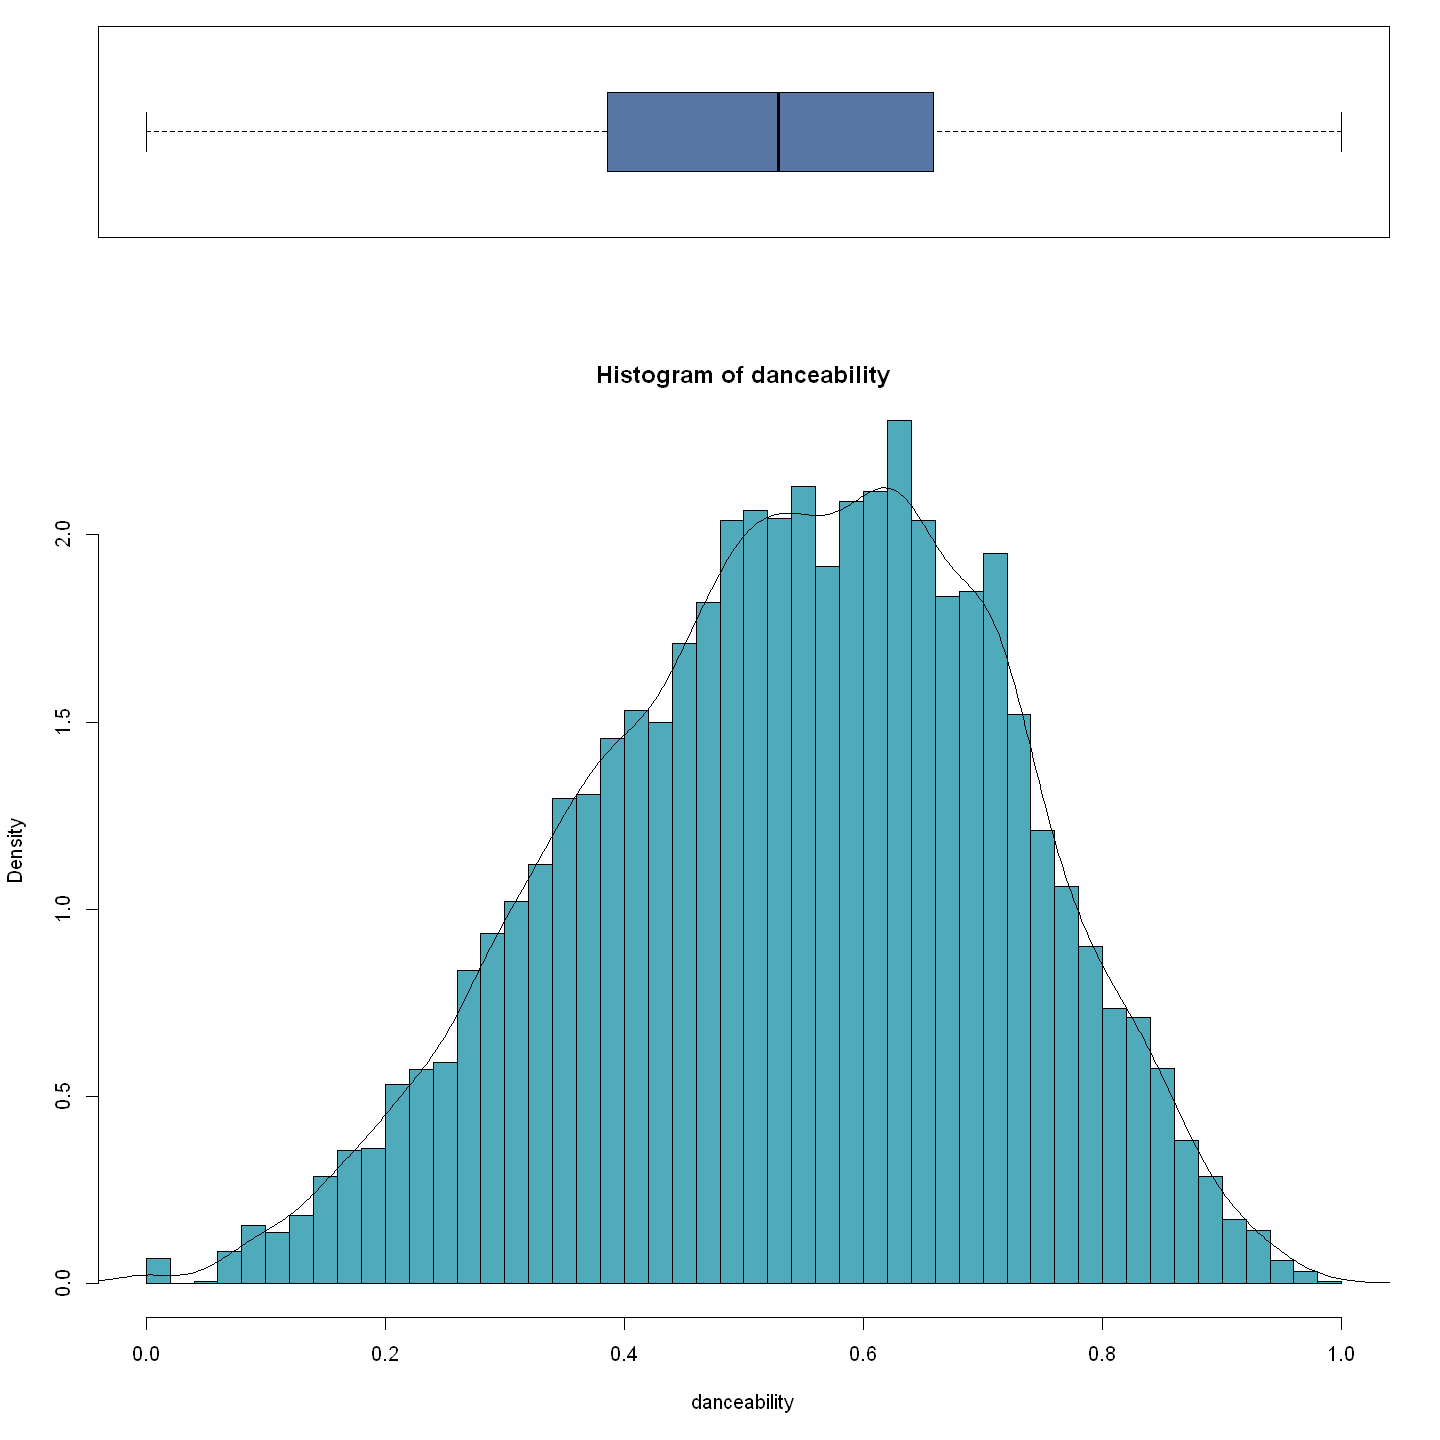

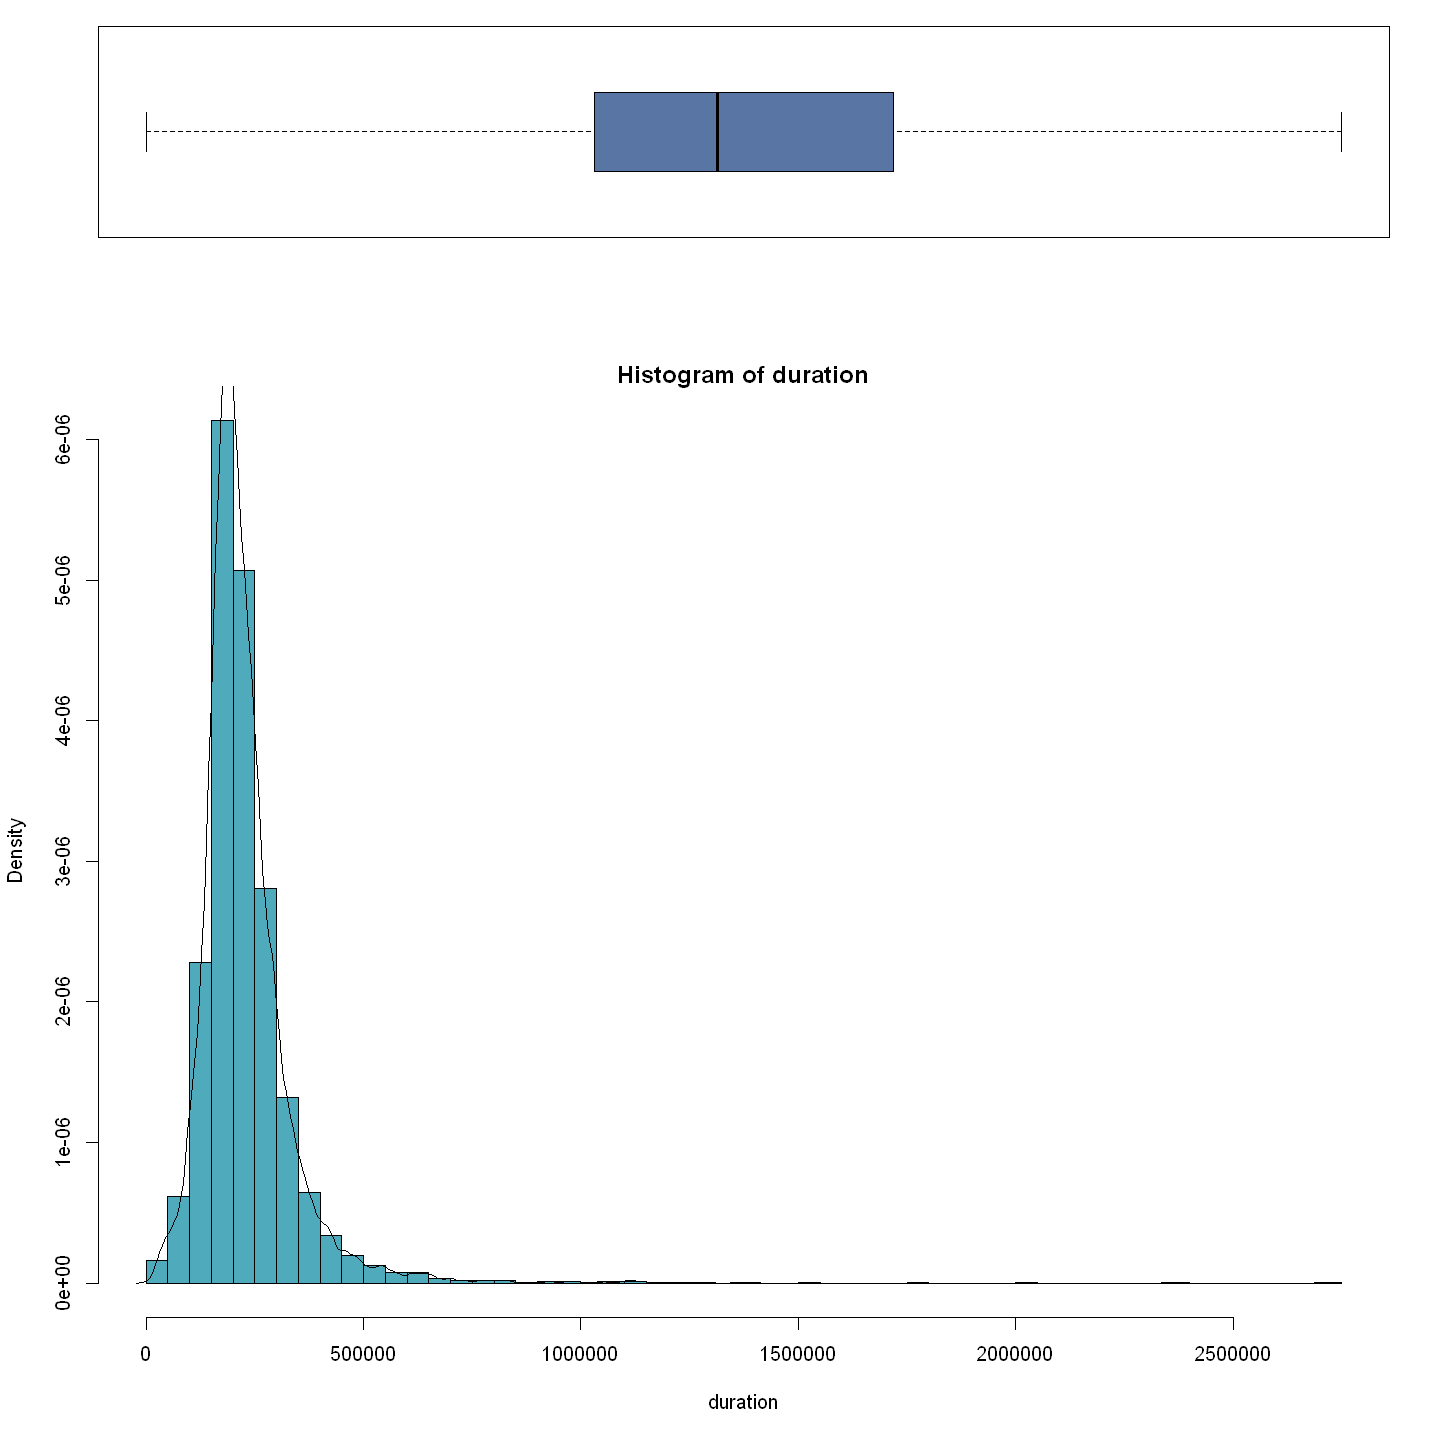

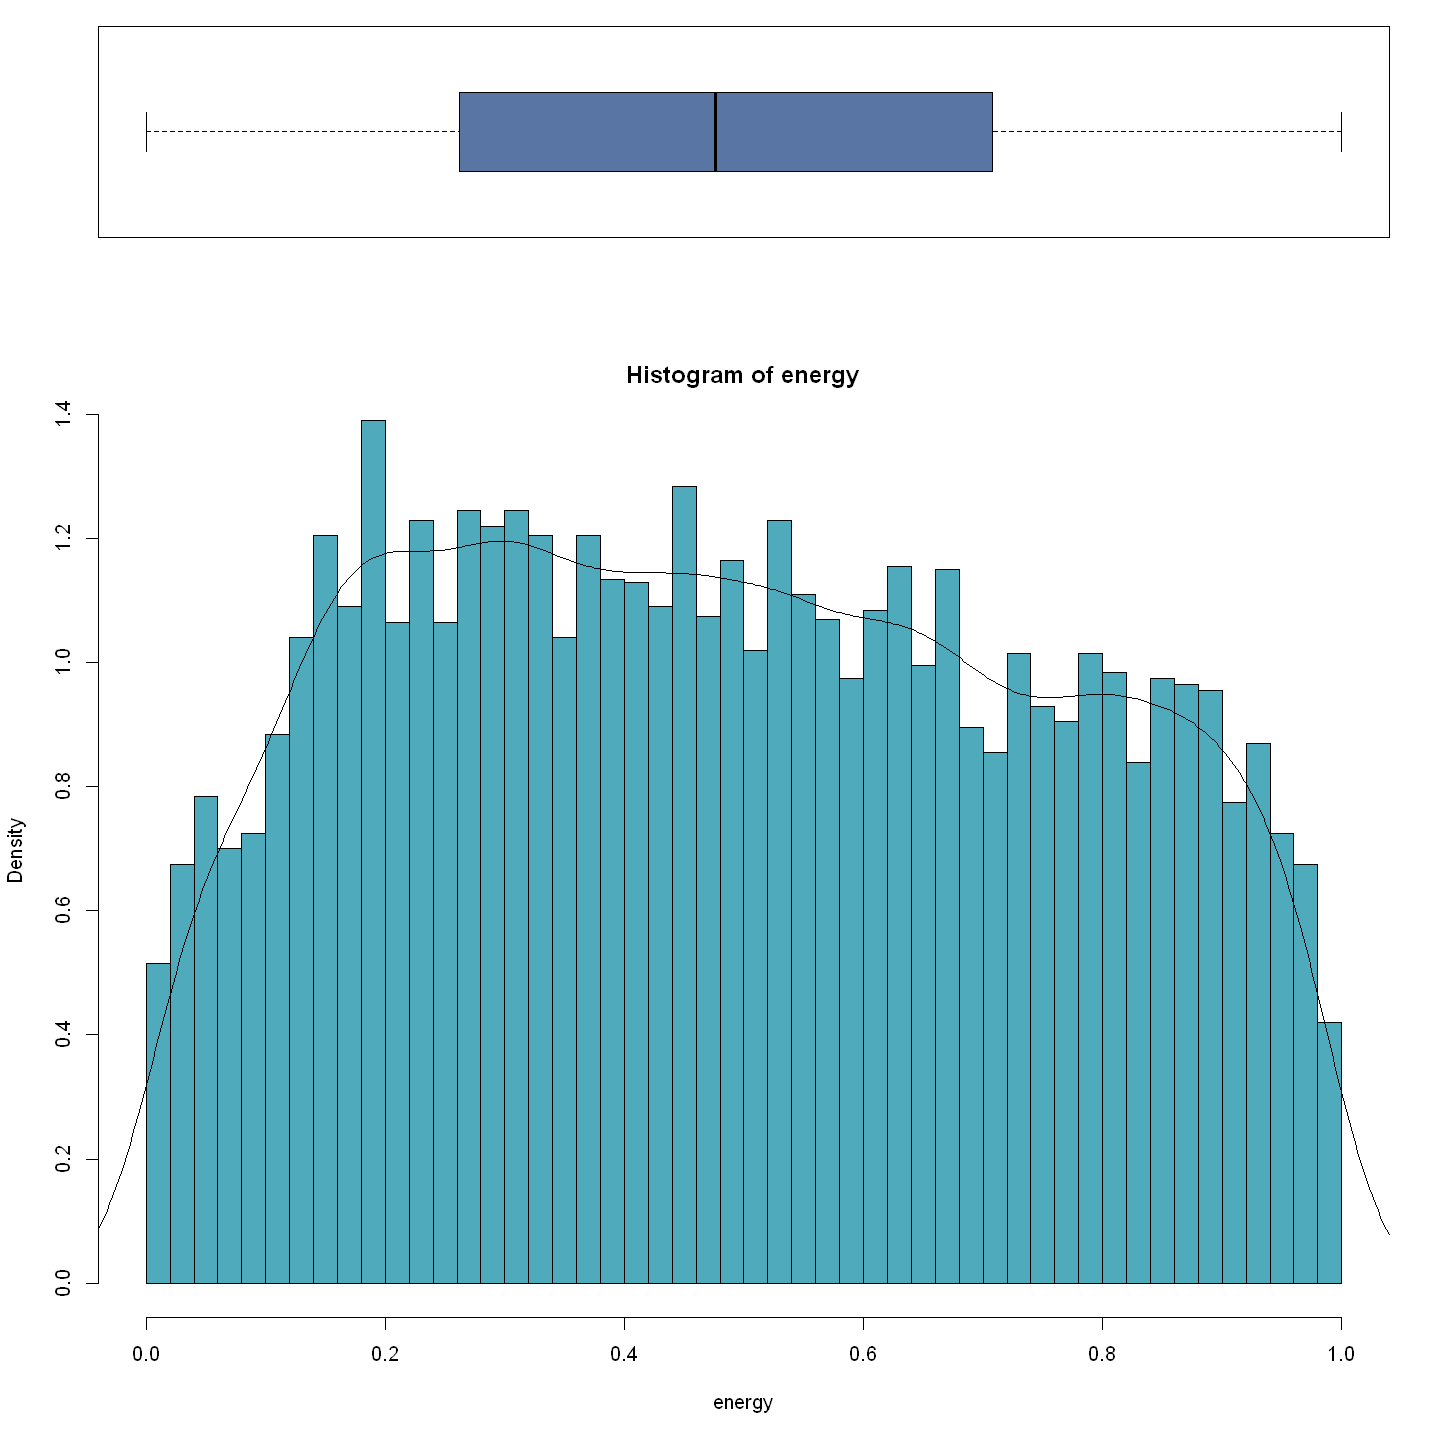

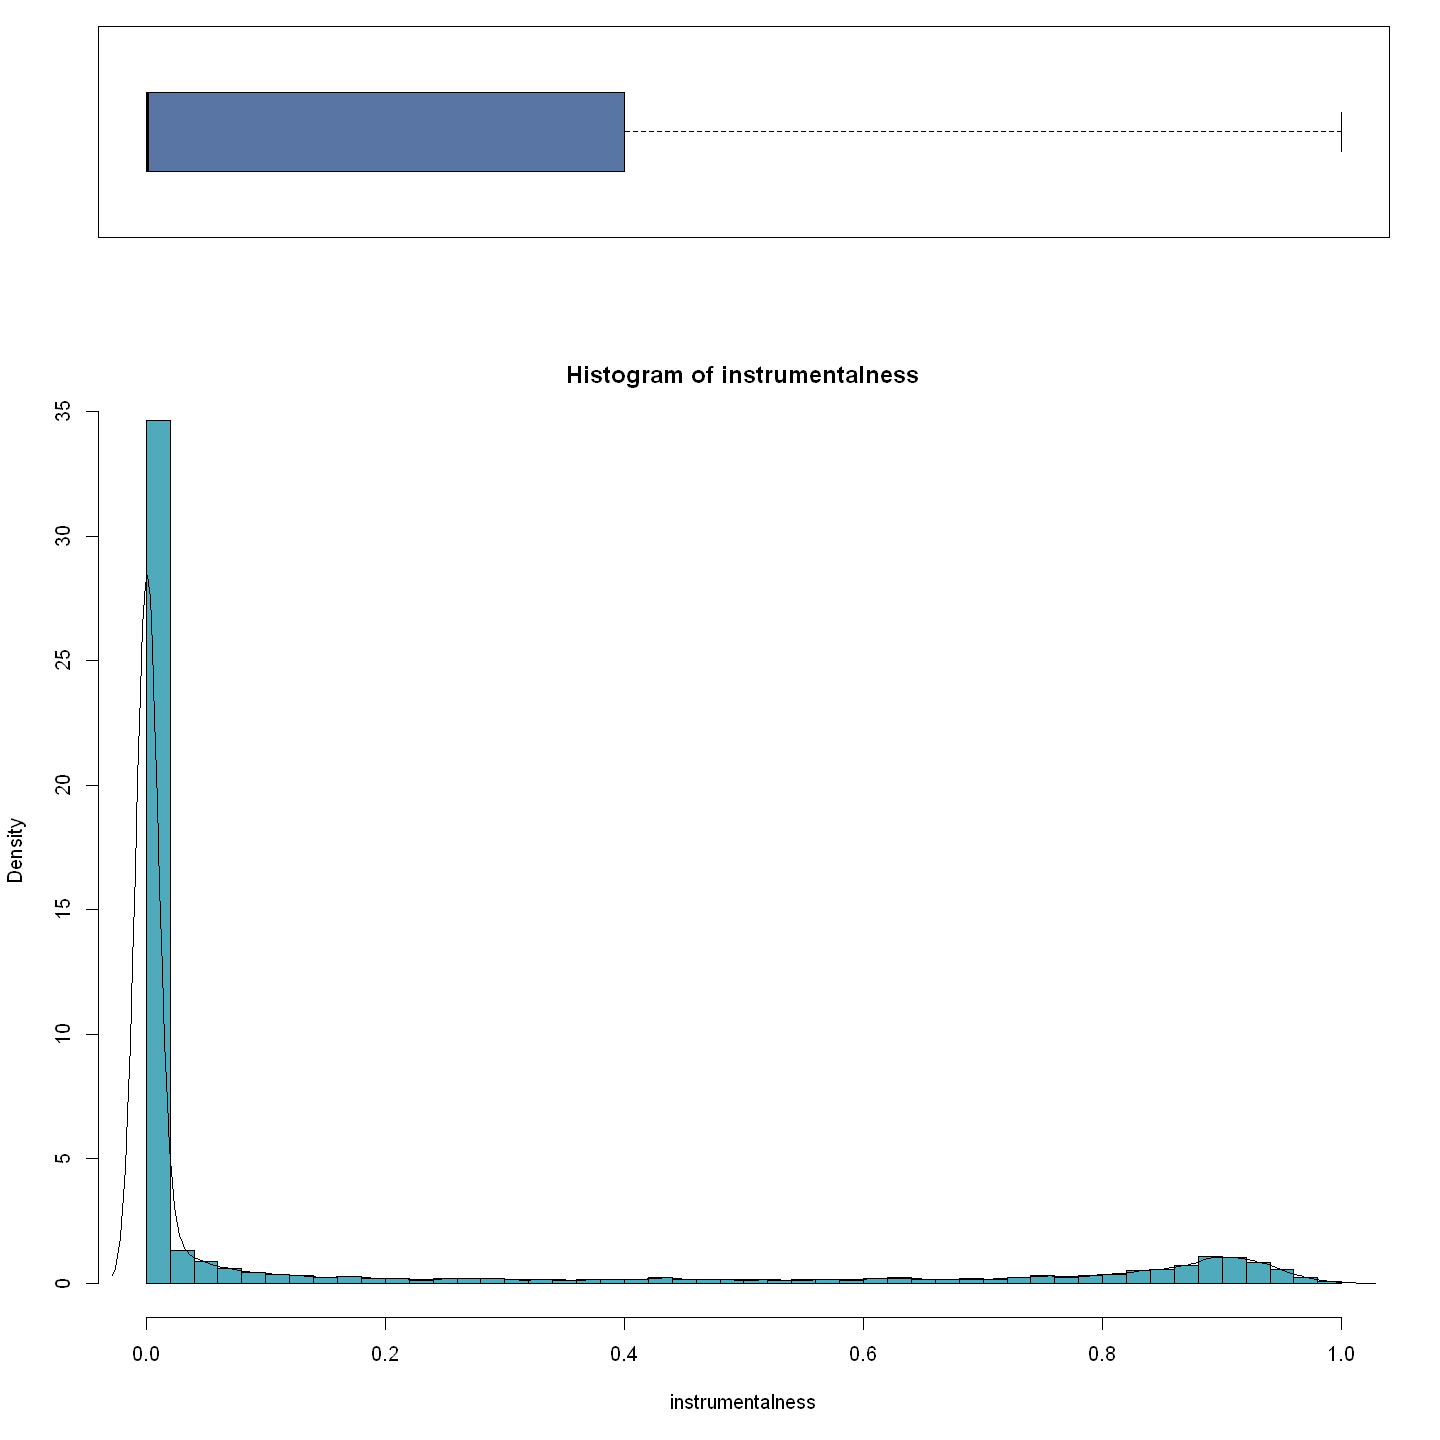

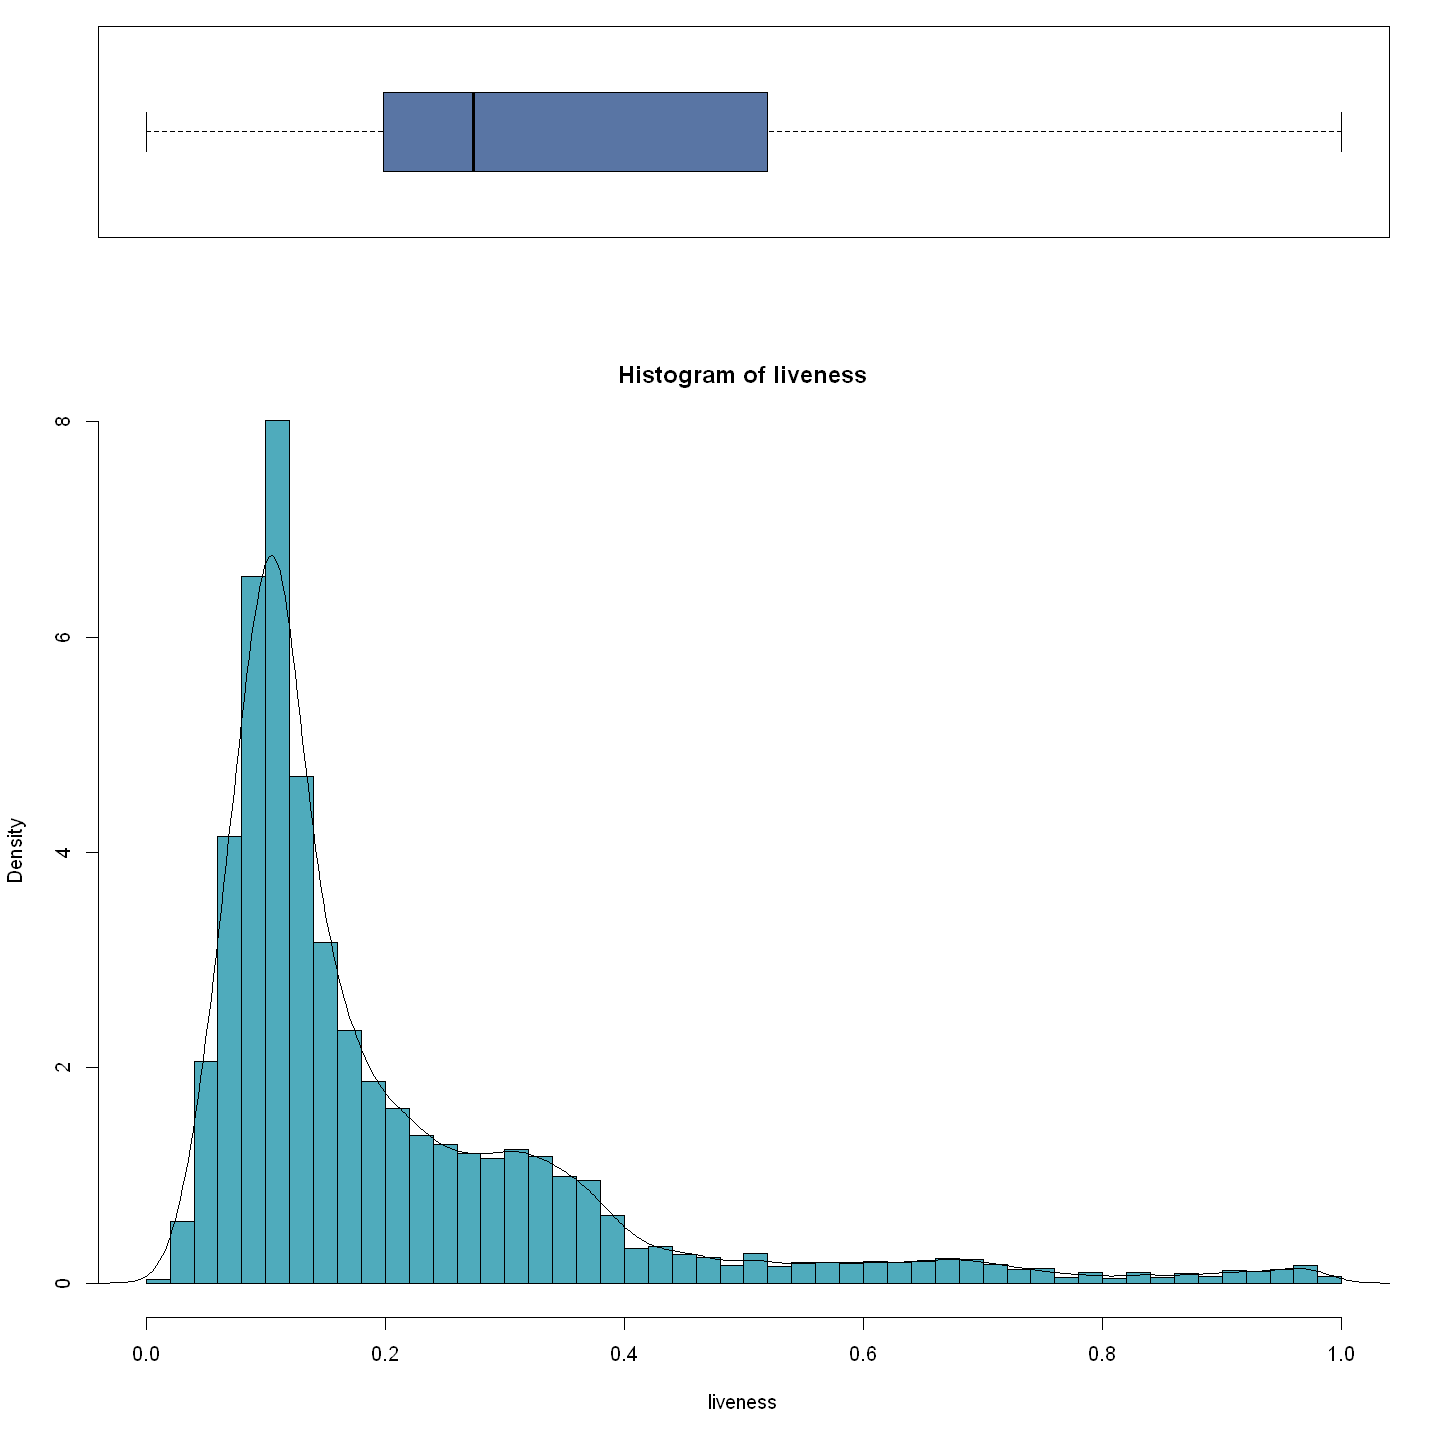

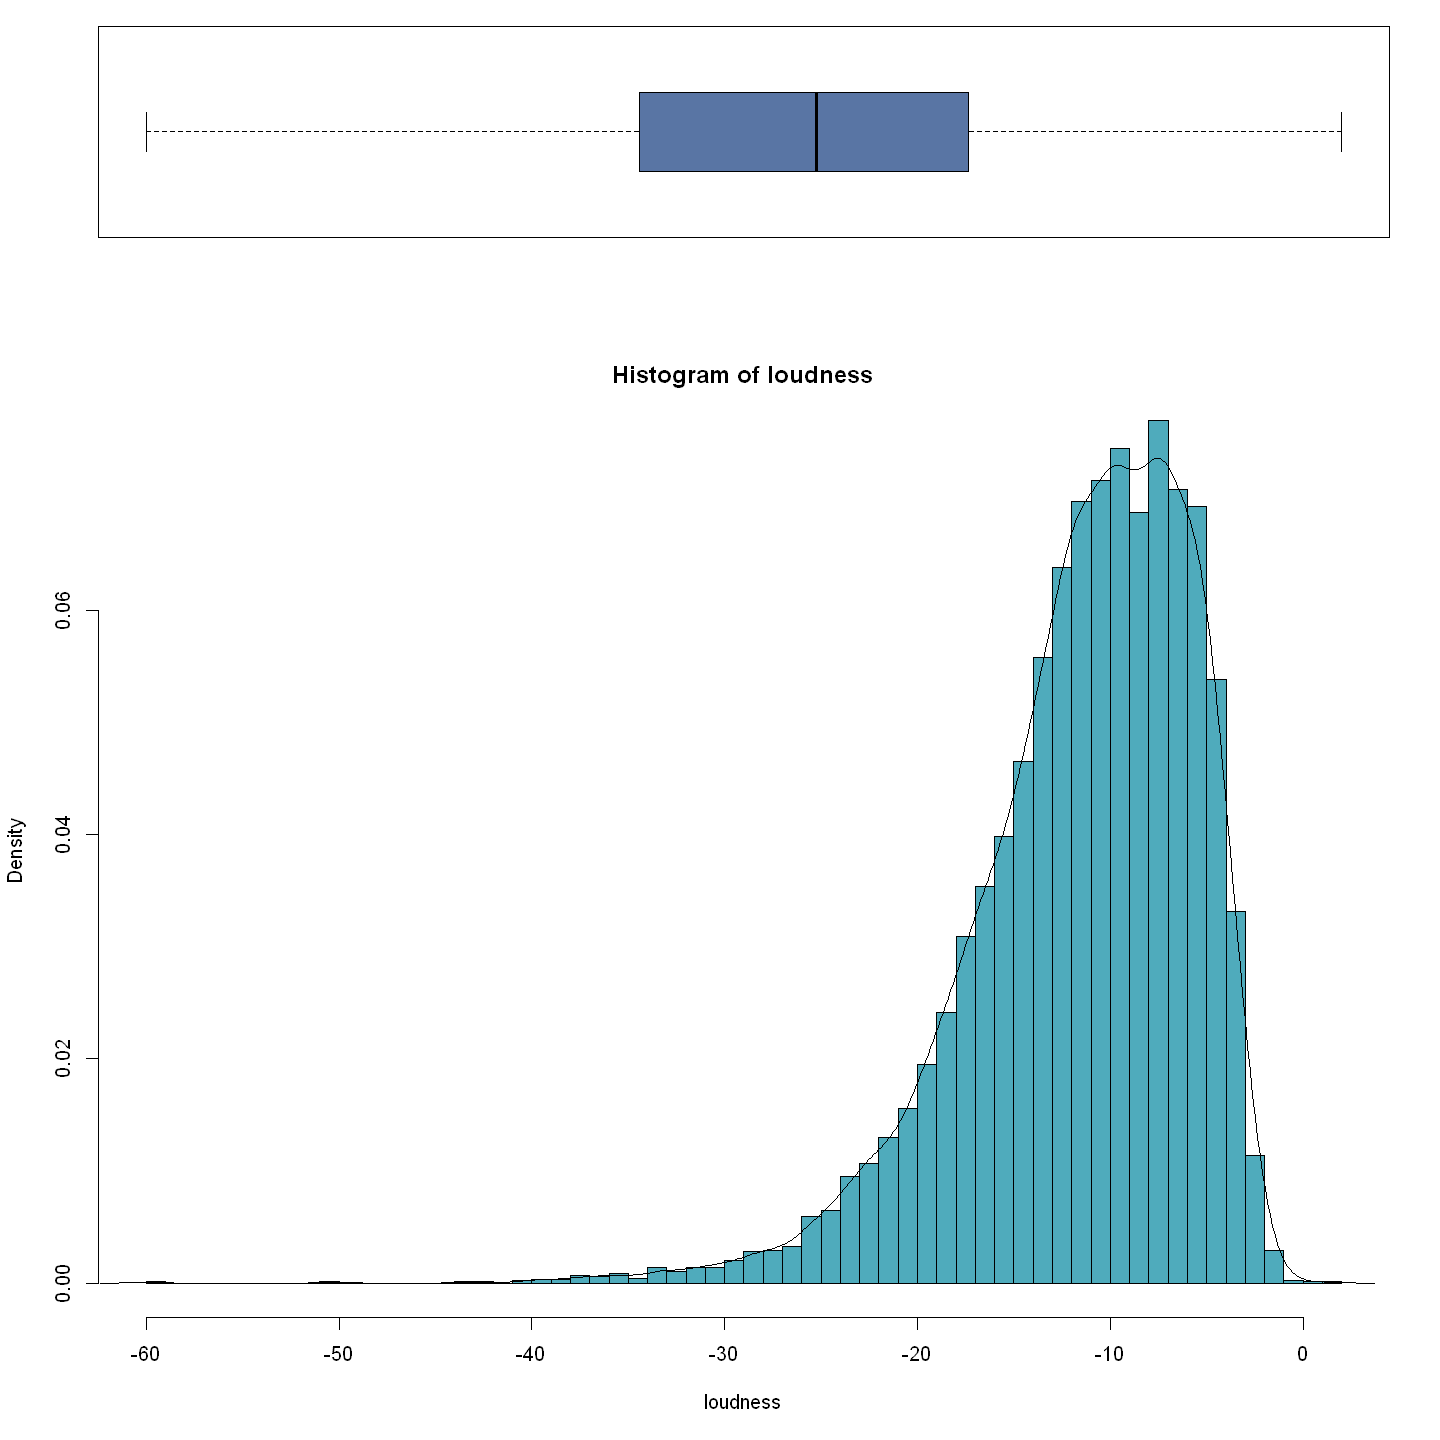

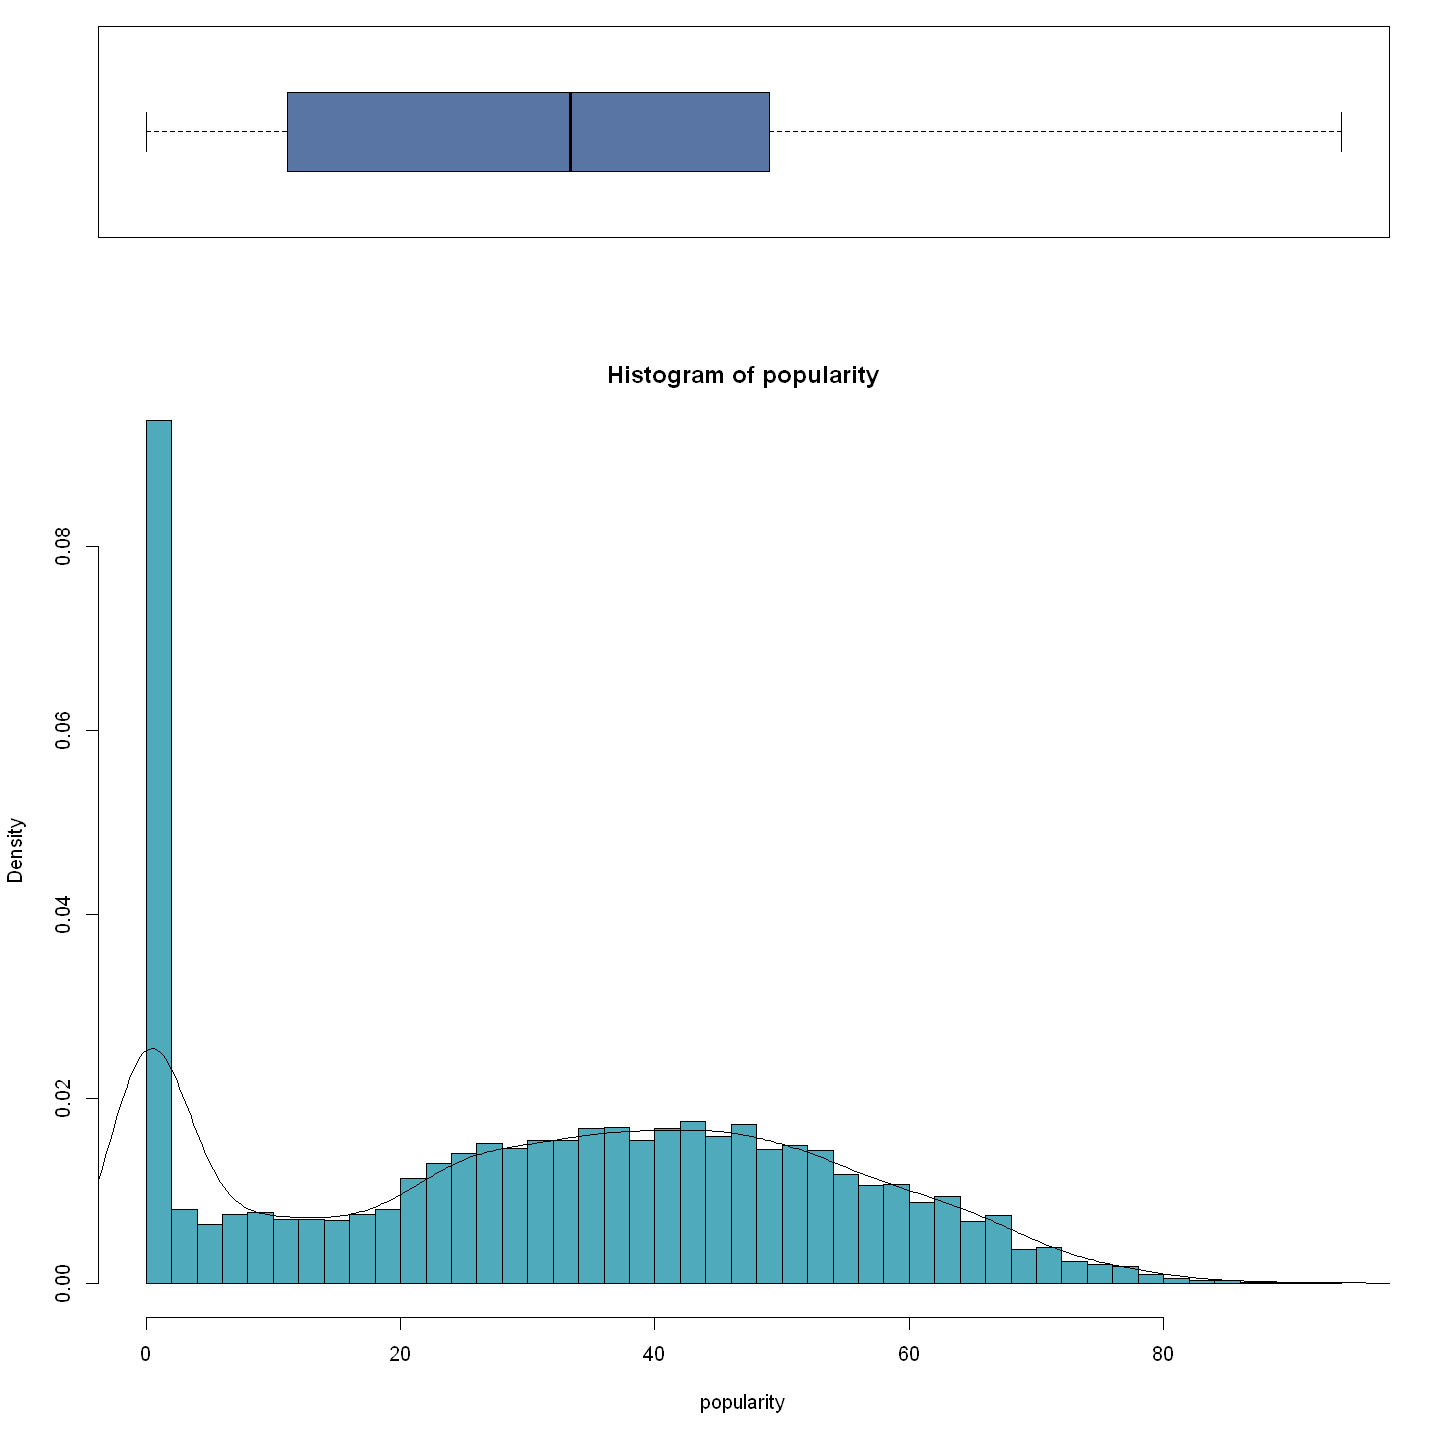

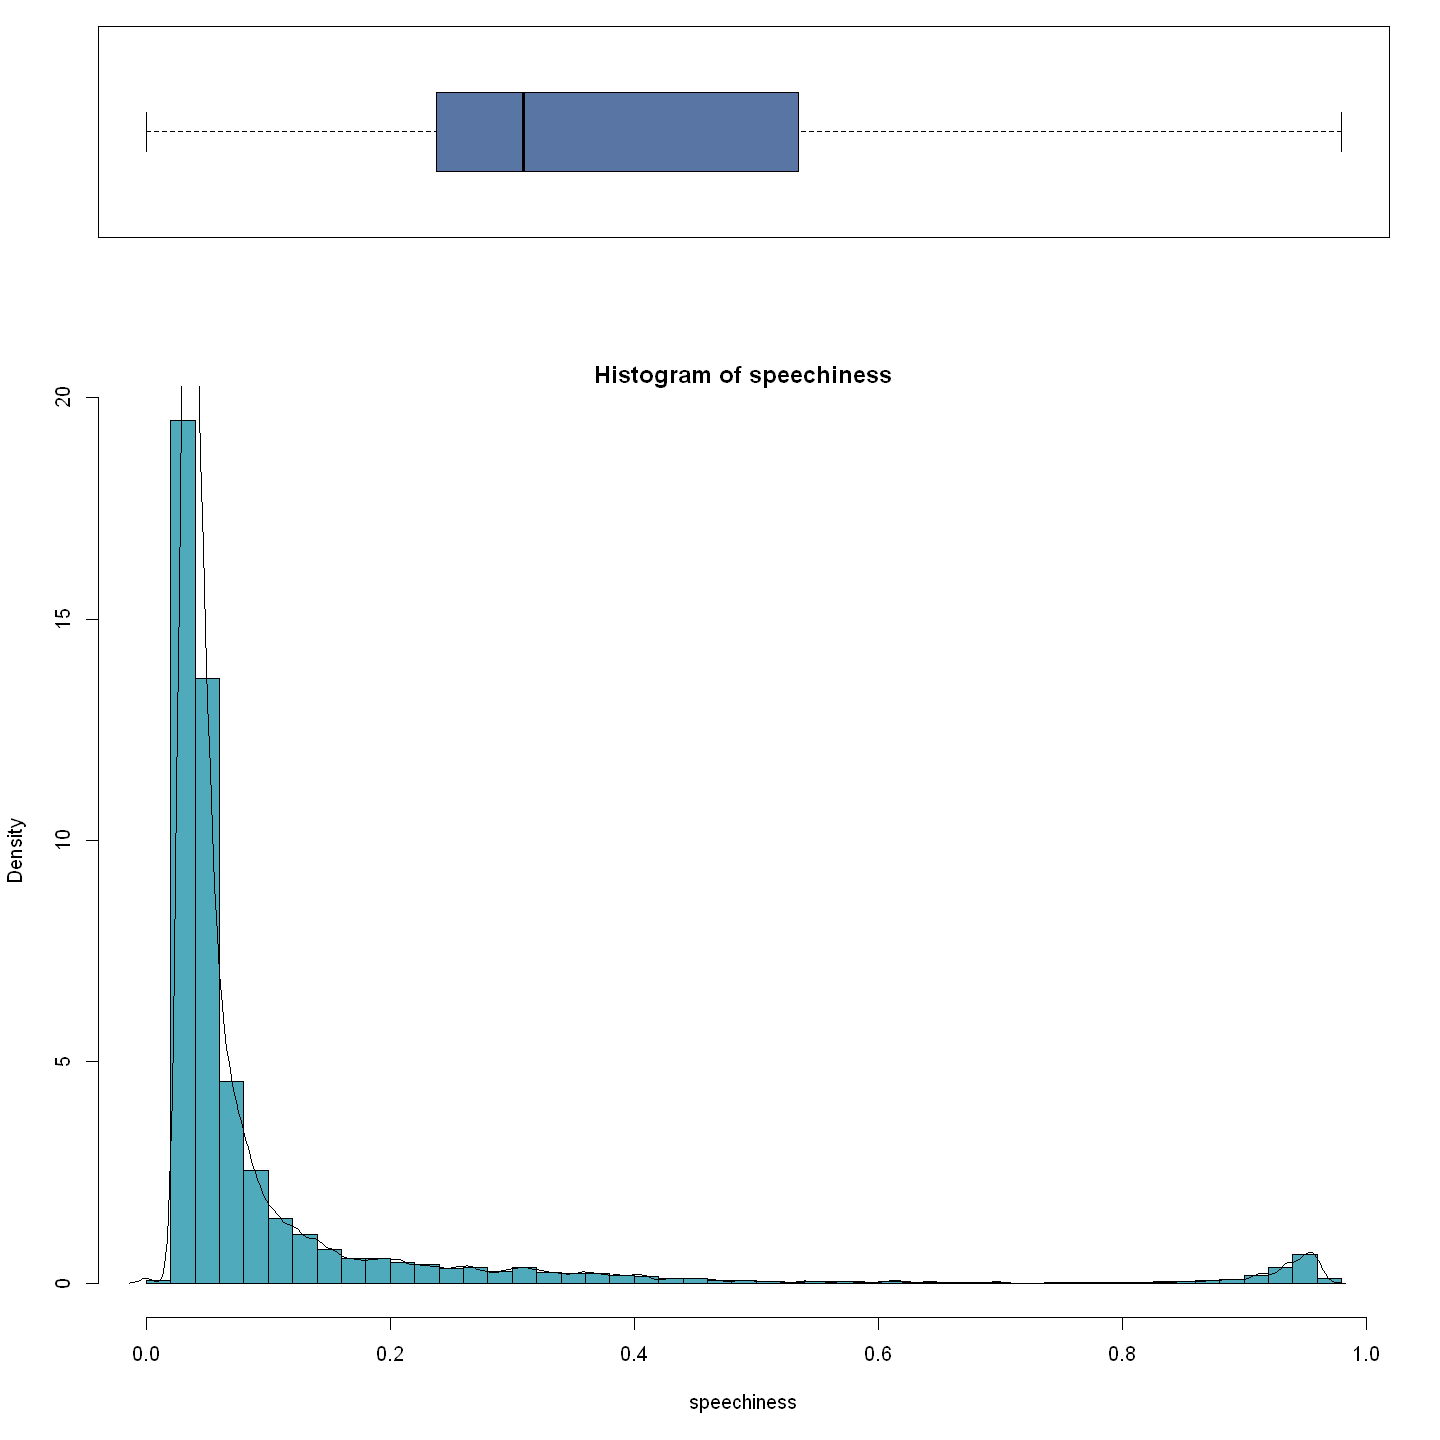

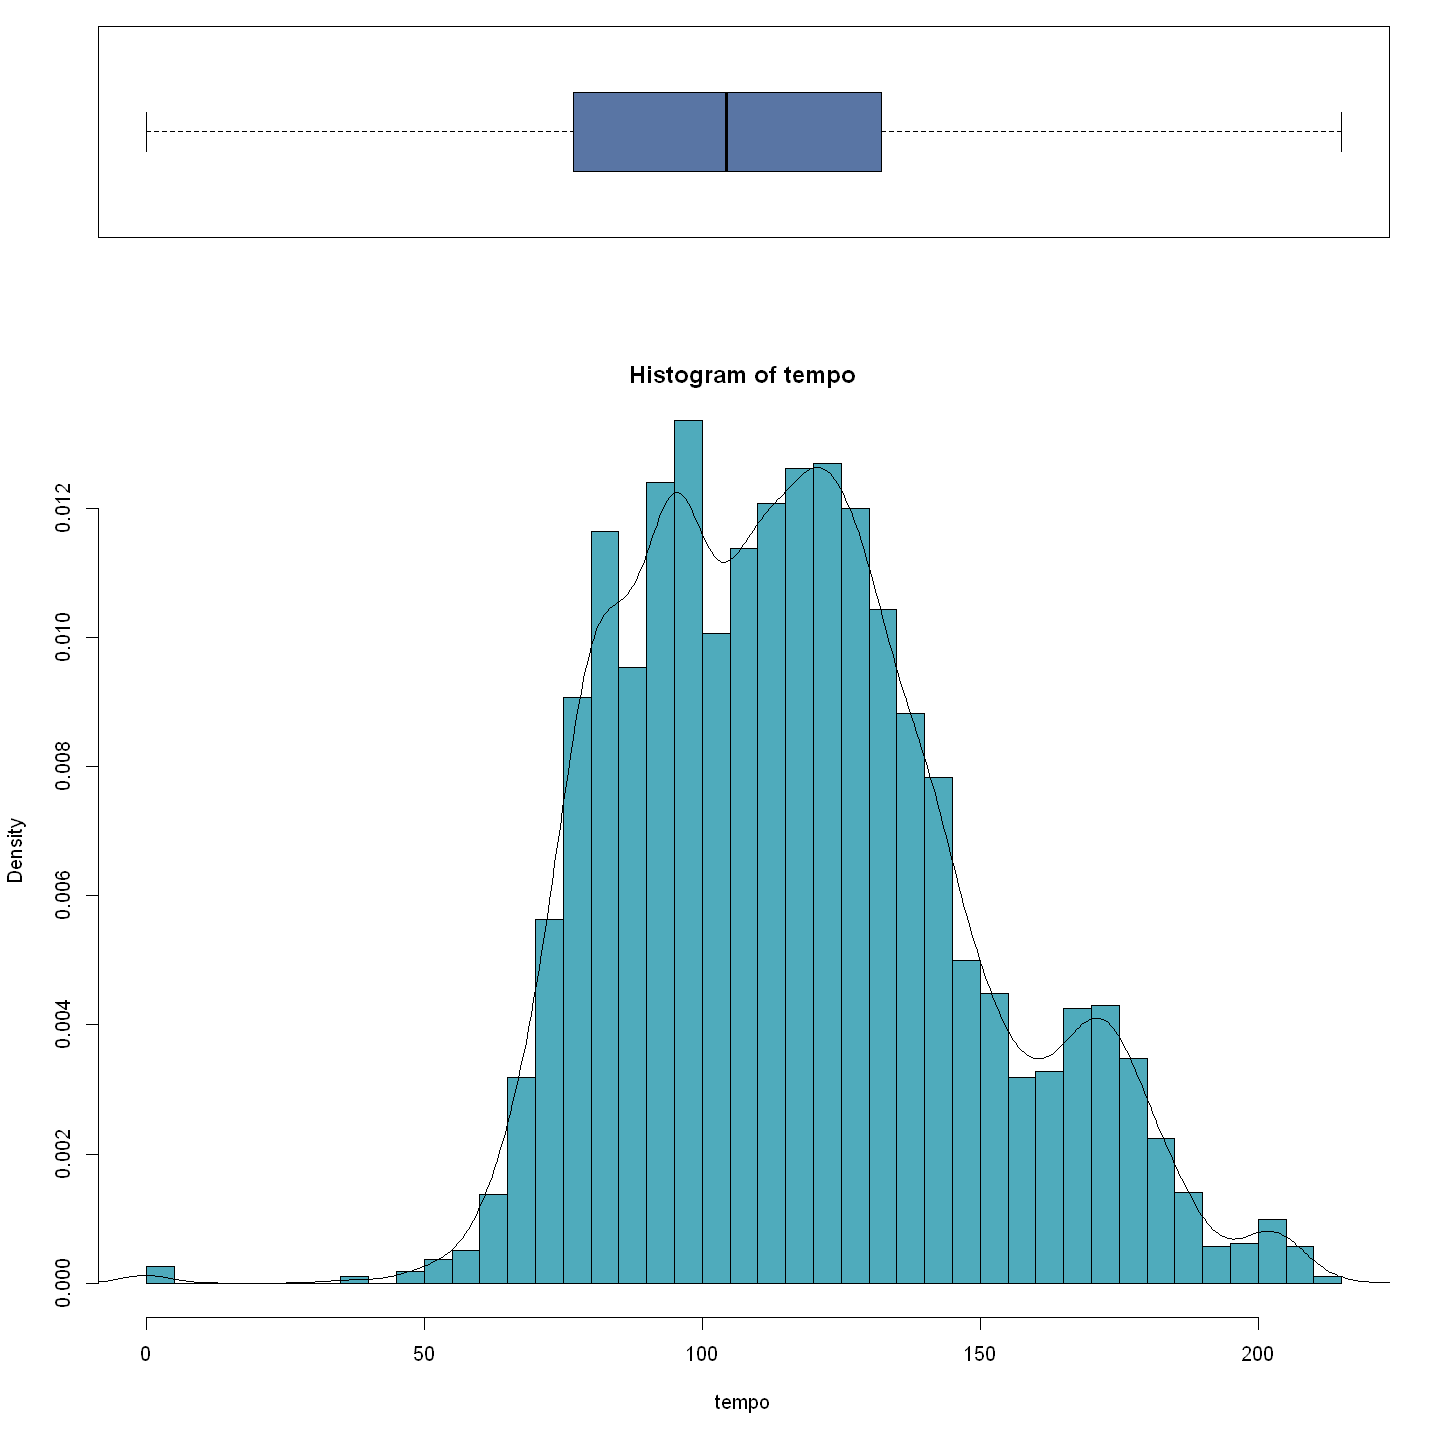

In [24]:
for (i in 1:12) {
    vari <- data.quant[, i]
    nf <- layout(mat = matrix(c(1, 2), 2, 1, byrow = TRUE), height = c(1, 3))
    par(mar = c(5.1, 4.1, 1.1, 2.1))
    boxplot(vari, horizontal = TRUE, xaxt = "n", outline = F, col = "#5975A4")
    hist(vari, main = paste("Histogram of", colnames(data.quant)[i], sep = " "), 
        breaks = ifelse(i == 2, 100, 50), xlab = colnames(data.quant)[i], freq = F, 
        col = "#4FABBC")
    lines(density(vari))
}

Voici une étude plus approfondie de chaque variable quantitative :

<b>Acousticness</b>

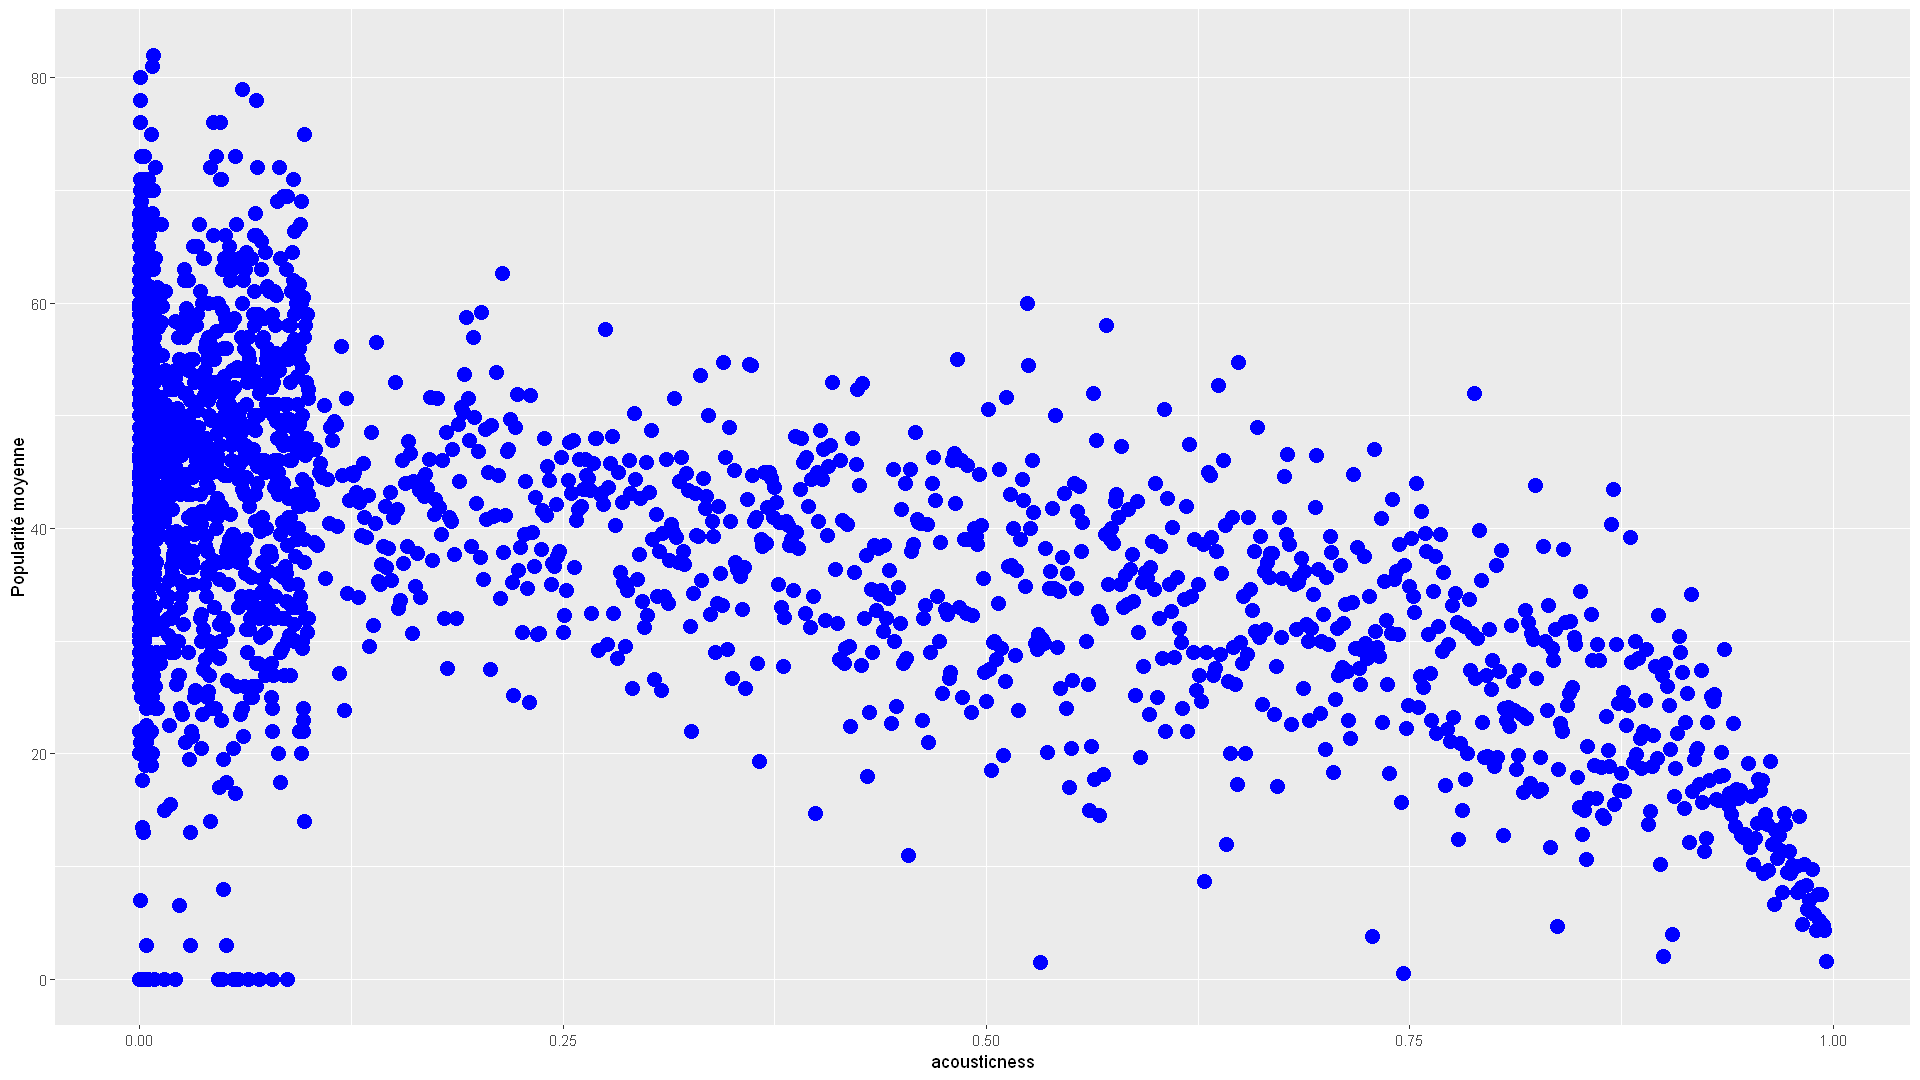

In [25]:
ax.data <- as.data.frame(spotify_data %>%
    group_by(acousticness) %>%
    mutate(popularity = mean(popularity)))

options(repr.plot.width = 16, repr.plot.height = 9)

ggplot(ax.data, aes(x = acousticness, y = popularity)) +
    geom_point(color = "blue", size = 4) +
    labs(y = "Popularité moyenne")

<b>Danceability</b>

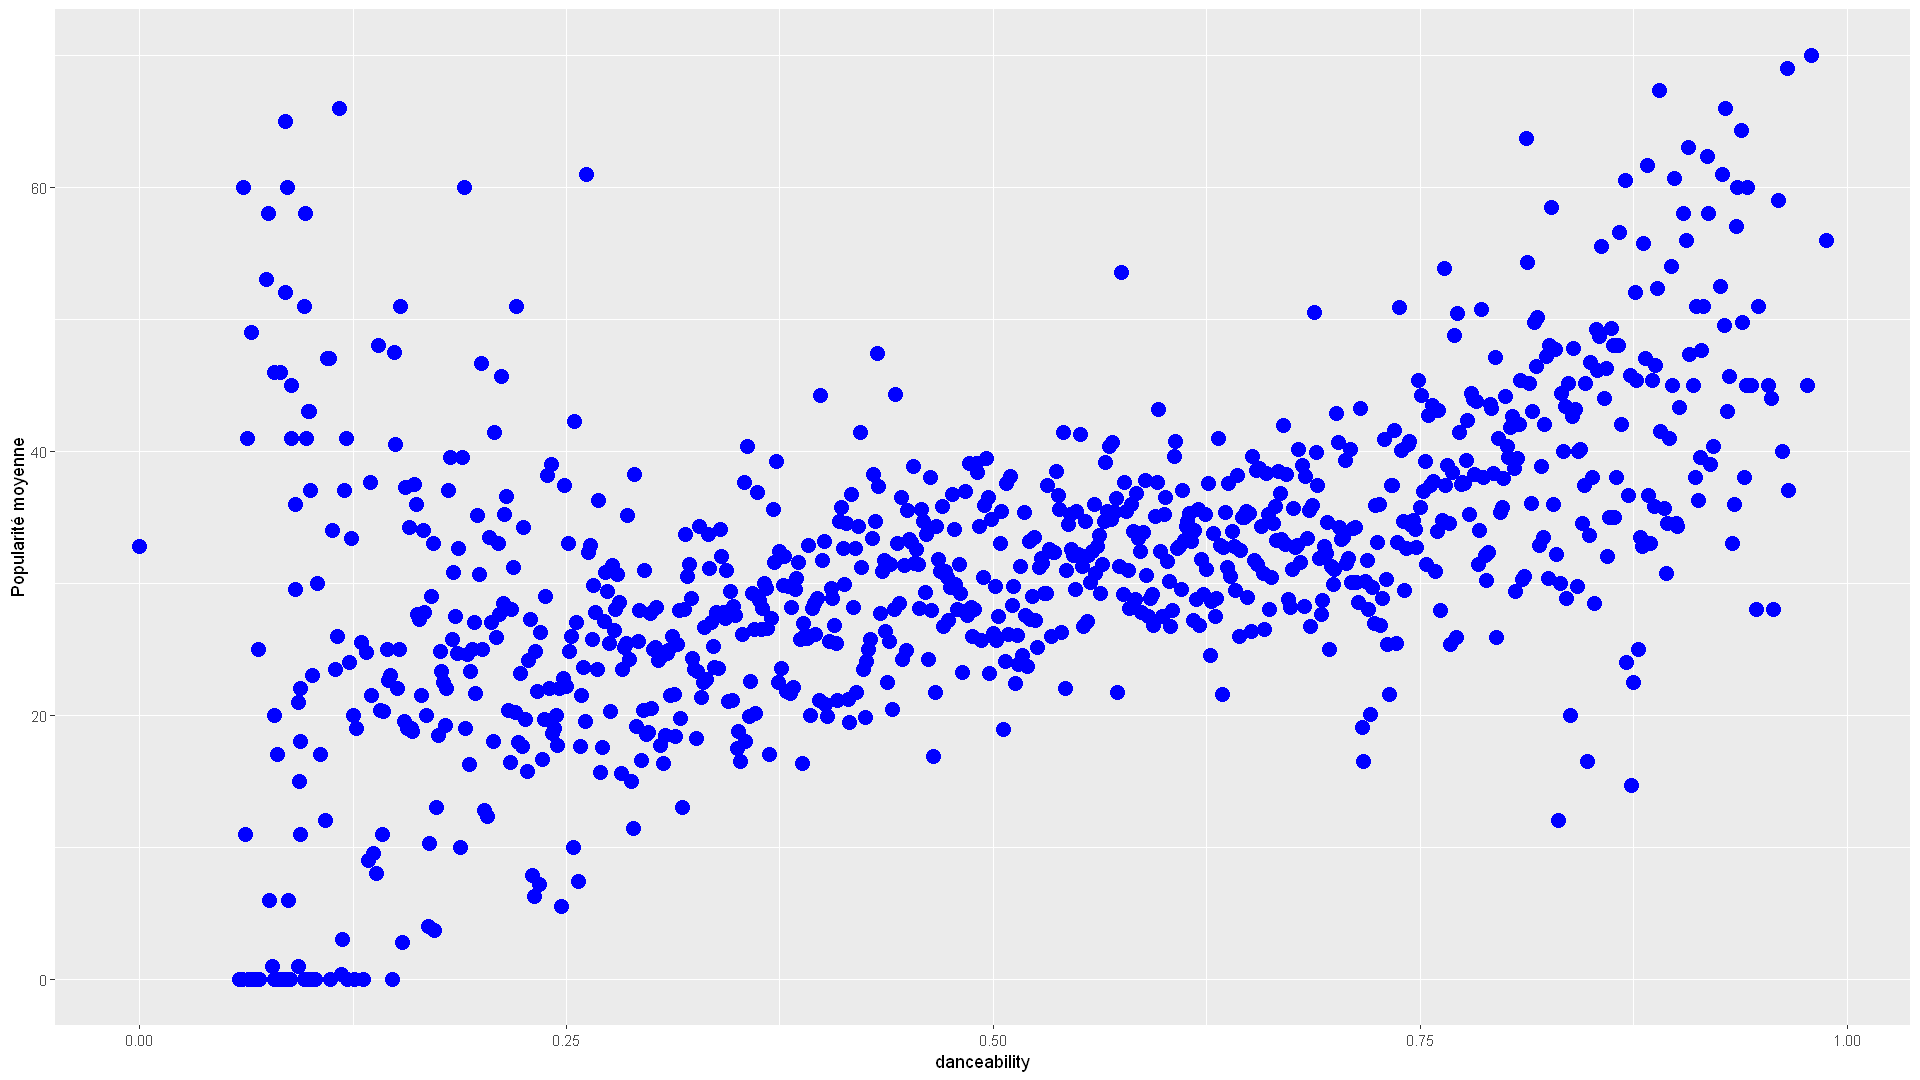

In [26]:
ax.data <- as.data.frame(spotify_data %>%
    group_by(danceability) %>%
    mutate(popularity = mean(popularity)))

options(repr.plot.width = 16, repr.plot.height = 9)

ggplot(ax.data, aes(x = danceability, y = popularity)) +
    geom_point(color = "blue", size = 4) +
    labs(y = "Popularité moyenne")

<b>Duration</b>

On convertit la durée des chansons en minutes pour en tirer plus d'informations.

In [27]:
spotify_data$duration <- spotify_data$duration / 60000
summary(spotify_data$duration)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.09985  2.81778  3.44216  3.78692  4.32888 45.05378 

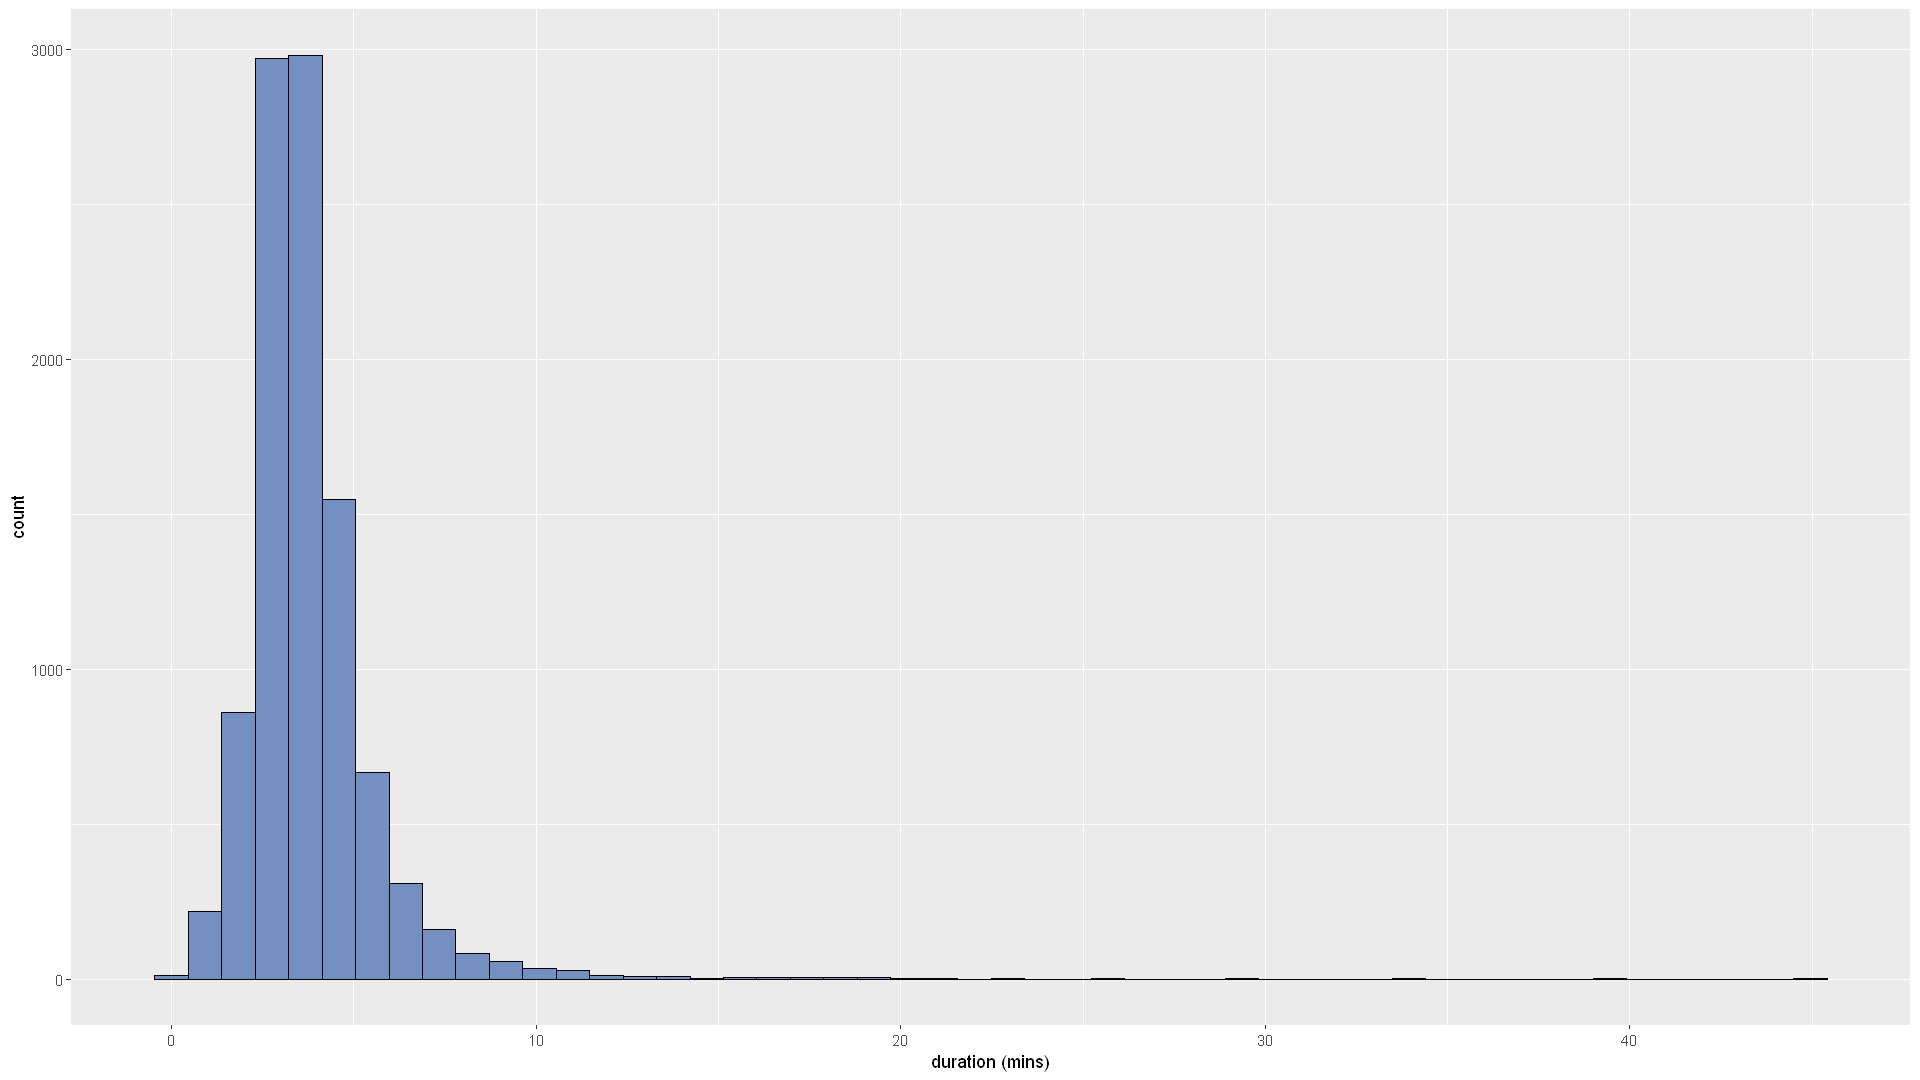

In [28]:
ggplot(data = spotify_data, aes(x = duration)) +
    geom_histogram(color = "black", fill = "#7490C0", bins = 50) +
    labs(x = "duration (mins)")

On voit que la chanson la plus longue dans le jeu de données dure 45 minutes, donc on choisit de séparer les chansons longues de chansons courtes au seuil de 8 minutes pour mieux voir les durées.

In [29]:
long.songs <- spotify_data[spotify_data$duration > 8, ]
short.songs <- spotify_data[spotify_data$duration <= 8, ]

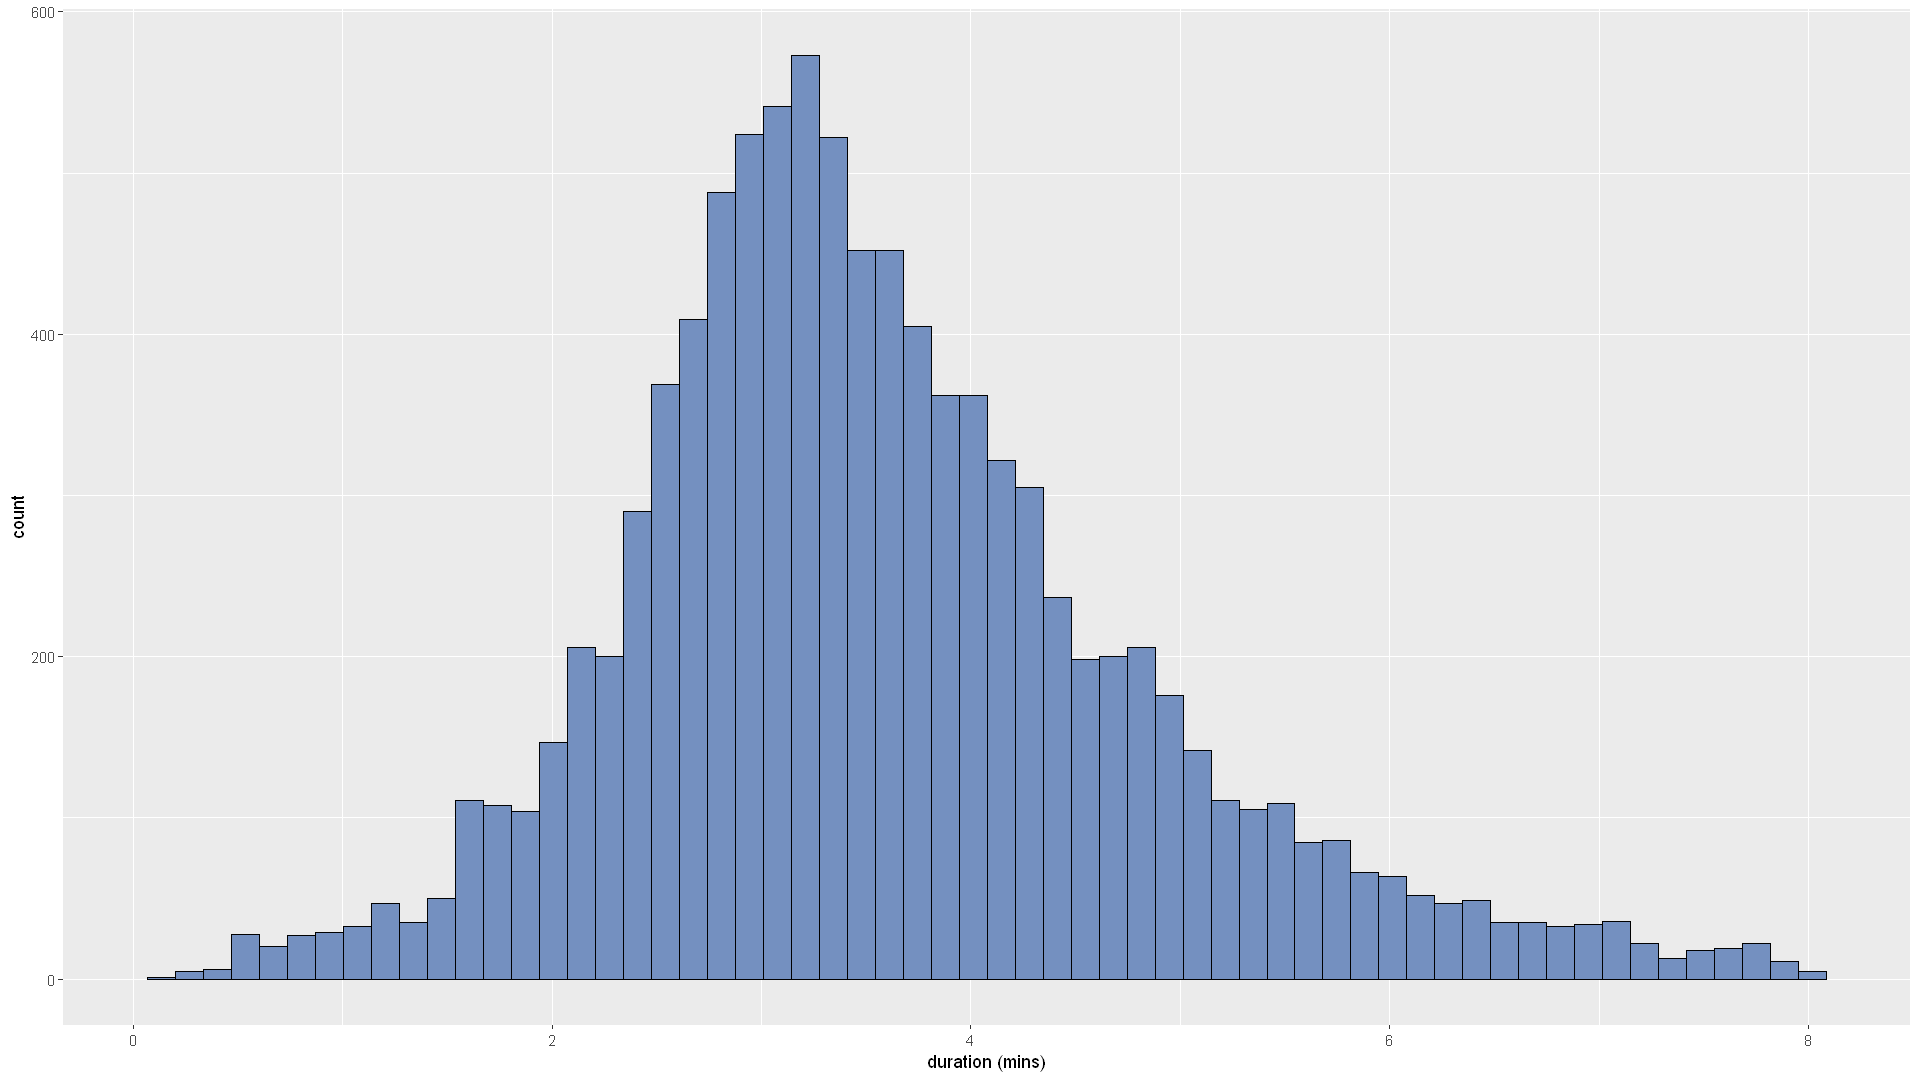

In [30]:
ggplot(data = short.songs, aes(x = duration)) +
    geom_histogram(color = "black", fill = "#7490C0", bins = 60) +
    labs(x = "duration (mins)")

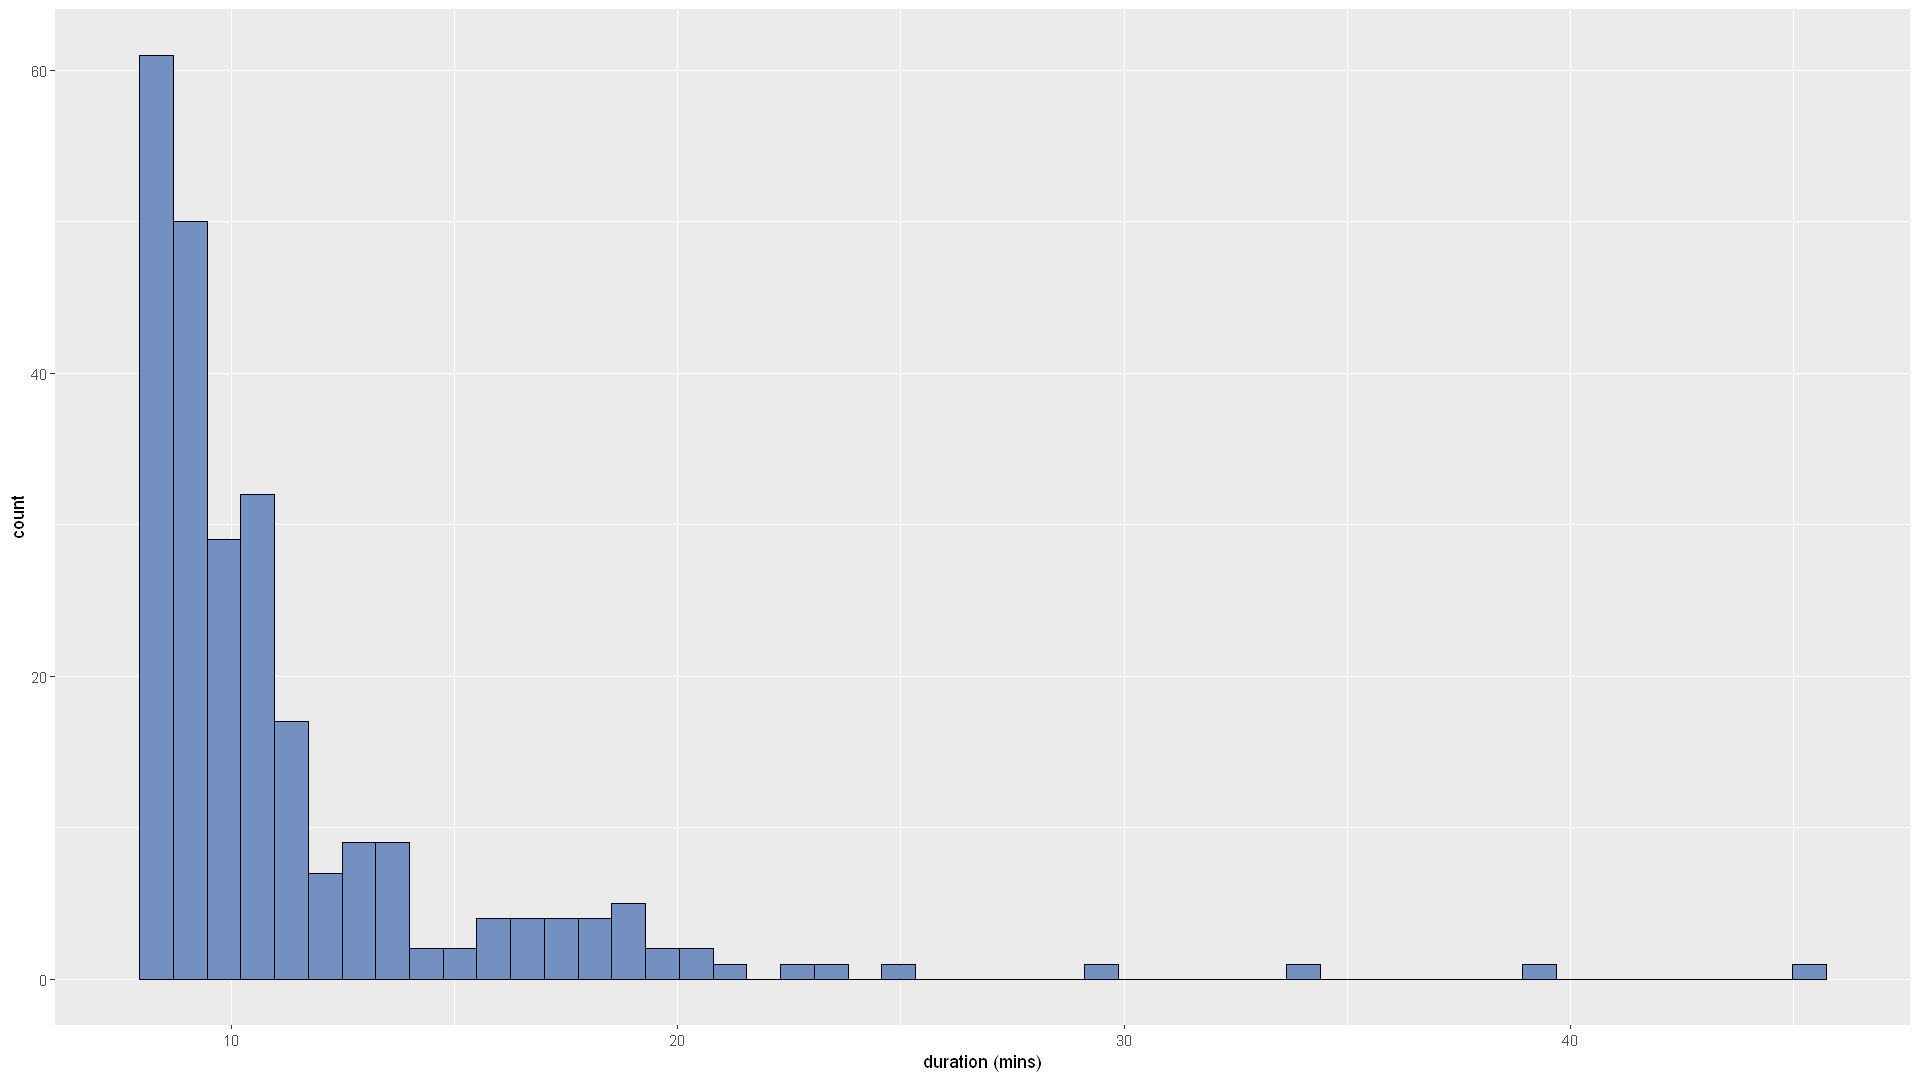

In [31]:
ggplot(data = long.songs, aes(x = duration)) +
    geom_histogram(color = "black", fill = "#7490C0", bins = 50) +
    labs(x = "duration (mins)")


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




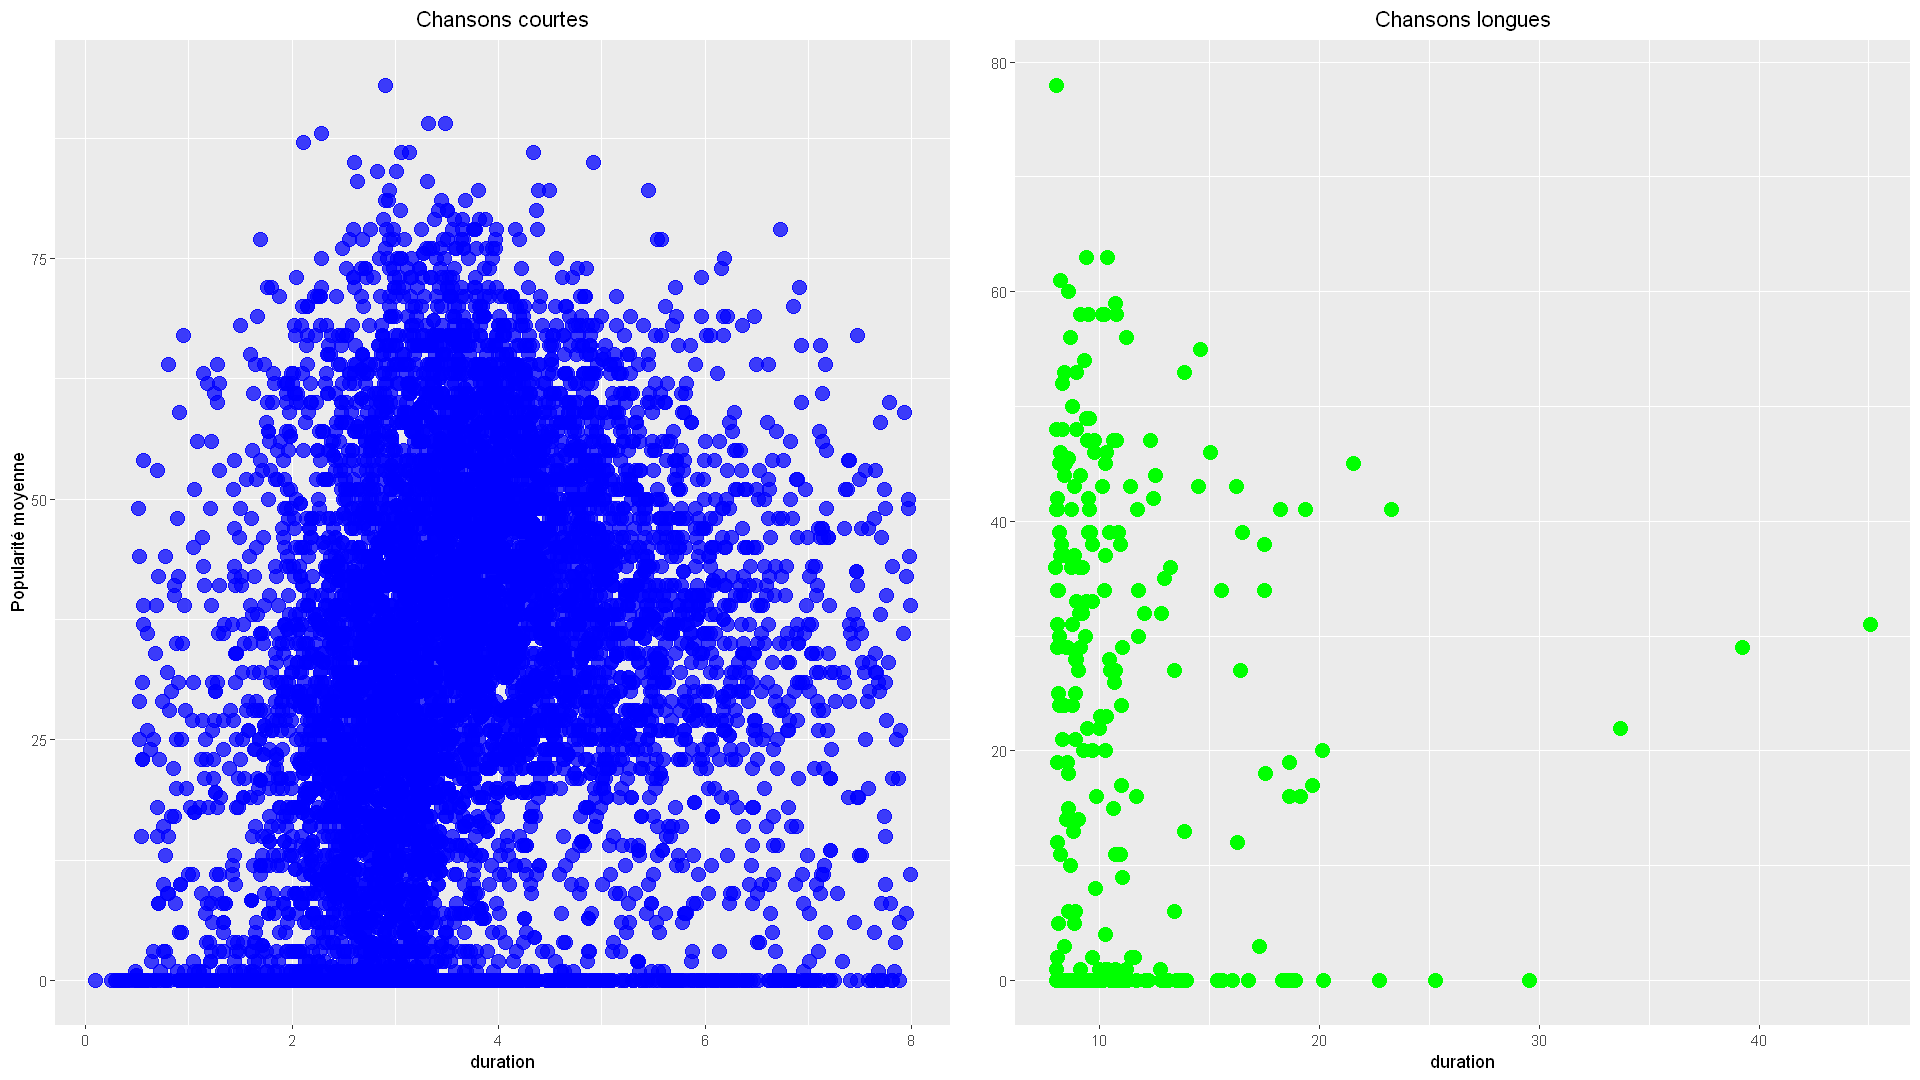

In [32]:
library(grid)
library(gridExtra)

ax1.data <- as.data.frame(short.songs %>%
    group_by(duration) %>%
    mutate(popularity = mean(popularity)))

ax2.data <- as.data.frame(long.songs %>%
    group_by(duration) %>%
    mutate(popularity = mean(popularity)))

p1 <- ggplot(ax1.data, aes(x = duration, y = popularity)) +
        geom_point(color = "blue", size = 4, alpha = .75) +
        labs(title = "Chansons courtes", y = "Popularité moyenne") +
        theme(plot.title = element_text(hjust = 0.5))

p2 <- ggplot(ax2.data, aes(x = duration, y = popularity)) +
        geom_point(color = "green", size = 4) +
        labs(title = "Chansons longues", y = "") +
        theme(plot.title = element_text(hjust = 0.5))

grid.arrange(p1, p2, nrow = 1)

<b>Energy</b>

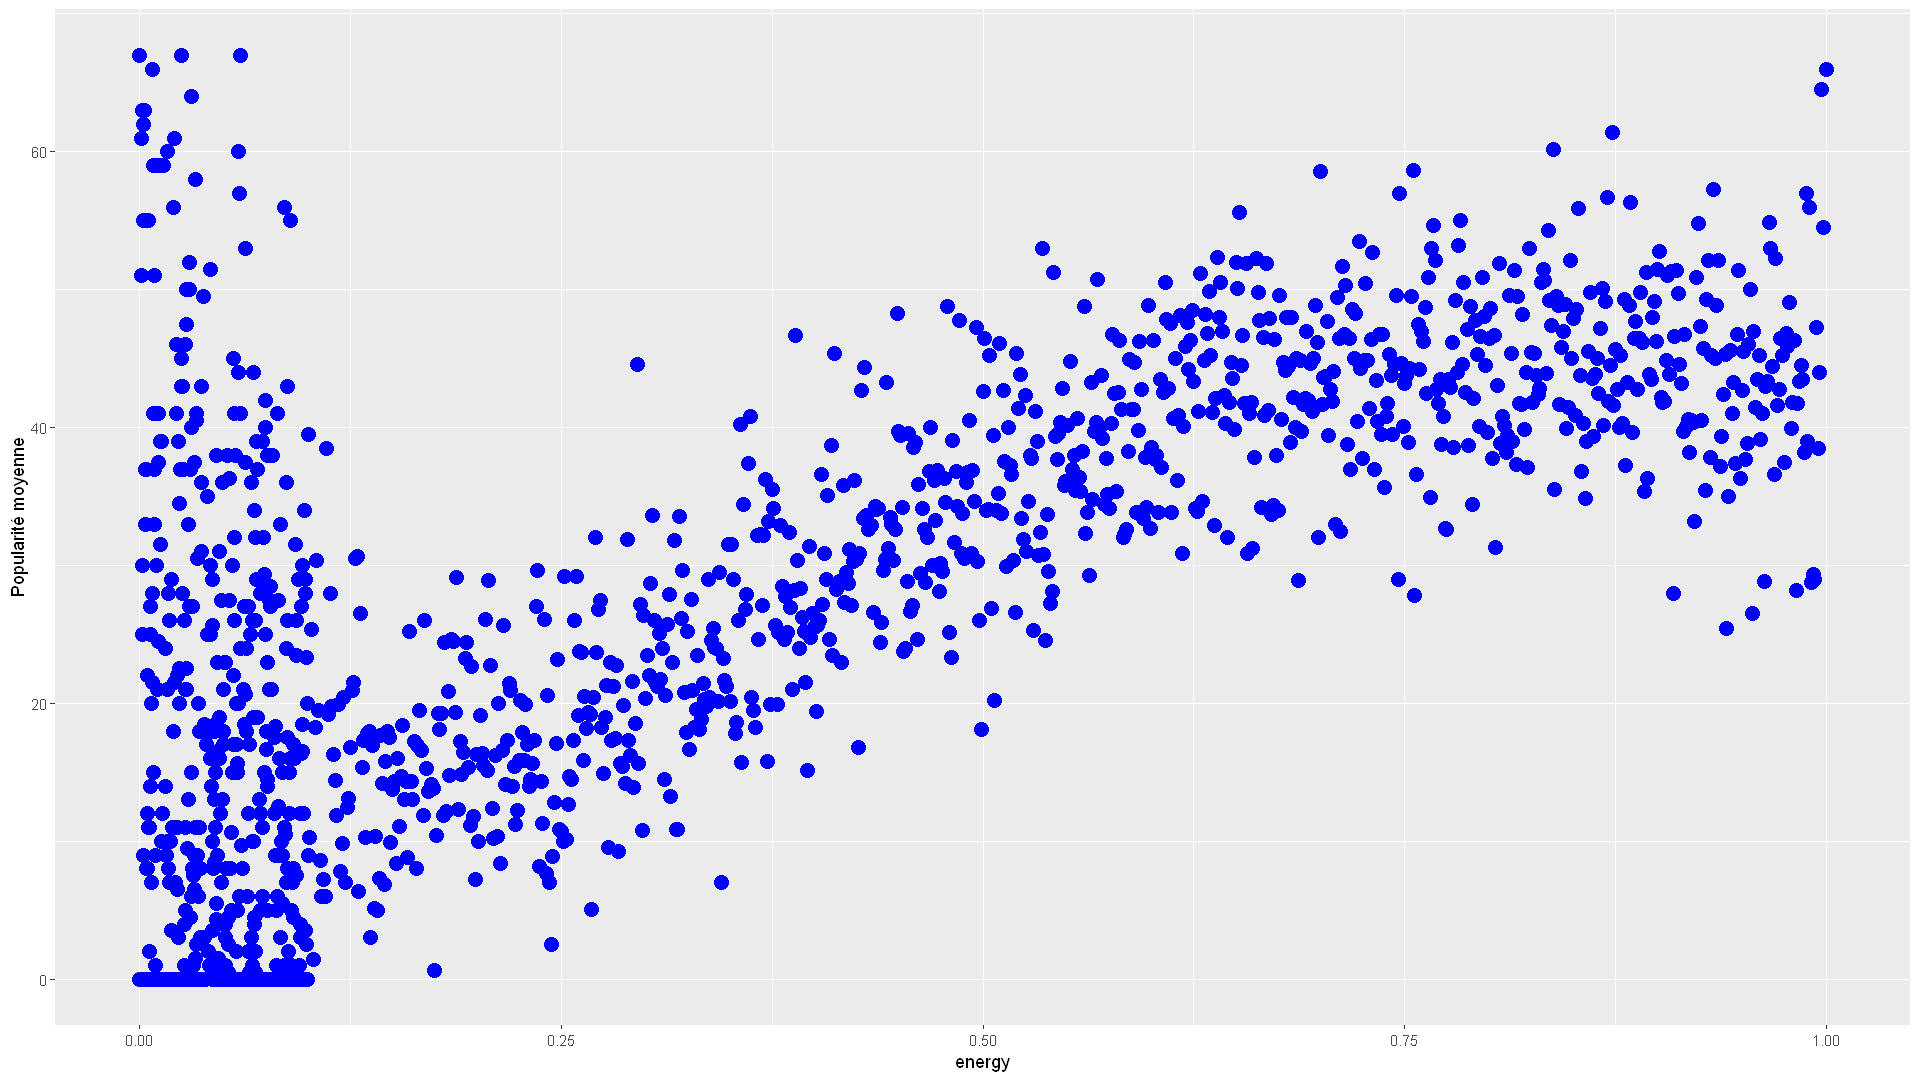

In [33]:
ax.data <- as.data.frame(short.songs %>%
    group_by(energy) %>%
    mutate(popularity = mean(popularity)))

ggplot(ax.data, aes(x = energy, y = popularity)) +
    geom_point(color = "blue", size = 4) +
    labs(y = "Popularité moyenne")

<b>Instrumentalness</b>

In [34]:
summary(spotify_data$instrumentalness)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.000174 0.164947 0.087100 1.000000 

In [35]:
dim(spotify_data[spotify_data$instrumentalness == 0, ])

[1] 2806   15

Il y a 2806 chansons pour lesquelles `instrumentalness` vaut 0.

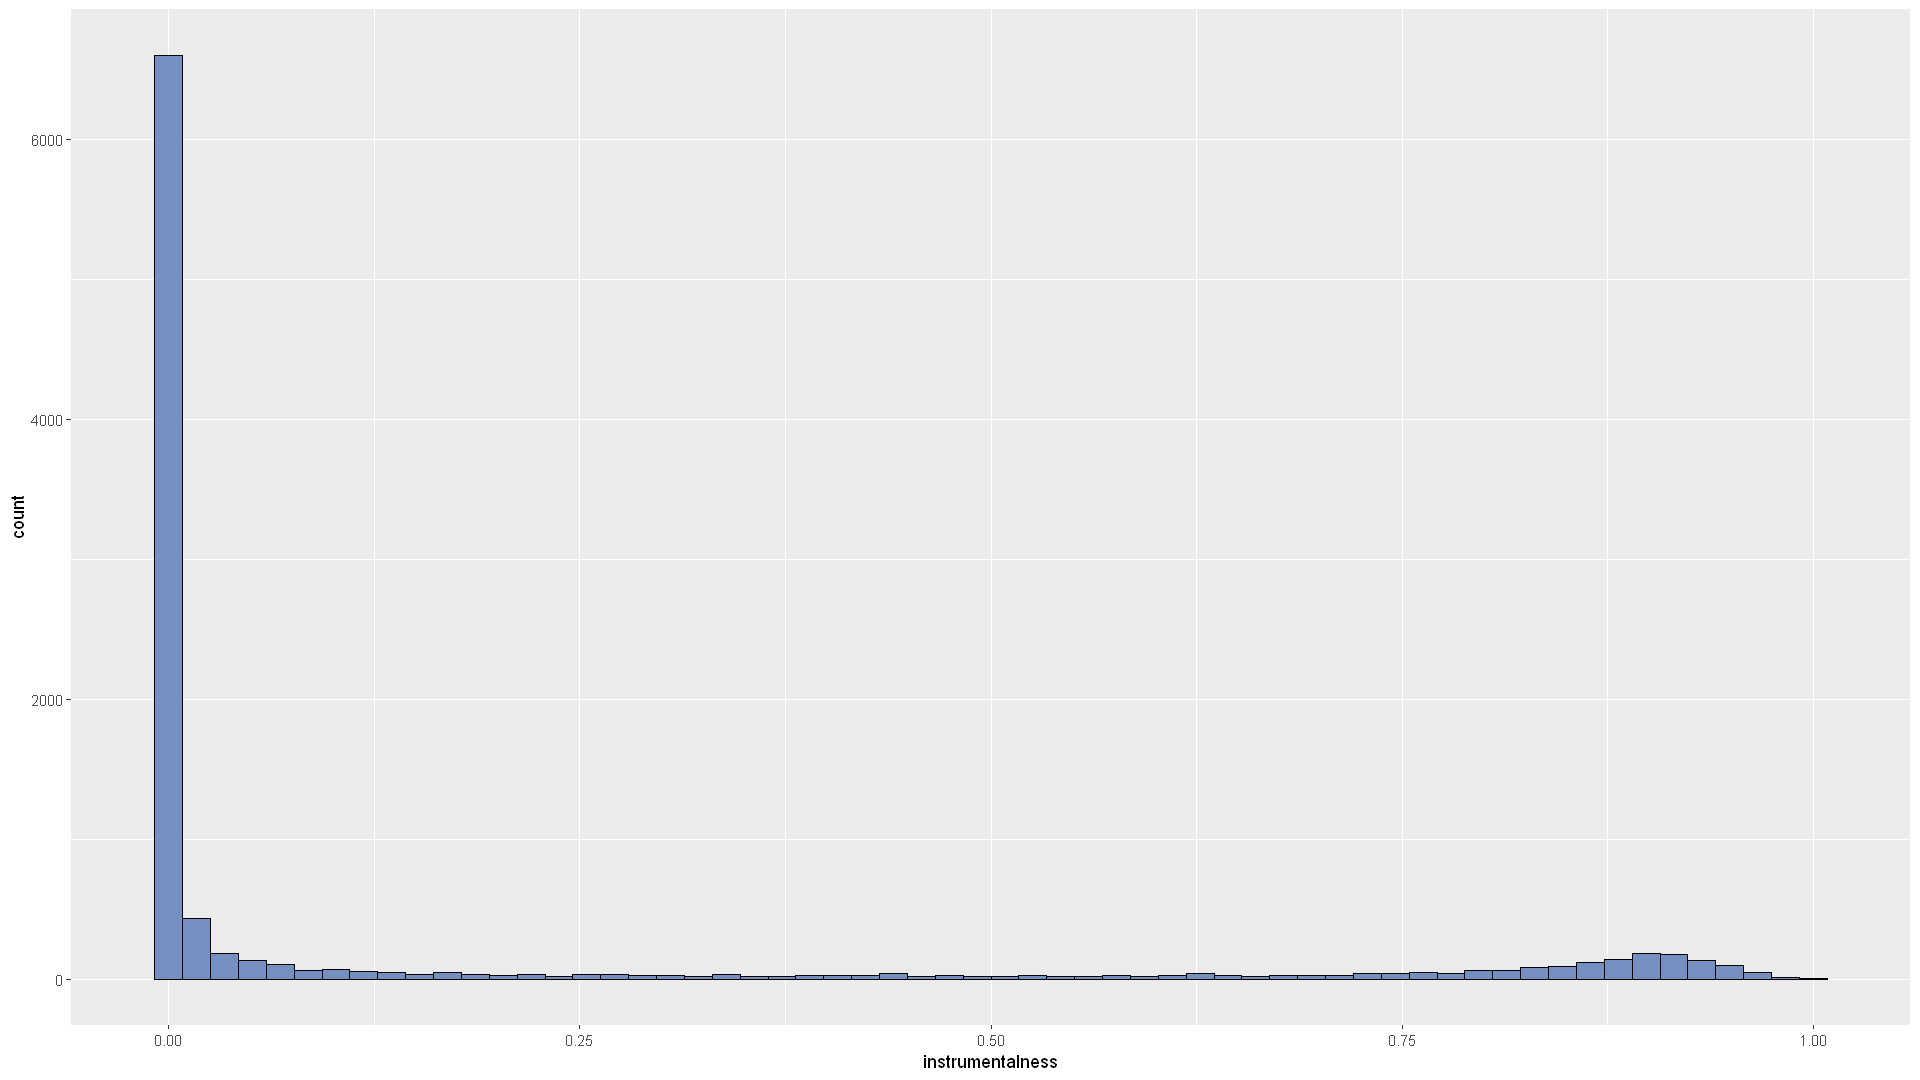

In [36]:
ggplot(data = spotify_data, aes(x = instrumentalness)) +
    geom_histogram(color = "black", fill = "#7490C0", bins = 60)

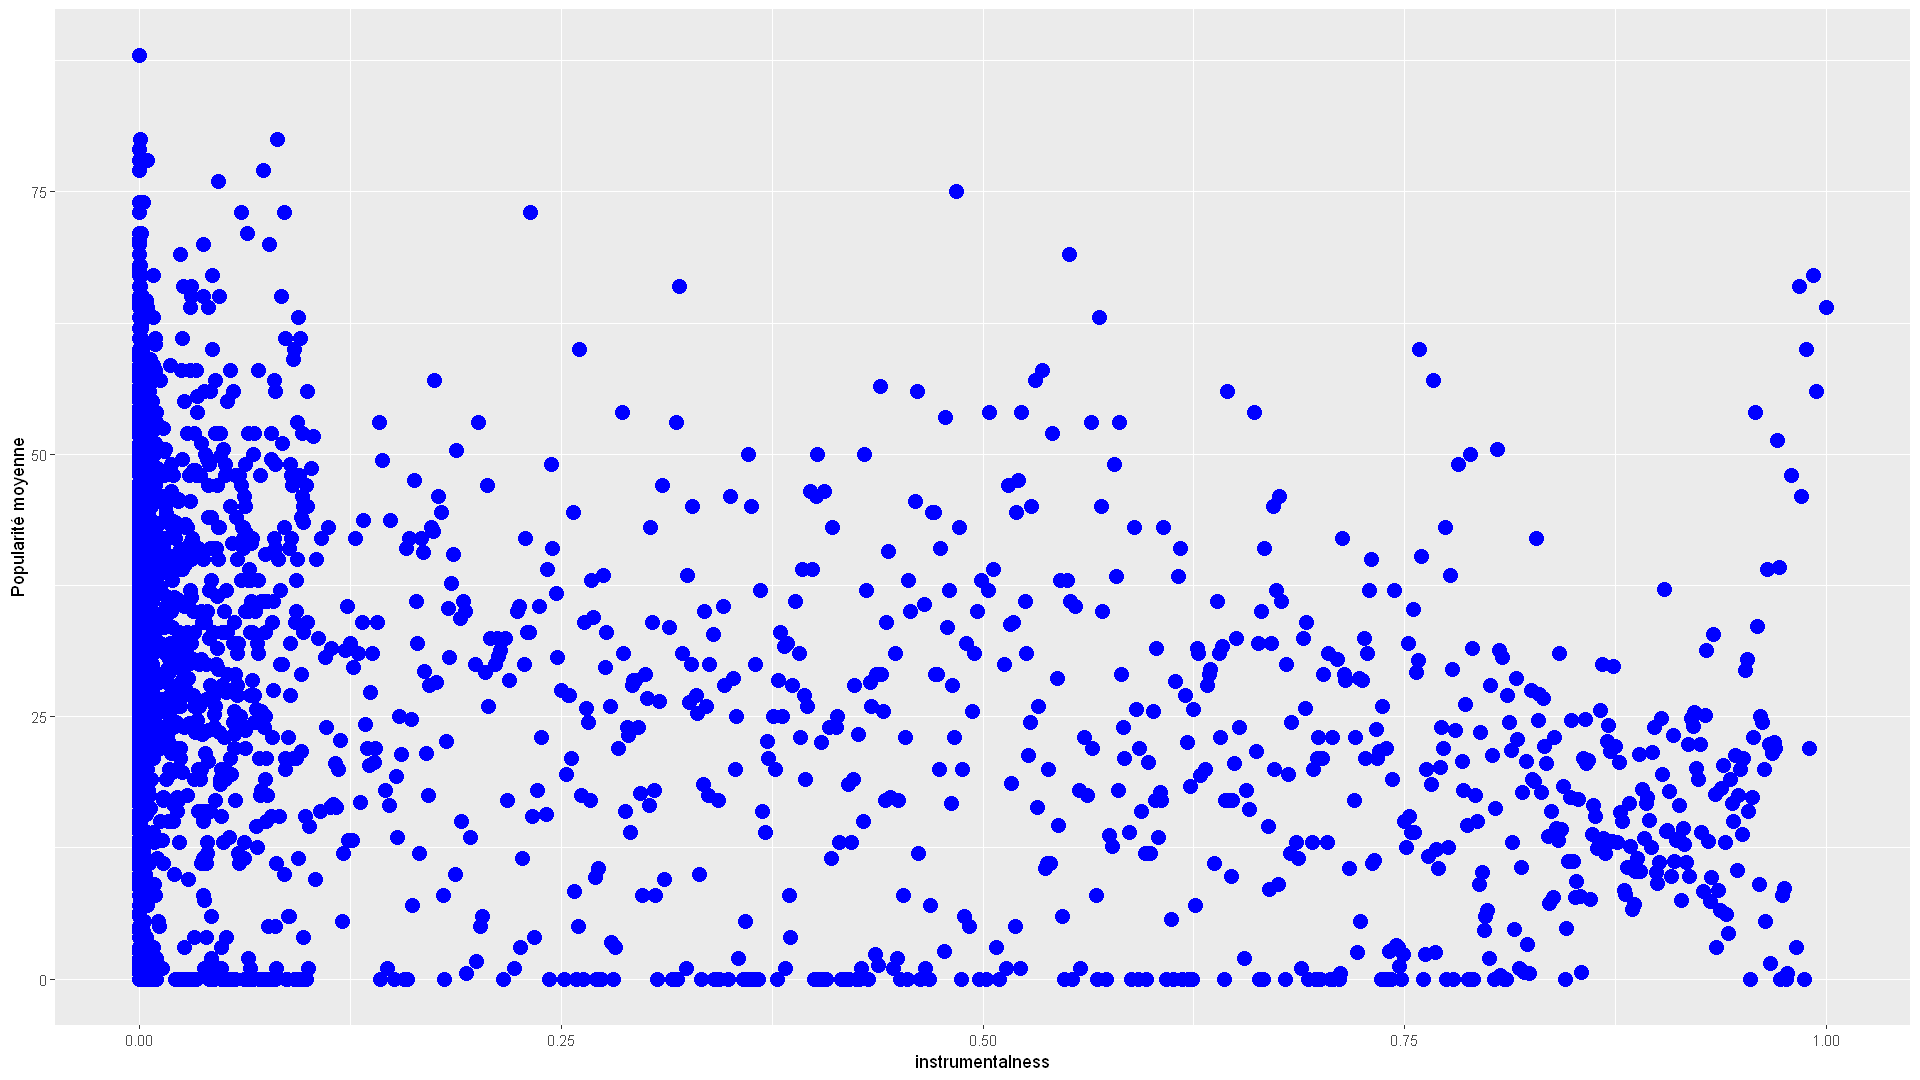

In [37]:
ax.data <- as.data.frame(spotify_data %>%
    group_by(instrumentalness) %>%
    mutate(popularity = mean(popularity)))

options(repr.plot.width = 16, repr.plot.height = 9)

ggplot(ax.data, aes(x = instrumentalness, y = popularity)) +
    geom_point(color = "blue", size = 4) +
    labs(y = "Popularité moyenne")

<b>Liveness</b>

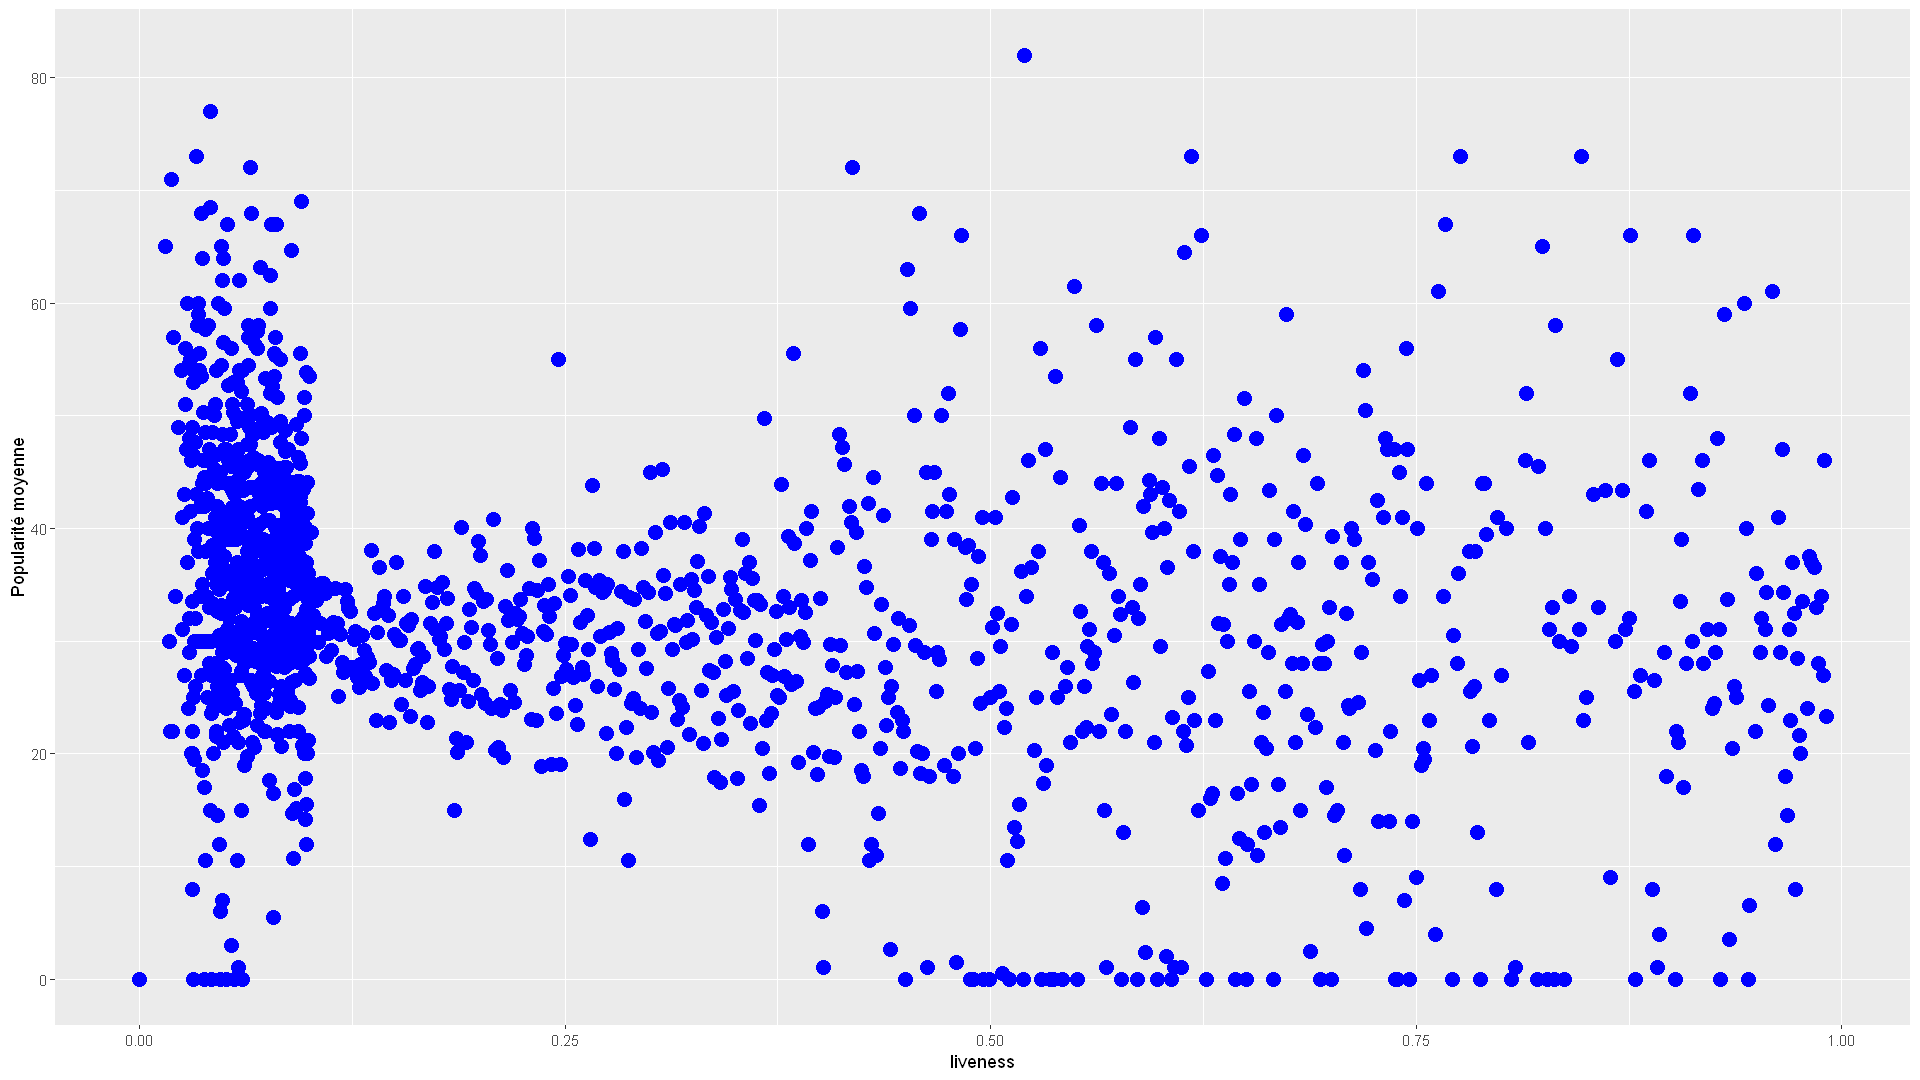

In [38]:
ax.data <- as.data.frame(short.songs %>%
    group_by(liveness) %>%
    mutate(popularity = mean(popularity)))

ggplot(ax.data, aes(x = liveness, y = popularity)) +
    geom_point(color = "blue", size = 4) +
    labs(y = "Popularité moyenne")

<b>Popularity</b> (variable à prédire)

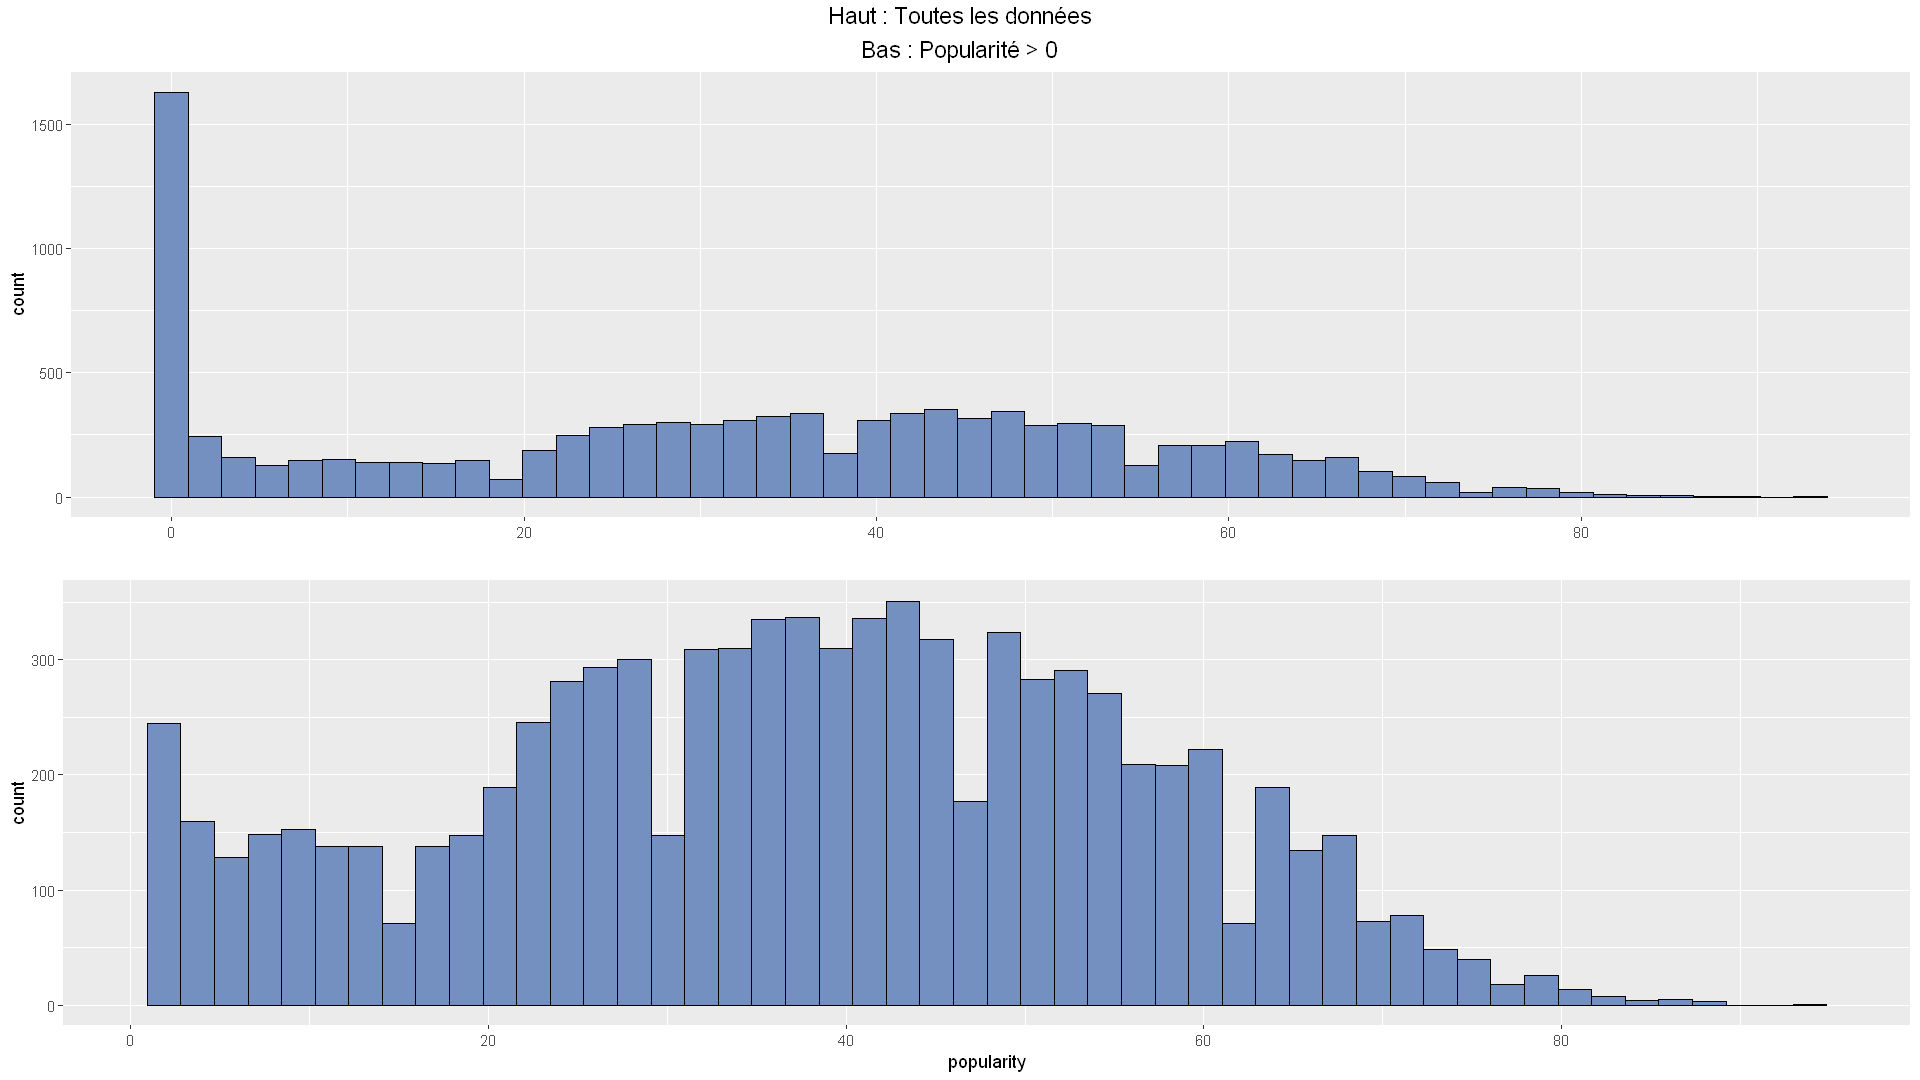

In [39]:
p1 <- ggplot(spotify_data, aes(x = popularity)) +
        geom_histogram(color = "black", fill = "#7490C0", bins = 50) +
        scale_x_continuous(breaks = seq(0, 100, 20)) +
        labs(x = "")

p2 <- ggplot(spotify_data[spotify_data$popularity > 0, ], aes(x = popularity)) +
        geom_histogram(color = "black", fill = "#7490C0", bins = 50) +
        scale_x_continuous(breaks = seq(0, 100, 20))

grid.arrange(p1, p2, nrow = 2, heights=c(20, 20),
             top = textGrob(
                 "Haut : Toutes les données\nBas : Popularité > 0",
                 gp = gpar(fontsize = 14)))

In [40]:
dim(spotify_data[spotify_data$popularity == 0, ])
summary(spotify_data$popularity)

[1] 1628   15

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   11.00   33.00   31.56   48.25   93.00 

On voit qu'il y a un nombre important de chansons ayant 0 comme popularité. En effet ces chansons sont proches de l'extraction de la base des données et donc leur popularité n'avait pas encore été déterminée.

De plus, la valeur maximale de popularité est 93 et 50% des valeurs se trouvent entre 11 et 48. Ces éléments poseront des problèmes en termes de régression.

<b>Year</b>

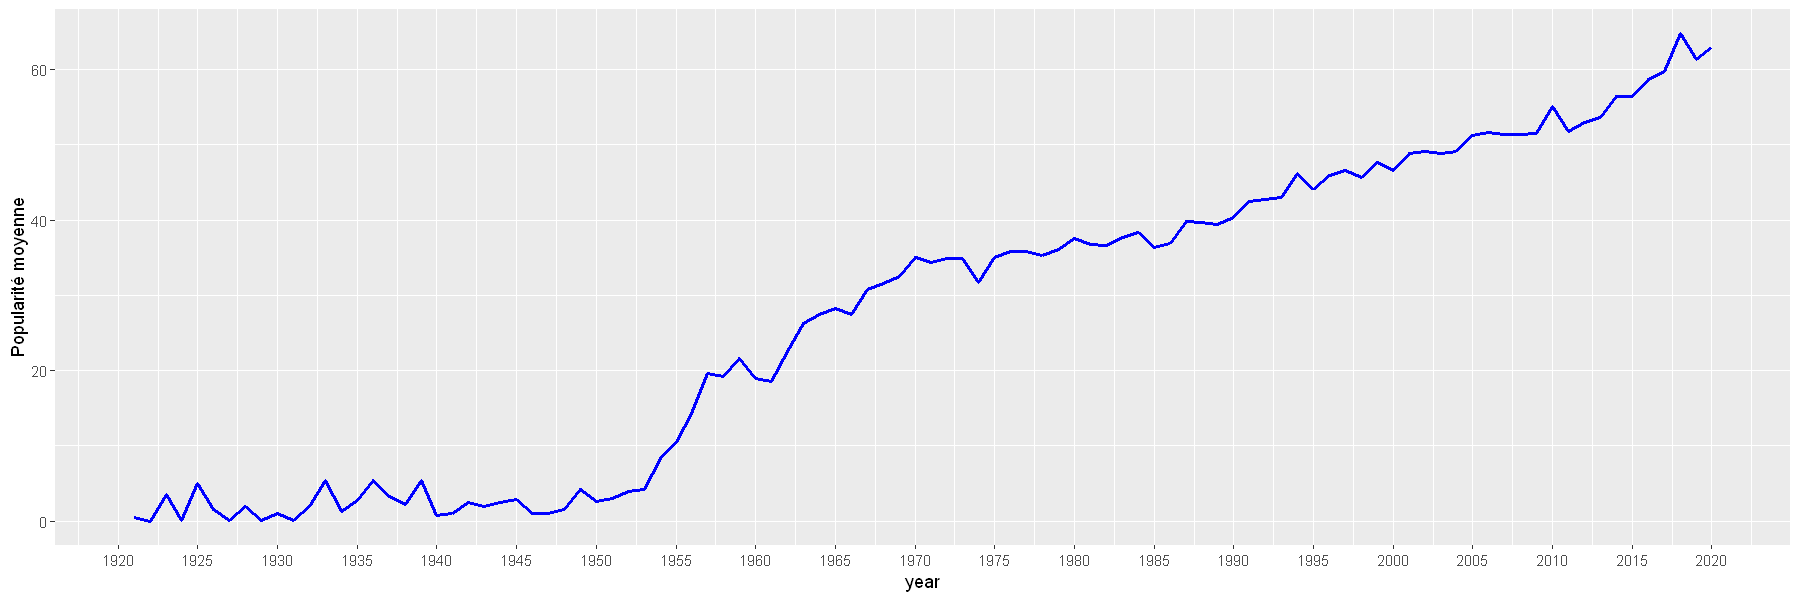

In [41]:
ax.data <- as.data.frame(spotify_data %>%
    group_by(year) %>%
    mutate(popularity = mean(popularity)))

options(repr.plot.width = 15, repr.plot.height = 5)

ggplot(data = ax.data, aes(x = year, y = popularity)) +
    geom_line(colour = "blue", size = 1) +
    scale_x_continuous(breaks = seq(1920, 2020, 5)) +
    labs(y = "Popularité moyenne")

<b>Tempo</b>

Loading required package: wrapr


Attaching package: 'wrapr'


The following object is masked from 'package:dplyr':

    coalesce




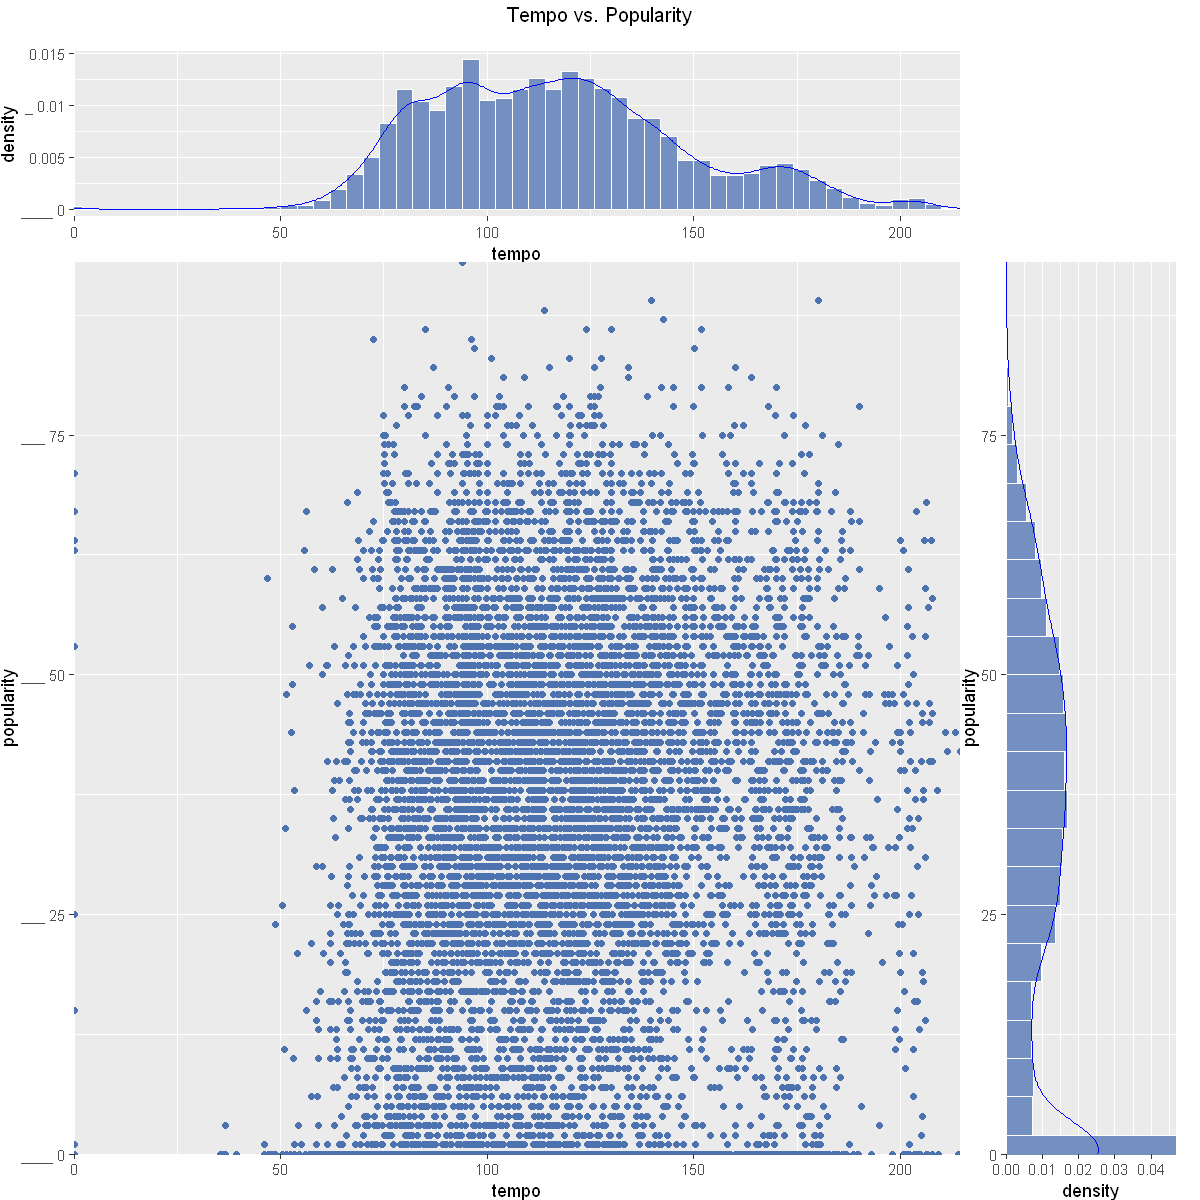

In [42]:
library(WVPlots)

options(repr.plot.width = 10, repr.plot.height = 10)

ScatterHist(spotify_data, "tempo", "popularity", title = "Tempo vs. Popularity",
            minimal_labels = FALSE, smoothmethod = "none", binwidth_x = 4,
            binwidth_y = 4, point_alpha = 1, point_color = "#4C72B0",
            hist_color = "#7490C0")

In [43]:
dim(spotify_data[spotify_data$tempo == 0, ])

[1] 13 15

On voit qu'il y a 13 chansons pour lesquelles `tempo` vaut 0 ce qui n'est pas possible.

In [44]:
corrected.tempo <- spotify_data[spotify_data$tempo > 0, ]$tempo
summary(corrected.tempo)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  35.37   93.69  114.56  117.02  135.48  214.42 

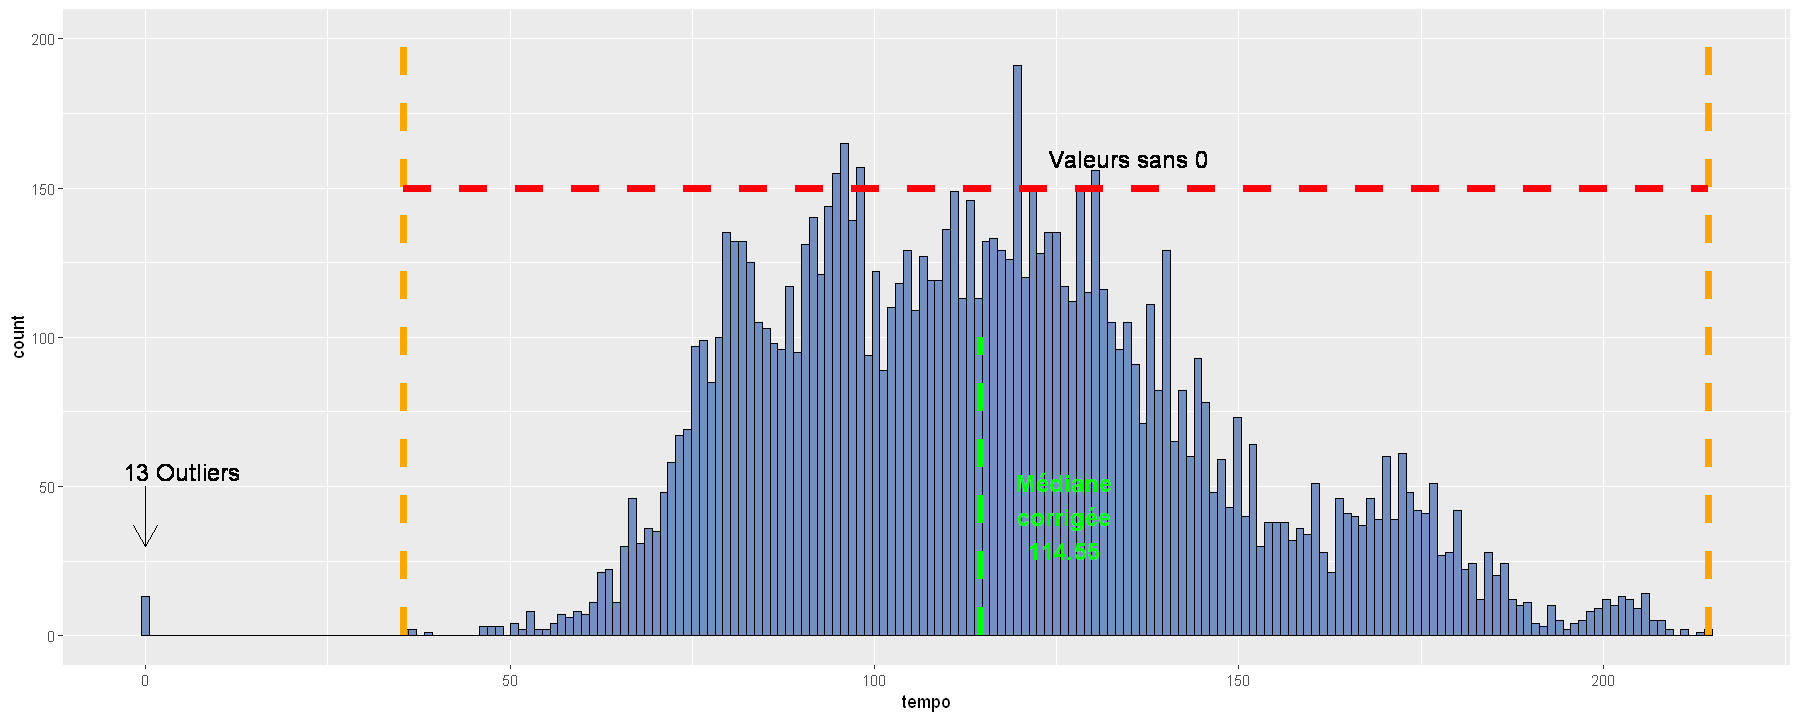

In [45]:
options(repr.plot.width = 15, repr.plot.height = 6)

ggplot(data = spotify_data, aes(x = tempo)) +
    geom_histogram(color = "black", fill = "#7490C0", bins = 200) +
    geom_text(x = 5, y = 55, label = "13 Outliers", size = 5) +
    geom_text(x = 135, y = 160, label = "Valeurs sans 0", size = 5) +
    annotate("text", x = 126, y = 40, label = "Médiane\ncorrigée\n114.55",
             size = 5, color = "green", fontface = 2) +
    geom_segment(aes(x = 114.55, y = 0, xend = 114.55, yend = 100),
                 linetype = "dashed", color = "green", size = 2) +
    geom_segment(aes(x = 35.37, y = 0, xend = 35.37, yend = 200),
                 linetype = "dashed", color = "orange", size = 2) +
    geom_segment(aes(x = 214.42, y = 0, xend = 214.42, yend = 200),
                 linetype = "dashed", color = "orange", size = 2) +
    geom_segment(aes(x = 0, y = 50, xend = 0, yend = 30),
                 arrow = arrow(length = unit(0.5, "cm"))) +
    geom_segment(aes(x = 35.37, y = 150, xend = 214.42, yend = 150),
                 linetype = "dashed", color = "red", size = 2)

On replace les valeurs où `tempo` = 0 par la médiane dans la colonne.

In [46]:
median <- median(spotify_data[spotify_data$tempo > 0, ]$tempo)
median

dat <- replace(spotify_data$tempo, spotify_data$tempo == 0, median)
spotify_data$tempo <- dat
summary(spotify_data$tempo)

[1] 114.555

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  35.37   93.71  114.56  117.01  135.47  214.42 

<b>Prétraitement de variables :</b>

On normalise la variable `danceability` vu sa ressemblance à une loi gaussienne puis on la supprime :

In [47]:
spotify_data <- spotify_data %>%
    mutate(dance_norm = (danceability - mean(danceability)) / sd(danceability),
           danceability = NULL)

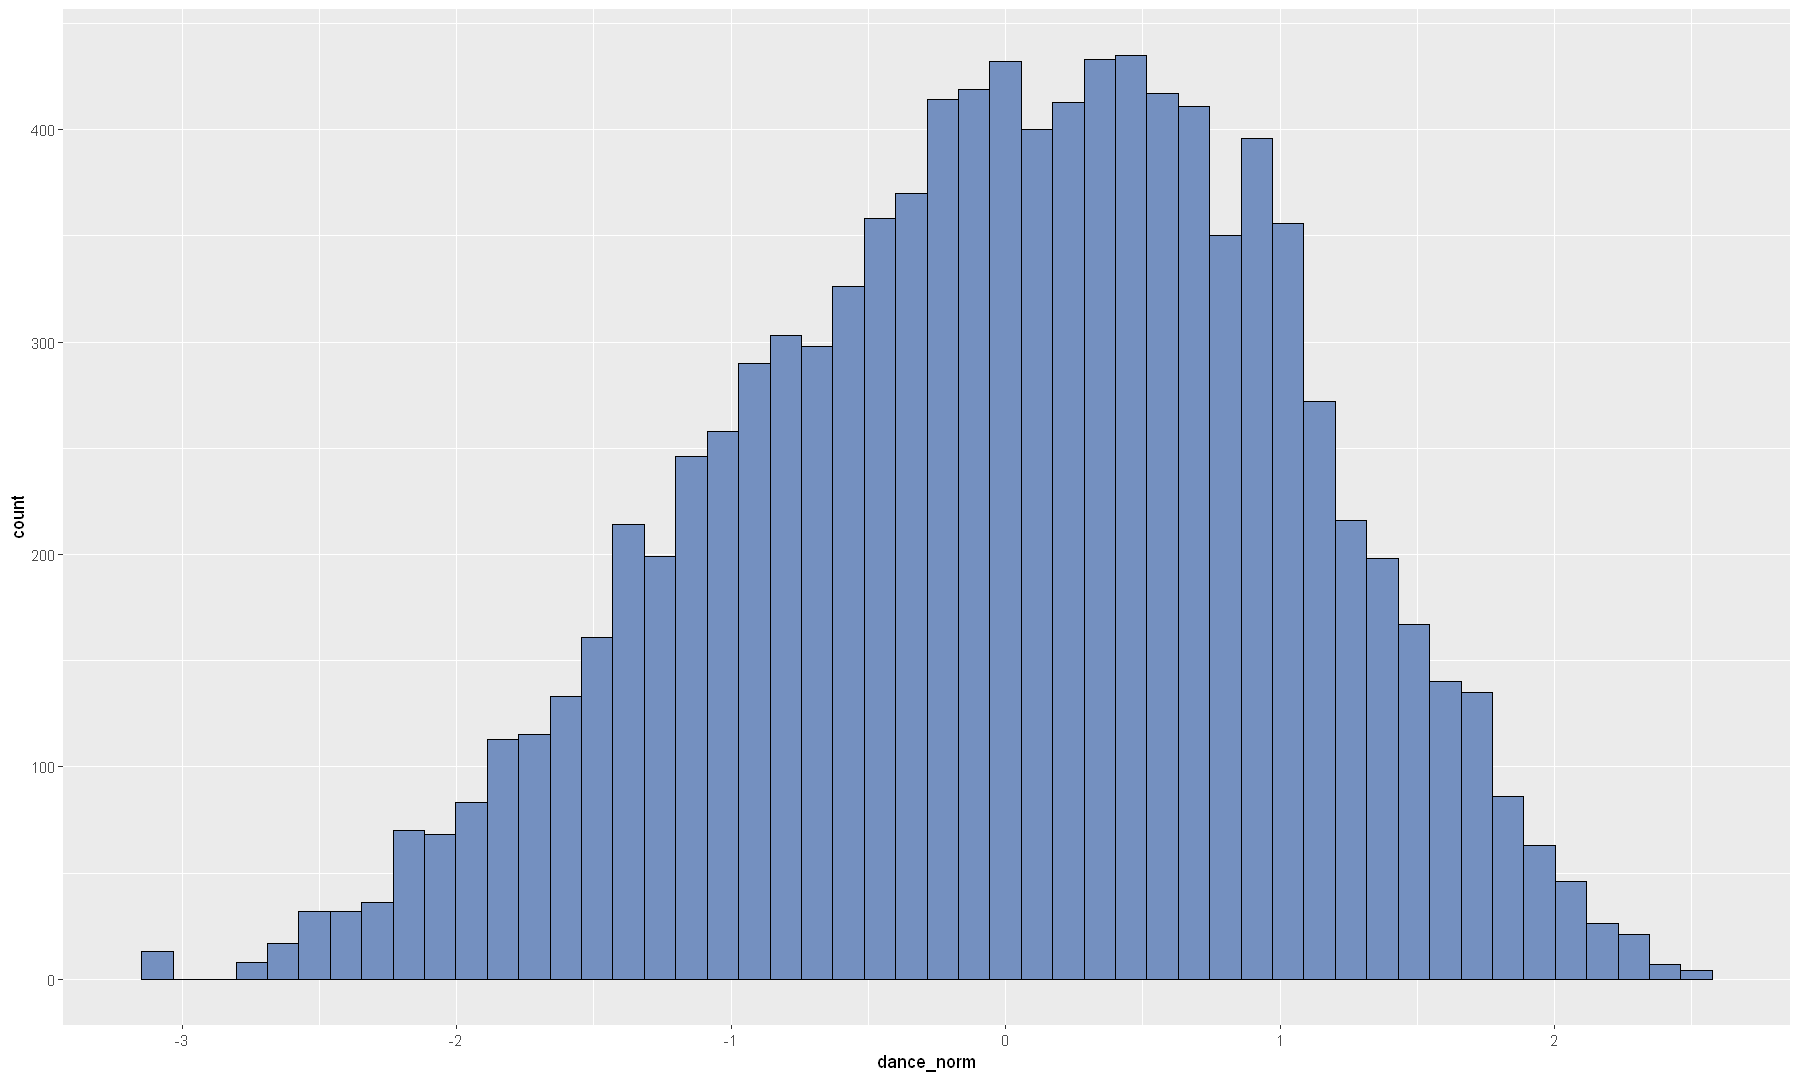

In [48]:
options(repr.plot.width = 15, repr.plot.height = 9)

ggplot(data = spotify_data, aes(x = dance_norm)) +
    geom_histogram(color = "black", fill = "#7490C0", bins = 50)

In [49]:
colnames(spotify_data)

[1] "valence"          "year"             "acousticness"     "duration"        
 [5] "energy"           "instrumentalness" "key"              "liveness"        
 [9] "loudness"         "mode"             "popularity"       "speechiness"     
[13] "tempo"            "pop.class"        "dance_norm"

In [50]:
# options(repr.plot.width = 20, repr.plot.height = 20)
# pairs(~., data = data.quant, col = mode)

In [51]:
# options(repr.plot.width = 20, repr.plot.height = 20)
# pairs(~., data = data.quant, col = key)

# ACP

In [52]:
library(factoextra)
library(FactoMineR)

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [53]:
data.quant <- spotify_data[, -c(7, 10, 11, 14)]
colnames(data.quant)

[1] "valence"          "year"             "acousticness"     "duration"        
 [5] "energy"           "instrumentalness" "liveness"         "loudness"        
 [9] "speechiness"      "tempo"            "dance_norm"

In [54]:
data.pca <- PCA(data.quant, scale.unit = T, graph = F, ncp = 11)

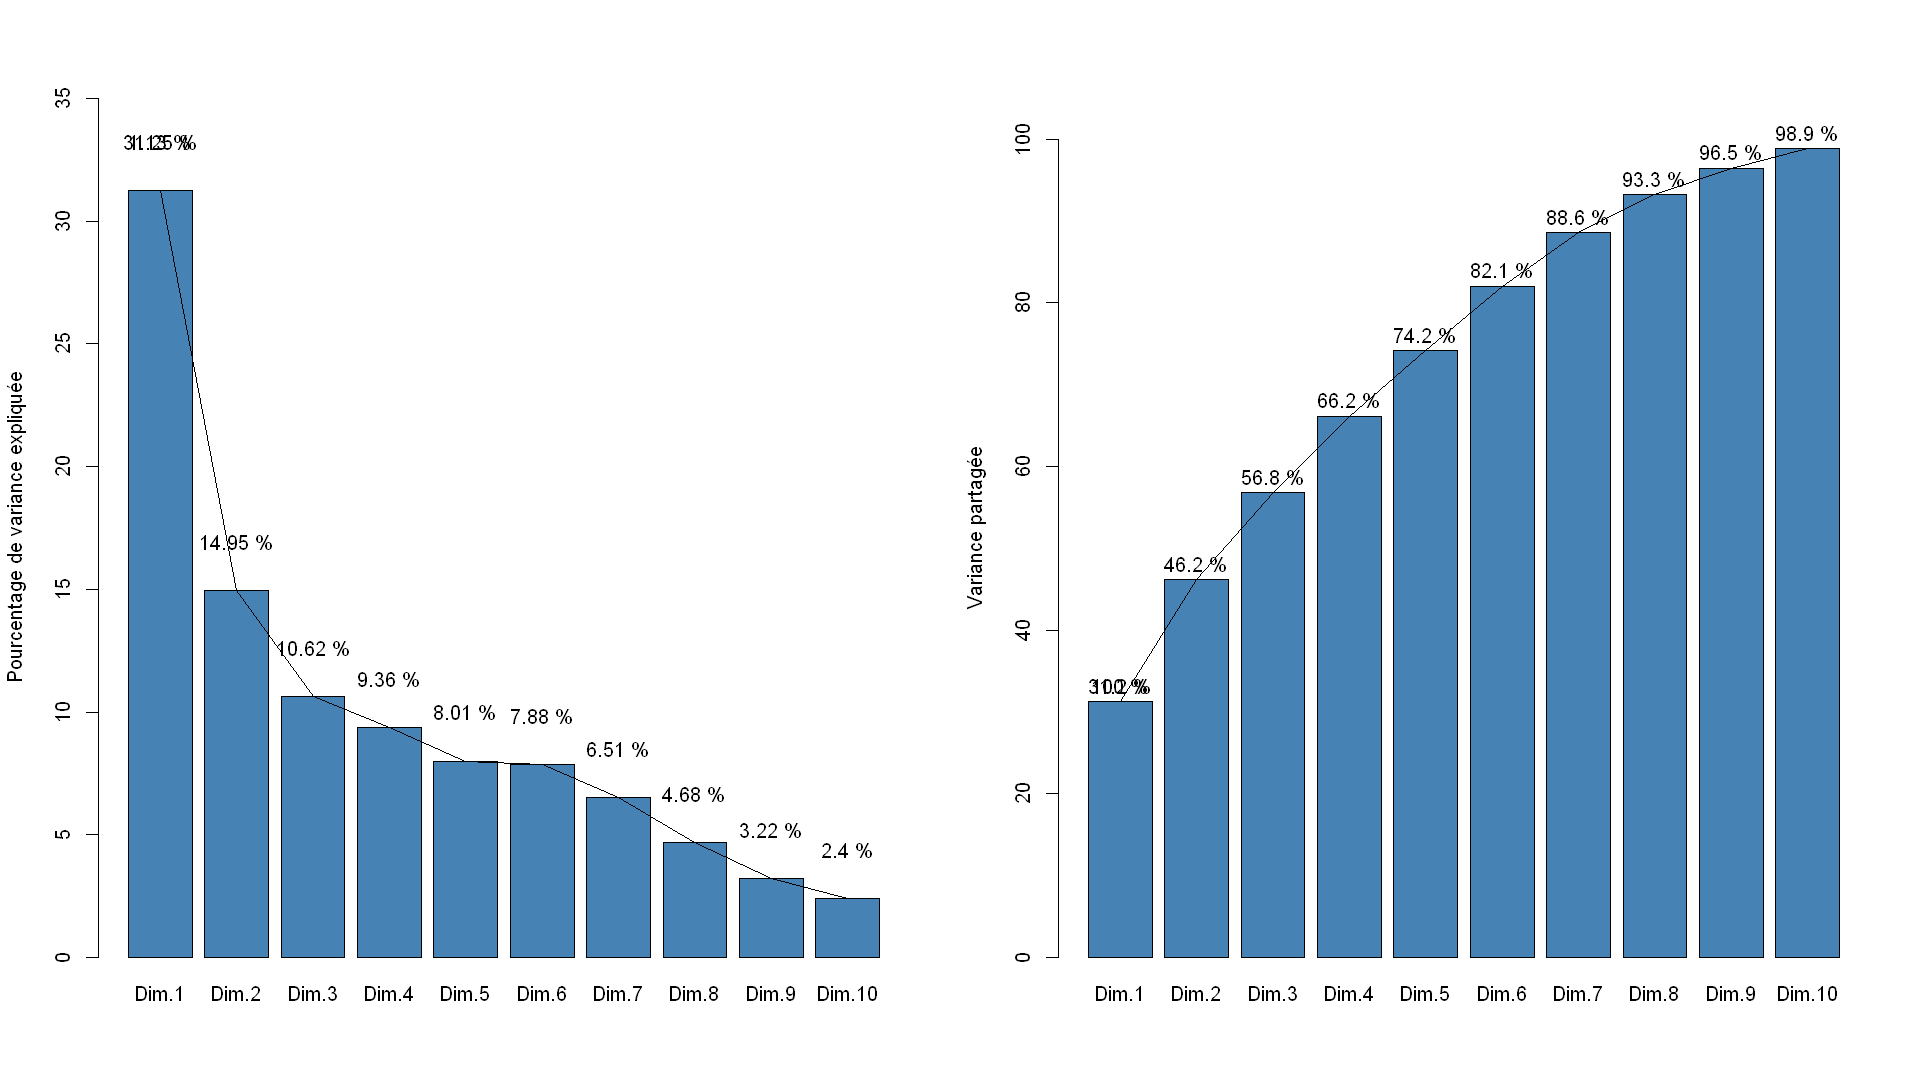

In [55]:
eig.val <- get_eig(data.pca)

options(repr.plot.width = 16, repr.plot.height = 9)
par(mfrow = c(1, 2))

bp1 <- barplot(eig.val[1:10, 2], ylab = "Pourcentage de variance expliquée",
               ylim = c(0, 35), col = "#4682B4")
text(bp1, eig.val[1:10, 2] + 2, labels = paste(round(eig.val[1:10, 2], 2), "%"))
lines(bp1, eig.val[1:10, 2])

bp2 <- barplot(eig.val[1:10, 3], ylab = "Variance partagée",
               ylim = c(0, 105), col = "#4682B4")
text(bp2, eig.val[1:10, 3] + 2, labels = paste(round(eig.val[1:10, 3], 1), "%"))
lines(bp2, eig.val[1:10, 3])

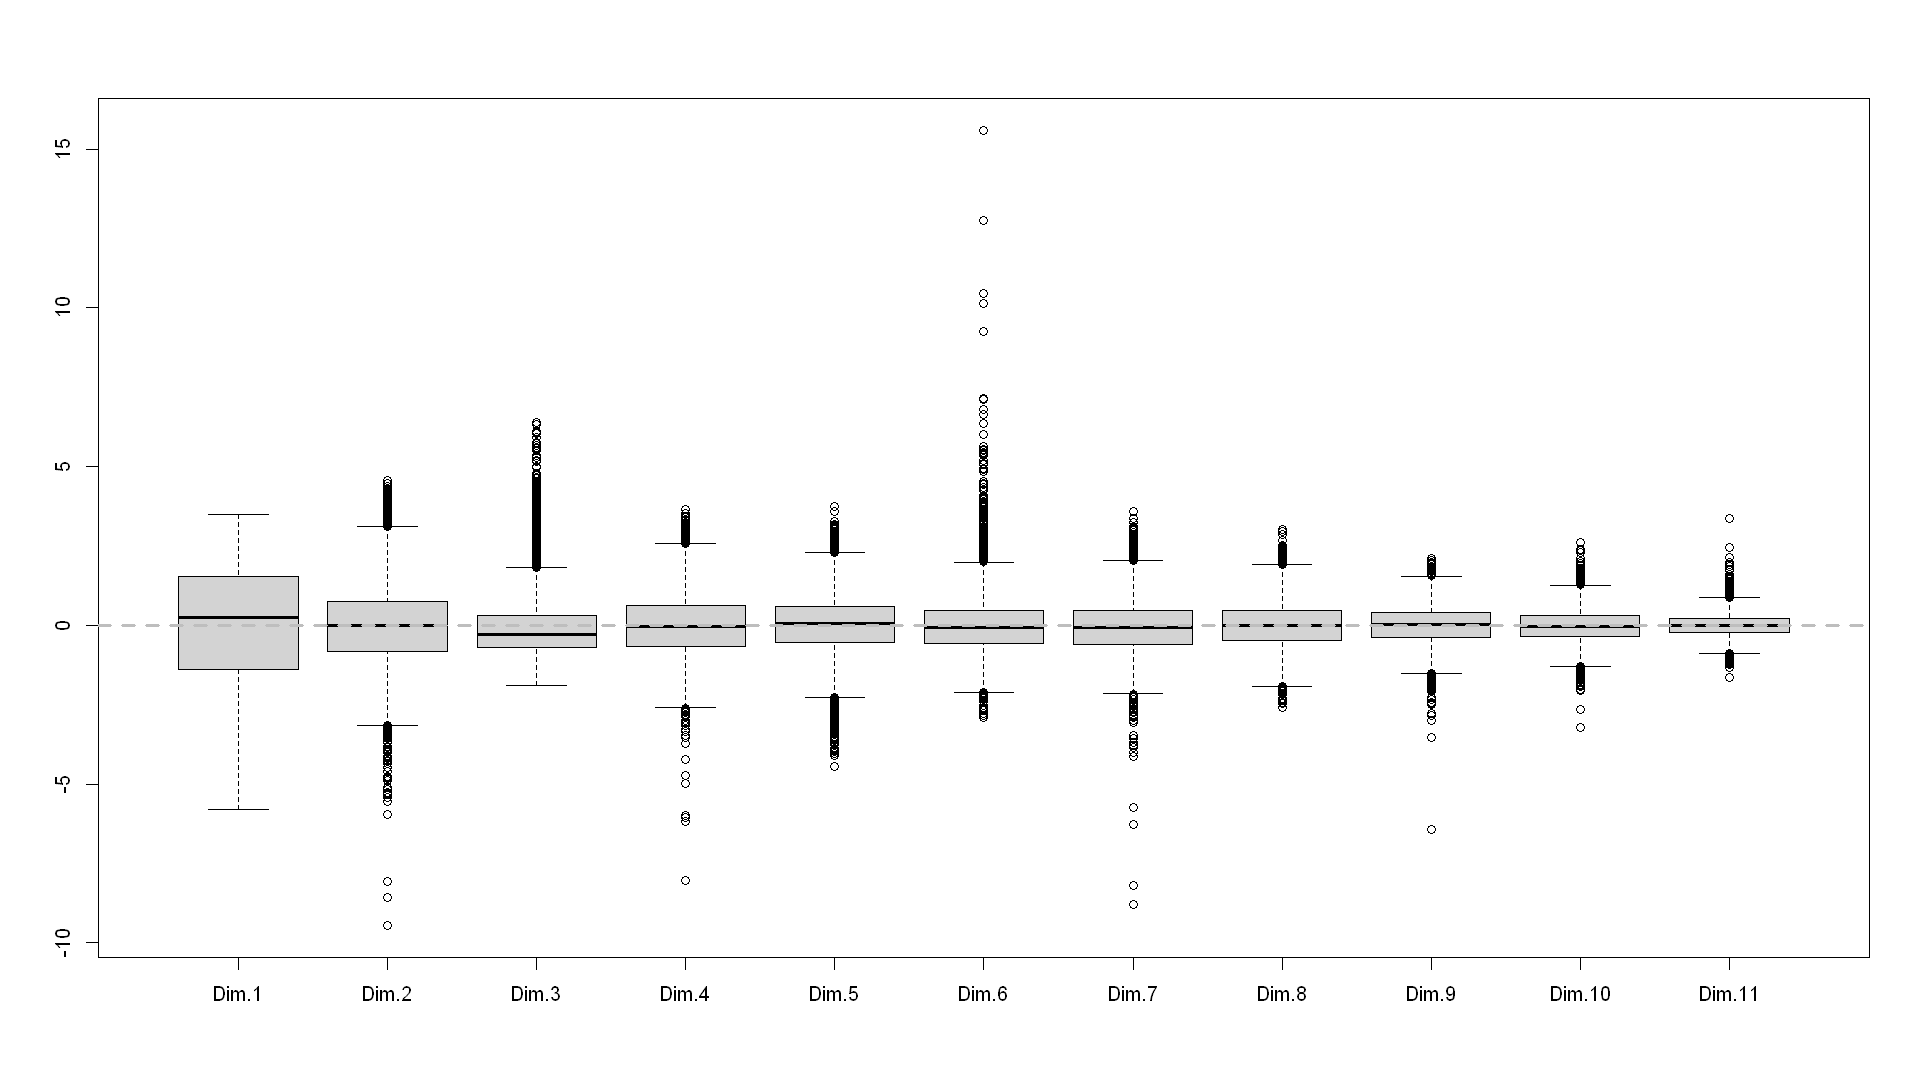

In [56]:
boxplot(data.pca$ind$coord)
abline(h = 0, col = "grey", lty = "dashed", lwd = 3)

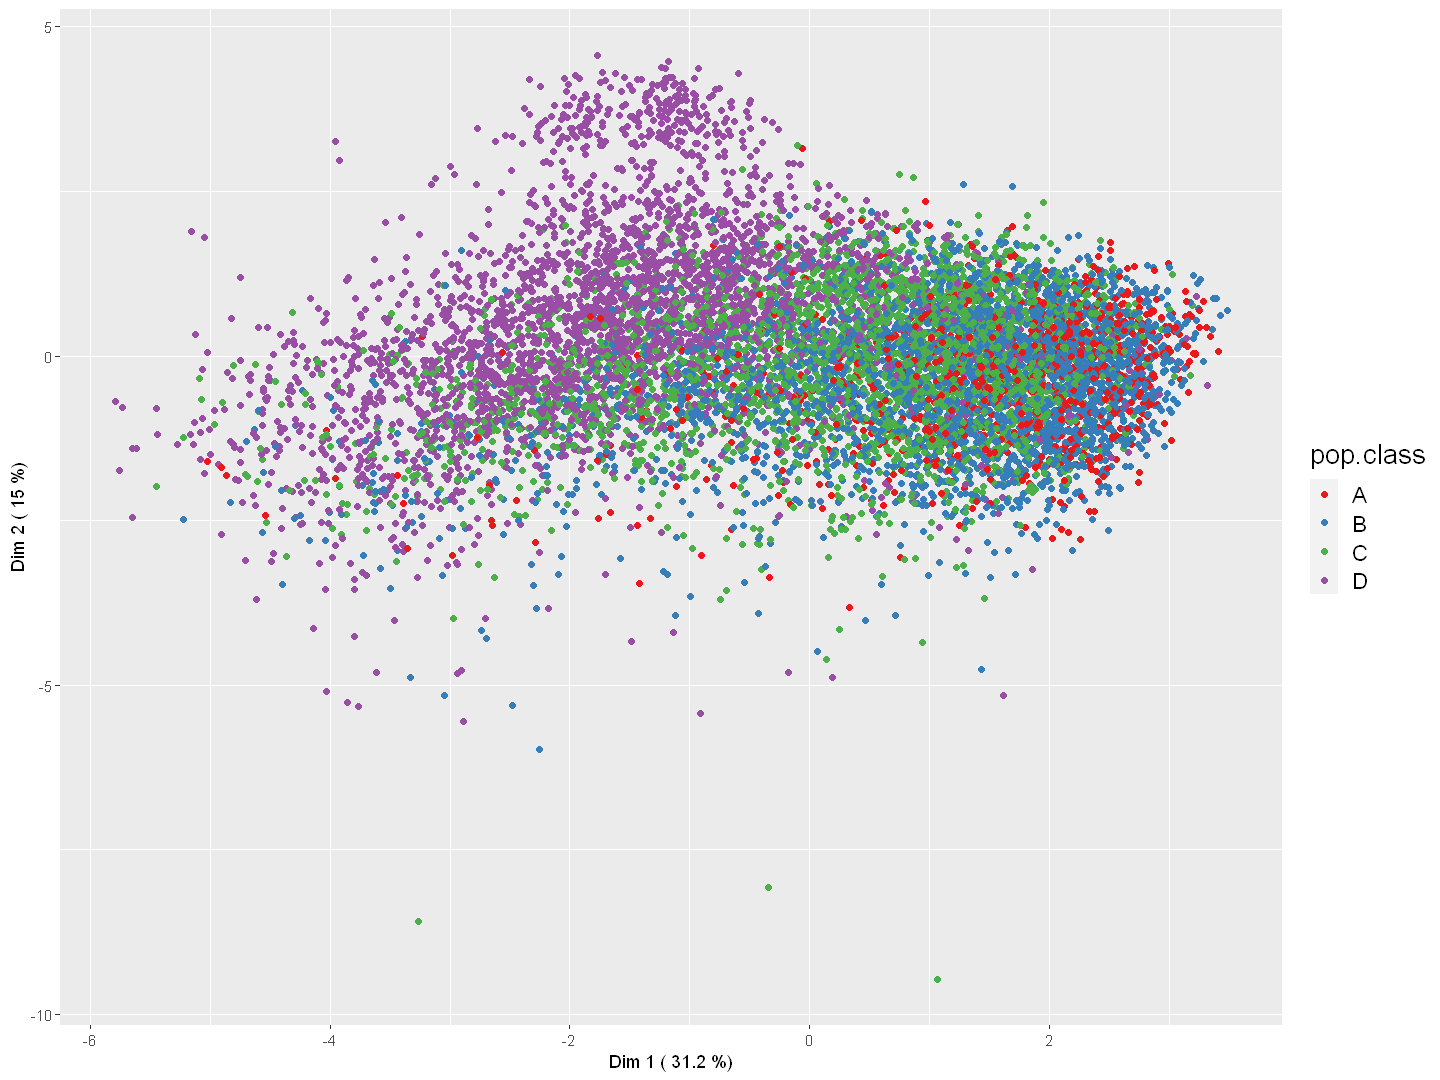

In [57]:
inds <- as.data.frame(data.pca$ind$coord)

options(repr.plot.width = 12, repr.plot.height = 9)

ggplot(inds, aes(inds[, 1], inds[, 2], colour = pop.class)) +
    geom_point() +
    labs(x = paste("Dim 1 (", round(eig.val[1, 2], 1), "%)"),
         y = paste("Dim 2 (", round(eig.val[2, 2], 1), "%)")) +
    scale_color_brewer(palette="Set1") +
    theme(legend.title = element_text(size = 16),
          legend.text = element_text(size = 13))

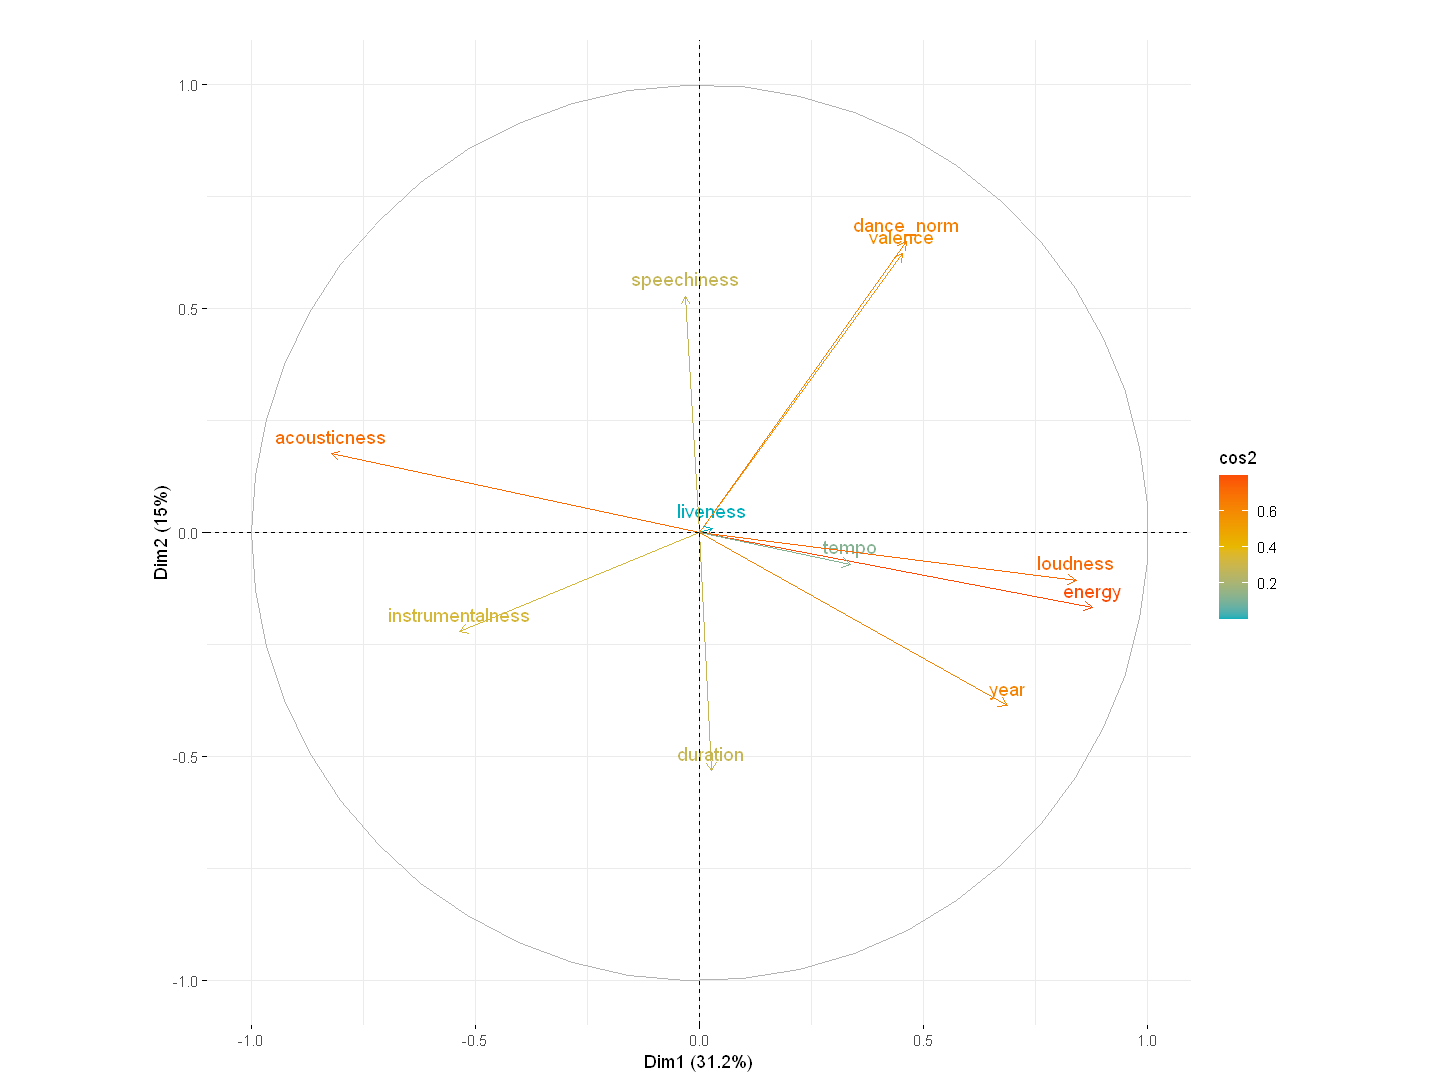

In [58]:
fviz_pca_var(data.pca, col.var = "cos2",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             title = "")

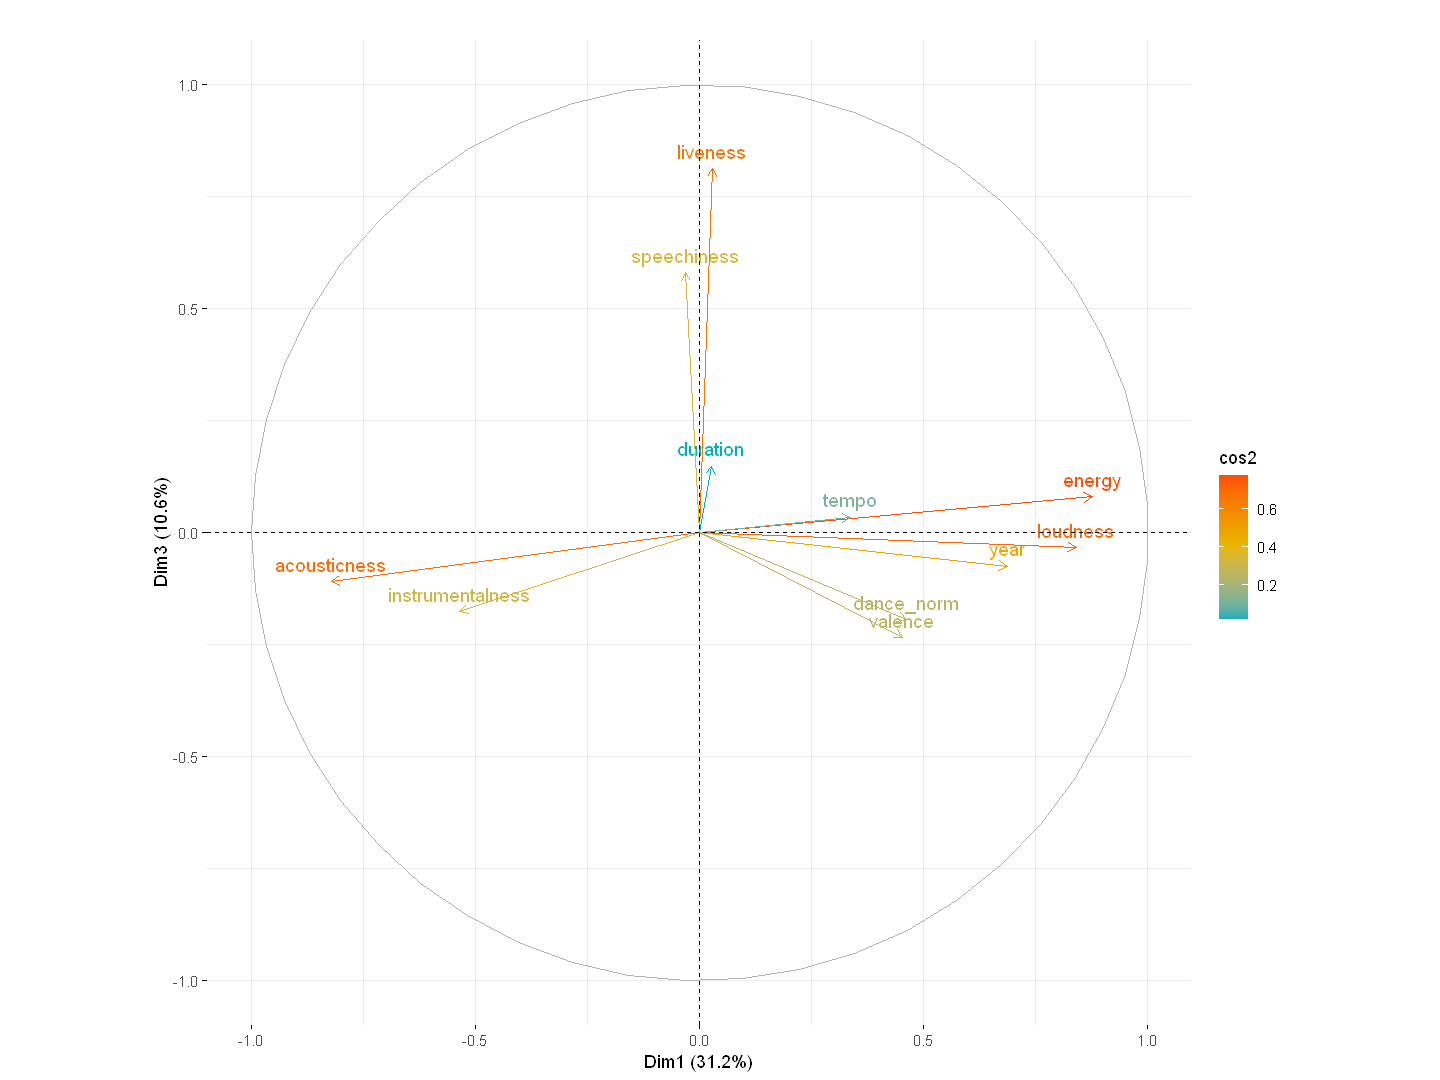

In [59]:
fviz_pca_var(data.pca, axes = c(1, 3), col.var = "cos2",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             title = "")

# Préparation des données

In [60]:
spotify.pop.class <- spotify_data$pop.class
spotify.key <- spotify_data$key

In [61]:
spotify.pop.class.encoded <- as.numeric(spotify.pop.class) - 1
spotify.pop.class.encoded[1:15]

[1] 2 1 0 2 2 0 1 1 0 1 3 1 2 3 3

In [62]:
spotify.key.encoded <- as.numeric(spotify.key) - 1
spotify.key.encoded[1:15]

[1]  2  1  2  2 10  5 10  7  5  9  3  2  9  1  8

In [63]:
spotify.pop.class[1:15]
spotify.key[1:15]

[1] C B A C C A B B A B D B C D D
Levels: A < B < C < D

[1] B  Ab B  B  G  D  G  E  D  F  Bb B  F  Ab Eb
Levels: A Ab B Bb C D Db E Eb F G Gb

Pour la classe de popularité, on a la correspondance :
* 'A' -> 0
* 'B' -> 1
etc.

Puis pour la clé :
* 'A' -> 0
* 'Ab' -> 1<br>
$\dots$
* 'Gb' -> 11

In [64]:
spotify_data$pop.class <- spotify.pop.class.encoded
spotify_data$key <- spotify.key.encoded

spotify_data$pop.class <- as.factor(spotify_data$pop.class) # pour la classification on reprend des facteurs

In [65]:
head(spotify_data)

,valence,year,acousticness,duration,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,pop.class,dance_norm
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>,<dbl>,<dbl>,<fct>,<dbl>
161704,0.647,1975,0.4490,4.980667,0.827,7.88e-03,2,0.466,-7.604,1,25,0.3990,170.475,2,-0.9309645
168077,0.150,2008,0.8990,3.946667,0.169,1.12e-05,1,0.136,-11.332,1,42,0.0553,107.477,1,-0.1817845
35922,0.423,2007,0.0185,5.018217,0.878,8.39e-02,2,0.276,-5.576,0,65,0.0377,150.093,0,-0.3974575
135823,0.302,1995,0.0384,2.370000,0.980,5.52e-01,2,0.237,-3.154,1,36,0.0721,172.566,2,-2.0660858
165395,0.828,1994,0.5310,3.130000,0.625,7.73e-06,10,0.348,-11.963,0,38,0.0639,97.831,2,0.9363100
38184,0.489,2018,0.3710,5.403150,0.694,0.00e+00,5,0.109,-4.393,1,68,0.1690,122.080,0,1.7933266


In [66]:
y.class <- spotify_data$pop.class
y.reg <- spotify_data$popularity

print(y.class[1:15])
print(y.reg[1:15])

 [1] 2 1 0 2 2 0 1 1 0 1 3 1 2 3 3
Levels: 0 1 2 3
 [1] 25 42 65 36 38 68 47 59 61 49 16 58 26  0  0


# Apprentissage

In [67]:
library(caret)
library(glmnet)
library(randomForest)
library(rpart)
library(e1071)
library(partykit)
library(nnet)

Loading required package: lattice

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:wrapr':

    pack, unpack


Loaded glmnet 4.1-1

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:gridExtra':

    combine


The following object is masked from 'package:ggplot2':

    margin


The following object is masked from 'package:dplyr':

    combine


Loading required package: libcoin

Loading required package: mvtnorm



In [68]:
set.seed(42)
test.ratio <- 0.25
npop <- nrow(spotify_data)
nvar <- ncol(spotify_data)
ntest <- ceiling(npop * test.ratio)
testi <- sample(1:npop, ntest)
appri <- setdiff(1:npop, testi)

## Classification

In [69]:
# construction de l'échantillon d'apprentissage
X.train <- spotify_data[appri, -11] # on supprime popularity
# construction de l'échantillon test
X.test <- spotify_data[testi, -11]

# vérification
str(X.train)
str(X.test)
# summary(X.train)

'data.frame':	7500 obs. of  14 variables:
 $ valence         : num  0.647 0.828 0.489 0.963 0.463 0.151 0.42 0.88 0.0489 0.799 ...
 $ year            : int  1975 1994 2018 2003 2001 1959 2013 1980 1952 1951 ...
 $ acousticness    : num  0.449 0.531 0.371 0.523 0.137 0.987 0.167 0.11 0.991 0.991 ...
 $ duration        : num  4.98 3.13 5.4 2.98 8.58 ...
 $ energy          : num  0.827 0.625 0.694 0.615 0.562 0.0359 0.736 0.825 0.0864 0.0857 ...
 $ instrumentalness: num  7.88e-03 7.73e-06 0.00 1.48e-06 2.90e-03 7.27e-05 8.78e-03 4.51e-02 0.00 9.49e-01 ...
 $ key             : num  2 10 5 10 9 3 2 9 1 8 ...
 $ liveness        : num  0.466 0.348 0.109 0.0794 0.0463 0.121 0.124 0.11 0.118 0.107 ...
 $ loudness        : num  -7.6 -11.96 -4.39 -8.83 -10.23 ...
 $ mode            : Factor w/ 2 levels "0","1": 2 1 2 2 1 2 1 1 2 2 ...
 $ speechiness     : num  0.399 0.0639 0.169 0.092 0.045 0.0446 0.0384 0.0317 0.0932 0.198 ...
 $ tempo           : num  170.5 97.8 122.1 100.4 156.7 ...
 $ pop.cla

In [70]:
cols <- c(7, 10, 13)
pre.proc.vals <- preProcess(X.train[, -cols], method = c("center", "scale"))

X.train.scaled <- data.frame(X.train)
X.train.scaled[, -cols] <- predict(pre.proc.vals, X.train.scaled[, -cols])

X.test.scaled <- data.frame(X.test)
X.test.scaled[, -cols] <- predict(pre.proc.vals, X.test.scaled[, -cols])

In [71]:
y.train.class <- y.class[appri]
y.test.class <- y.class[testi]

### Régression logistique

In [72]:
x.mat <- model.matrix(pop.class ~ . - 1, data = X.train.scaled)
x.mat2 <- model.matrix(pop.class ~ . - 1, data = X.test.scaled)

#### Sans pénalisation

In [73]:
class.lr.cv <- cv.glmnet(y = X.train$pop.class, x = x.mat, alpha = 0,
                         lambda = 10^c(-5, -6), family = "multinomial",
                         type.multinomial = "grouped")

class.lr.cv


Call:  cv.glmnet(x = x.mat, y = X.train$pop.class, lambda = 10^c(-5,      -6), alpha = 0, family = "multinomial", type.multinomial = "grouped") 

Measure: Multinomial Deviance 

    Lambda Index Measure      SE Nonzero
min  1e-06     2   1.474 0.01631      15
1se  1e-05     1   1.474 0.01630      15

In [74]:
paste("CV estimate of lambda :", round(class.lr.cv$lambda.1se, 3))
coef(class.lr.cv, s = "lambda.1se")

[1] "CV estimate of lambda : 0"

$`0`
15 x 1 sparse Matrix of class "dgCMatrix"
                             1
(Intercept)      -2.0308358864
valence          -0.0492290721
year              2.9177131484
acousticness     -0.1469818653
duration         -0.2261450746
energy           -0.1694391356
instrumentalness -0.2959192618
key               0.0048646787
liveness         -0.0383537801
loudness          0.1544009425
mode0             0.0041633134
mode1            -0.0005511693
speechiness      -0.2138998190
tempo            -0.0242828650
dance_norm        0.0816537294

$`1`
15 x 1 sparse Matrix of class "dgCMatrix"
                             1
(Intercept)       0.7145081964
valence           0.1089855054
year              1.5016769862
acousticness     -0.0167828916
duration          0.0930860061
energy           -0.1120689776
instrumentalness -0.0558716645
key              -0.0052823431
liveness         -0.0103517917
loudness          0.1808976618
mode0             0.0268668347
mode1            -0.0004324224
speech

In [75]:
pred.lr <- predict(class.lr.cv, newx = x.mat2, s = "lambda.min", type = "class")
table(pred.lr, y.test.class)
paste("Prediction error: ",
      round(100 * (1 - sum(diag(table(pred.lr, y.test.class)))/ntest), 1), " %", sep = "")

       y.test.class
pred.lr   0   1   2   3
      0  51  11   0   1
      1 180 496 176  14
      2  24 173 481  71
      3   1   9  85 727

[1] "Prediction error: 29.8 %"

In [76]:
pred.error.lr <- round(100 * (1 - sum(diag(table(pred.lr, y.test.class)))/ntest), 4)
pred.error.lr

[1] 29.8

#### Pénalisation Lasso

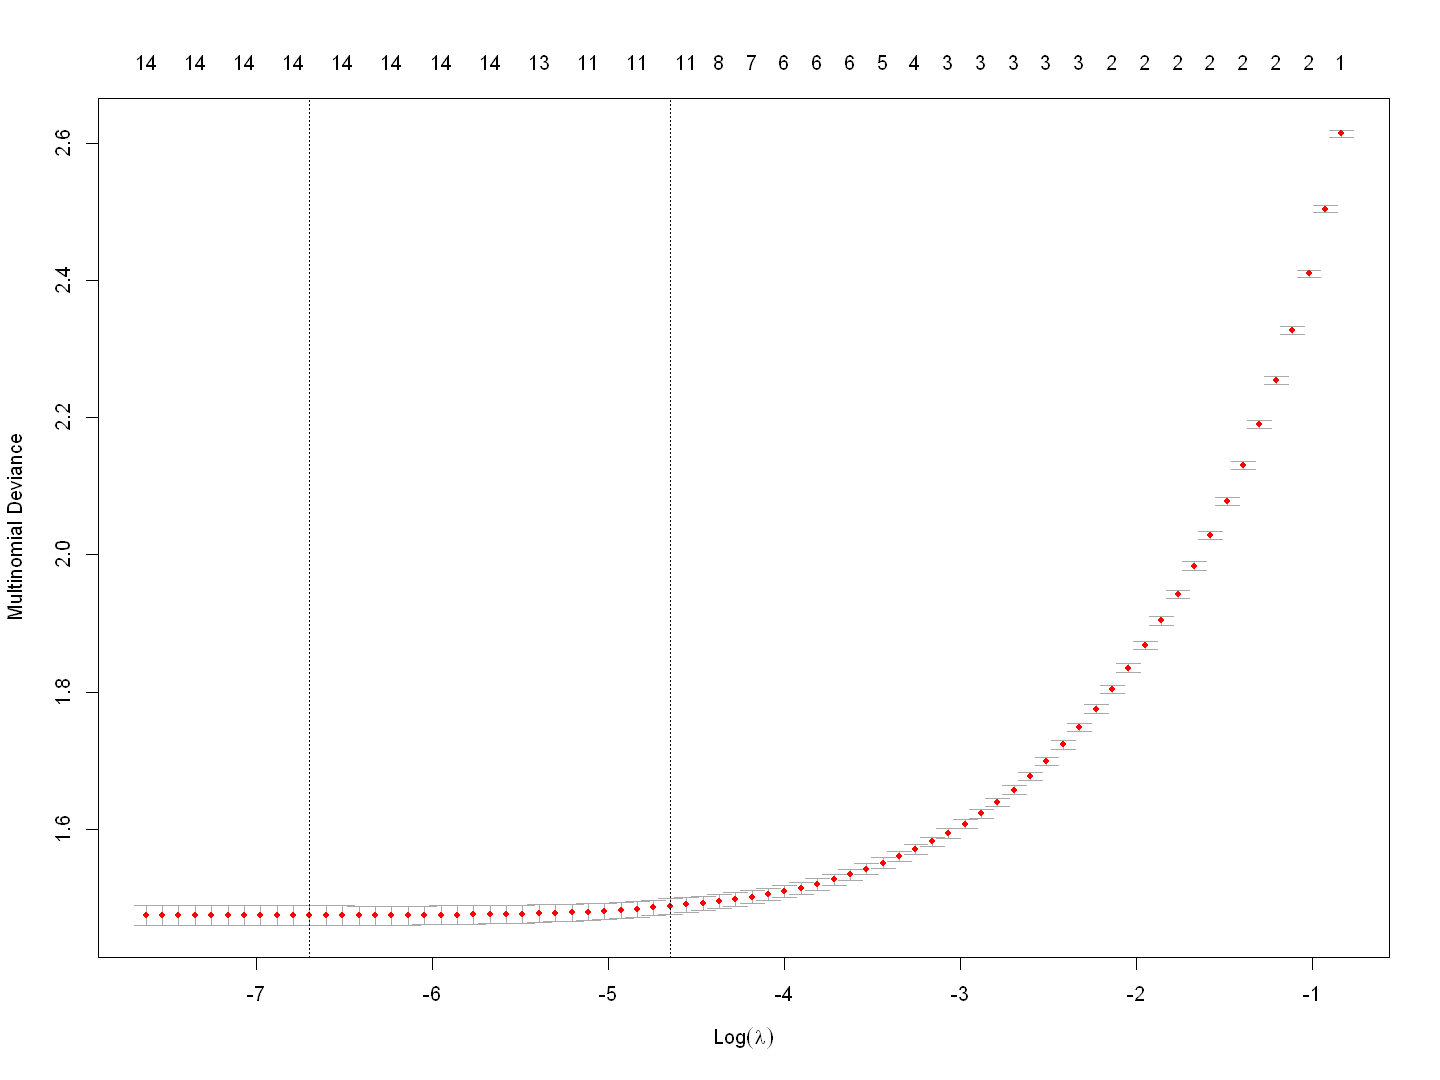

In [77]:
class.lasso.cv <- cv.glmnet(y = X.train$pop.class, x = x.mat, alpha = 1,
                            family = "multinomial", type.multinomial = "grouped")

plot(class.lasso.cv)

In [78]:
paste("CV estimate of lambda :", round(class.lasso.cv$lambda.1se, 3))
coef(class.lasso.cv, s = "lambda.1se")

[1] "CV estimate of lambda : 0.01"

$`0`
15 x 1 sparse Matrix of class "dgCMatrix"
                            1
(Intercept)      -1.724992637
valence          -0.006000925
year              2.504022497
acousticness     -0.050743656
duration         -0.021394392
energy           -0.003910253
instrumentalness -0.135163461
key               .          
liveness         -0.012478887
loudness          0.060179531
mode0             .          
mode1             .          
speechiness      -0.019382495
tempo             .          
dance_norm        0.021545289

$`1`
15 x 1 sparse Matrix of class "dgCMatrix"
                             1
(Intercept)       0.6017840284
valence           0.0098014419
year              1.2969307834
acousticness     -0.0117035397
duration          0.0168316603
energy           -0.0002675966
instrumentalness -0.0502093654
key               .           
liveness         -0.0104258336
loudness          0.0802092139
mode0             .           
mode1             .           
speechiness      -0.13

In [79]:
pred.lr.lasso <- predict(class.lasso.cv, newx = x.mat2, s = "lambda.min", type = "class")
table(pred.lr.lasso, y.test.class)
paste("Prediction error: ",
      round(100 * (1 - sum(diag(table(pred.lr.lasso, y.test.class)))/ntest), 1), " %", sep = "")

             y.test.class
pred.lr.lasso   0   1   2   3
            0  41   9   0   1
            1 190 499 172  15
            2  24 172 485  71
            3   1   9  85 726

[1] "Prediction error: 30 %"

In [80]:
pred.error.lasso <- round(100 * (1 - sum(diag(table(pred.lr.lasso, y.test.class)))/ntest), 4)
pred.error.lasso

[1] 29.96

#### Pénalisation Ridge

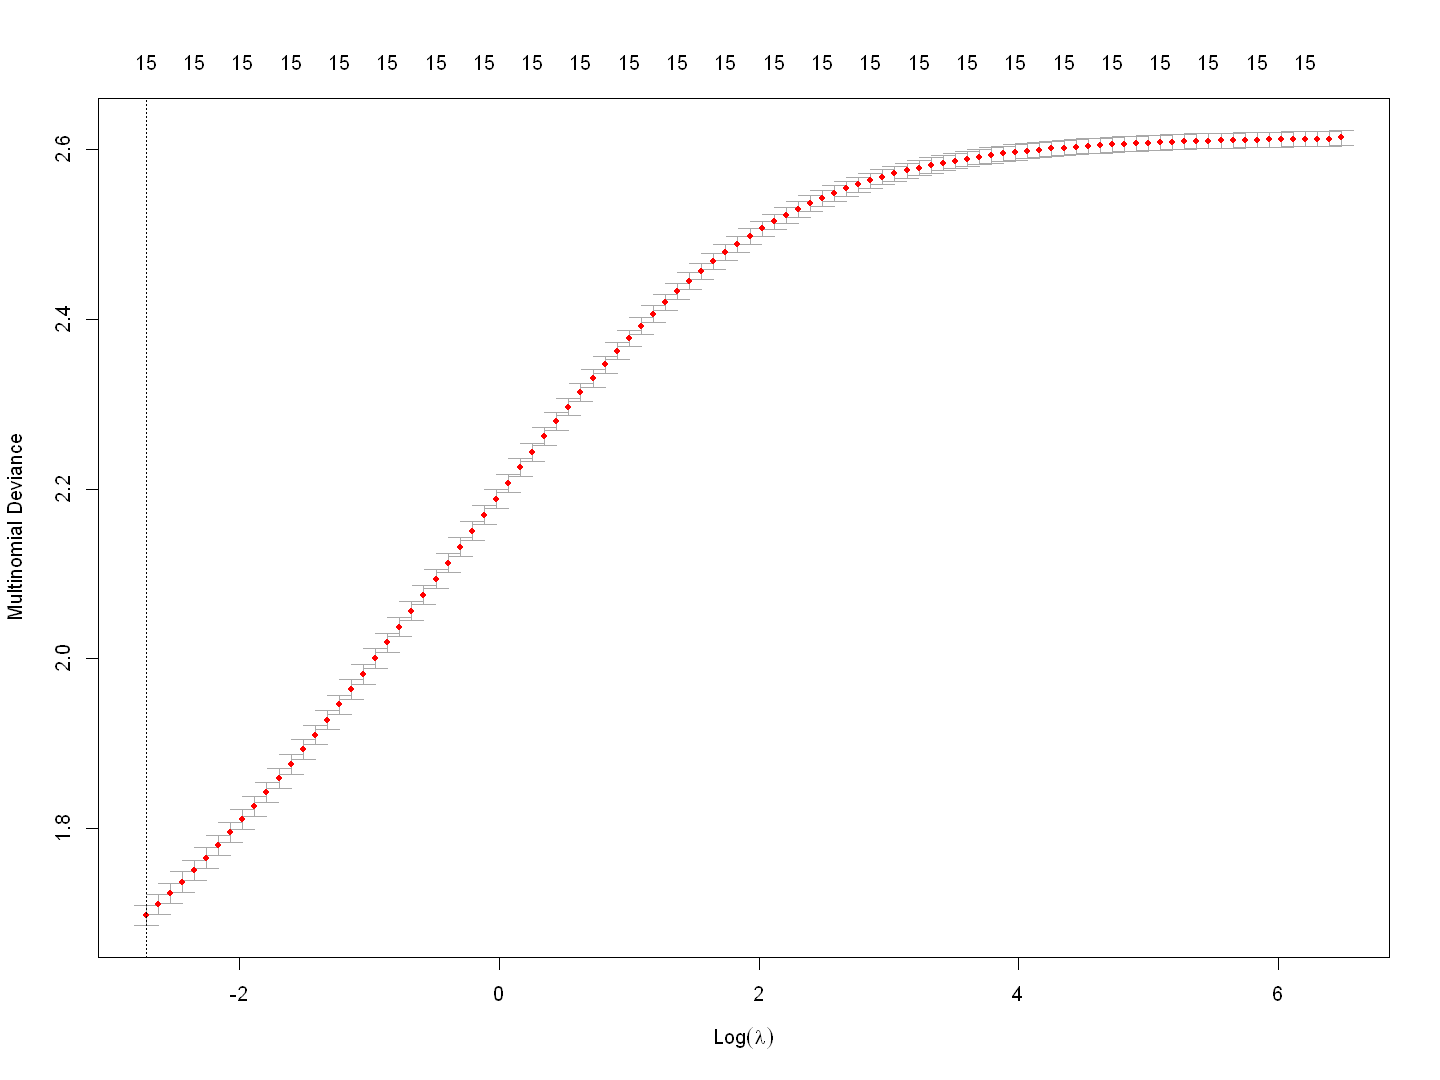

In [81]:
class.ridge.cv <- cv.glmnet(y = X.train$pop.class, x = x.mat, alpha = 0,
                            family = "multinomial", type.multinomial = "grouped")

plot(class.ridge.cv)

In [82]:
paste("CV estimate of lambda :", round(class.ridge.cv$lambda.1se, 3))
coef(class.ridge.cv, s = "lambda.1se")

[1] "CV estimate of lambda : 0.066"

$`0`
15 x 1 sparse Matrix of class "dgCMatrix"
                            1
(Intercept)      -0.961590341
valence          -0.148933345
year              0.636723538
acousticness     -0.136093006
duration         -0.093352081
energy            0.047423689
instrumentalness -0.096607818
key               0.003288431
liveness         -0.060122602
loudness          0.187022977
mode0             0.029331740
mode1            -0.029338814
speechiness       0.026836694
tempo             0.011075577
dance_norm        0.145605468

$`1`
15 x 1 sparse Matrix of class "dgCMatrix"
                             1
(Intercept)       0.3073818464
valence          -0.0022101310
year              0.6149860623
acousticness     -0.1102589748
duration          0.0695043978
energy            0.0563761753
instrumentalness -0.0454146291
key              -0.0044453112
liveness         -0.0309994614
loudness          0.0760358854
mode0             0.0009304025
mode1            -0.0009171800
speechiness      -0.10

In [83]:
pred.lr.ridge <- predict(class.ridge.cv, newx = x.mat2, s = "lambda.min", type = "class")
tab <- as.data.frame.matrix(table(pred.lr.ridge, y.test.class))
tab <- rbind(c(0, 0, 0, 0), tab)
rownames(tab) <- 0:3

In [84]:
as.matrix(tab)
paste("Prediction error: ",
      round(100 * (1 - sum(diag(as.matrix(tab)))/ntest), 1), " %", sep = "")

,0,1,2,3
0,0,0,0,0
1,232,493,177,16
2,22,169,423,63
3,2,27,142,734


[1] "Prediction error: 34 %"

In [85]:
pred.error.ridge <- round(100 * (1 - sum(diag(as.matrix(tab)))/ntest), 4)
pred.error.ridge

[1] 34

#### Pénalisation Elastic Net

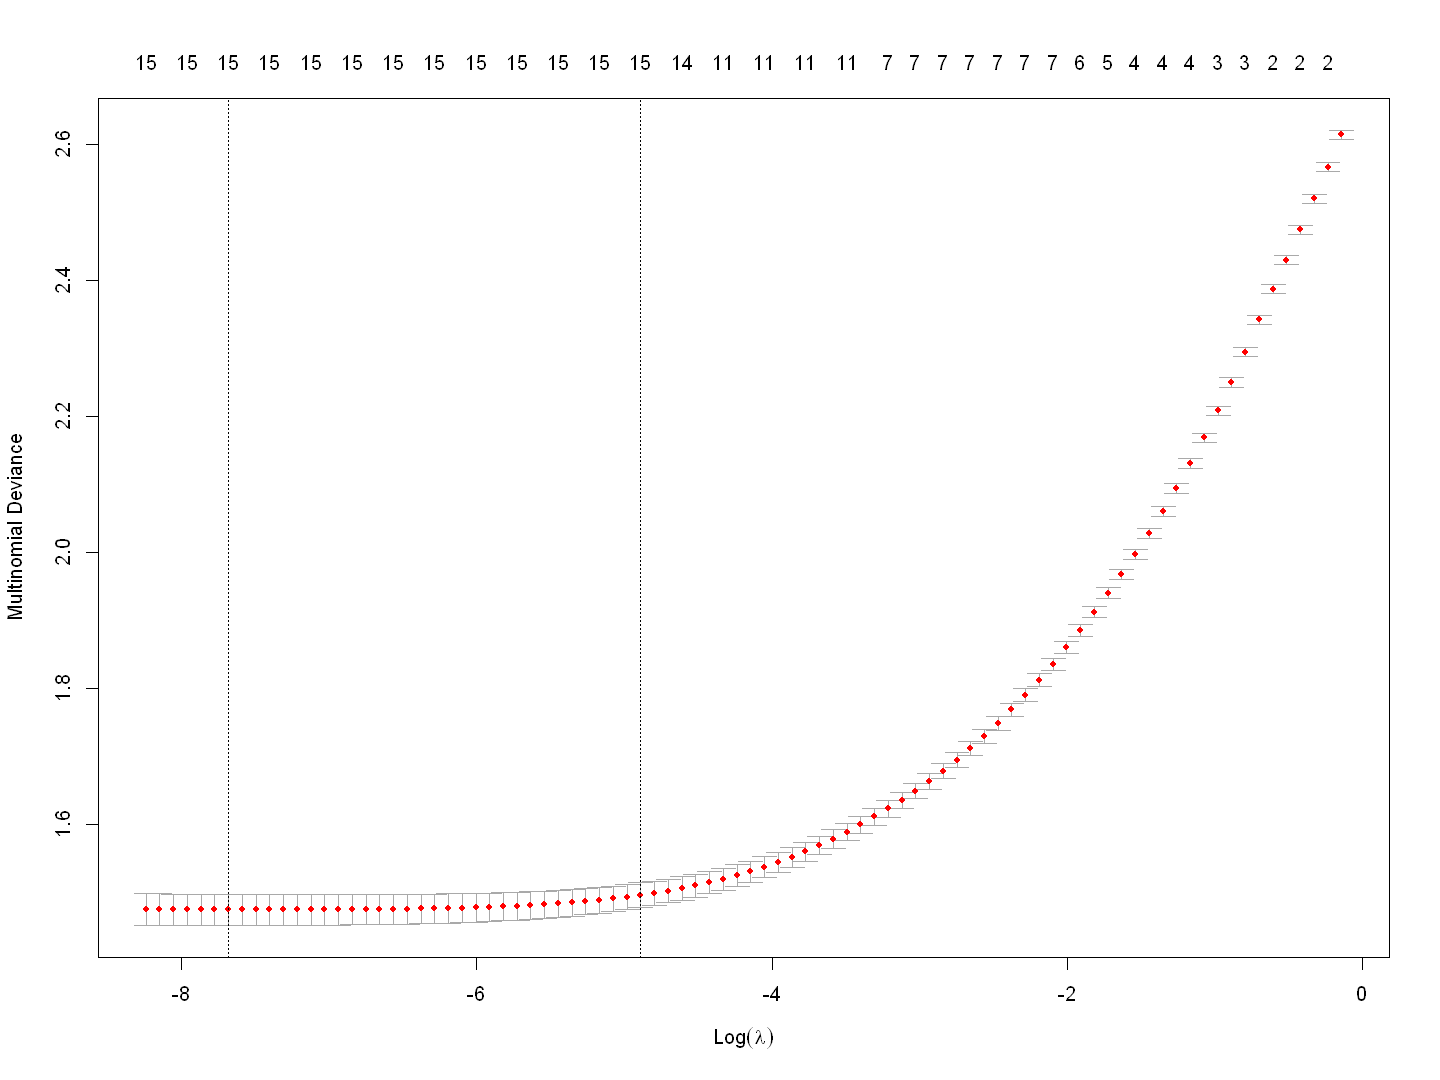

In [86]:
class.EN.cv <- cv.glmnet(y = X.train$pop.class, x = x.mat, alpha = 0.5,
                         family = "multinomial", type.multinomial = "grouped")

plot(class.EN.cv)

In [87]:
paste("CV estimate of lambda :", round(class.EN.cv$lambda.1se, 3))
coef(class.EN.cv, s = "lambda.1se")

[1] "CV estimate of lambda : 0.008"

$`0`
15 x 1 sparse Matrix of class "dgCMatrix"
                             1
(Intercept)      -1.5384138941
valence          -0.0807463523
year              2.0283830432
acousticness     -0.1147446173
duration         -0.1370290394
energy           -0.0439812788
instrumentalness -0.1715367210
key               0.0009317914
liveness         -0.0374992320
loudness          0.1578238289
mode0             0.0014740193
mode1            -0.0014619230
speechiness      -0.0514161187
tempo            -0.0017234352
dance_norm        0.0925391923

$`1`
15 x 1 sparse Matrix of class "dgCMatrix"
                            1
(Intercept)       0.499970737
valence           0.049831936
year              1.177546801
acousticness     -0.048746423
duration          0.073863026
energy           -0.011608904
instrumentalness -0.056440279
key              -0.001042199
liveness         -0.017634716
loudness          0.105087824
mode0             0.002813474
mode1            -0.002790964
speechiness      -0

In [88]:
pred.lr.EN <- predict(class.EN.cv, x.mat2, s = "lambda.min", type = "class")
table(pred.lr.EN, y.test.class)
paste("Prediction error: ",
      round(100 * (1 - sum(diag(table(pred.lr.EN, y.test.class)))/ntest), 1), " %", sep = "")

          y.test.class
pred.lr.EN   0   1   2   3
         0  46  11   0   1
         1 185 496 175  15
         2  24 173 482  72
         3   1   9  85 725

[1] "Prediction error: 30 %"

In [89]:
pred.error.EN <- round(100 * (1 - sum(diag(table(pred.lr.EN, y.test.class)))/ntest), 4)
pred.error.EN

[1] 30.04

### Random Forest

mtry = 3  OOB error = 26.17% 
Searching left ...
mtry = 2 	OOB error = 26.72% 
-0.0208864 0.02 
Searching right ...
mtry = 4 	OOB error = 25.92% 
0.009679063 0.02 


,mtry,OOBError
2.OOB,2,0.2672000
3.OOB,3,0.2617333
4.OOB,4,0.2592000


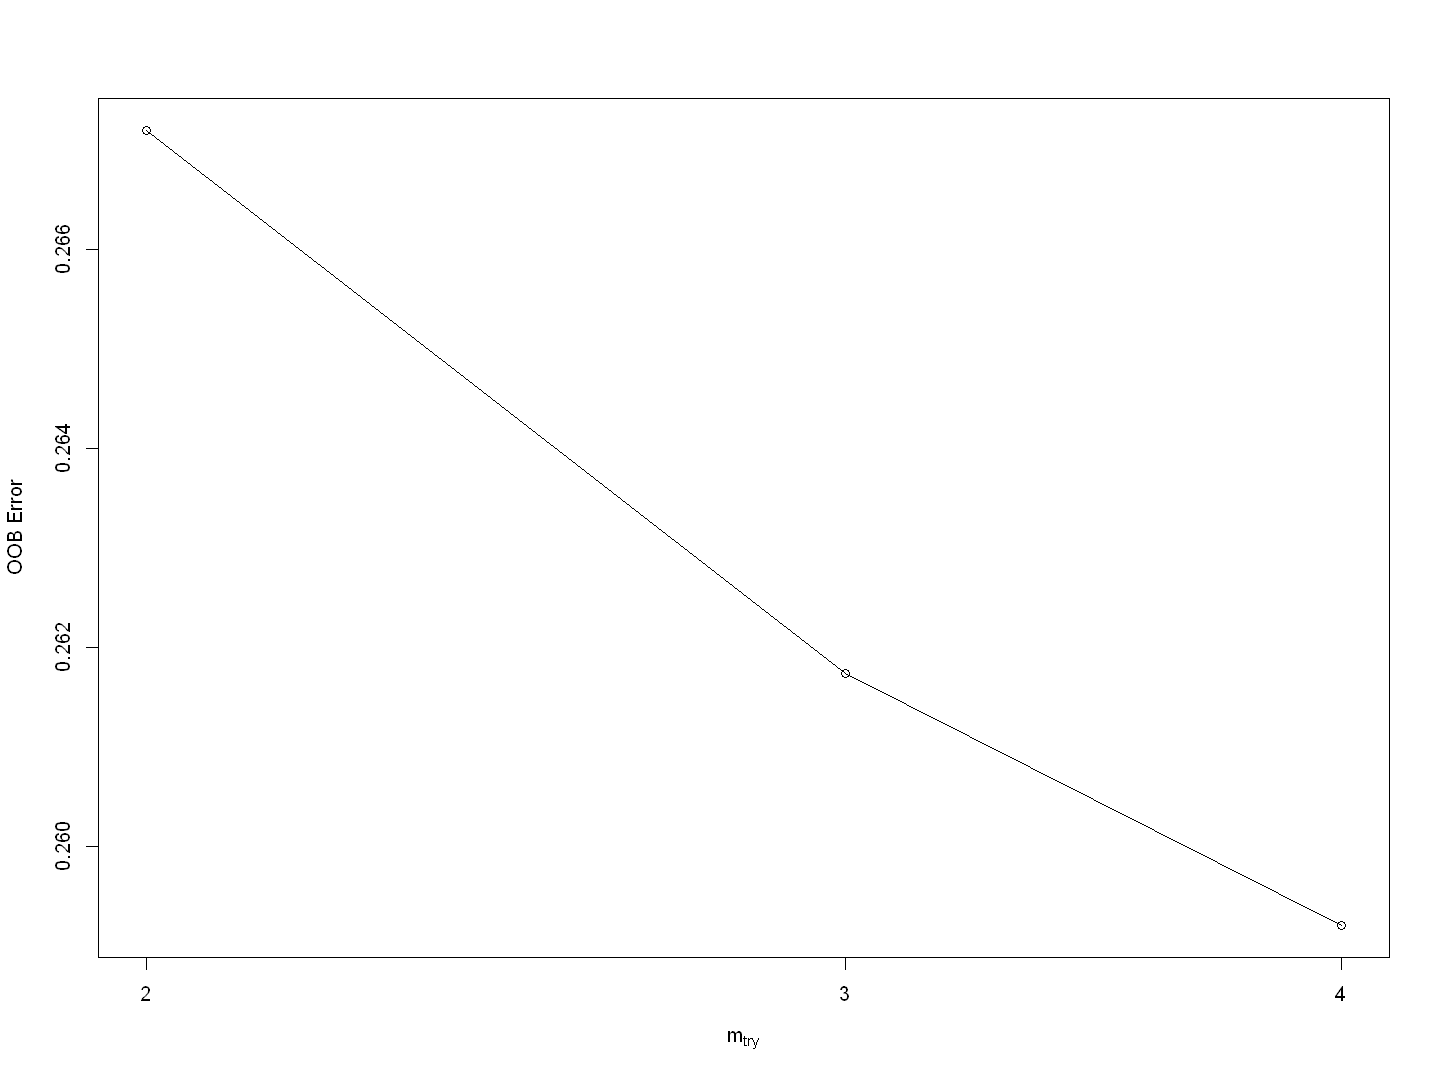

In [90]:
set.seed(1)
eps <- 2e-02
bestMtry <- tuneRF(X.train[, -13], X.train$pop.class, stepFactor = 1.5,
                   improve = eps, ntree = 500, trace = TRUE, plot = TRUE)

bestMtry

In [91]:
rf.class <- randomForest(pop.class ~ ., data = X.train, mtry = 4,
                         xtest = X.test[, -13], ytest = X.test$pop.class,
                         ntree = 500, do.trace = 50, importance = TRUE)

rf.class

ntree      OOB      1      2      3      4|    Test      1      2      3      4
   50:  28.08% 62.94% 34.00% 30.19% 10.21%|  27.32% 56.25% 32.37% 31.54% 10.09%
  100:  26.57% 62.52% 32.41% 27.67%  9.41%|  26.96% 55.47% 32.80% 30.46%  9.84%
  150:  25.97% 62.66% 32.59% 25.79%  9.07%|  26.96% 54.30% 33.38% 30.46%  9.72%
  200:  26.04% 62.23% 32.68% 26.24%  8.90%|  26.88% 55.47% 33.53% 29.65%  9.72%
  250:  26.16% 62.52% 33.23% 25.83%  9.07%|  26.92% 55.86% 33.38% 29.78%  9.72%
  300:  26.05% 62.09% 33.18% 25.83%  8.90%|  26.68% 55.47% 33.09% 29.38%  9.72%
  350:  26.23% 62.80% 33.27% 26.01%  8.99%|  26.60% 55.47% 32.66% 29.65%  9.59%
  400:  26.15% 62.52% 33.23% 25.88%  8.99%|  26.40% 54.69% 32.80% 29.11%  9.59%
  450:  26.17% 62.23% 33.09% 26.15%  9.03%|  26.36% 54.69% 33.09% 28.71%  9.59%
  500:  26.08% 62.09% 33.14% 25.88%  8.99%|  26.44% 53.91% 33.24% 29.11%  9.59%



Call:
 randomForest(formula = pop.class ~ ., data = X.train, mtry = 4,      xtest = X.test[, -13], ytest = X.test$pop.class, ntree = 500,      do.trace = 50, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 26.08%
Confusion matrix:
    0    1    2    3 class.error
0 268  346   86    7  0.62093352
1  66 1469  623   39  0.33136095
2   7  332 1650  237  0.25876011
3  21   21  171 2157  0.08987342
                Test set error rate: 26.44%
Confusion matrix:
    0   1   2   3 class.error
0 118 107  30   1  0.53906250
1  16 460 202  11  0.33236575
2   1 138 526  77  0.29110512
3   4  10  64 735  0.09594096

In [92]:
sort(round(importance(rf.class), 2)[, 4], decreasing = TRUE)

year       dance_norm      speechiness     acousticness 
          218.09            25.63            25.23            22.50 
        loudness          valence           energy instrumentalness 
           19.62            15.22            14.79            12.71 
        liveness         duration             mode              key 
           11.89            10.80             2.85             1.47 
           tempo 
            0.20

In [93]:
pred.rf <- rf.class$test$predicted
table(pred.rf, y.test.class)
paste("Prediction error: ",
      round(100 * (1 - sum(diag(table(pred.rf, y.test.class)))/ntest), 1), " %", sep = "")

       y.test.class
pred.rf   0   1   2   3
      0 118  16   1   4
      1 107 460 138  10
      2  30 202 526  64
      3   1  11  77 735

[1] "Prediction error: 26.4 %"

In [94]:
pred.error.rf <- round(100 * (1 - sum(diag(table(pred.rf, y.test.class)))/ntest), 4)
pred.error.rf

[1] 26.44

### Decision Trees

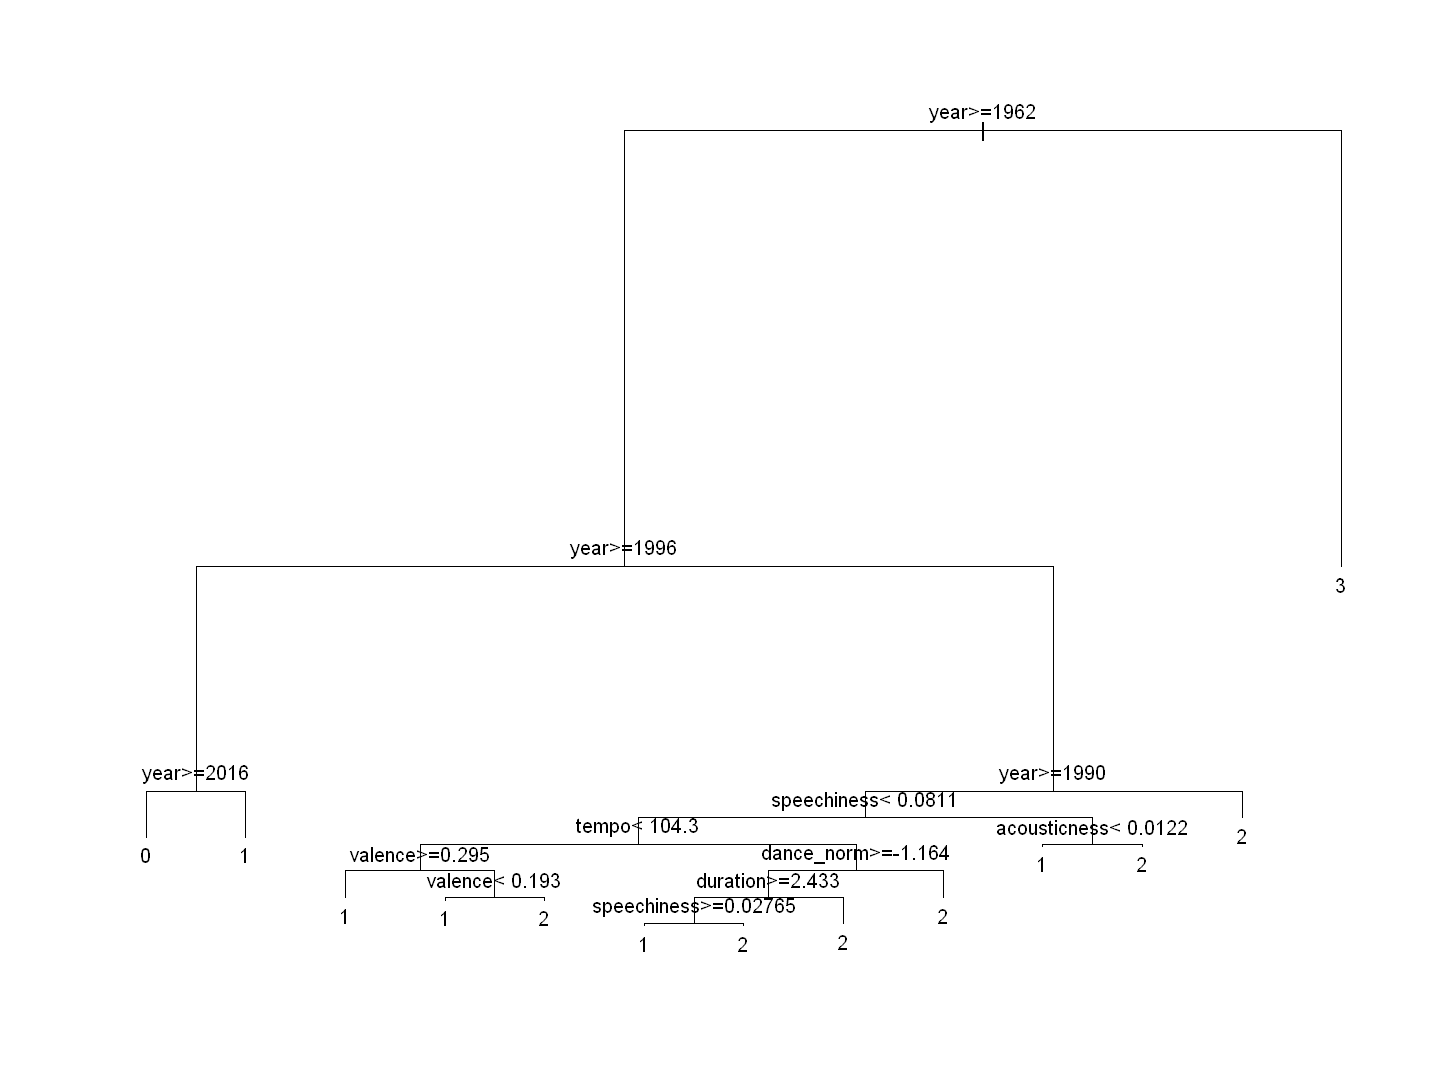

In [95]:
control <- rpart.control(minsplit = 20,
    minbucket = round(5 / 3),
    maxdepth = 30,
    cp = 0.001
)

tree.dis <- rpart(pop.class ~ ., data = X.train, method = 'class', control = control)
plot(tree.dis)
text(tree.dis)

In [96]:
pred.tree <- predict(tree.dis, X.test[, -13], type = "class")
table(pred.tree, y.test.class)
paste("Prediction error: ",
      round(100 * (1 - sum(diag(table(pred.tree, y.test.class)))/ntest), 1), " %", sep = "")

         y.test.class
pred.tree   0   1   2   3
        0 114  12   0   8
        1 111 469 142   8
        2  30 197 520  62
        3   1  11  80 735

[1] "Prediction error: 26.5 %"

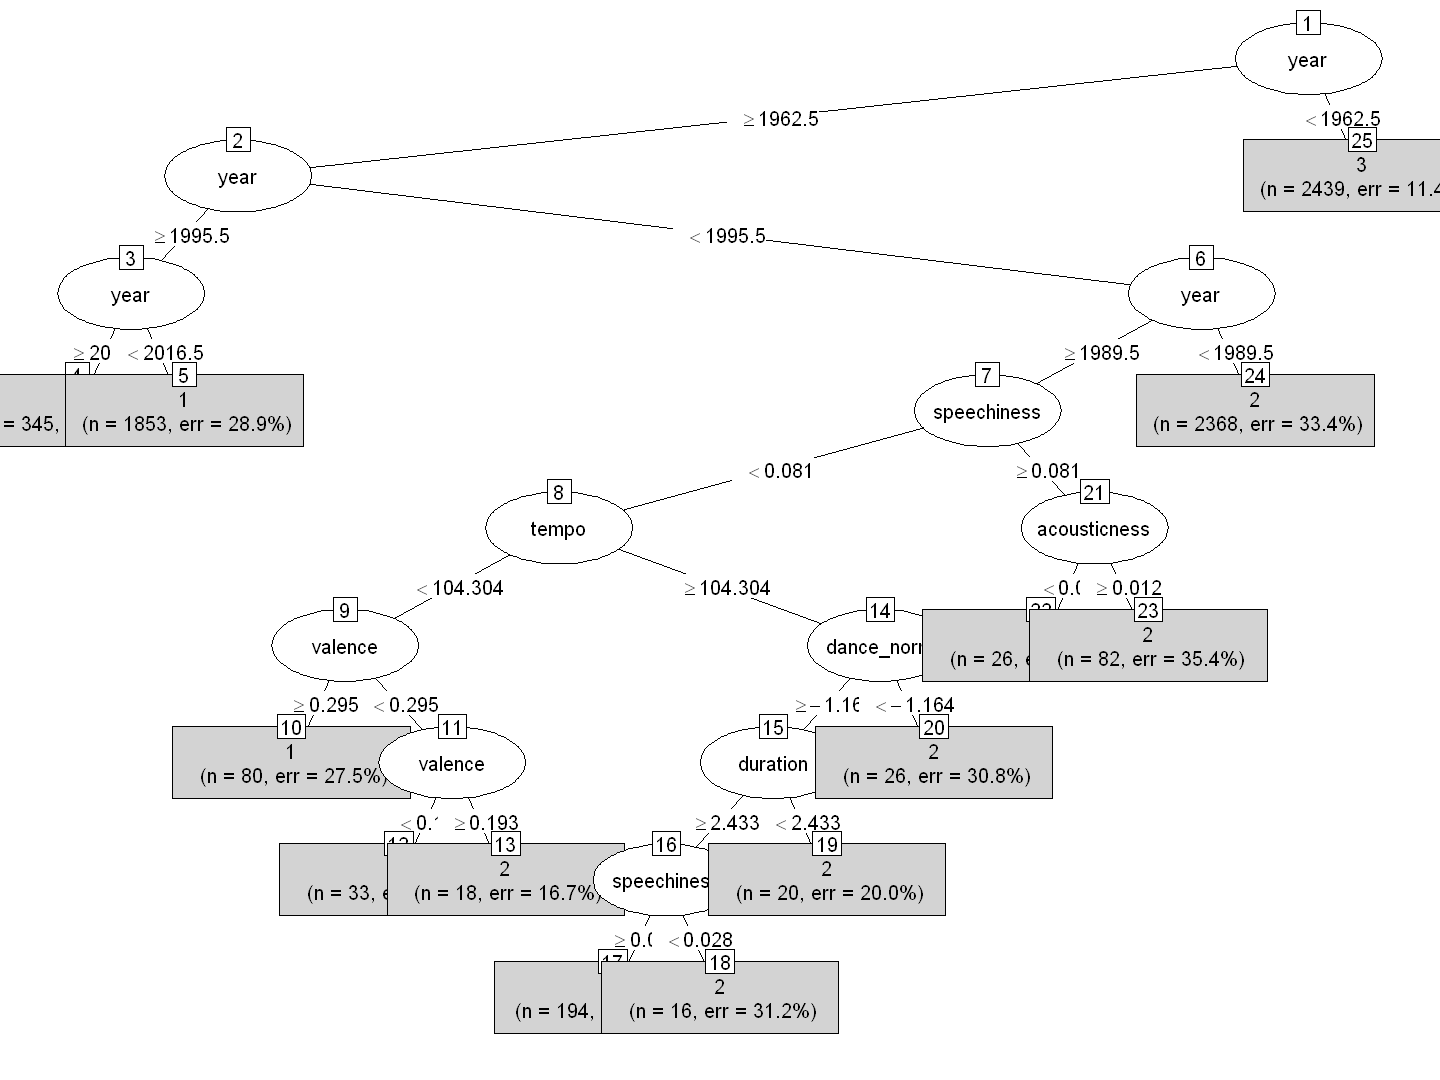

In [97]:
plot(as.party(tree.dis), type = "simple")

In [98]:
pred.error.tree <- round(100 * (1 - sum(diag(table(pred.tree, y.test.class)))/ntest), 4)
pred.error.tree

[1] 26.48

### SVC

#### Linear Kernel

In [99]:
svc.lin.tune <- best.svm(pop.class ~ ., data = X.train.scaled, type = "C",
                         kernel = "lin", cross = 5,
                         cost = c(1, 1.5, 2, 2.5, 3, 3.5))
svc.lin.tune


Call:
best.svm(x = pop.class ~ ., data = X.train.scaled, type = "C", kernel = "lin", 
    cross = 5, cost = c(1, 1.5, 2, 2.5, 3, 3.5))


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 

Number of Support Vectors:  5126


In [100]:
svc.lin <- svm(pop.class ~ ., data = X.train.scaled, type = "C",
               cost = svc.lin.tune$cost)

In [101]:
pred.lin <- predict(svc.lin, X.test.scaled[, -13])
table(pred.lin, y.test.class)
paste("Prediction error: ",
      round(100 * (1 - sum(diag(table(pred.lin, y.test.class)))/ntest), 1), " %", sep = "")

        y.test.class
pred.lin   0   1   2   3
       0  31   9   0   0
       1 198 472 140  13
       2  27 198 517  81
       3   0  10  85 719

[1] "Prediction error: 30.4 %"

In [102]:
pred.error.lin <- round(100 * (1 - sum(diag(table(pred.lin, y.test.class)))/ntest), 4)
pred.error.lin

[1] 30.44

#### Polynomial Kernel

In [103]:
svc.poly.tune <- best.svm(pop.class ~ ., data = X.train.scaled, type = "C",
                          kernel = "poly", cross = 5, coef0 = -1:1,
                          cost = c(1, 1.5, 2, 2.5, 3, 3.5))
svc.poly.tune


Call:
best.svm(x = pop.class ~ ., data = X.train.scaled, type = "C", kernel = "poly", 
    cross = 5, coef0 = -1:1, cost = c(1, 1.5, 2, 2.5, 3, 3.5))


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  polynomial 
       cost:  1 
     degree:  3 
     coef.0:  1 

Number of Support Vectors:  4823


In [105]:
svc.poly <- svm(pop.class ~ ., data = X.train.scaled, type = "C",
                coef0 = svc.poly.tune$coef0,
                cost = svc.poly.tune$cost)

In [106]:
pred.poly <- predict(svc.poly, X.test.scaled[, -13])
table(pred.poly, y.test.class)
paste("Prediction error: ",
      round(100 * (1 - sum(diag(table(pred.poly, y.test.class)))/ntest), 1), " %", sep = "")

         y.test.class
pred.poly   0   1   2   3
        0  31   9   0   0
        1 198 472 140  13
        2  27 198 517  81
        3   0  10  85 719

[1] "Prediction error: 30.4 %"

In [107]:
pred.error.poly <- round(100 * (1 - sum(diag(table(pred.poly, y.test.class)))/ntest), 4)
pred.error.poly

[1] 30.44

#### Radial Kernel

In [108]:
svc.rad.tune <- best.svm(pop.class ~ ., data = X.train.scaled, type = "C",
                         kernel = "radial", cost = c(0.1, 1, 1.5, 2),
                         gamma = seq(0.02, 0.1, by = 0.02), cross = 5)
svc.rad.tune


Call:
best.svm(x = pop.class ~ ., data = X.train.scaled, type = "C", kernel = "radial", 
    cost = c(0.1, 1, 1.5, 2), gamma = seq(0.02, 0.1, by = 0.02), 
    cross = 5)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  2 

Number of Support Vectors:  5075


In [109]:
svc.rad.tune$cost
svc.rad.tune$gamma

[1] 2

[1] 0.08

In [110]:
svc.rad <- svm(pop.class ~ ., data = X.train.scaled, type = "C",
               cost = svc.rad.tune$cost,
               gamma = svc.rad.tune$gamma)

In [111]:
pred.rad <- predict(svc.rad, X.test.scaled[, -13])
table(pred.rad, y.test.class)
paste("Prediction error: ",
      round(100 * (1 - sum(diag(table(pred.rad, y.test.class)))/ntest), 1), " %", sep = "")

        y.test.class
pred.rad   0   1   2   3
       0  59  19   2   0
       1 167 459 134  13
       2  30 198 526  79
       3   0  13  80 721

[1] "Prediction error: 29.4 %"

In [112]:
pred.error.rad <- round(100 * (1 - sum(diag(table(pred.rad, y.test.class)))/ntest), 4)
pred.error.rad

[1] 29.4

### Réseaux de neurones

In [113]:
nnet.dis <- multinom(pop.class ~ ., data = X.train.scaled, decay = 1e-5, maxit = 1000)
nnet.dis

# weights:  60 (42 variable)
initial  value 10397.207708 
iter  10 value 6963.809214
iter  20 value 6793.808155
iter  30 value 6194.300157
iter  40 value 5810.867746
iter  50 value 5482.553512
iter  60 value 5481.818111
iter  60 value 5481.818091
iter  60 value 5481.818091
final  value 5481.818091 
converged


Call:
multinom(formula = pop.class ~ ., data = X.train.scaled, decay = 1e-05, 
    maxit = 1000)

Coefficients:
  (Intercept)     valence      year acousticness  duration     energy
1    2.816378  0.15565918 -1.453797   0.13390273 0.3150402 0.05274452
2    3.655879  0.08173282 -3.548037   0.02797595 0.2747878 0.33546332
3    1.780183 -0.04890633 -6.812653   0.43597467 0.3026050 0.27644327
  instrumentalness          key   liveness    loudness       mode1 speechiness
1        0.2486520 -0.010084577 0.02749834  0.03513452 -0.02440928 -0.05880661
2        0.3404290 -0.008021935 0.08757136 -0.40929641  0.04578991  0.22175449
3        0.6240207 -0.001170170 0.03622049 -0.21836881 -0.00798324  0.72872031
        tempo  dance_norm
1 0.011392651 -0.16435132
2 0.005718724 -0.08942986
3 0.081244631 -0.07109682

Residual Deviance: 10963.64 
AIC: 11047.64 

In [114]:
pred.nn <- predict(nnet.dis, X.test.scaled[, -13], type = "class")
table(pred.nn, y.test.class)
paste("Prediction error: ",
      round(100 * (1 - sum(diag(table(pred.nn, y.test.class)))/ntest), 1), " %", sep = "")

       y.test.class
pred.nn   0   1   2   3
      0  54  11   0   1
      1 177 496 177  14
      2  24 173 480  71
      3   1   9  85 727

[1] "Prediction error: 29.7 %"

In [115]:
pred.error.nn <- round(100 * (1 - sum(diag(table(pred.nn, y.test.class)))/ntest), 4)
pred.error.nn

[1] 29.72

Tableau de comparaison :

In [116]:
errors <- c(pred.error.lr, pred.error.lasso, pred.error.ridge, 
            pred.error.EN, pred.error.rf, pred.error.tree,
            pred.error.lin, pred.error.poly, pred.error.rad, pred.error.nn)

accuracy.scores <- 100 - errors

methods.class <- c("Logistic Regression", "Lasso", "Ridge", "Elastic Net",
                   "Random Forest", "Decision Trees", "Linear SVC",
                   "Polynomial SVC ", "Radial SVC", "Neural Network")

class.comparison <- data.frame(Model = methods.class,
                               Accuracy = accuracy.scores/100)
class.comparison

Model,Accuracy
<chr>,<dbl>
Logistic Regression,0.7020
Lasso,0.7004
Ridge,0.6600
Elastic Net,0.6996
Random Forest,0.7356
Decision Trees,0.7352
Linear SVC,0.6956
Polynomial SVC,0.6956
Radial SVC,0.7060


In [117]:
class.comparison[order(class.comparison$Accuracy, decreasing = TRUE), ]

,Model,Accuracy
,<chr>,<dbl>
5,Random Forest,0.7356
6,Decision Trees,0.7352
9,Radial SVC,0.7060
10,Neural Network,0.7028
1,Logistic Regression,0.7020
2,Lasso,0.7004
4,Elastic Net,0.6996
7,Linear SVC,0.6956
8,Polynomial SVC,0.6956


## Régression

In [118]:
X.train <- spotify_data[appri, -14] # on supprime pop.class
X.test <- spotify_data[testi, -14]

str(X.train)
str(X.test)
# summary(X.train)

'data.frame':	7500 obs. of  14 variables:
 $ valence         : num  0.647 0.828 0.489 0.963 0.463 0.151 0.42 0.88 0.0489 0.799 ...
 $ year            : int  1975 1994 2018 2003 2001 1959 2013 1980 1952 1951 ...
 $ acousticness    : num  0.449 0.531 0.371 0.523 0.137 0.987 0.167 0.11 0.991 0.991 ...
 $ duration        : num  4.98 3.13 5.4 2.98 8.58 ...
 $ energy          : num  0.827 0.625 0.694 0.615 0.562 0.0359 0.736 0.825 0.0864 0.0857 ...
 $ instrumentalness: num  7.88e-03 7.73e-06 0.00 1.48e-06 2.90e-03 7.27e-05 8.78e-03 4.51e-02 0.00 9.49e-01 ...
 $ key             : num  2 10 5 10 9 3 2 9 1 8 ...
 $ liveness        : num  0.466 0.348 0.109 0.0794 0.0463 0.121 0.124 0.11 0.118 0.107 ...
 $ loudness        : num  -7.6 -11.96 -4.39 -8.83 -10.23 ...
 $ mode            : Factor w/ 2 levels "0","1": 2 1 2 2 1 2 1 1 2 2 ...
 $ popularity      : int  25 38 68 47 49 16 58 26 0 0 ...
 $ speechiness     : num  0.399 0.0639 0.169 0.092 0.045 0.0446 0.0384 0.0317 0.0932 0.198 ...
 $ tempo   

In [119]:
cols <- c(7, 10, 11)
pre.proc.vals <- preProcess(X.train[, -cols], method = c("center", "scale"))

X.train.scaled <- data.frame(X.train)
X.train.scaled[, -cols] <- predict(pre.proc.vals, X.train.scaled[, -cols])

X.test.scaled <- data.frame(X.test)
X.test.scaled[, -cols] <- predict(pre.proc.vals, X.test.scaled[, -cols])

In [120]:
y.train.reg <- y.reg[appri]
y.test.reg <- y.reg[testi]

In [121]:
mse.scores <- vector(mode = "numeric", length = 10)
r2.scores <- vector(mode = "numeric", length = 10)
evs.scores <- vector(mode = "numeric", length = 10)
thresholding.scores <- vector(mode = "numeric", length = 10)

In [122]:
plot.res <- function(x, y, titre = "titre") {
    plot(x, y, col = "blue", xlim = c(0, 100), ylim = c(-100, 100),
         ylab = "Résidus", xlab = "Valeurs prédites", main = titre, pch = 20)
    # points(x2, y, col='red')
    abline(h = 0, col = "green")
}

In [123]:
reg.to.class <- function(y.pred){
    n = length(y.pred)
    y.reg.to.class <- vector(mode = "character", length = n)
    for (i in 1:n) {
        if (0 <= y.pred[i] & y.pred[i] < 20) {
            y.reg.to.class[i] = 'D'
        } else if (20 <= y.pred[i] & y.pred[i] < 40) {
            y.reg.to.class[i] = 'C'
        } else if (40 <= y.pred[i] & y.pred[i] < 60) {
            y.reg.to.class[i] = 'B'
        } else {
            y.reg.to.class[i] = 'A'
        }
    }
    return (y.reg.to.class)
}

In [124]:
threshold.score <- function(y.pred.reg, y.true.class) {
    y.reg.to.class <- reg.to.class(y.pred.reg)
    pred.error <- round(1 - sum(diag(table(y.reg.to.class, y.true.class))/ntest), 4)
    accuracy <- 1 - pred.error
    return (accuracy)
}

In [125]:
plot.regression.results <- function(y.true.reg, y.true.class, y.pred) {
    print(paste("Mean Squared Error:", round(sum((y.pred - y.true.reg)^2)/ntest, 4)))
    print(paste("R2 Score:", round(cor(y.true.reg, y.pred) ^ 2, 4)))
    print(paste("Explained Variance Score:", round(1 - var(y.true.reg - y.pred)/var(y.true.reg), 4)))
    
    y.reg.to.class <- reg.to.class(y.pred)
    class.tab <- table(y.reg.to.class, y.true.class)
    # print(class.tab)
    
    pred.error <- round(100 * (1 - sum(diag(table(y.reg.to.class, y.true.class)))/ntest), 1)
    print(paste("Prediction error: ", pred.error, " %", sep = ""))
    print(paste("Accuracy: ", 100 - pred.error, " %", sep = ""))
    
    preds <- data.frame(true = y.true.reg, predicted = y.pred)
    
    ggplot(preds, aes(x = true, y = predicted)) + geom_point(color = "blue") +
        labs(x = "true values", y = "predicted values") +
        geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red", size = 2)
}

### Régression lineáire

#### Sans pénalisation

In [126]:
x.mat <- model.matrix(popularity ~ . - 1, data = X.train.scaled)
x.mat2 <- model.matrix(popularity ~ . - 1, data = X.test.scaled)

                   Df  Sum Sq Mean Sq   F value   Pr(>F)    
valence             1    1980    1980    16.230 5.67e-05 ***
year                1 2636080 2636080 21609.182  < 2e-16 ***
acousticness        1    7679    7679    62.947 2.43e-15 ***
duration            1      27      27     0.219  0.63963    
energy              1     259     259     2.123  0.14518    
instrumentalness    1    8551    8551    70.097  < 2e-16 ***
key                 1       0       0     0.001  0.97446    
liveness            1    2733    2733    22.402 2.25e-06 ***
loudness            1     565     565     4.630  0.03144 *  
mode                1      64      64     0.524  0.46918    
speechiness         1    9741    9741    79.849  < 2e-16 ***
tempo               1      85      85     0.693  0.40503    
dance_norm          1     849     849     6.961  0.00835 ** 
Residuals        7486  913209     122                       
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

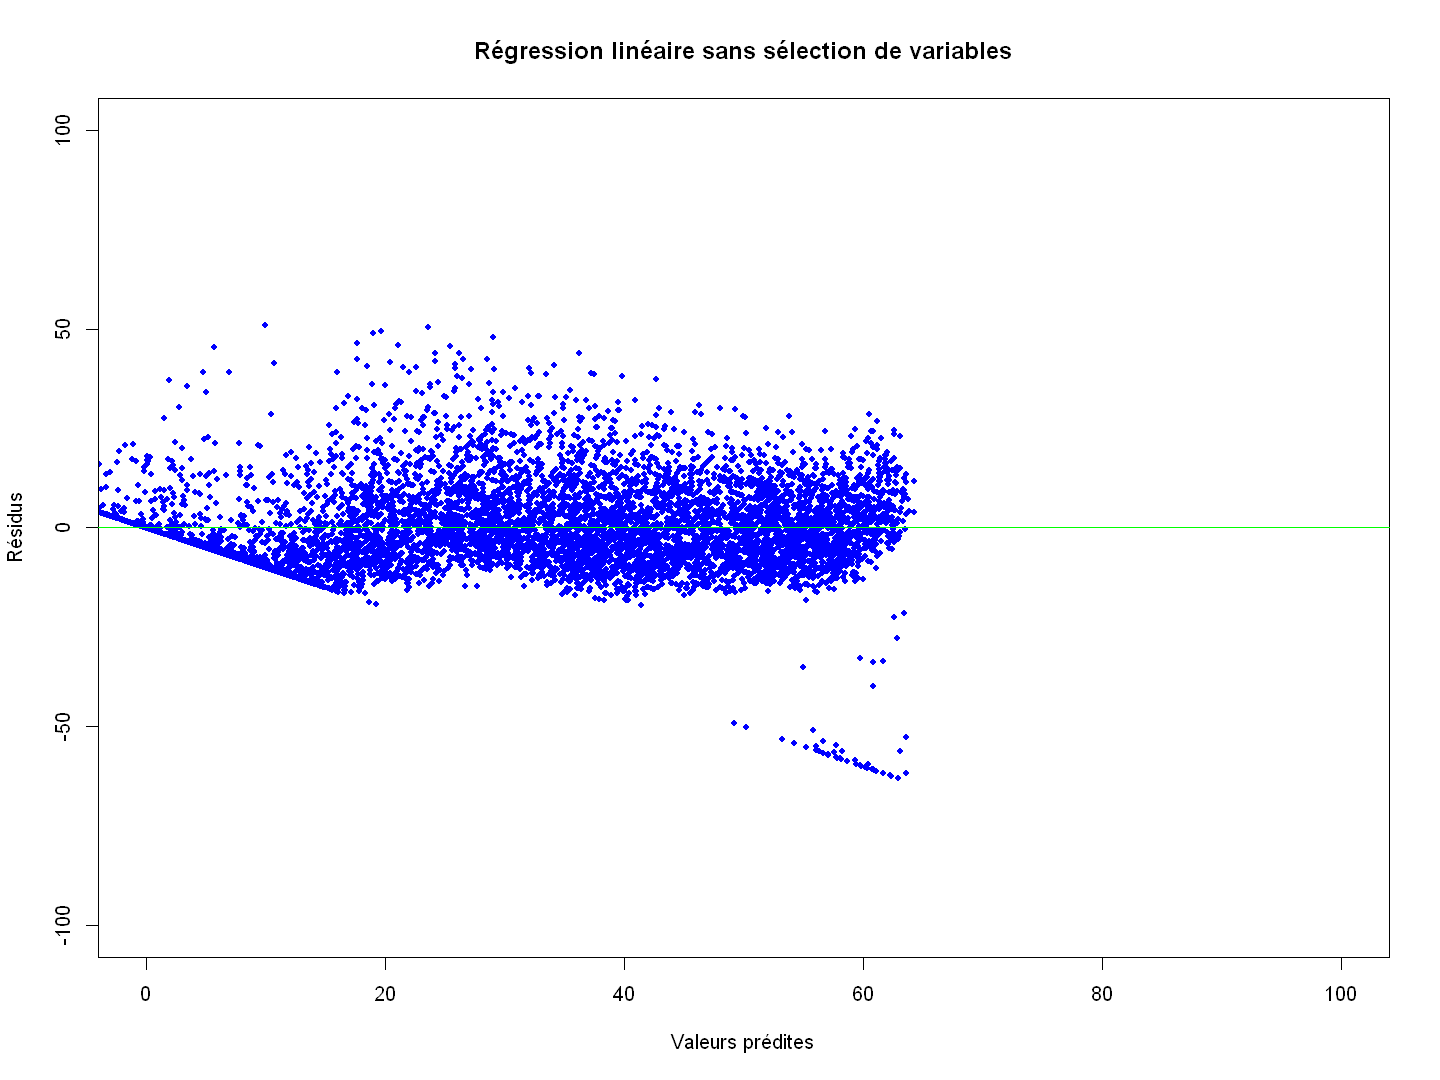

In [127]:
reg.lm <- aov(popularity ~ ., data = X.train)
summary(reg.lm)

res.lm <- reg.lm$residuals
fit.lm <- reg.lm$fitted.values

plot.res(fit.lm, res.lm, "Régression linéaire sans sélection de variables")

[1] "Mean Squared Error: 119.9299"
[1] "R2 Score: 0.7545"
[1] "Explained Variance Score: 0.7545"
[1] "Prediction error: 35.3 %"
[1] "Accuracy: 64.7 %"
       true predicted
126891    0  8.686379
147565   26 33.478353
82623    32 28.206487


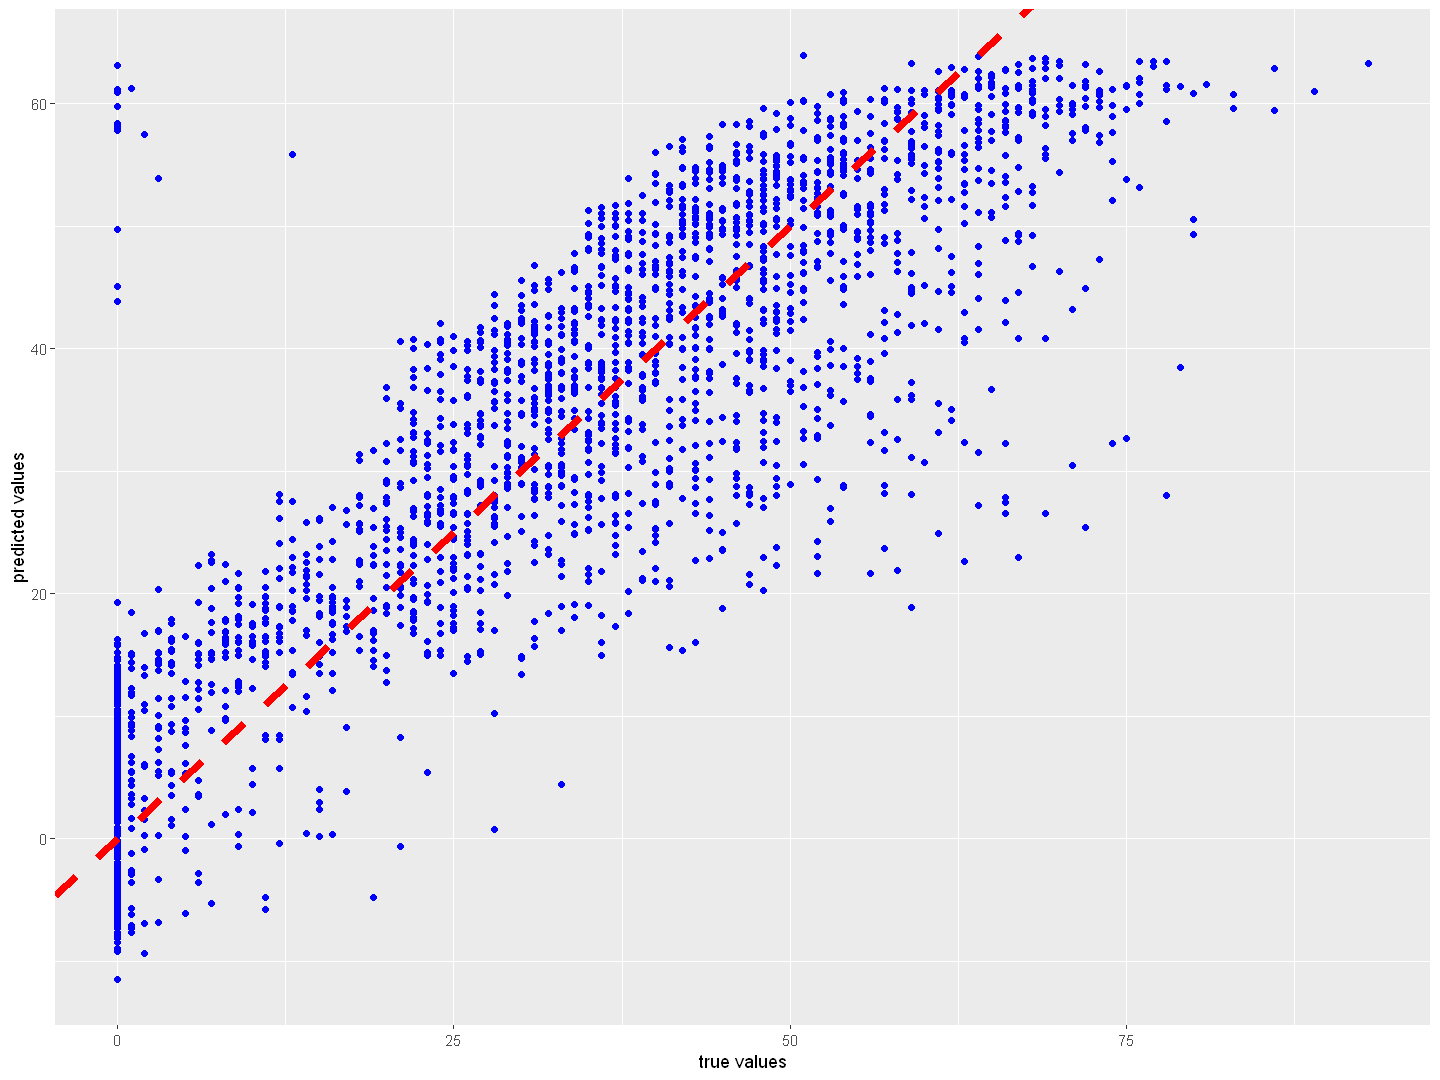

In [128]:
pred.lin.reg <- predict(reg.lm, newdata = X.test[, -11])
plot.regression.results(y.test.reg, y.test.class, pred.lin.reg)

In [129]:
mse.scores[1] <- round(sum((pred.lin.reg - y.test.reg)^2)/ntest, 4)
r2.scores[1] <- round(cor(y.test.reg, pred.lin.reg)^2, 4)
evs.scores[1] <- round(1 - var(y.test.reg - pred.lin.reg)/var(y.test.reg), 4)
thresholding.scores[1] <- threshold.score(pred.lin.reg, y.test.class)

#### Pénalisation LASSO

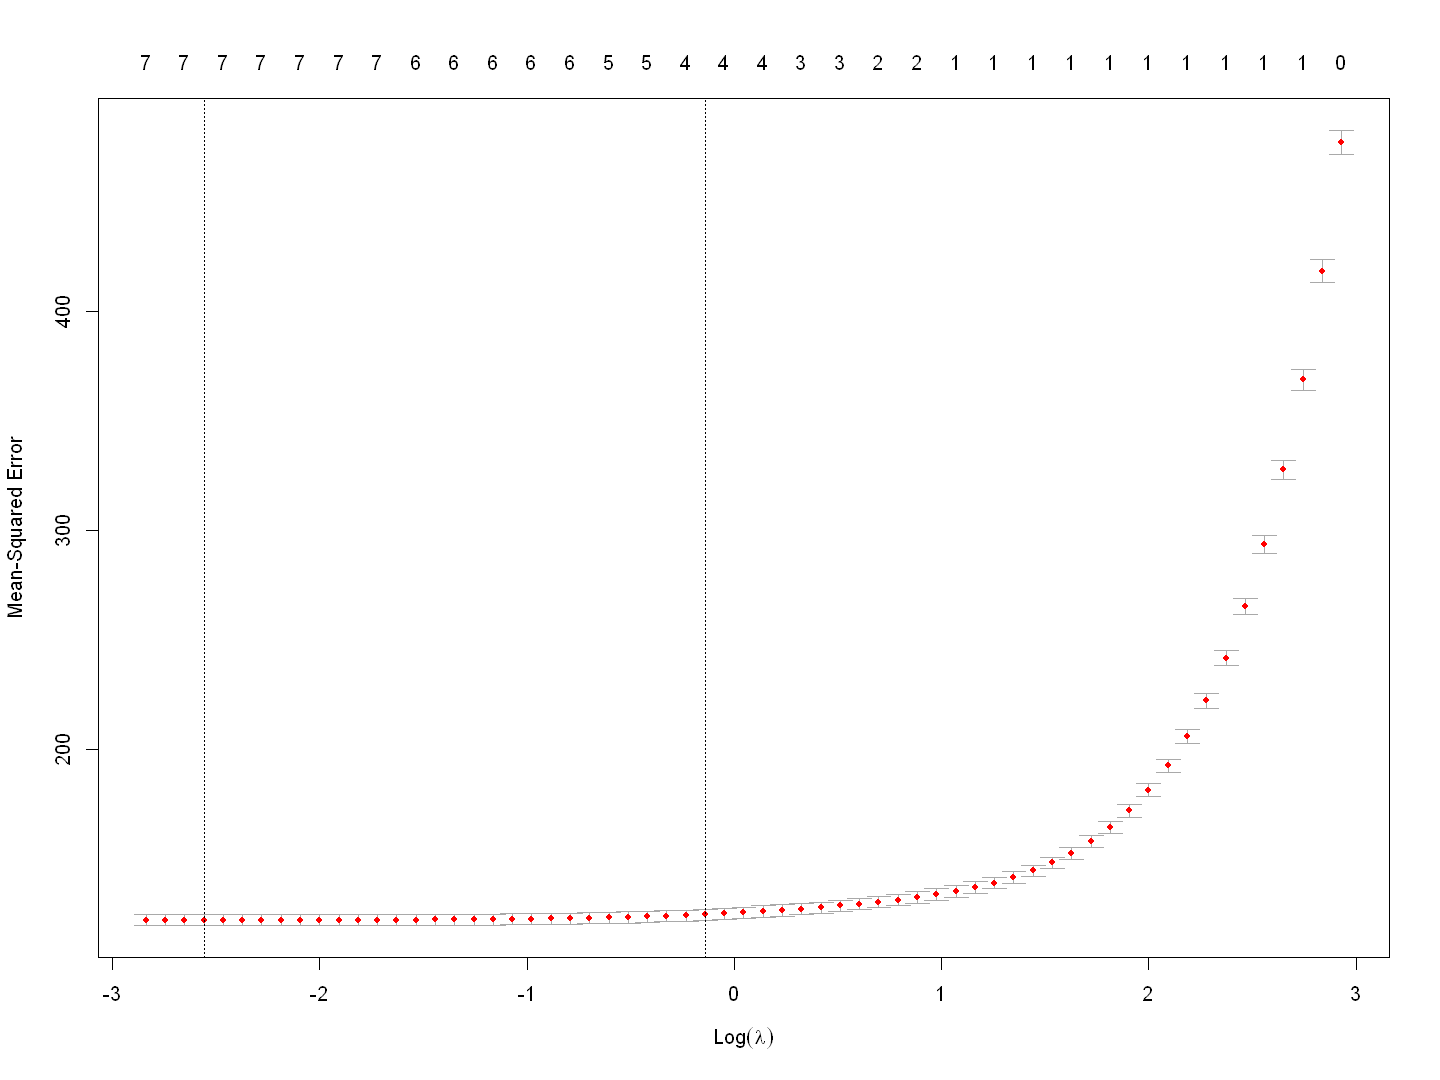

In [130]:
reg.lasso.cv <- cv.glmnet(y = X.train$popularity, x = x.mat, alpha = 1)

plot(reg.lasso.cv)

In [131]:
# valeur estimée
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.1se, 3))

# modèle correspondant
coef(reg.lasso.cv, s = "lambda.1se")  # Extraction des valeurs ajustées et des résidus

[1] "CV estimate of lambda : 0.869"

15 x 1 sparse Matrix of class "dgCMatrix"
                          1
(Intercept)      31.6762667
valence           .        
year             17.0501837
acousticness     -0.9096518
duration          .        
energy            .        
instrumentalness -0.6803026
key               .        
liveness          .        
loudness          .        
mode0             .        
mode1             .        
speechiness      -0.3332154
tempo             .        
dance_norm        .        

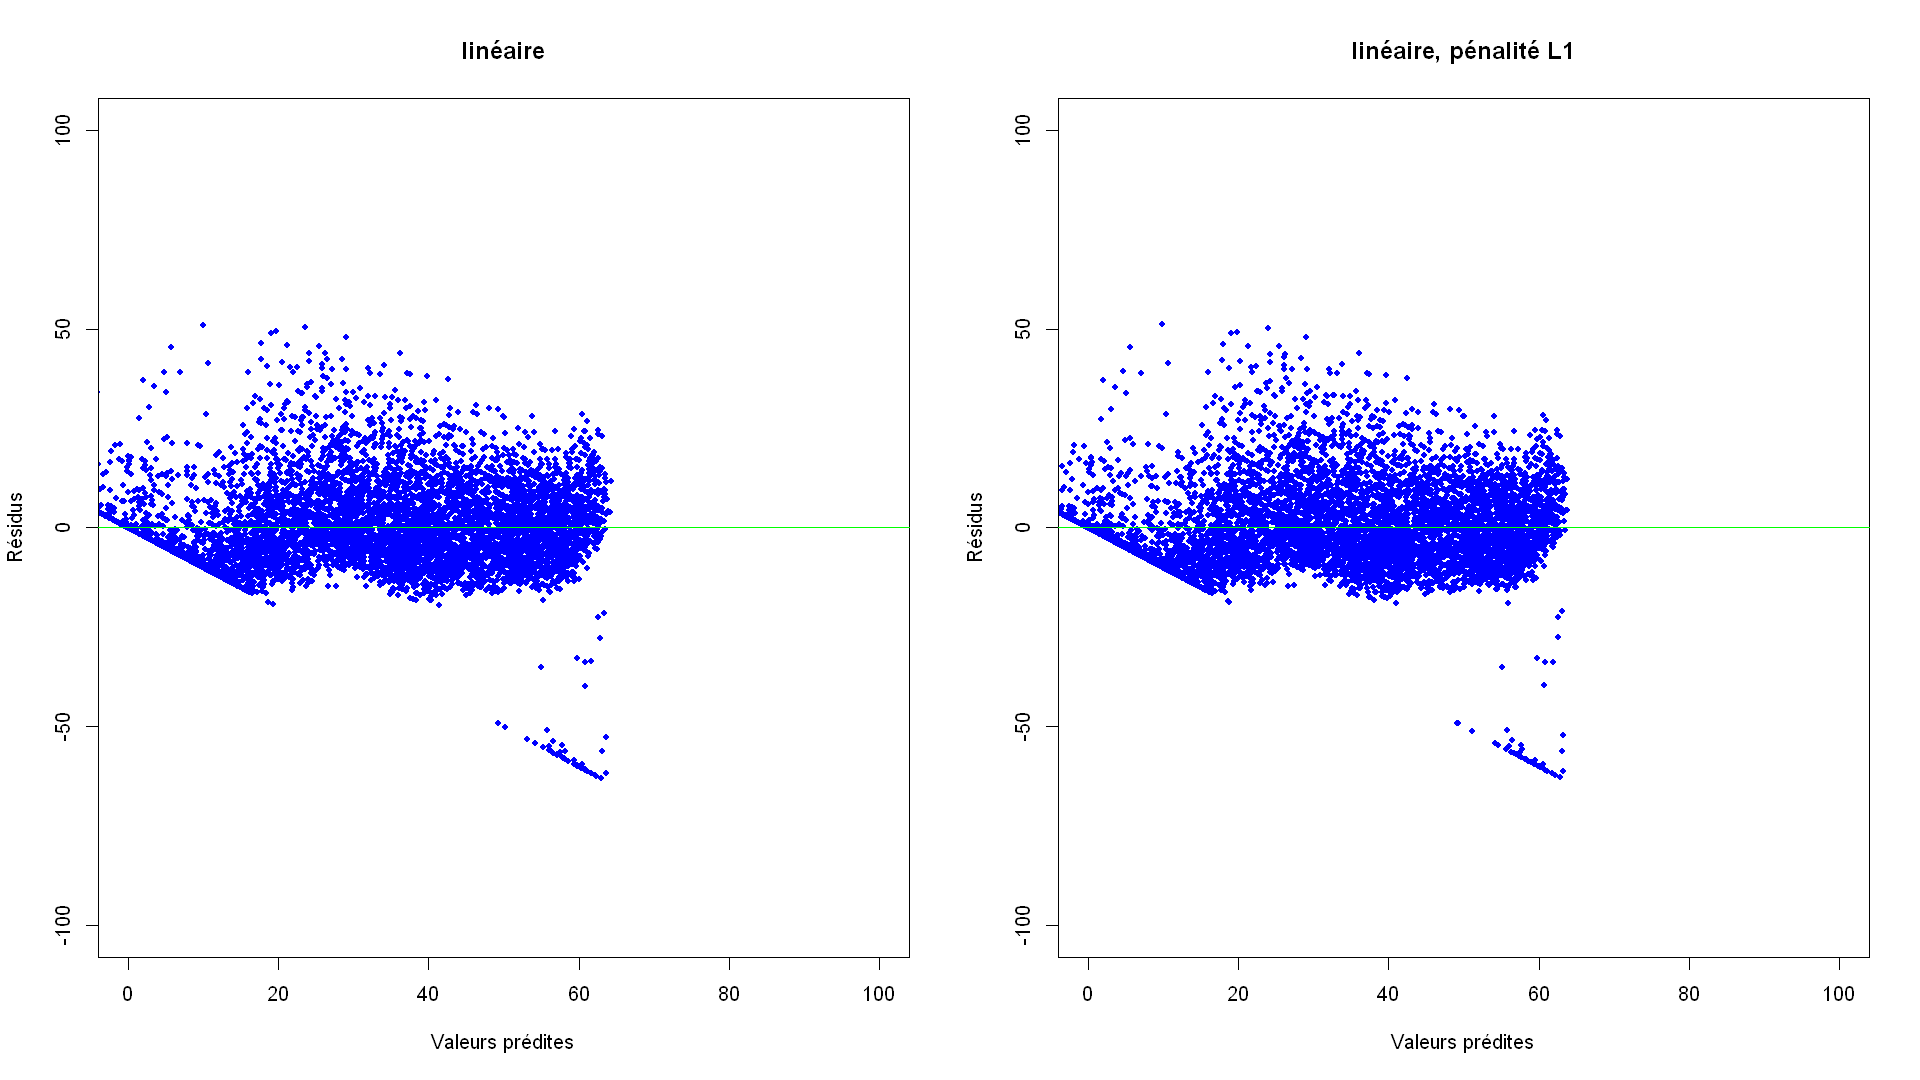

In [132]:
fit.lasso <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat)
res.lasso <- X.train$popularity - fit.lasso

# Graphe des résidus
options(repr.plot.width = 16, repr.plot.height = 9)
par(mfrow = c(1, 2))

plot.res(fit.lm, res.lm, "linéaire")
plot.res(fit.lasso, res.lasso, "linéaire, pénalité L1")

[1] "Mean Squared Error: 119.7818"
[1] "R2 Score: 0.7549"
[1] "Explained Variance Score: 0.7548"
[1] "Prediction error: 35 %"
[1] "Accuracy: 65 %"
       true predicted
126891    0  8.795592
147565   26 33.555836
82623    32 28.318924


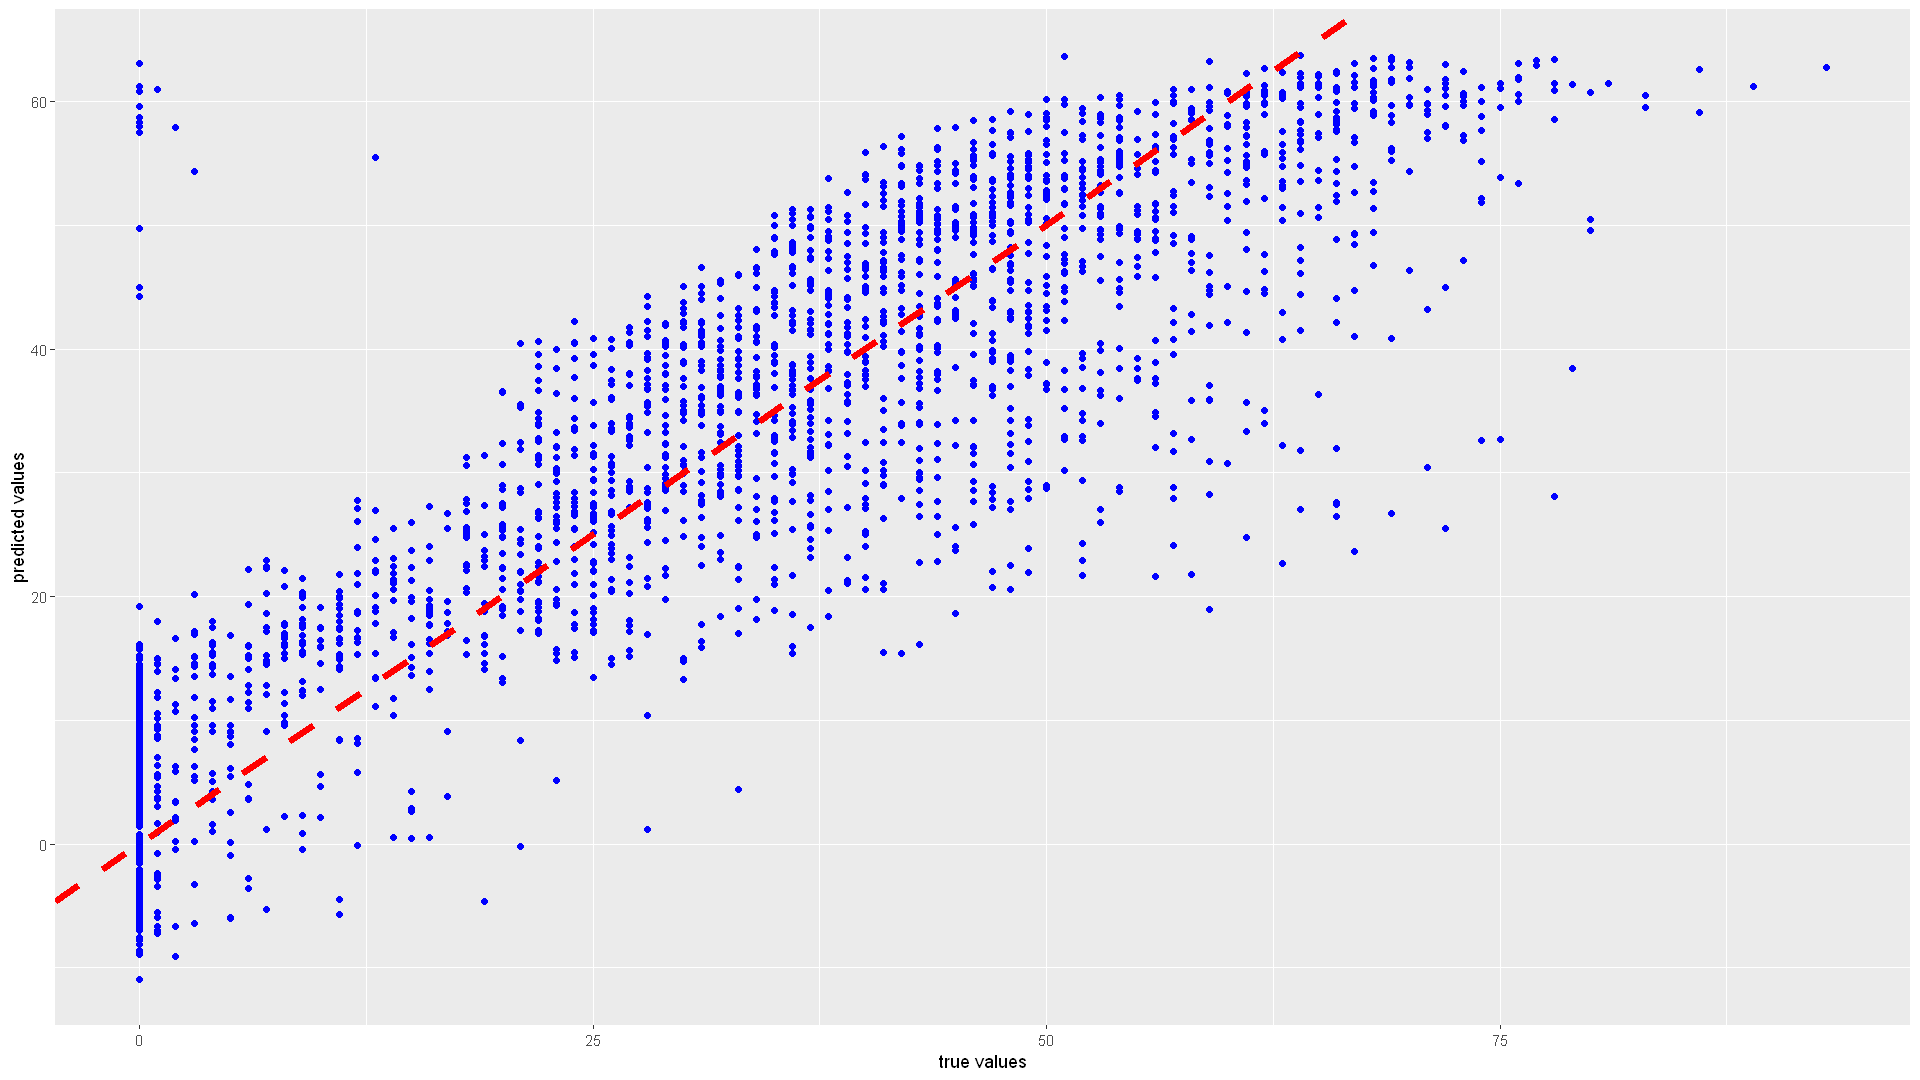

In [133]:
pred.reg.lasso <- predict(reg.lasso.cv, newx = x.mat2, s = "lambda.min")
pred.reg.lasso <- pred.reg.lasso[, 1]

plot.regression.results(y.test.reg, y.test.class, pred.reg.lasso)

In [134]:
mse.scores[2] <- round(sum((pred.reg.lasso - y.test.reg)^2)/ntest, 4)
r2.scores[2] <- round(cor(y.test.reg, pred.reg.lasso)^2, 4)
evs.scores[2] <- round(1 - var(y.test.reg - pred.reg.lasso)/var(y.test.reg), 4)
thresholding.scores[2] <- threshold.score(pred.reg.lasso, y.test.class)

#### Penalisation Ridge

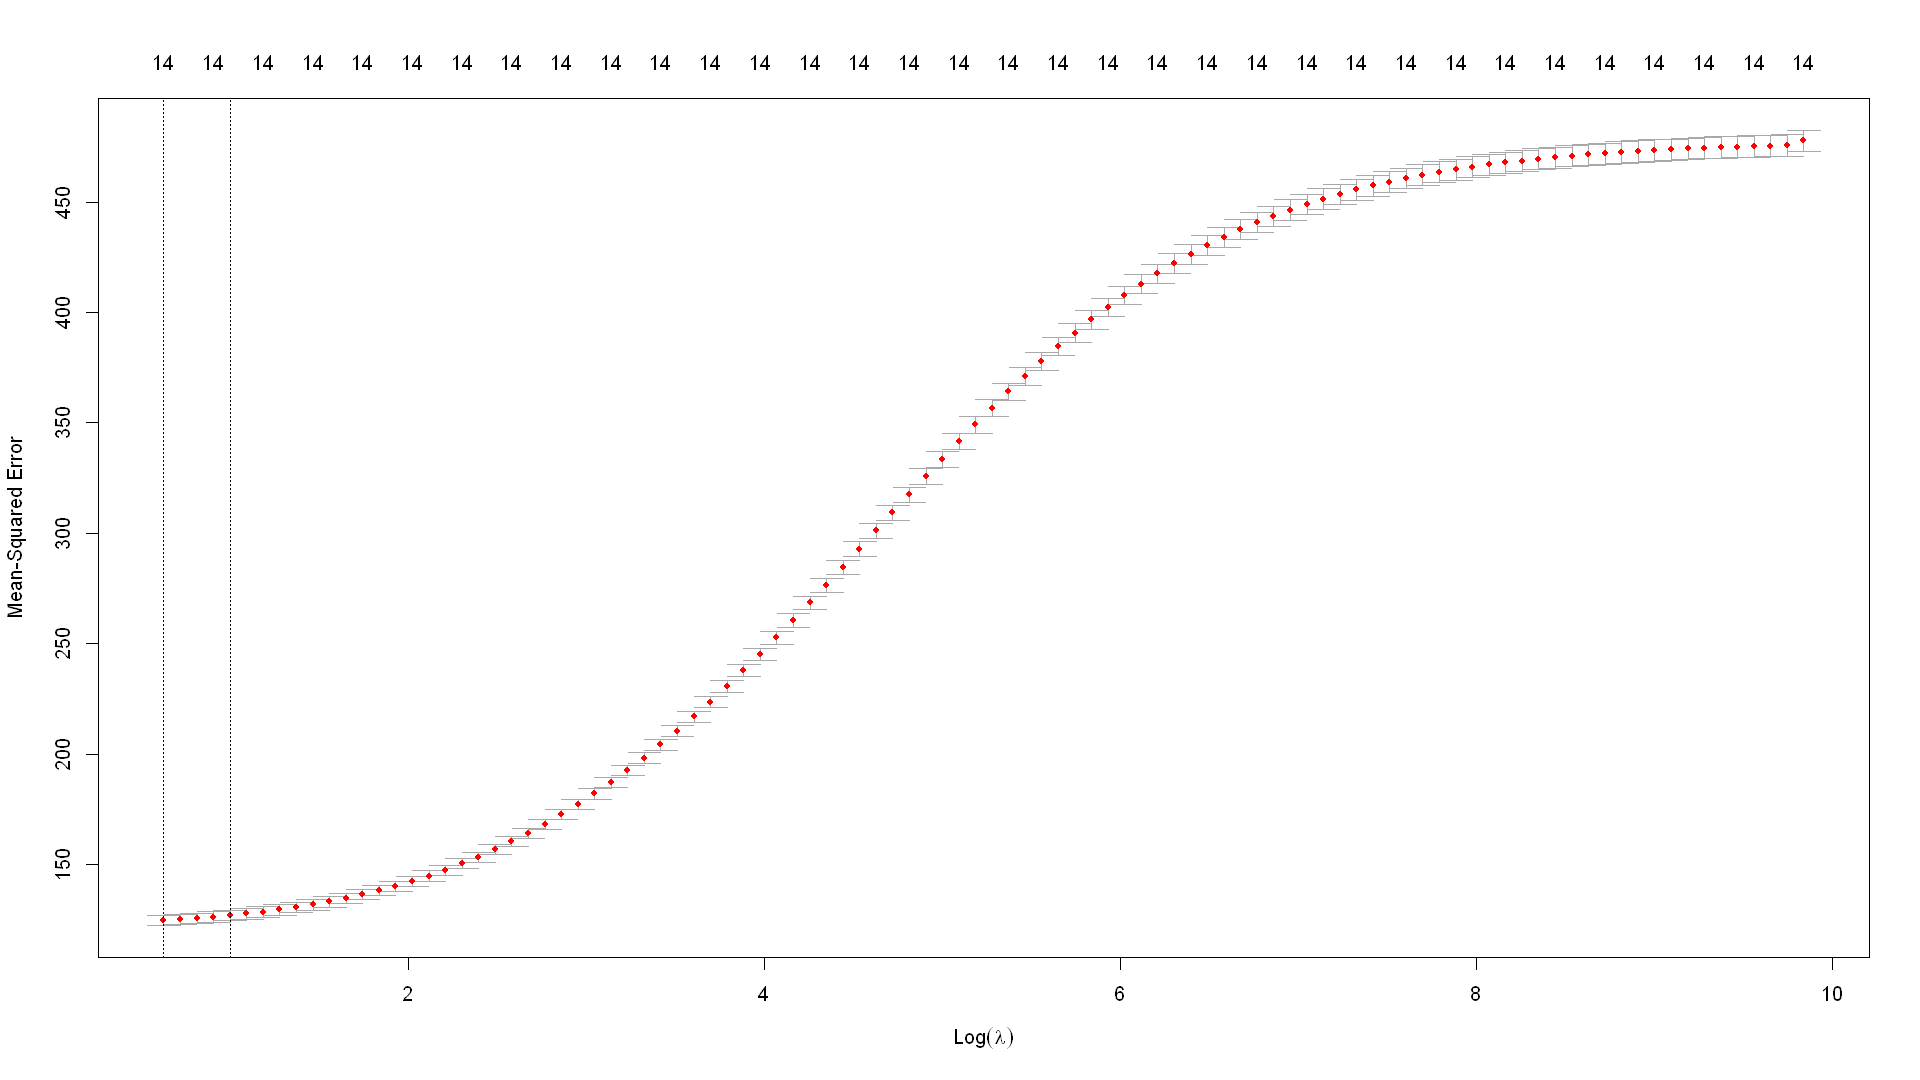

In [135]:
reg.ridge.cv <- cv.glmnet(y = X.train$popularity, x = x.mat, alpha = 0)

plot(reg.ridge.cv)

In [136]:
paste("CV estimate of lambda :", round(reg.ridge.cv$lambda.1se, 3))
coef(reg.ridge.cv, s = "lambda.1se")

[1] "CV estimate of lambda : 2.718"

15 x 1 sparse Matrix of class "dgCMatrix"
                            1
(Intercept)      31.711217986
valence          -0.614441680
year             14.081853847
acousticness     -2.324728511
duration          0.010174833
energy            0.538976676
instrumentalness -1.458358371
key              -0.007070436
liveness         -0.512936005
loudness          0.455638248
mode0            -0.011665600
mode1             0.009562232
speechiness      -1.699522822
tempo             0.051653903
dance_norm        0.925344475

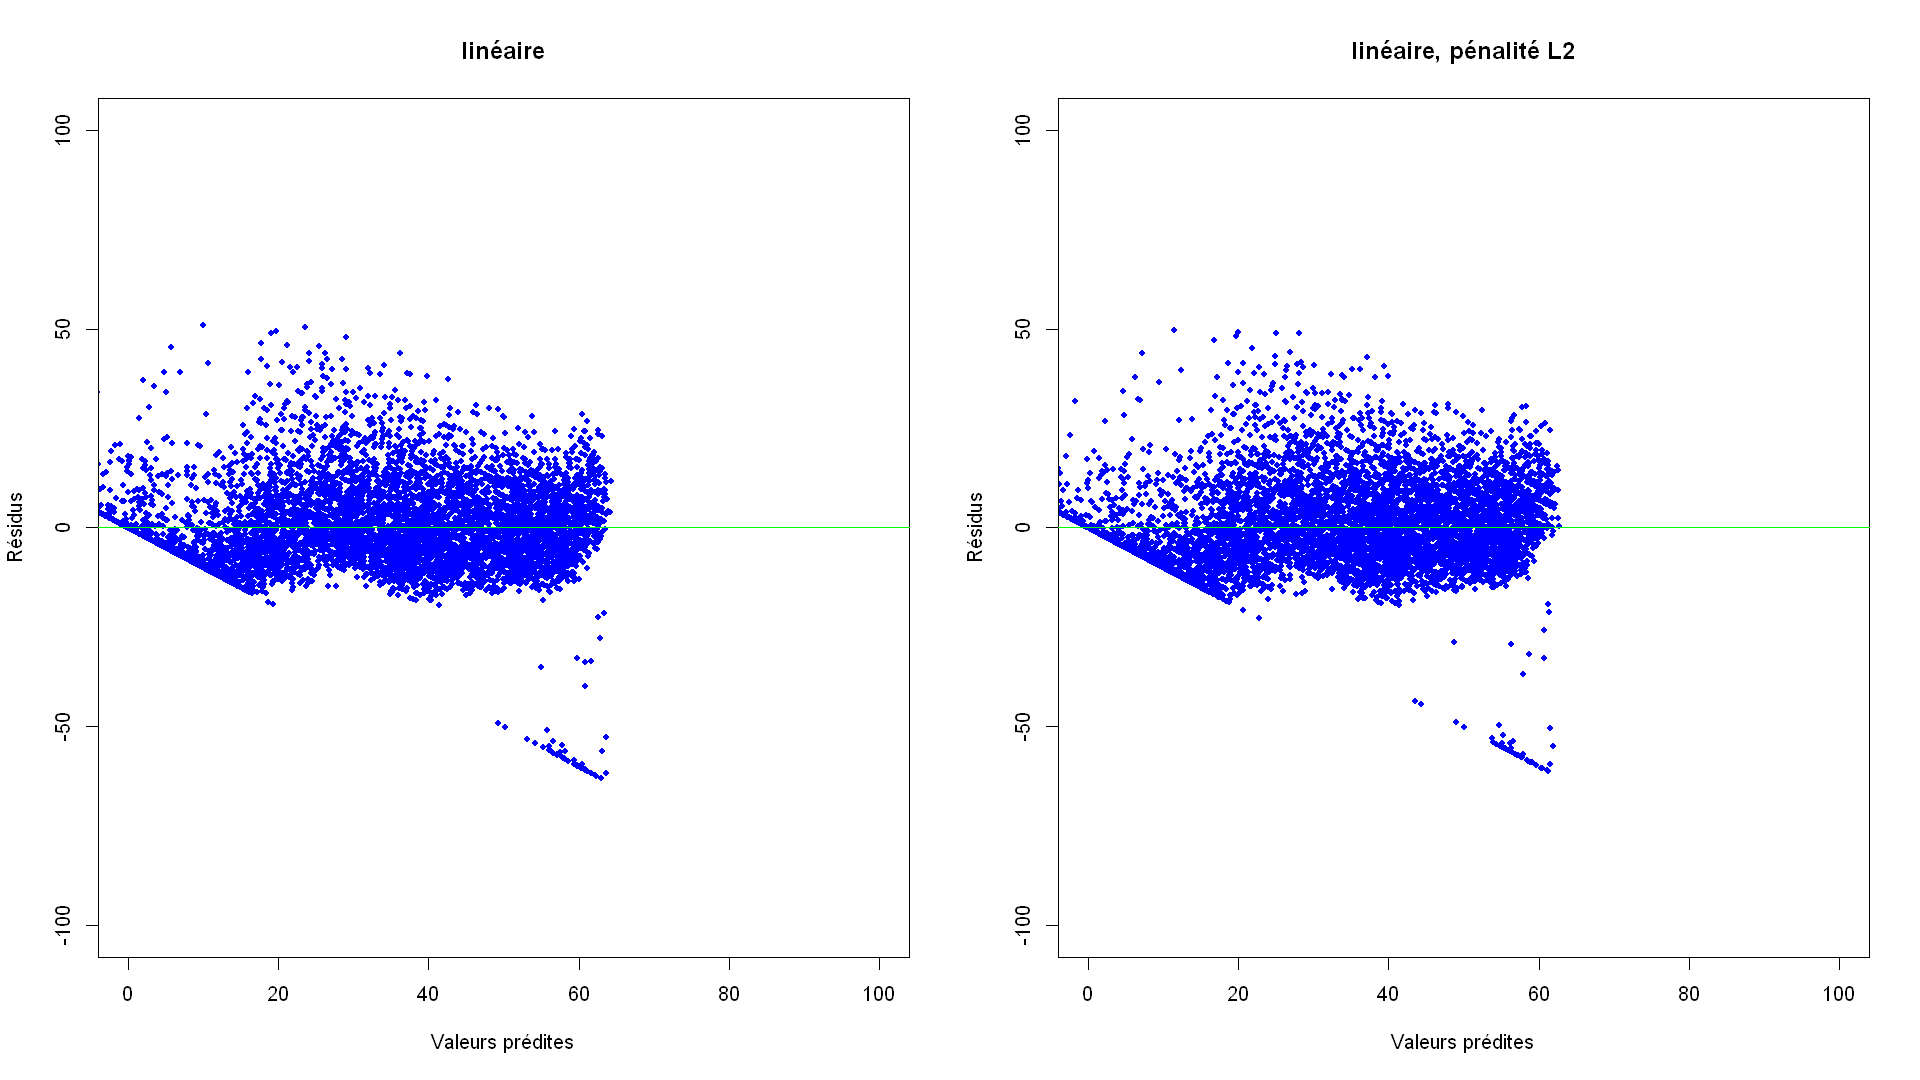

In [137]:
fit.ridge <- predict(reg.ridge.cv, s = "lambda.min", newx = x.mat)
res.ridge <- X.train$popularity - fit.ridge

options(repr.plot.width = 16, repr.plot.height = 9)
par(mfrow = c(1, 2))

plot.res(fit.lm, res.lm, "linéaire")
plot.res(fit.ridge, res.ridge, "linéaire, pénalité L2")

[1] "Mean Squared Error: 122.4089"
[1] "R2 Score: 0.7529"
[1] "Explained Variance Score: 0.7494"
[1] "Prediction error: 34.9 %"
[1] "Accuracy: 65.1 %"
       true predicted
126891    0  7.693779
147565   26 33.344787
82623    32 28.926847


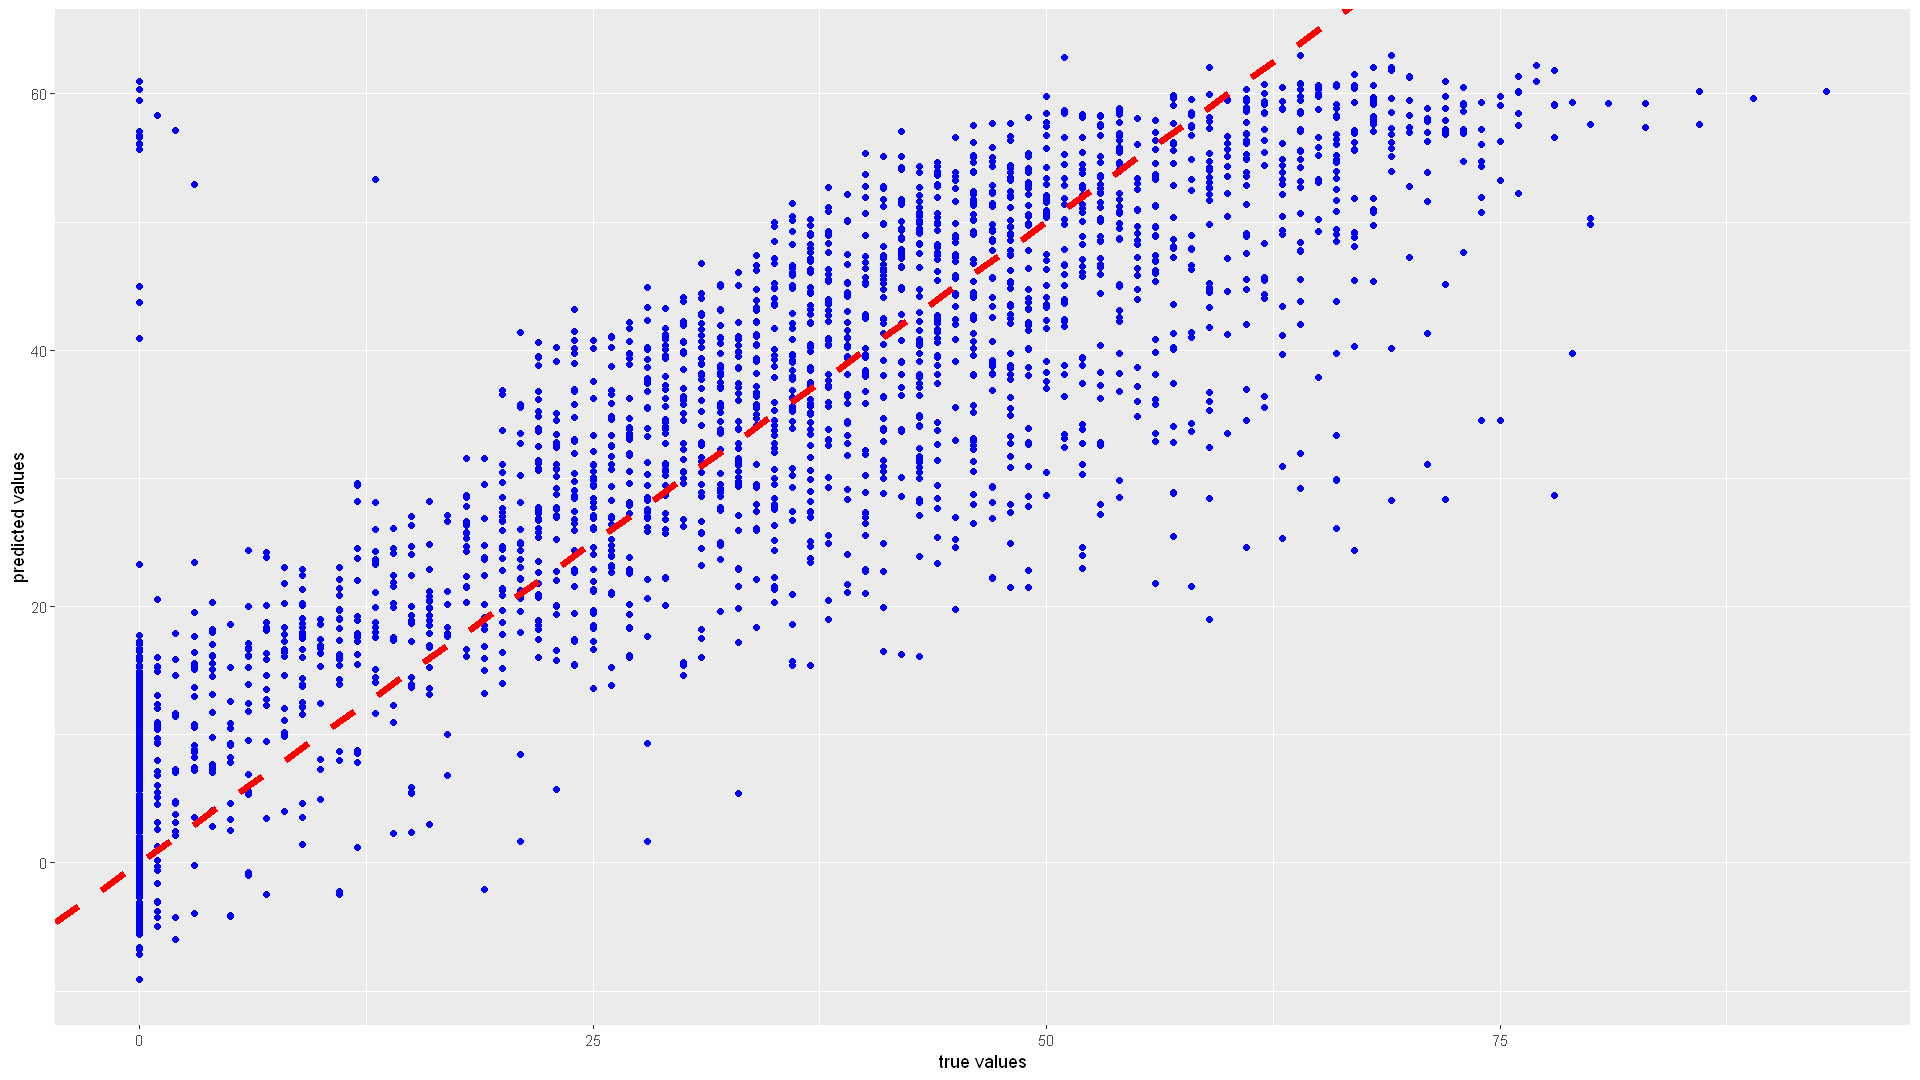

In [138]:
pred.reg.ridge <- predict(reg.ridge.cv, newx = x.mat2, s = "lambda.min")
pred.reg.ridge <- pred.reg.ridge[, 1]

plot.regression.results(y.test.reg, y.test.class, pred.reg.ridge)

In [139]:
mse.scores[3] <- round(sum((pred.reg.ridge - y.test.reg)^2)/ntest, 4)
r2.scores[3] <- round(cor(y.test.reg, pred.reg.ridge)^2, 4)
evs.scores[3] <- round(1 - var(y.test.reg - pred.reg.ridge)/var(y.test.reg), 4)
thresholding.scores[3] <- threshold.score(pred.reg.ridge, y.test.class)

#### Penalisation ElasticNet

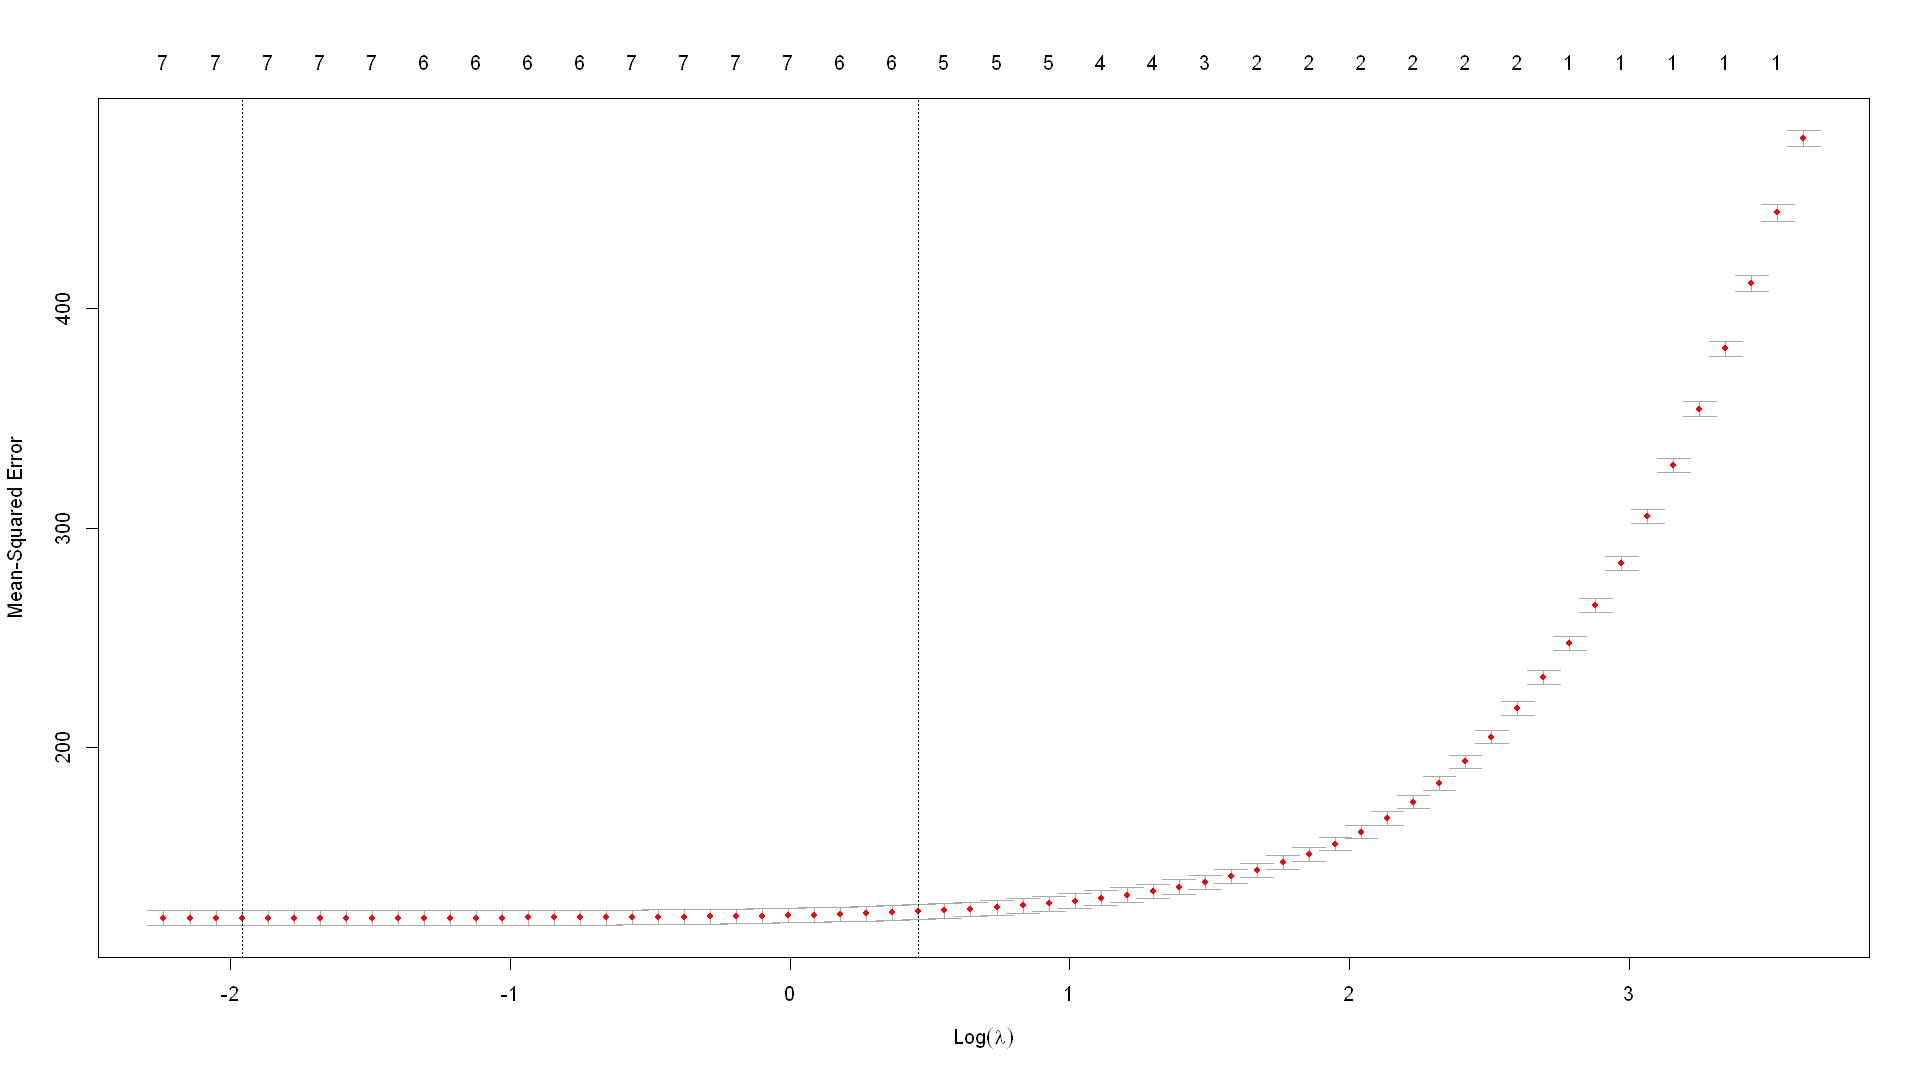

In [140]:
reg.EN.cv <- cv.glmnet(y = X.train$popularity, x = x.mat, alpha=0.5)

plot(reg.EN.cv)

In [141]:
paste("CV estimate of lambda :", round(reg.EN.cv$lambda.1se, 3))
coef(reg.EN.cv, s = "lambda.1se")

[1] "CV estimate of lambda : 1.585"

15 x 1 sparse Matrix of class "dgCMatrix"
                          1
(Intercept)      31.6762667
valence           .        
year             16.0720151
acousticness     -1.4273157
duration          .        
energy            .        
instrumentalness -0.8093525
key               .        
liveness          .        
loudness          0.1410680
mode0             .        
mode1             .        
speechiness      -0.5877978
tempo             .        
dance_norm        .        

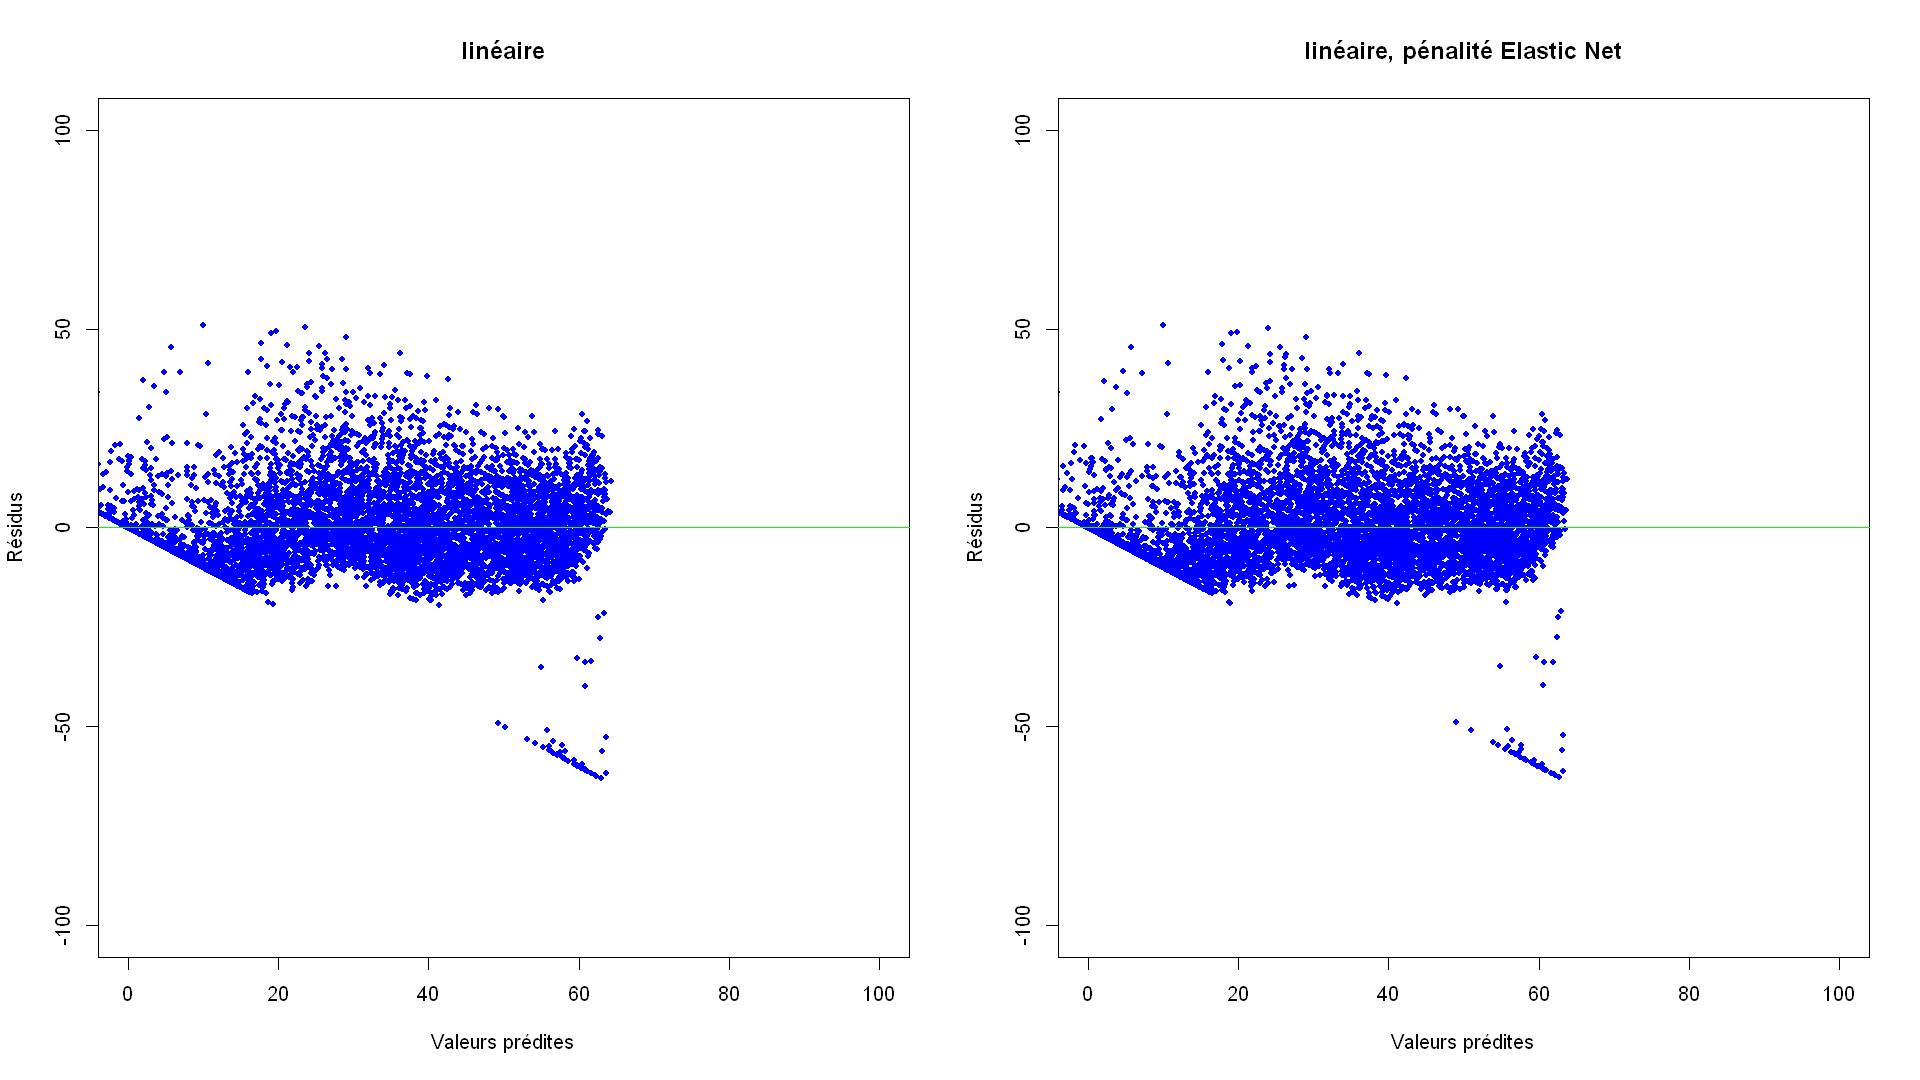

In [142]:
fit.EN <- predict(reg.EN.cv, s = "lambda.min", newx = x.mat)
res.EN <- X.train$popularity - fit.EN

options(repr.plot.width = 16, repr.plot.height = 9)
par(mfrow = c(1, 2))

plot.res(fit.lm, res.lm, "linéaire")
plot.res(fit.EN, res.EN, "linéaire, pénalité Elastic Net")

[1] "Mean Squared Error: 119.7862"
[1] "R2 Score: 0.7549"
[1] "Explained Variance Score: 0.7548"
[1] "Prediction error: 35.1 %"
[1] "Accuracy: 64.9 %"
       true predicted
126891    0  8.777986
147565   26 33.550935
82623    32 28.342989


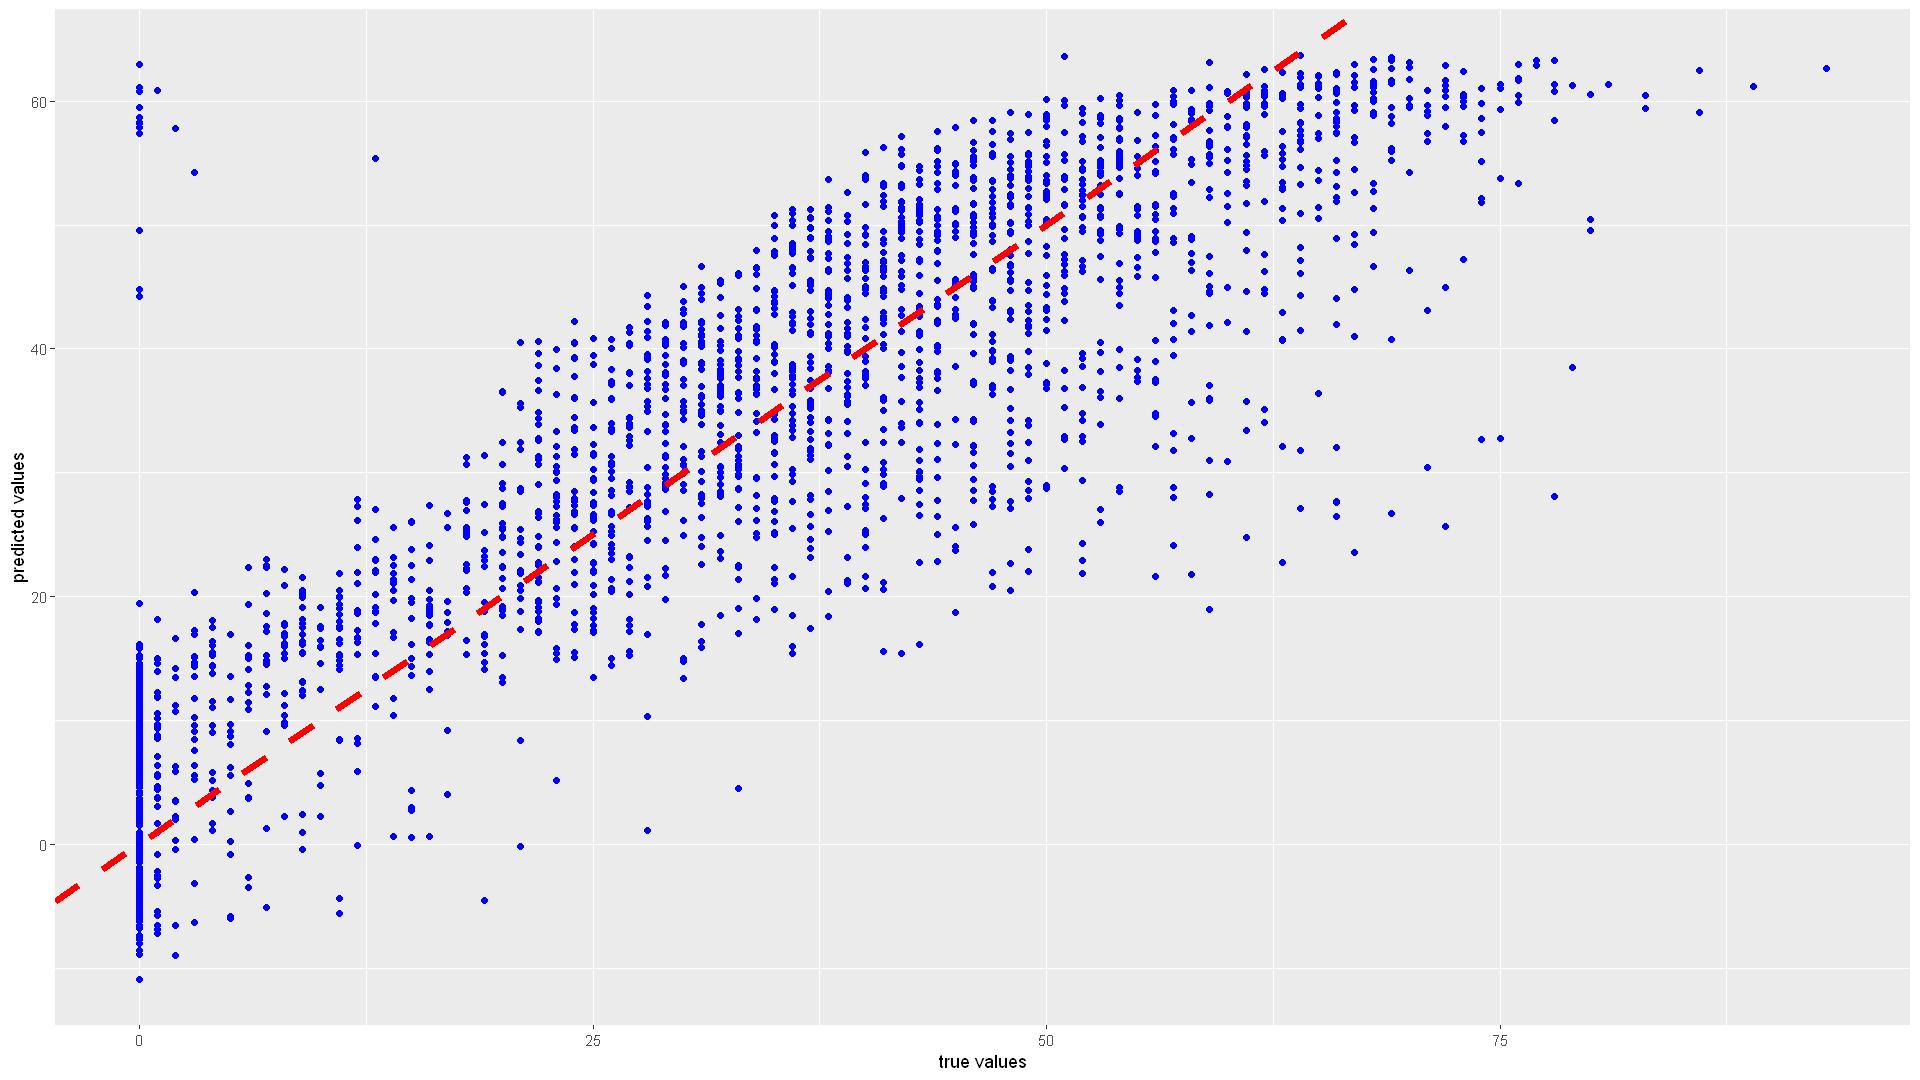

In [143]:
pred.reg.EN <- predict(reg.EN.cv, newx = x.mat2, s = "lambda.min")
pred.reg.EN <- pred.reg.EN[, 1]

plot.regression.results(y.test.reg, y.test.class, pred.reg.EN)

In [144]:
mse.scores[4] <- round(sum((pred.reg.EN - y.test.reg)^2)/ntest, 4)
r2.scores[4] <- round(cor(y.test.reg, pred.reg.EN)^2, 4)
evs.scores[4] <- round(1 - var(y.test.reg - pred.reg.EN)/var(y.test.reg), 4)
thresholding.scores[4] <- threshold.score(pred.reg.EN, y.test.class)

### Random Forest

mtry = 2  OOB error = 11.78398 
Searching left ...
Searching right ...
mtry = 3 	OOB error = 4.541424 
0.6146103 2e-05 
mtry = 4 	OOB error = 1.816811 
0.5999467 2e-05 
mtry = 6 	OOB error = 0.3160415 
0.826046 2e-05 
mtry = 9 	OOB error = 0.1034114 
0.6727918 2e-05 
mtry = 13 	OOB error = 0.1219135 
-0.1789176 2e-05 


,mtry,OOBError
2,2,11.7839771
3,3,4.5414238
4,4,1.8168115
6,6,0.3160415
9,9,0.1034114
13,13,0.1219135


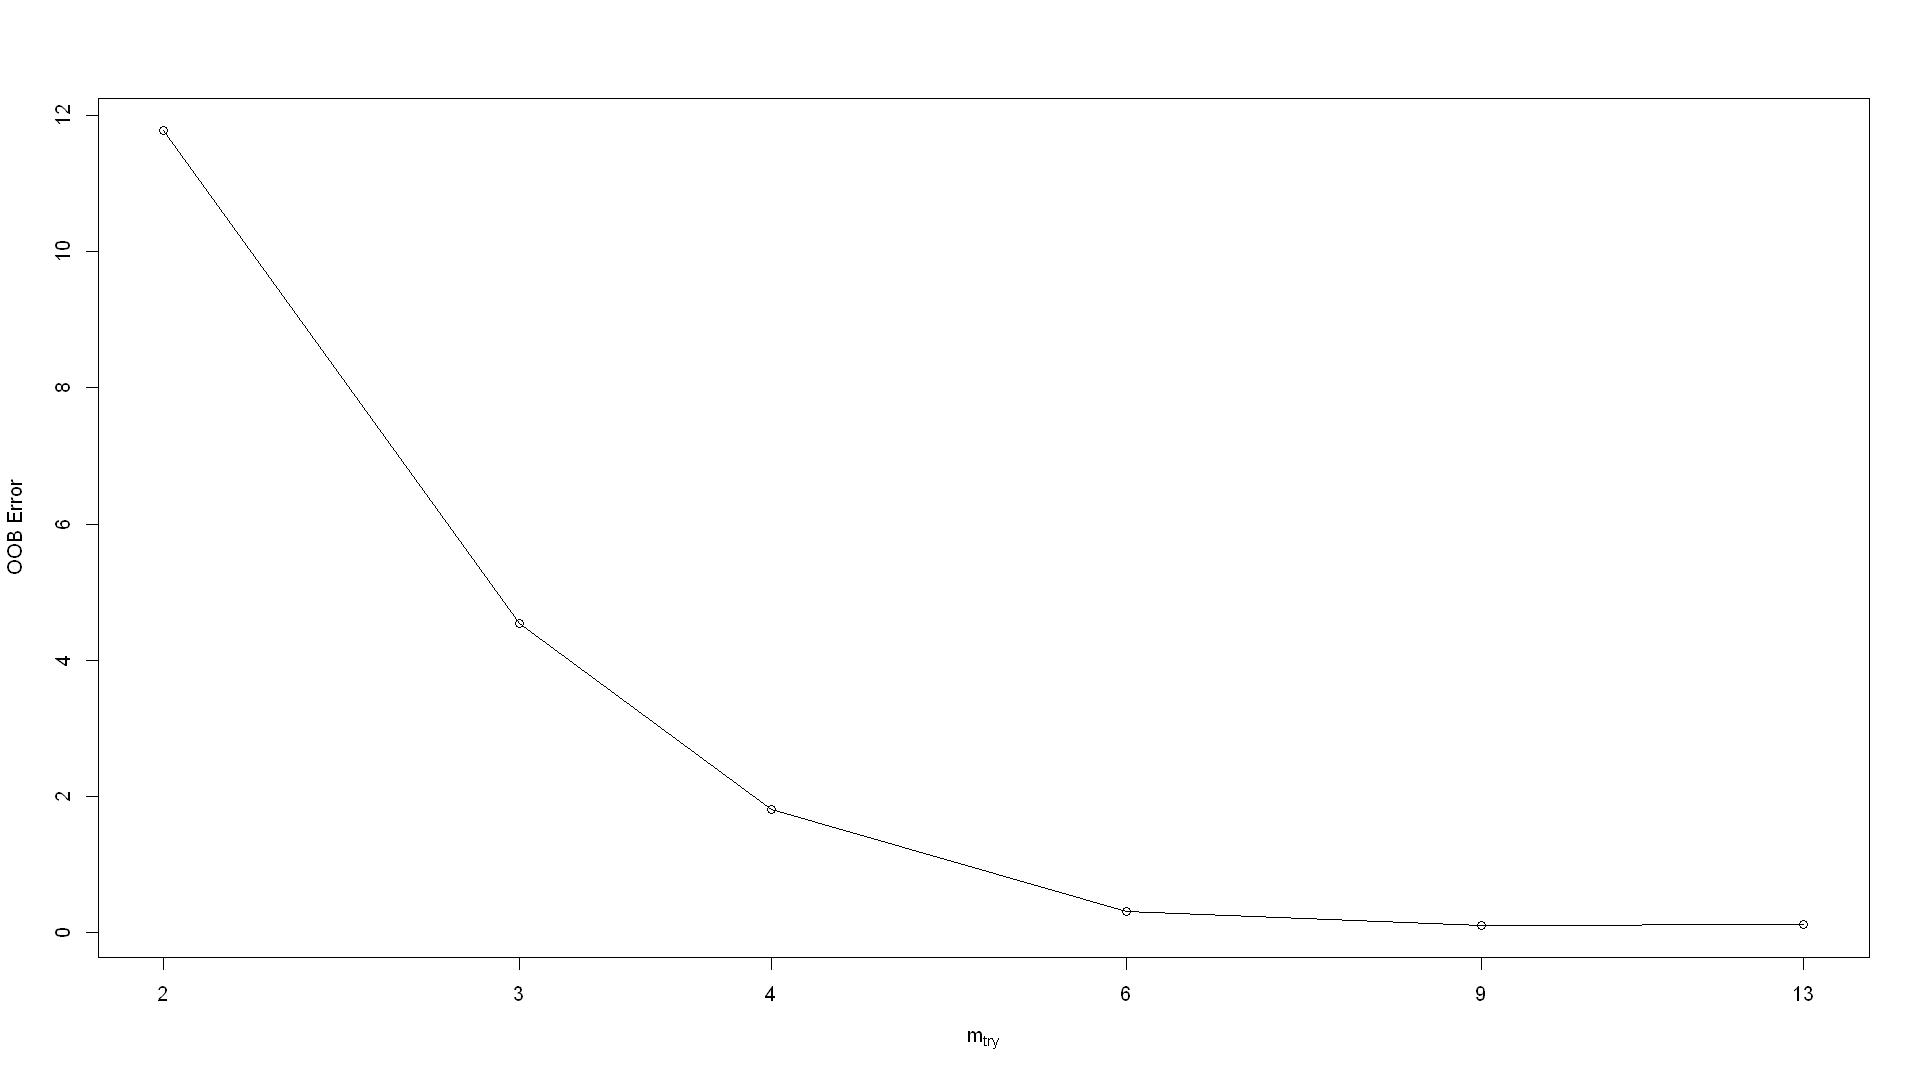

In [145]:
set.seed(1)
eps <- 2e-05
bestMtry <- tuneRF(X.train[, -10], X.train$popularity, mtryStart = 2,
                   stepFactor = 1.5, improve = eps, ntree = 500, plot = TRUE)

bestMtry

In [146]:
rf.reg <- randomForest(popularity ~ ., data = X.train, mtry = 9,
                       xtest = X.test[, -10], ytest = X.test$popularity,
                       ntree = 500, do.trace = 50, importance = TRUE)

     |      Out-of-bag   |       Test set    |
Tree |      MSE  %Var(y) |      MSE  %Var(y) |
  50 |      112    23.46 |    102.9    21.08 |
 100 |    108.7    22.77 |    102.8    21.06 |
 150 |    107.5    22.51 |    101.4    20.77 |
 200 |    106.9    22.39 |    100.8    20.64 |
 250 |    106.7    22.35 |    100.2    20.54 |
 300 |    106.7    22.34 |    100.4    20.56 |
 350 |    106.5    22.31 |    100.2    20.53 |
 400 |    106.3    22.26 |    100.2    20.52 |
 450 |    106.2    22.23 |      100    20.49 |
 500 |    106.2    22.23 |    100.1    20.50 |


In [147]:
sort(round(importance(rf.reg), 2)[, 1], decreasing = TRUE)

year instrumentalness      speechiness       dance_norm 
          489.08            31.36            29.59            26.67 
    acousticness           energy         loudness          valence 
           26.21            25.07            24.25            23.60 
        duration            tempo         liveness             mode 
           19.63            16.20            12.43             0.39 
             key 
           -0.27

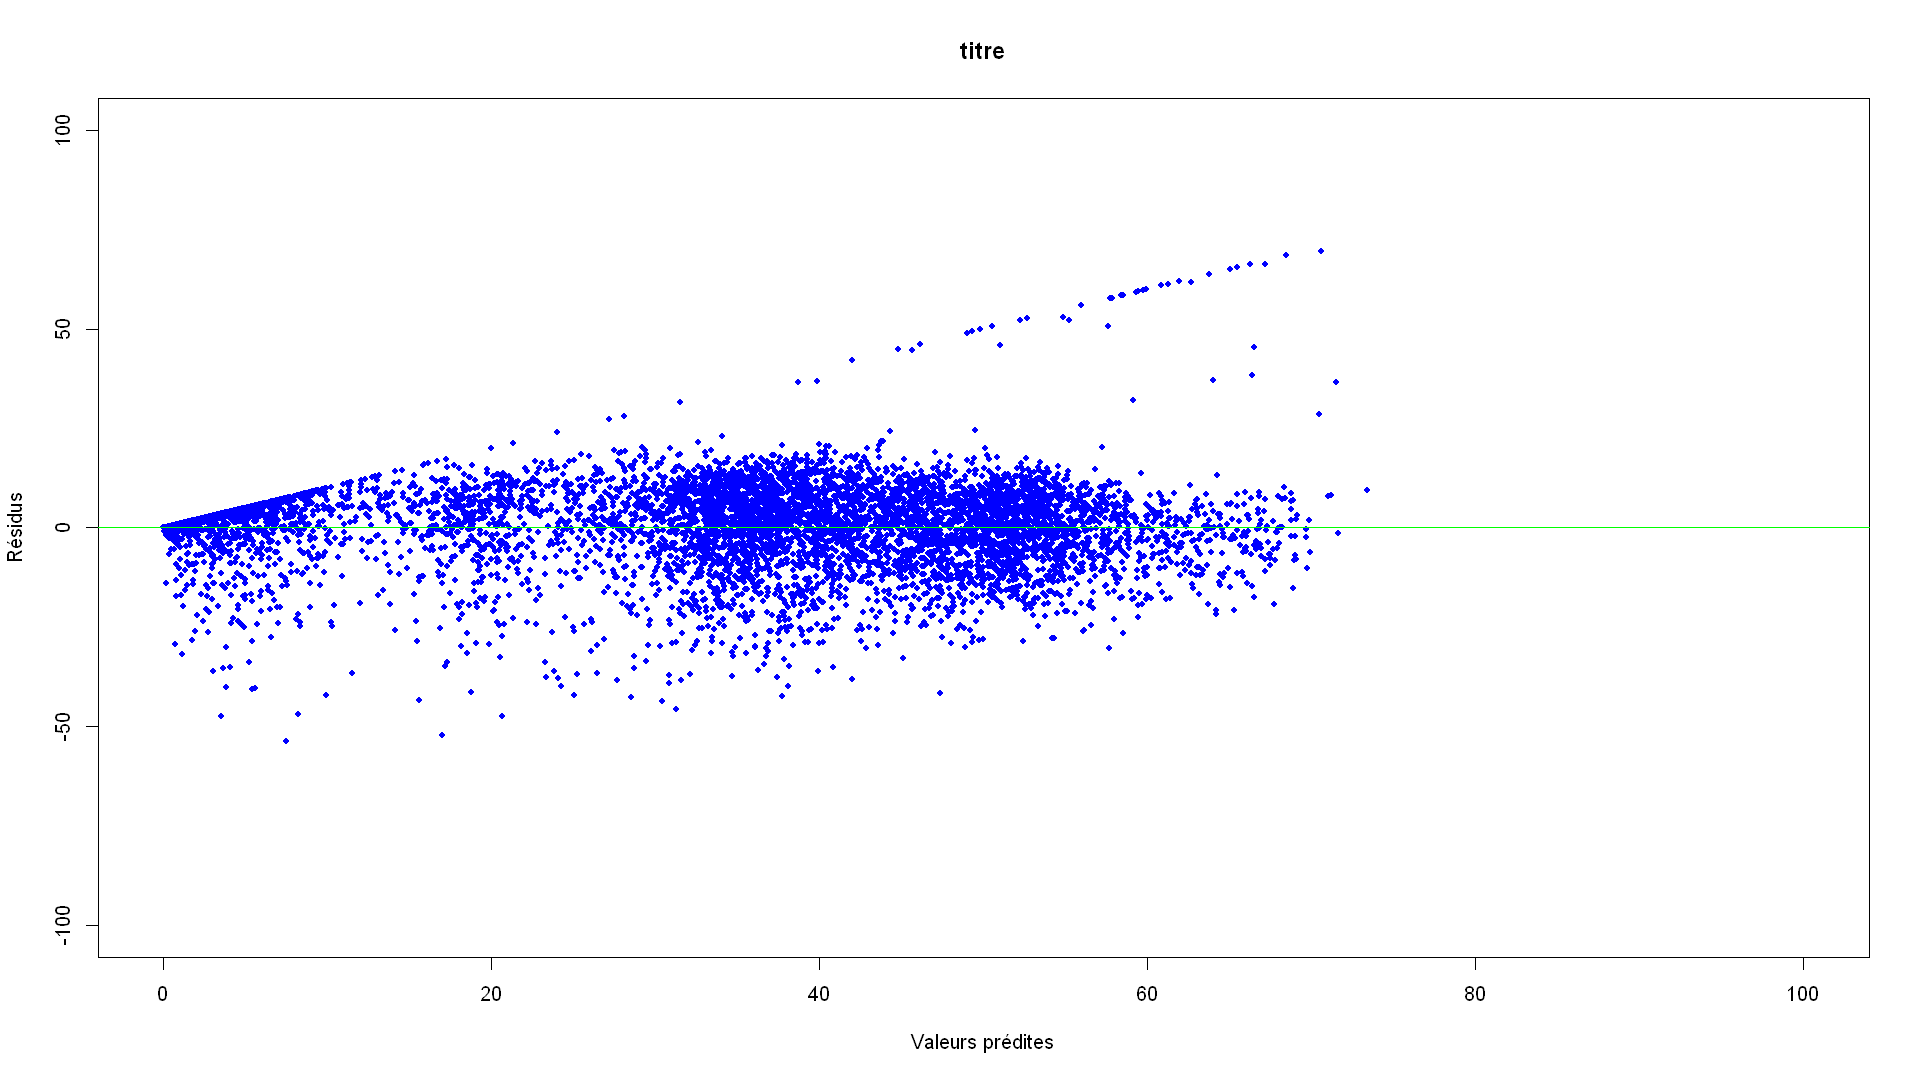

In [148]:
fit.rfr <- rf.reg$predicted
res.rfr <- fit.rfr - X.train$popularity
plot.res(fit.rfr, res.rfr)

[1] "Mean Squared Error: 100.0674"
[1] "R2 Score: 0.7962"
[1] "Explained Variance Score: 0.7961"
[1] "Prediction error: 28.9 %"
[1] "Accuracy: 71.1 %"
       true predicted
126891    0   5.22330
147565   26  34.00933
82623    32  34.49200


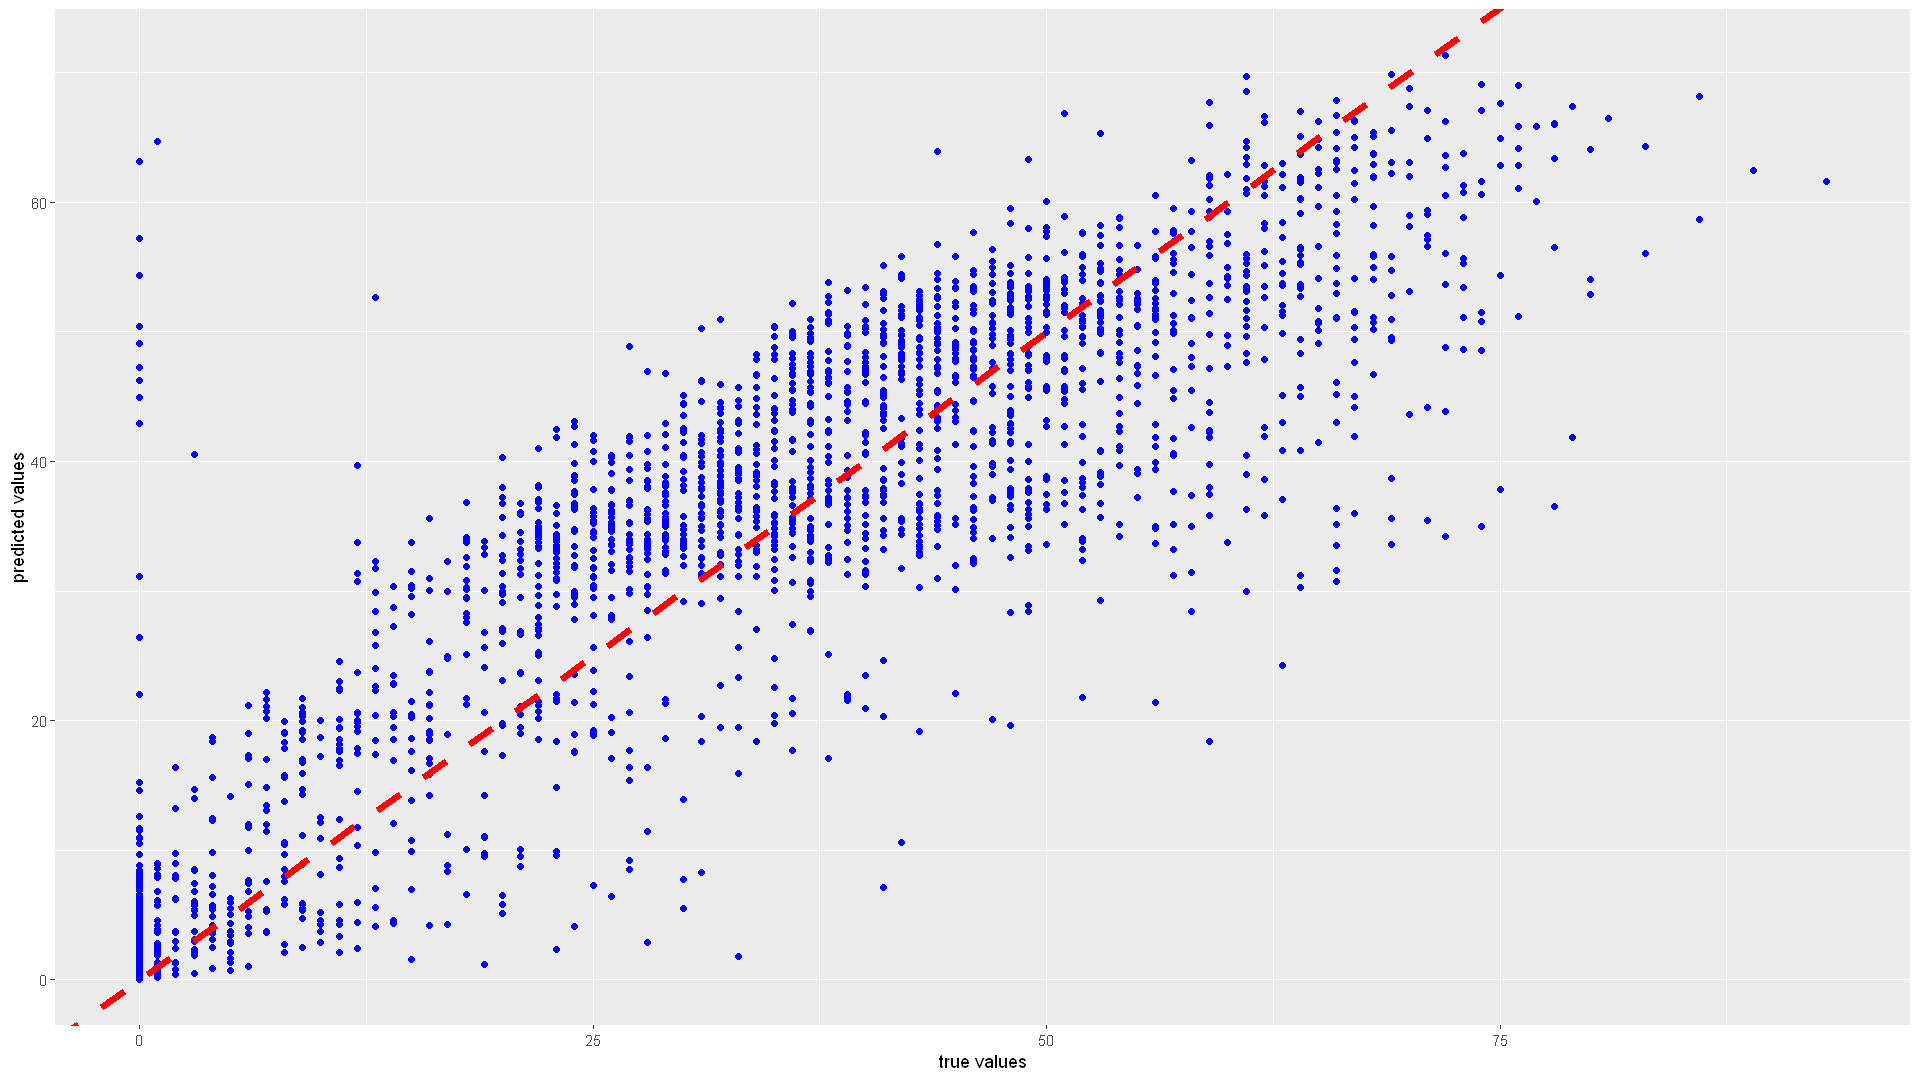

In [149]:
pred.rf.reg <- rf.reg$test$predicted
plot.regression.results(y.test.reg, y.test.class, pred.rf.reg)

In [150]:
mse.scores[5] <- round(sum((pred.rf.reg - y.test.reg)^2)/ntest, 4)
r2.scores[5] <- round(cor(y.test.reg, pred.rf.reg)^2, 4)
evs.scores[5] <- round(1 - var(y.test.reg - pred.rf.reg)/var(y.test.reg), 4)
thresholding.scores[5] <- threshold.score(pred.rf.reg, y.test.class)

### Decision Trees

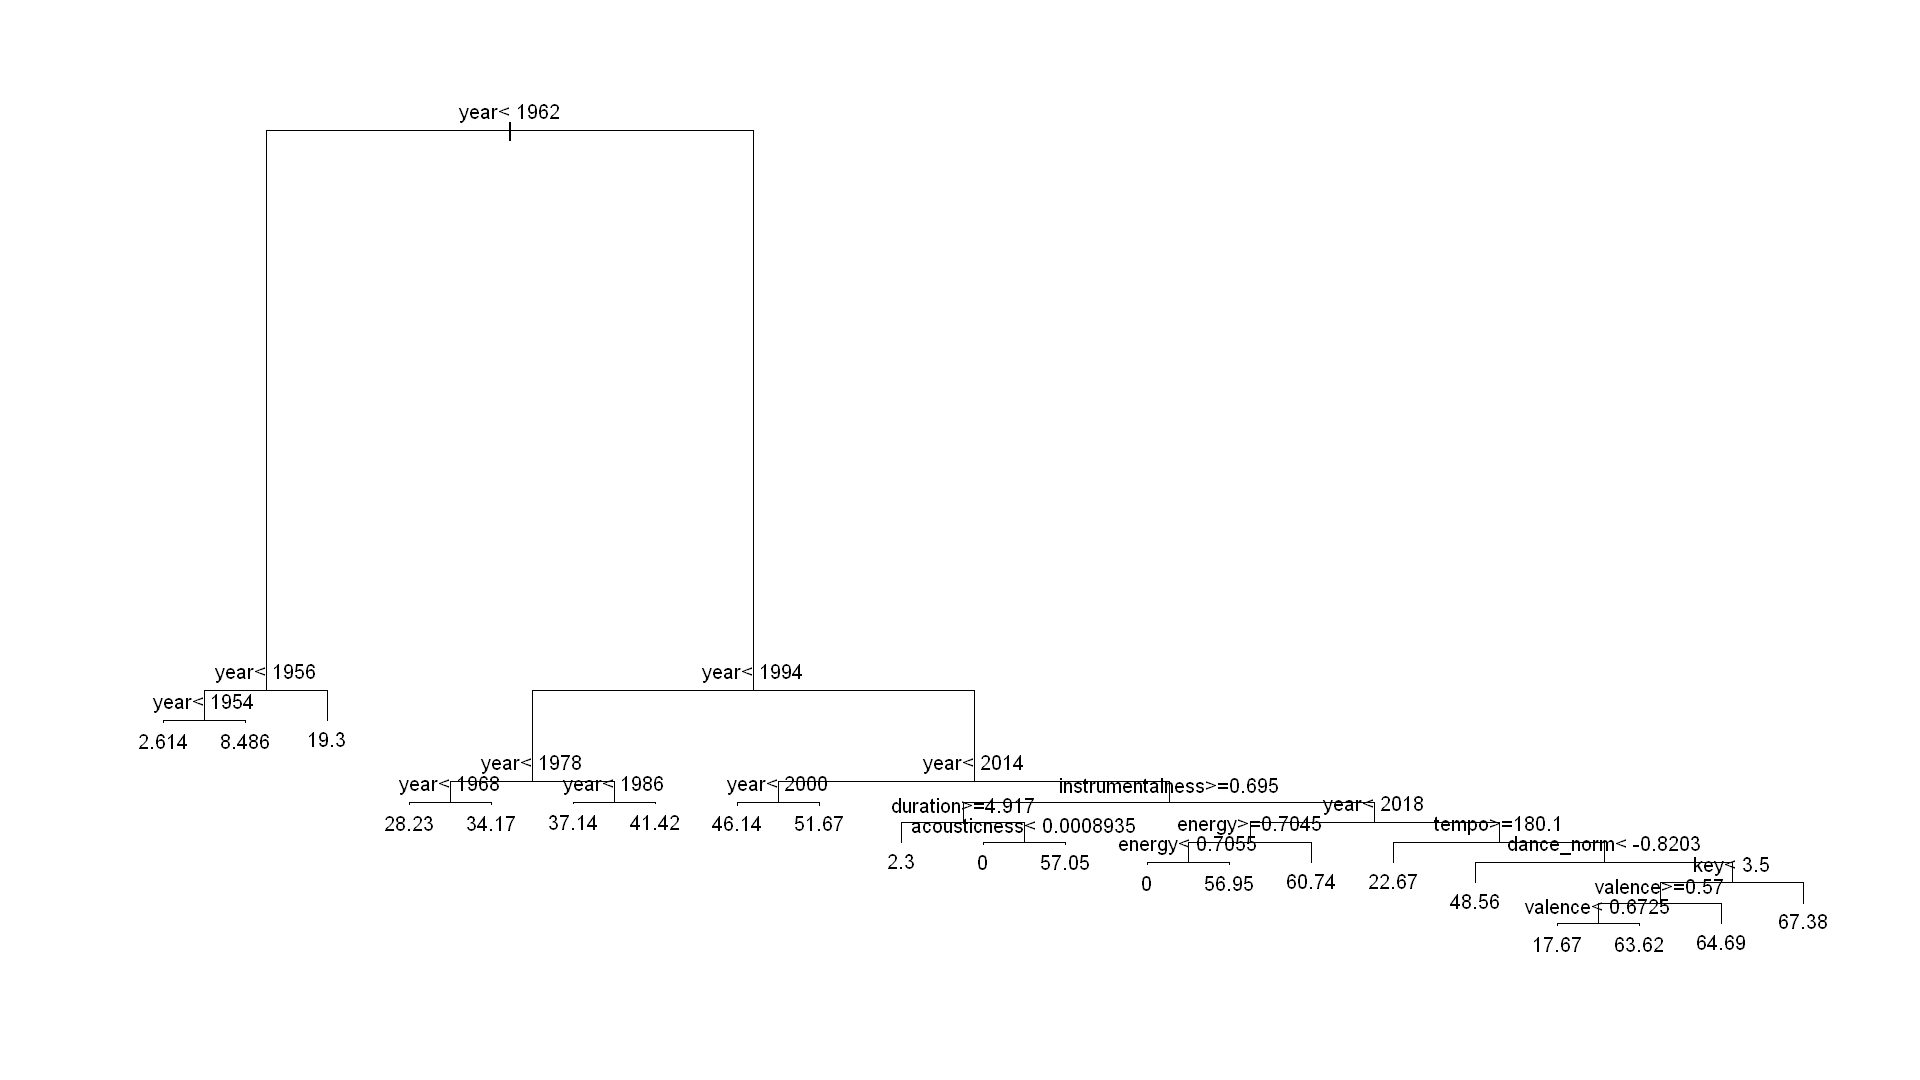

In [151]:
control <- rpart.control(minsplit = 20,
    minbucket = round(5 / 3),
    maxdepth = 30,
    cp = 0.001
)

tree.reg <- rpart(popularity ~ ., data = X.train, control = control)
plot(tree.reg)
text(tree.reg)

In [152]:
xmat <- xpred.rpart(tree.reg)
xerr <- (xmat - X.train$popularity)^2
CVerr <- apply(xerr, 2, sum)
CVerr  #    CP           erreur

# xmat_i = Y^chapeau_i est la valeur predite par le modèle qui n'a pas utilisé le
# fold conentant l'observation i xerr = (Y_i - Y_i^chapeau)^2 pour i=1,...,n

# L'erreur décroit avec la compléxité (ici ce n'est pas tout à fait le cas car
# xpred.rpart fait de la validation croisée sur l'echantillon d'apprentissage)

# En gras c'est les valeurs de gamma et à coté l'erreur estimée par validation
# croisée. On choisit le gamma avec l'erreur la plus petite.

0.803351300 0.244773076 0.056797236 0.020039118 0.010001834 0.006301812 
  3582800.1   1409666.0   1058699.7    941803.5    898901.2    876840.0 
0.004032179 0.003063180 0.002203758 0.001683593 0.001622828 0.001397161 
   868574.1    843919.6    832492.3    829854.4    827900.2    823587.0 
0.001171590 0.001061409 
   831618.9    831618.9

On cherche la valeur de *cp* correspondant à la plus petite erreur.

In [153]:
cp <- as.numeric(attributes(which.min(CVerr))$names)
cp

[1] 0.001397161

In [154]:
tree.reg <- rpart(popularity ~ ., data = X.train,
                  control = rpart.control(cp = cp))

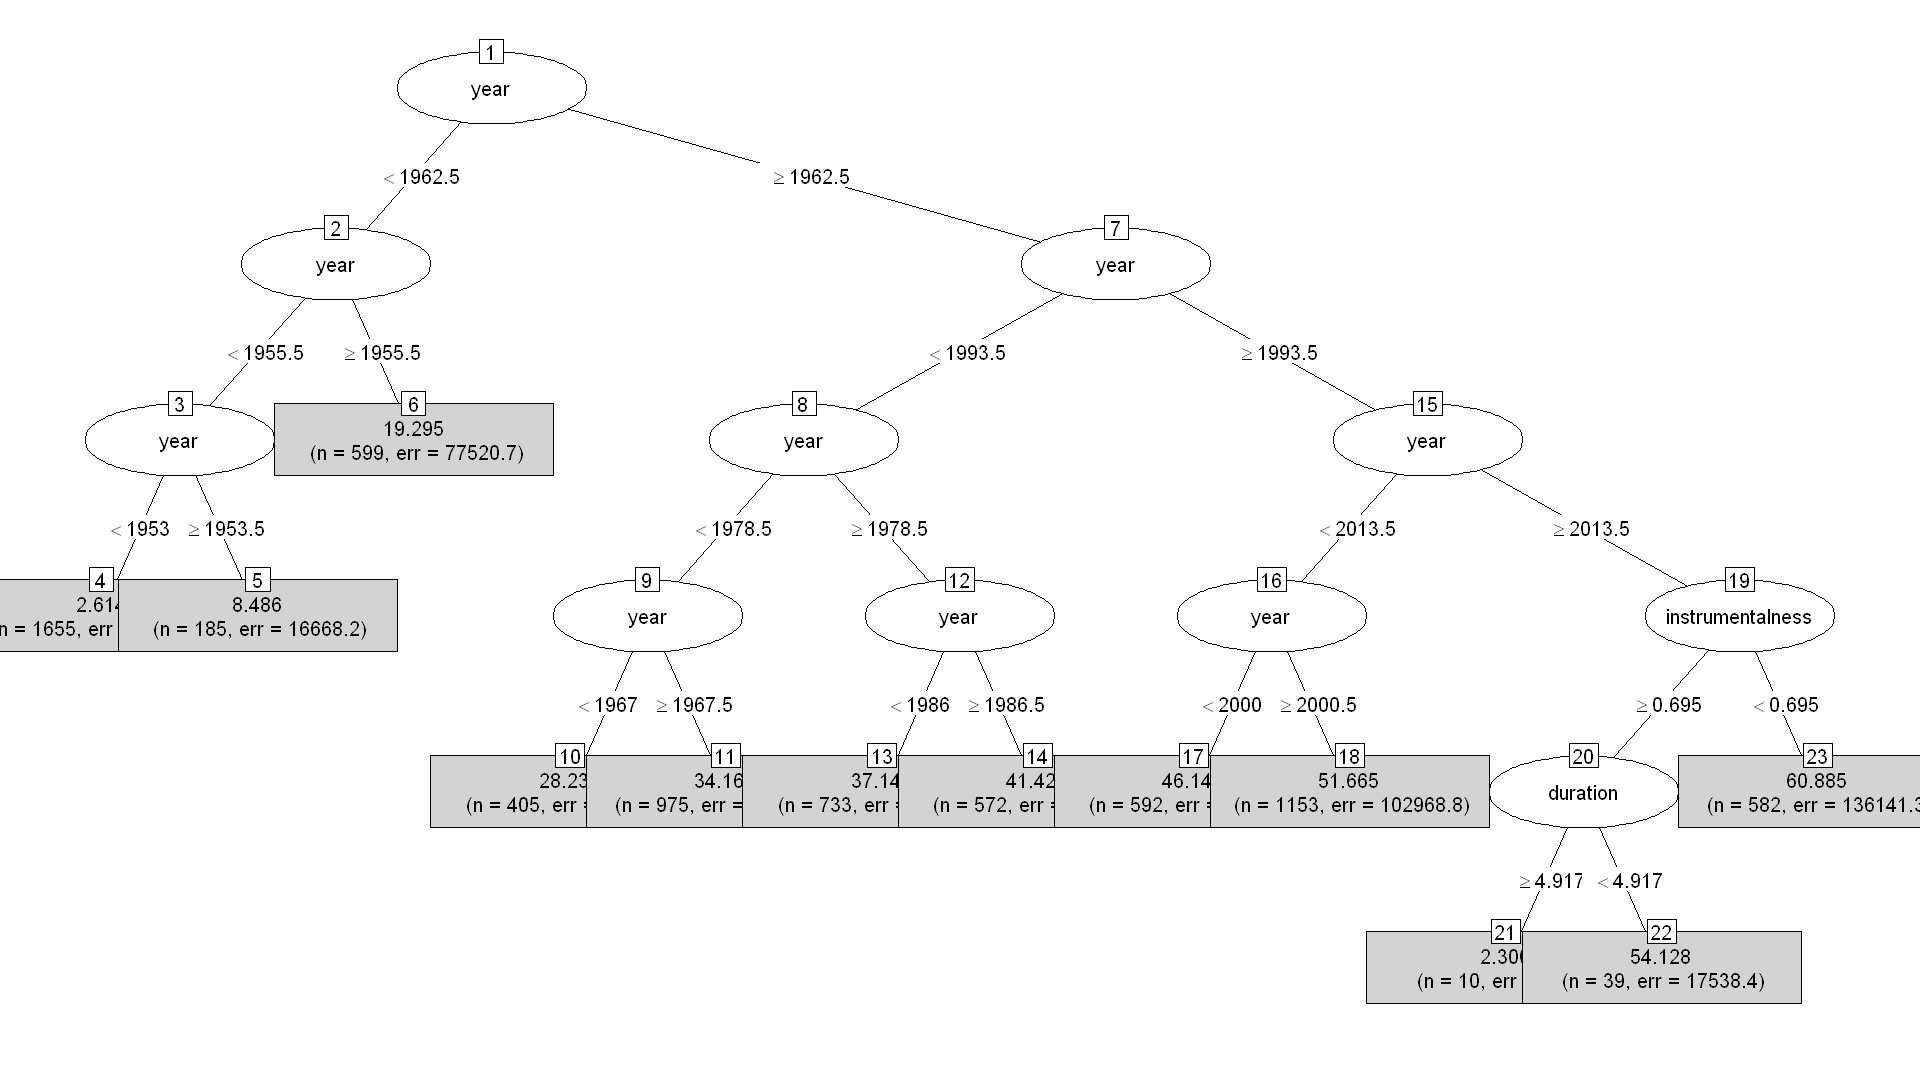

In [155]:
plot(as.party(tree.reg), type = "simple")

Graphe des résidus

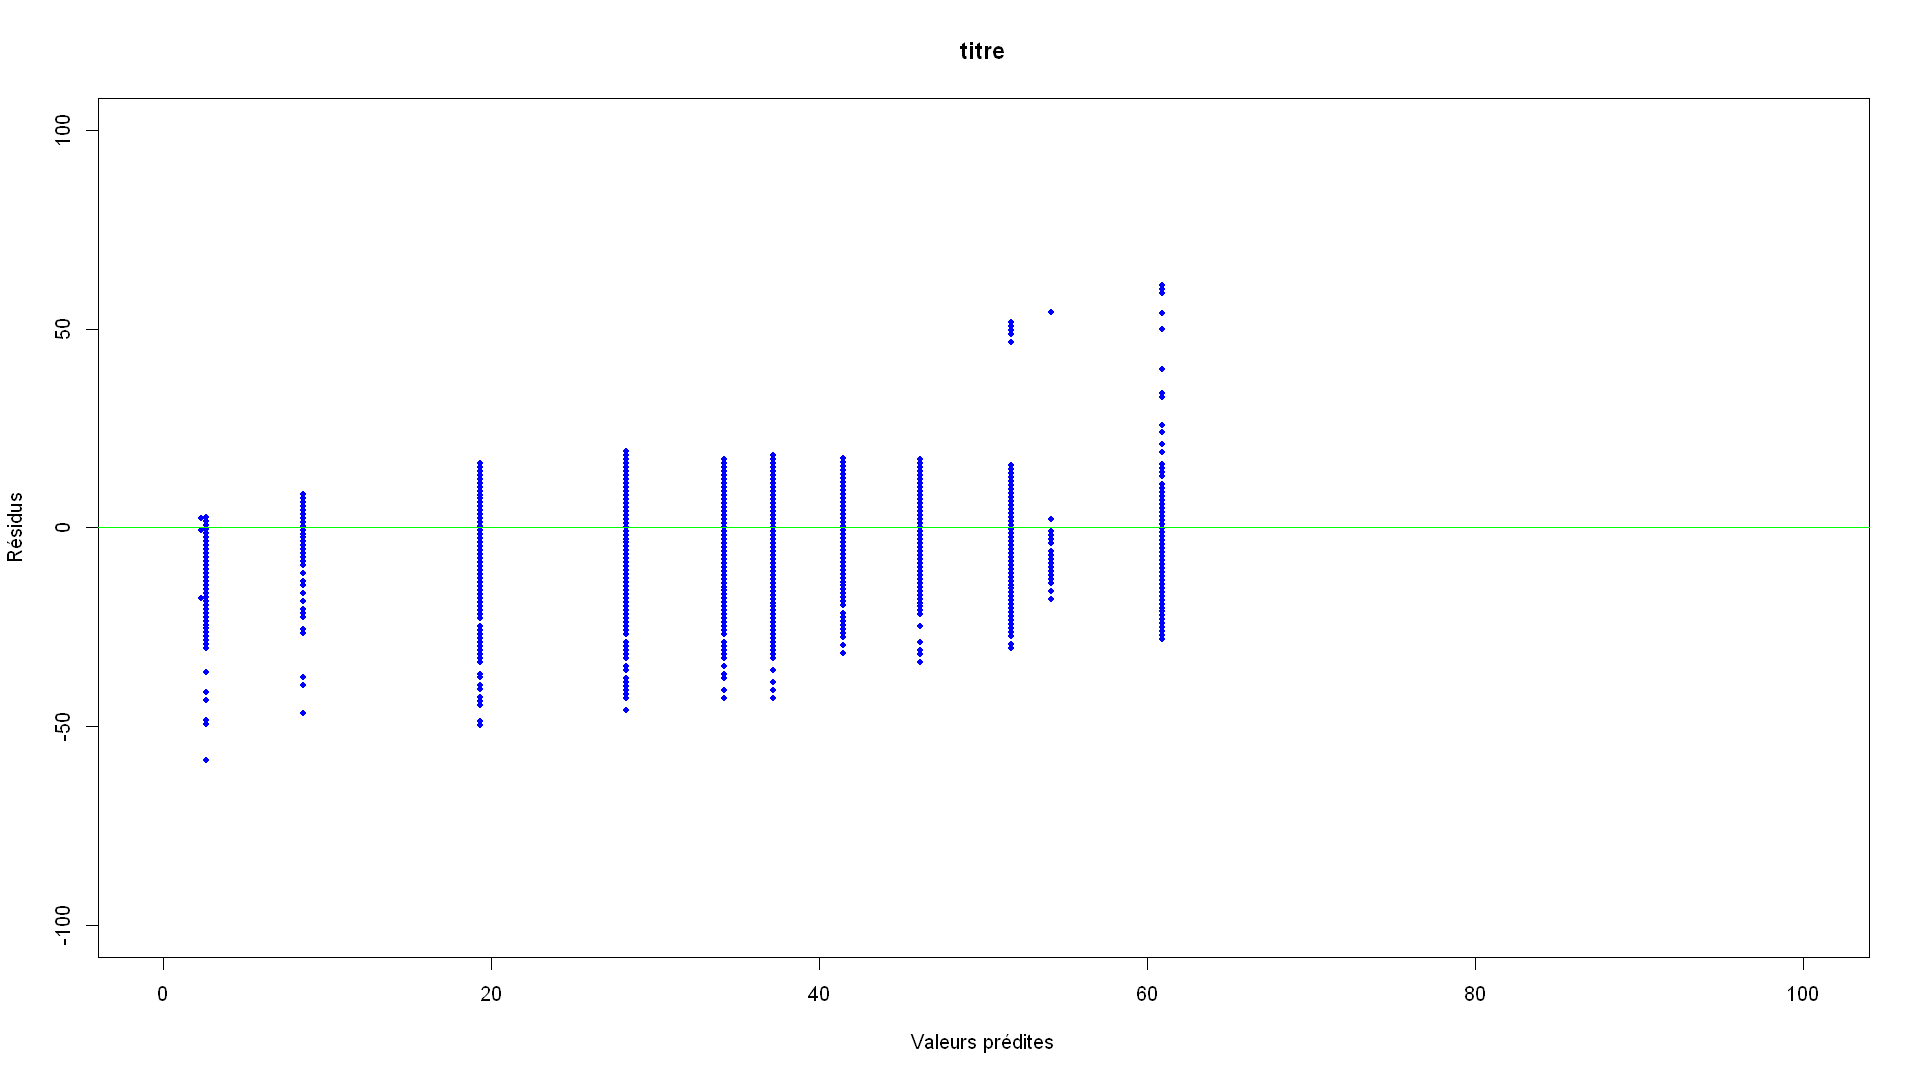

In [156]:
fit.tree <- predict(tree.reg, X.train[, -11])
res.tree <- fit.tree - X.train$popularity
plot.res(fit.tree, res.tree)

[1] "Mean Squared Error: 103.4396"
[1] "R2 Score: 0.7884"
[1] "Explained Variance Score: 0.7884"
[1] "Prediction error: 28.3 %"
[1] "Accuracy: 71.7 %"
       true predicted
126891    0  2.613897
147565   26 37.140518
82623    32 34.167179


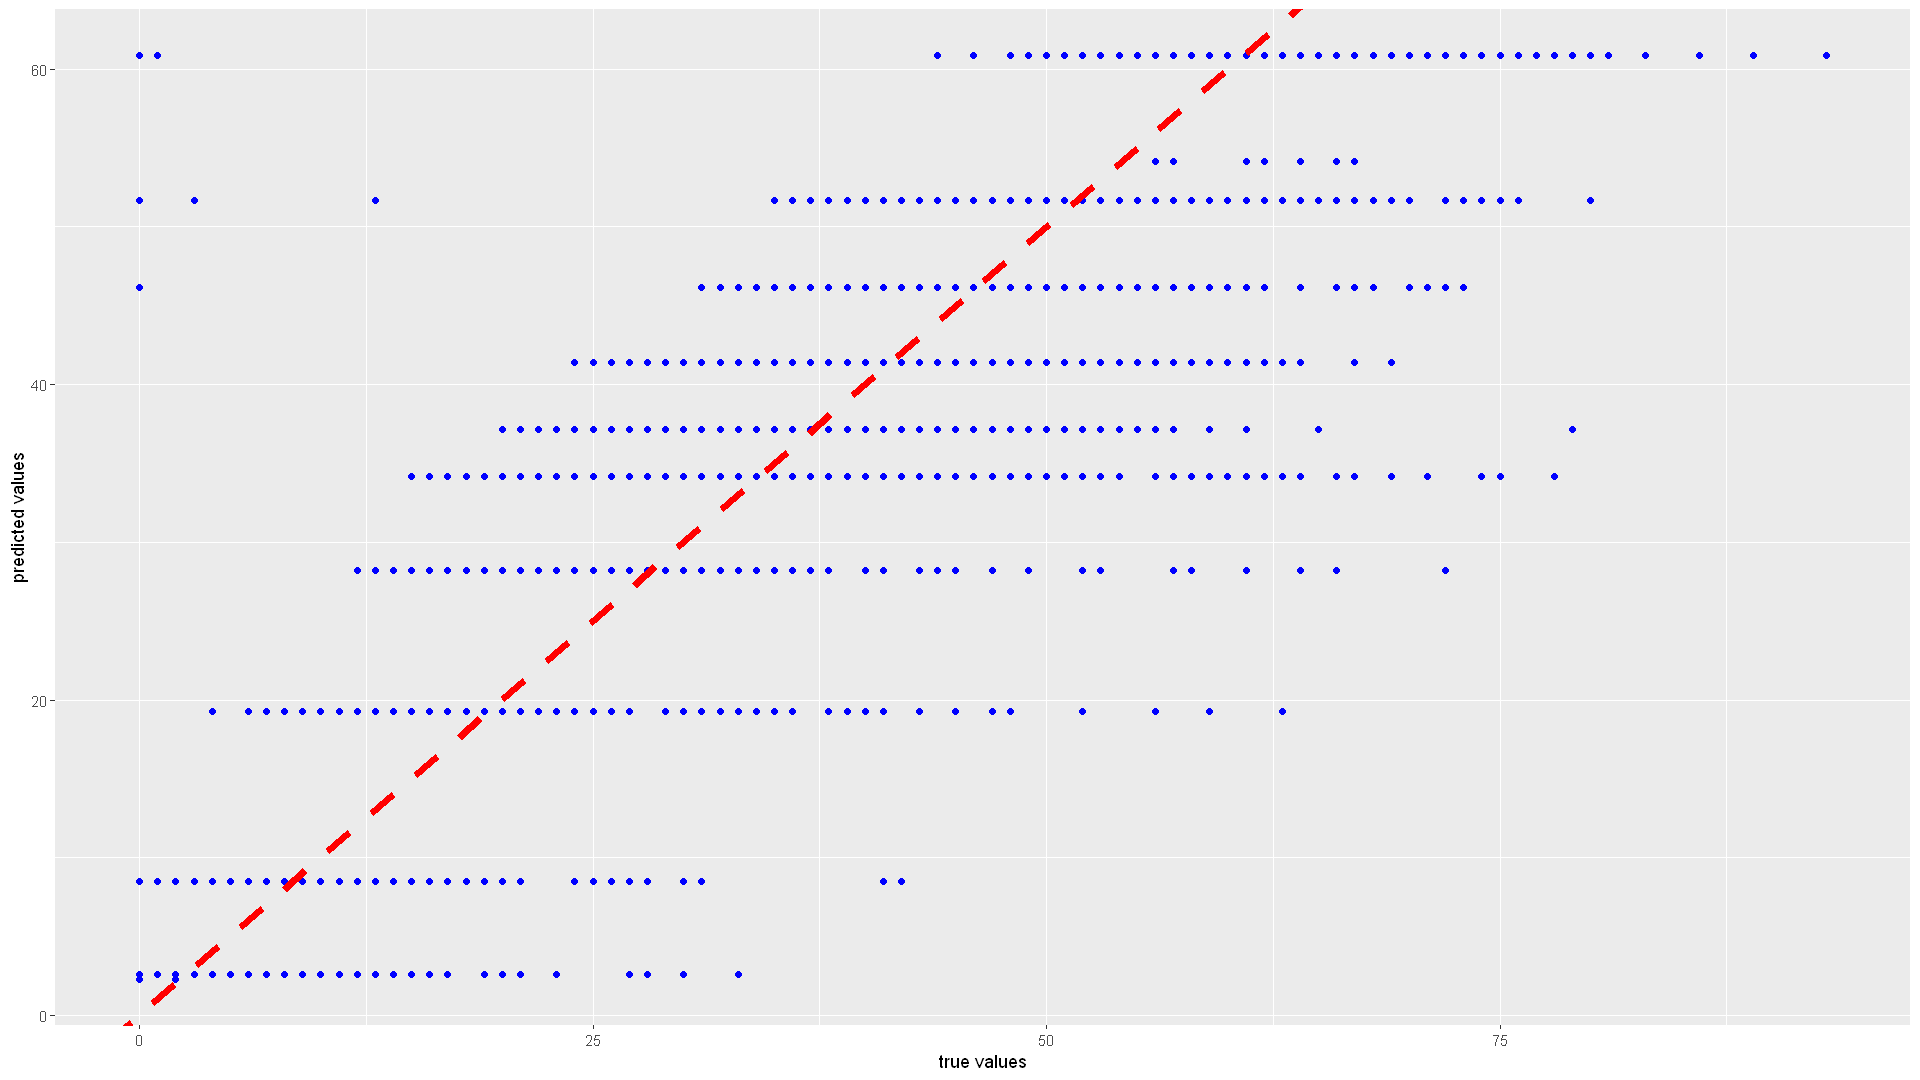

In [157]:
pred.reg.tree <- predict(tree.reg, newdata = X.test[, -11])
plot.regression.results(y.test.reg, y.test.class, pred.reg.tree)

In [158]:
mse.scores[6] <- round(sum((pred.reg.tree - y.test.reg)^2)/ntest, 4)
r2.scores[6] <- round(cor(y.test.reg, pred.reg.tree)^2, 4)
evs.scores[6] <- round(1 - var(y.test.reg - pred.reg.tree)/var(y.test.reg), 4)
thresholding.scores[6] <- threshold.score(pred.reg.tree, y.test.class)

### SVR

#### Linear Kernel

In [159]:
svm.reg.lin <- best.svm(popularity ~ ., data = X.train.scaled, cost = c(0.1, 1),
                        kernel = "linear", cross = 5)

svm.reg.lin

Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling arra


Call:
best.svm(x = popularity ~ ., data = X.train.scaled, cost = c(0.1, 
    1), kernel = "linear", cross = 5)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  linear 
       cost:  0.1 
      gamma:  0.07142857 
    epsilon:  0.1 


Number of Support Vectors:  6204


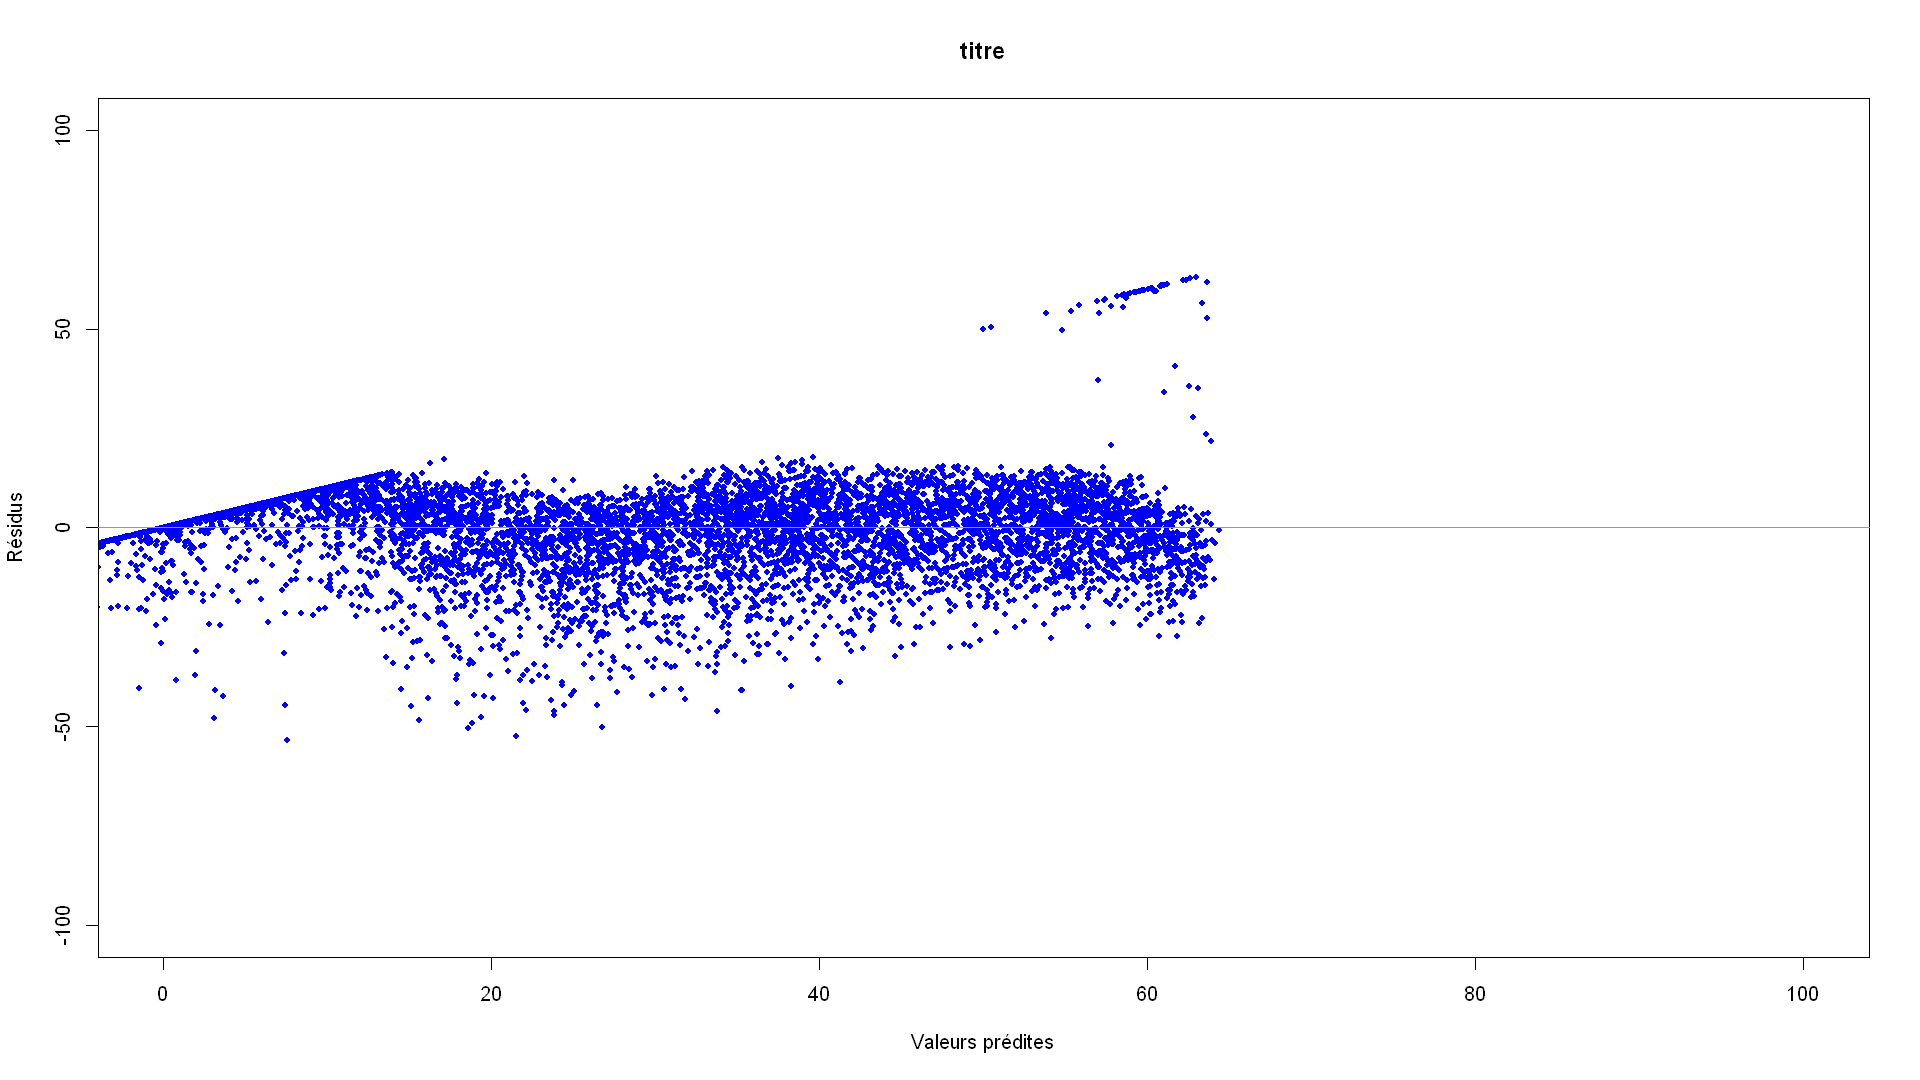

In [161]:
fit.svmr <- svm.reg.lin$fitted
res.svmr <- fit.svmr - X.train.scaled$popularity
plot.res(fit.svmr, res.svmr)

In [162]:
svr.lin <- svm(popularity ~ ., data = X.train.scaled,
               cost = svm.reg.lin$cost, kernel = "linear")

[1] "Mean Squared Error: 121.2448"
[1] "R2 Score: 0.7541"
[1] "Explained Variance Score: 0.7536"
[1] "Prediction error: 35.4 %"
[1] "Accuracy: 64.6 %"
       true predicted
126891    0  7.551602
147565   26 31.946427
82623    32 26.456265


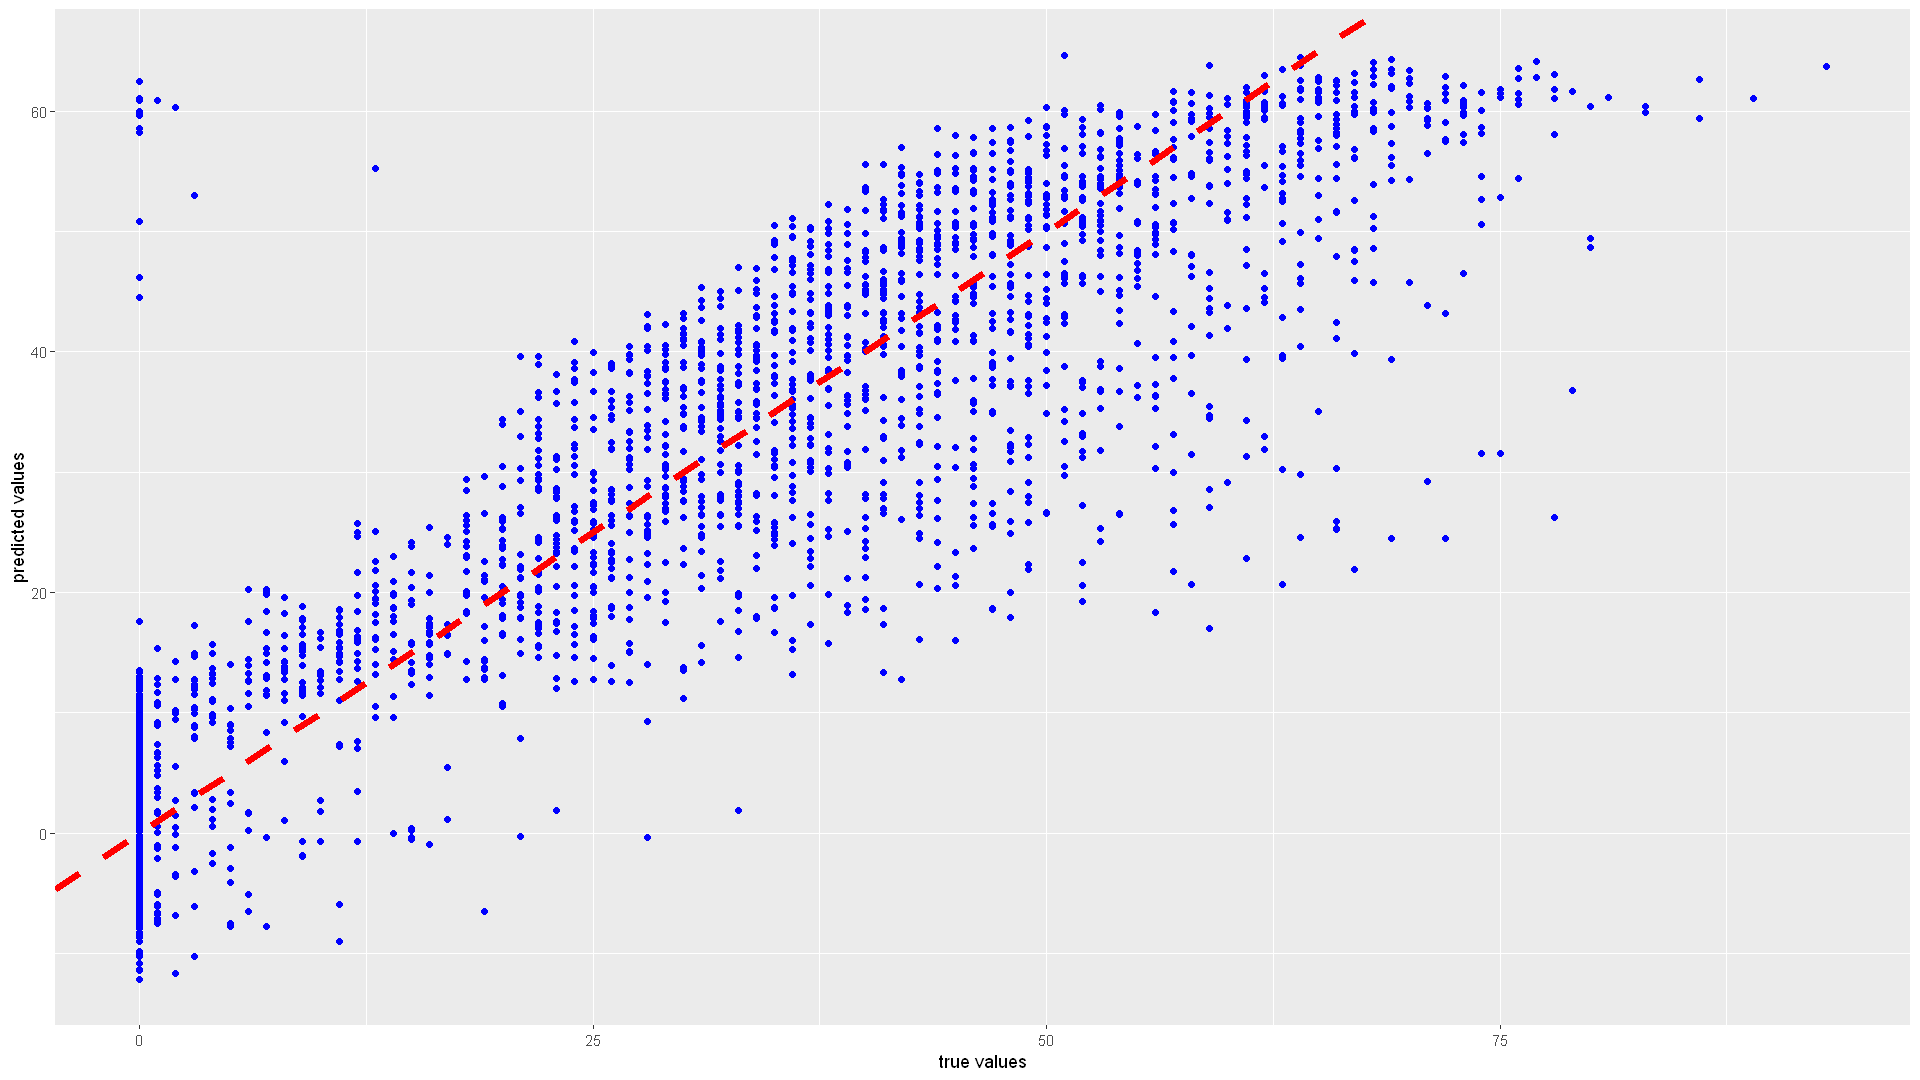

In [163]:
pred.svr.lin <- predict(svr.lin, newdata = X.test.scaled[, -11])
plot.regression.results(y.test.reg, y.test.class, pred.svr.lin)

In [164]:
mse.scores[7] <- round(sum((pred.svr.lin - y.test.reg)^2)/ntest, 4)
r2.scores[7] <- round(cor(y.test.reg, pred.svr.lin)^2, 4)
evs.scores[7] <- round(1 - var(y.test.reg - pred.svr.lin)/var(y.test.reg), 4)
thresholding.scores[7] <- threshold.score(pred.svr.lin, y.test.class)

#### Polynomial Kernel

In [165]:
svm.reg.poly <- best.svm(popularity ~ ., data = X.train.scaled, cost = c(0.1, 1, 10),
                         kernel = "poly", cross = 5)

svm.reg.poly

Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling arra


Call:
best.svm(x = popularity ~ ., data = X.train.scaled, cost = c(0.1, 
    1, 10), kernel = "poly", cross = 5)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  polynomial 
       cost:  10 
     degree:  3 
      gamma:  0.07142857 
     coef.0:  0 
    epsilon:  0.1 


Number of Support Vectors:  5952


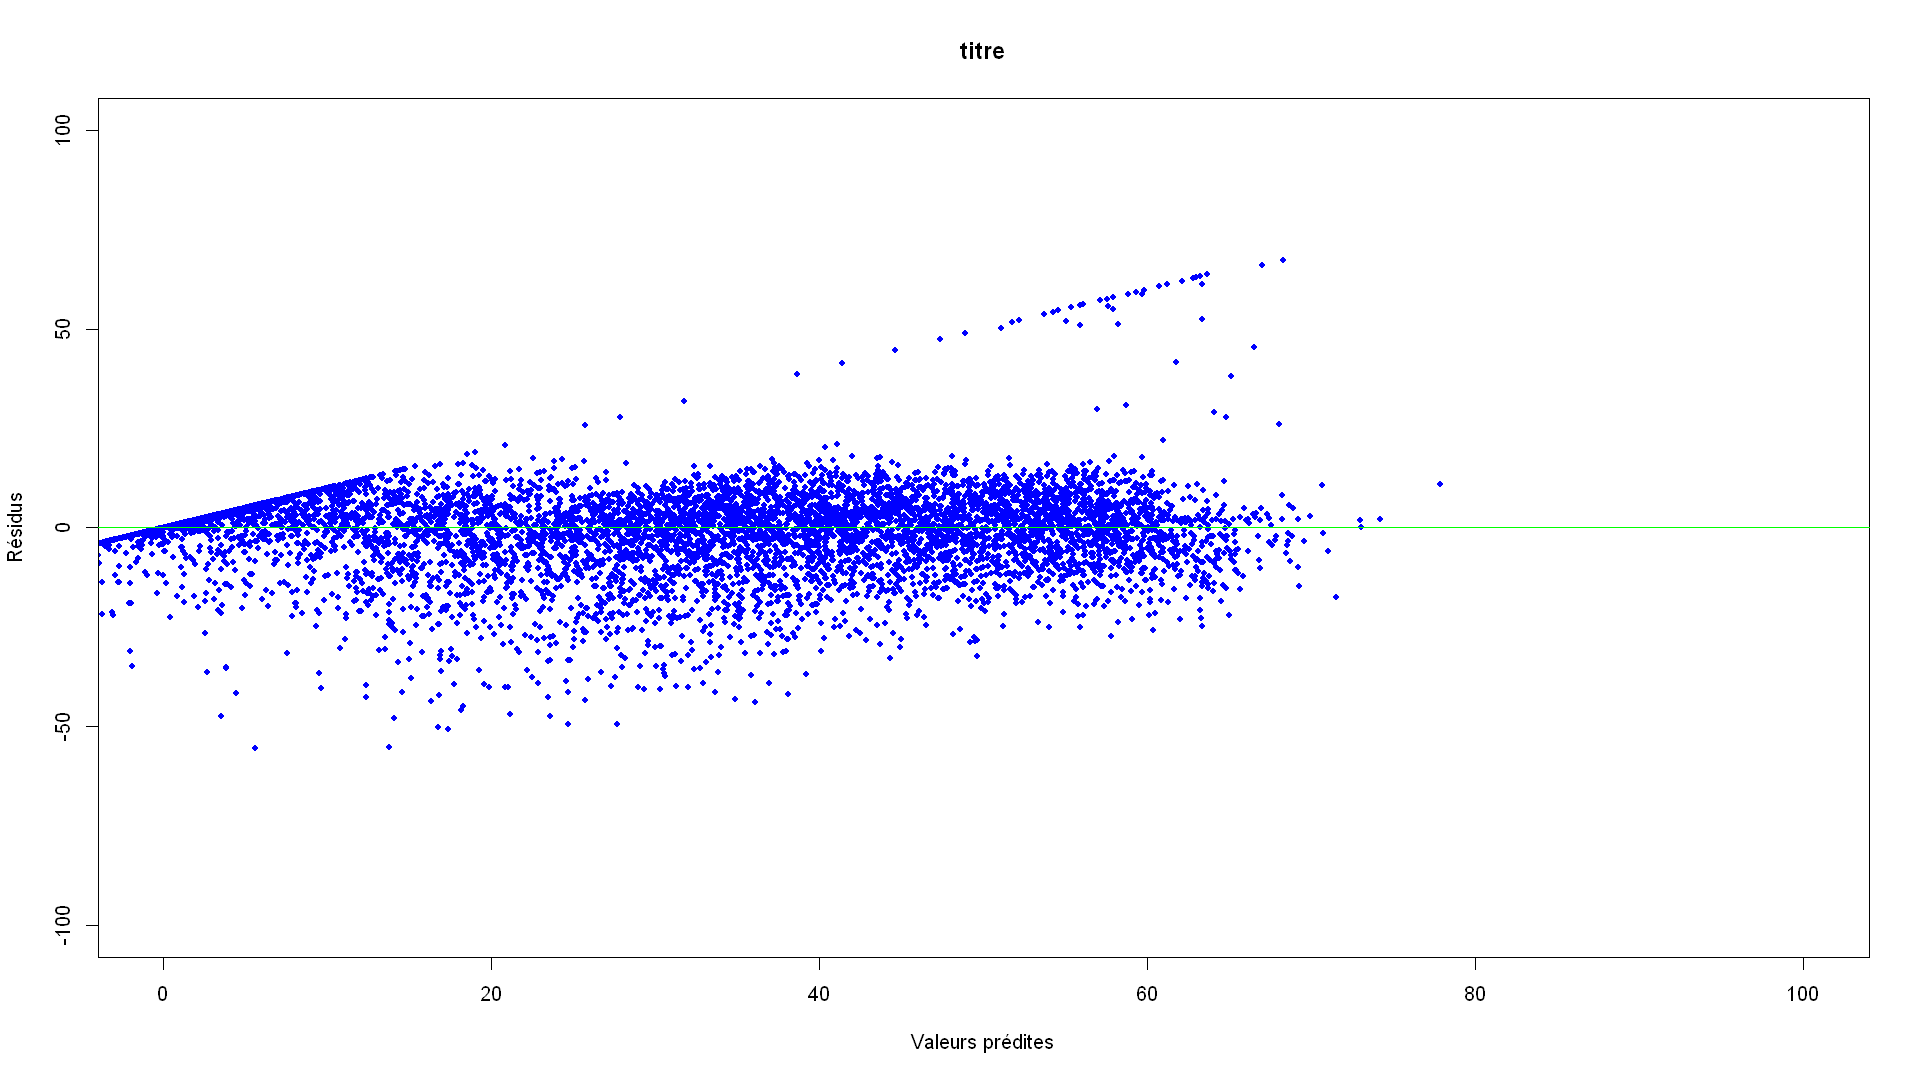

In [167]:
fit.svmr <- svm.reg.poly$fitted
res.svmr <- fit.svmr - X.train.scaled$popularity
plot.res(fit.svmr, res.svmr)

In [168]:
svr.poly <- svm(popularity ~ ., data = X.train.scaled,
                cost = svm.reg.poly$cost, kernel = "poly")

[1] "Mean Squared Error: 117.8398"
[1] "R2 Score: 0.7617"
[1] "Explained Variance Score: 0.7603"
[1] "Prediction error: 36.4 %"
[1] "Accuracy: 63.6 %"
       true predicted
126891    0  8.892326
147565   26 31.894980
82623    32 28.950529


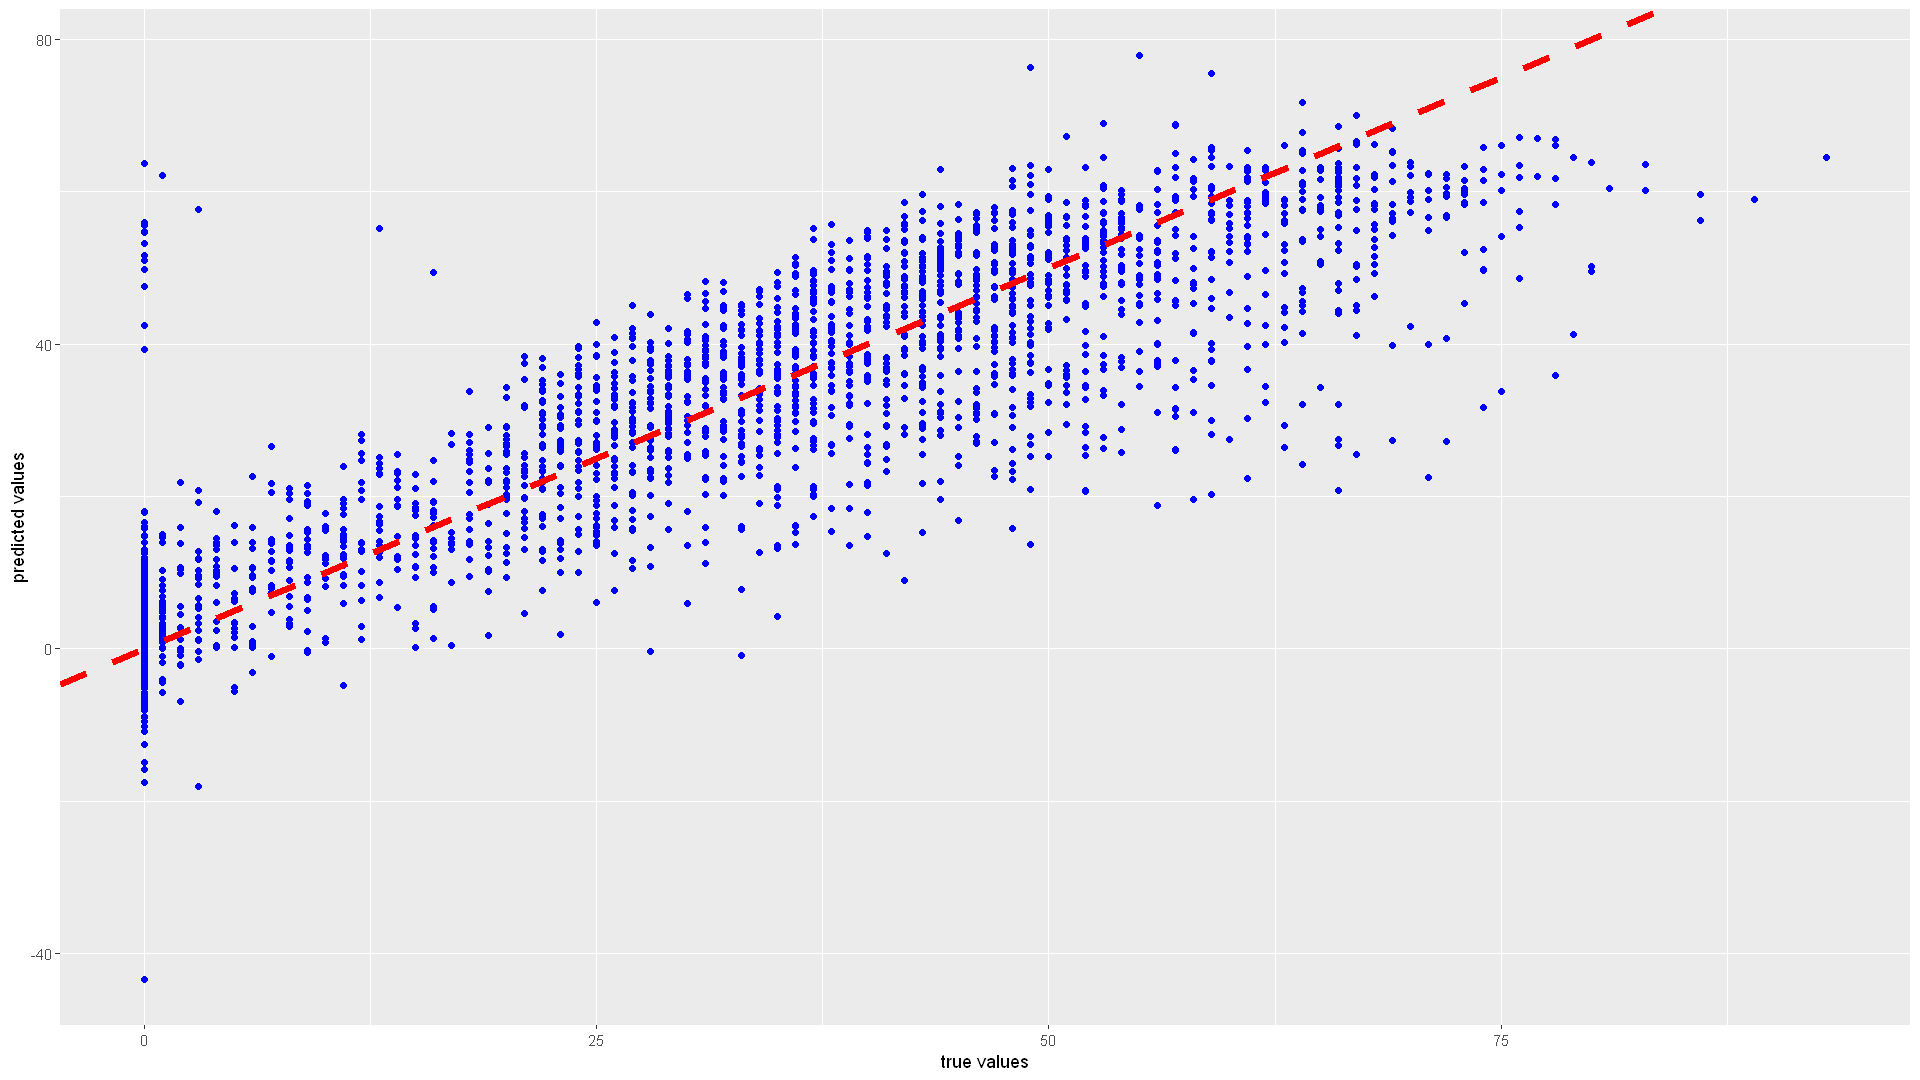

In [169]:
pred.svr.poly <- predict(svr.poly, newdata = X.test.scaled[, -11])
plot.regression.results(y.test.reg, y.test.class, pred.svr.poly)

In [170]:
mse.scores[8] <- round(sum((pred.svr.poly - y.test.reg)^2)/ntest, 4)
r2.scores[8] <- round(cor(y.test.reg, pred.svr.poly)^2, 4)
evs.scores[8] <- round(1 - var(y.test.reg - pred.svr.poly)/var(y.test.reg), 4)
thresholding.scores[8] <- threshold.score(pred.svr.poly, y.test.class)

#### Radial Kernel

In [171]:
# set.seed(2021)
svm.reg.tune <- best.svm(popularity ~ ., data = X.train.scaled, cost = c(0.1, 1),
                         gamma = seq(0.02, 0.1, 0.02), cross = 5)

svm.reg.tune
# plot(svm.reg.tune)

Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling arra

Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling array of length 1 in vector-array arithmetic is deprecated.
  Use c() or as.vector() instead.
"
Warning message in cret$cresults * scale.factor:
"Recycling arra


Call:
best.svm(x = popularity ~ ., data = X.train.scaled, cost = c(0.1, 
    1), gamma = seq(0.02, 0.1, 0.02), cross = 5)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.06 
    epsilon:  0.1 


Number of Support Vectors:  5851


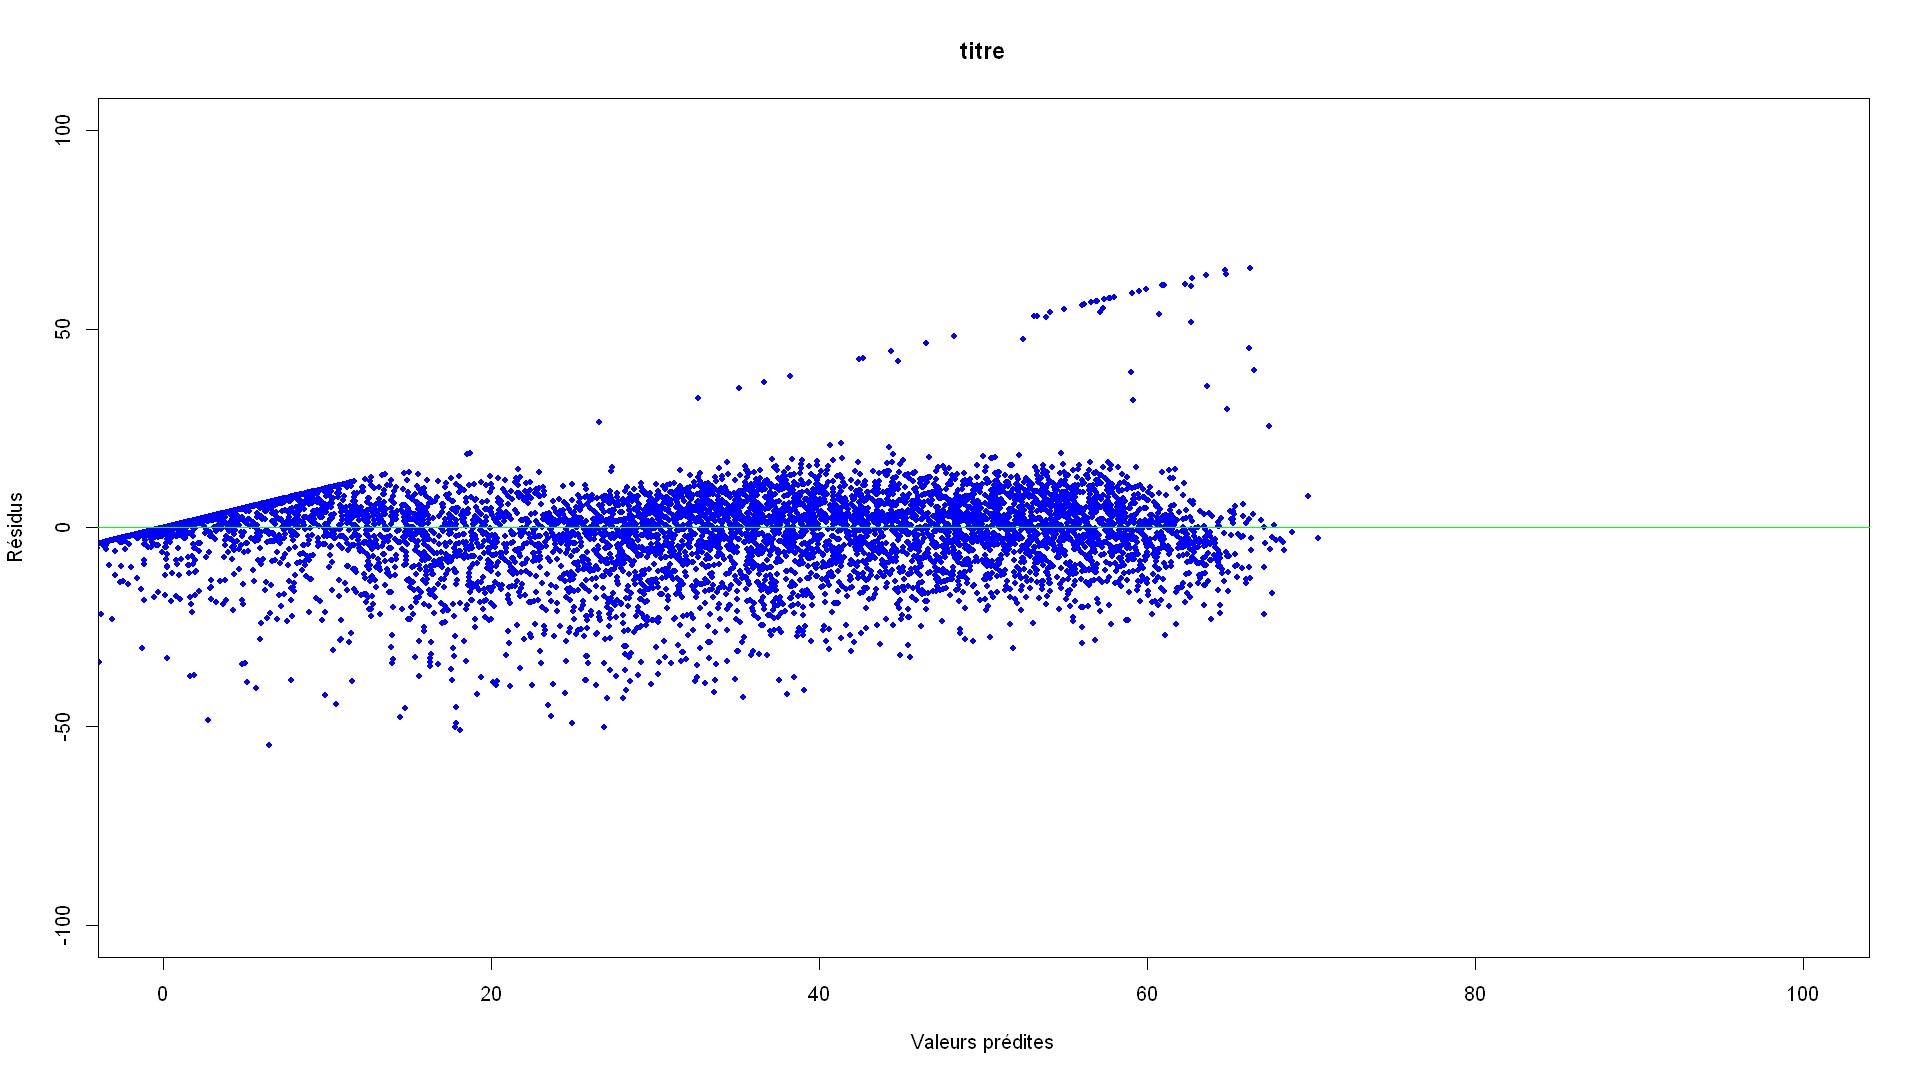

In [173]:
fit.svmr <- svm.reg.tune$fitted
res.svmr <- fit.svmr - X.train.scaled$popularity
plot.res(fit.svmr, res.svmr)

In [174]:
svr.rad <- svm(popularity ~ ., data = X.train.scaled, kernel ="radial",
               cost = svm.reg.tune$cost, gamma = svm.reg.tune$gamma)

[1] "Mean Squared Error: 113.2177"
[1] "R2 Score: 0.7705"
[1] "Explained Variance Score: 0.77"
[1] "Prediction error: 35.5 %"
[1] "Accuracy: 64.5 %"
       true predicted
126891    0  11.33498
147565   26  33.38240
82623    32  29.43626


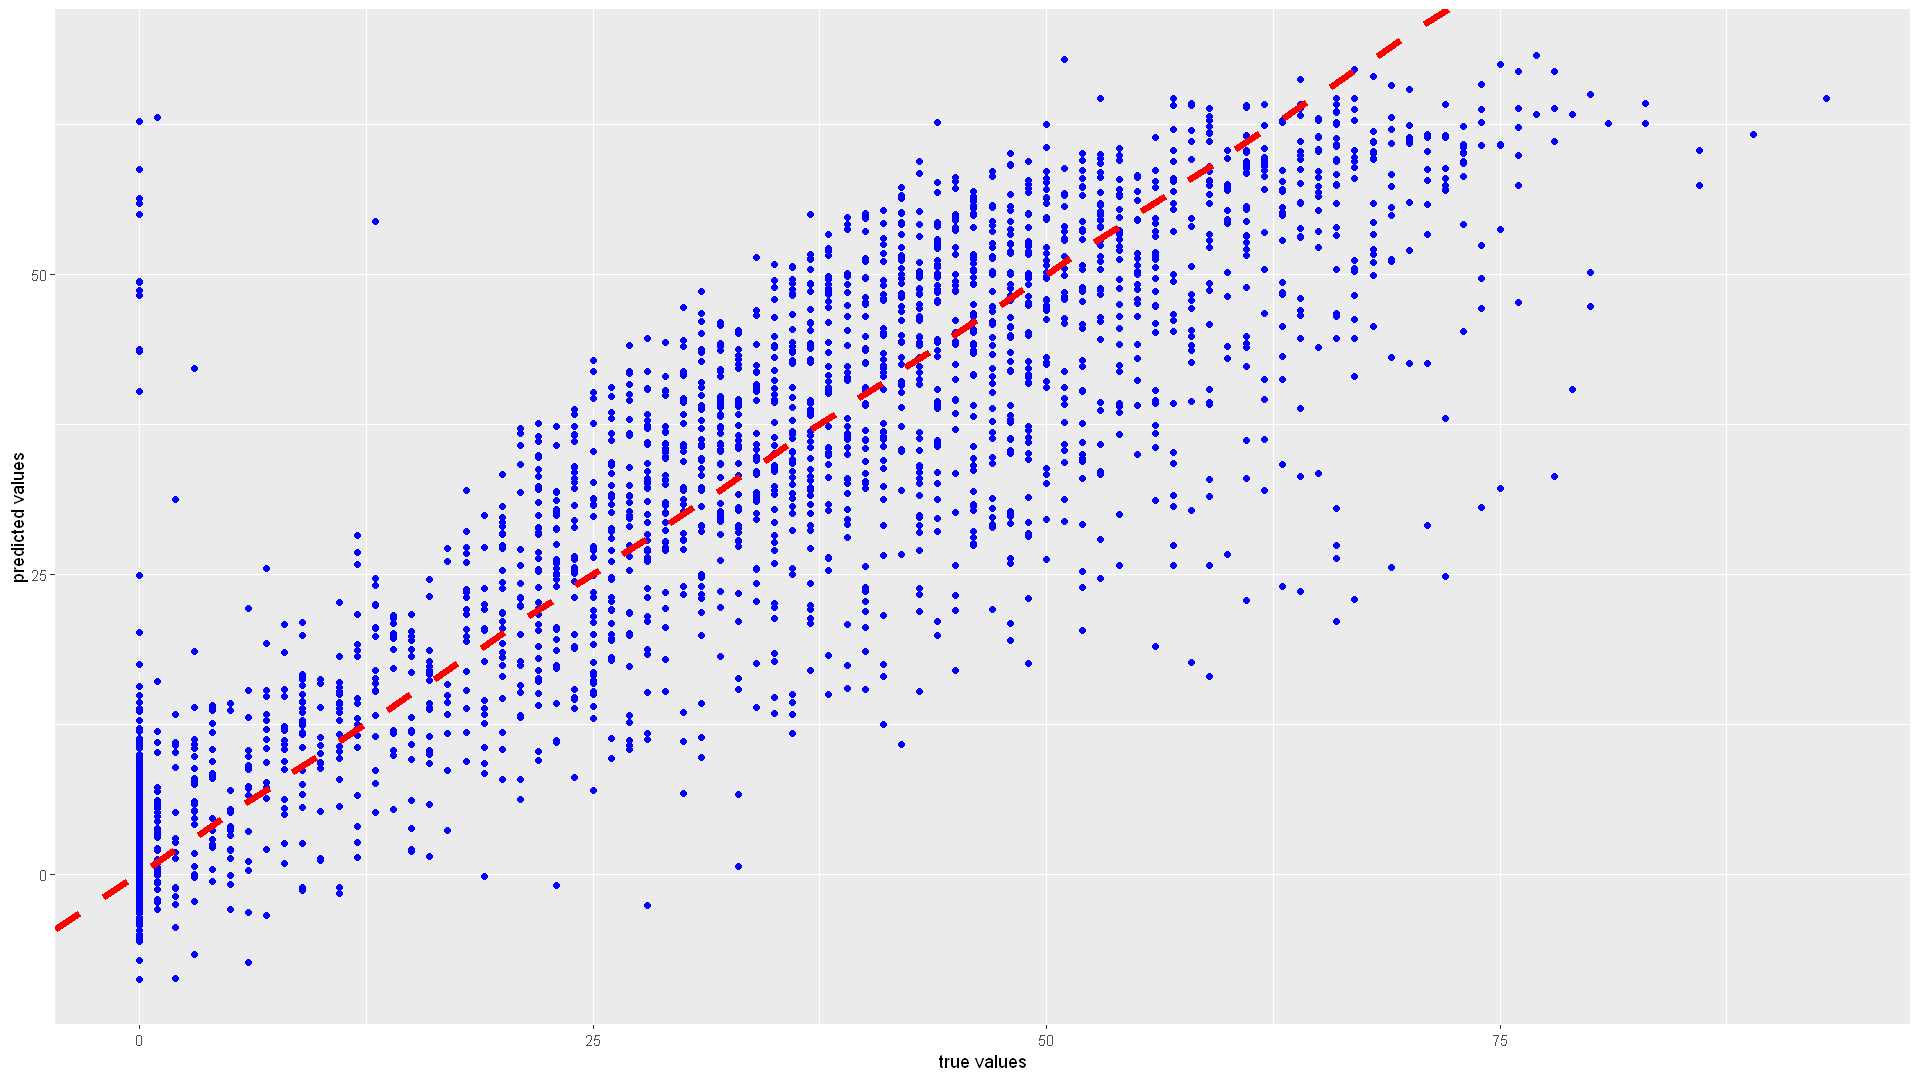

In [175]:
pred.svr.rad <- predict(svr.rad, newdata = X.test.scaled[, -11])
plot.regression.results(y.test.reg, y.test.class, pred.svr.rad)

In [176]:
mse.scores[9] <- round(sum((pred.svr.rad - y.test.reg)^2)/ntest, 4)
r2.scores[9] <- round(cor(y.test.reg, pred.svr.rad)^2, 4)
evs.scores[9] <- round(1 - var(y.test.reg - pred.svr.rad)/var(y.test.reg), 4)
thresholding.scores[9] <- threshold.score(pred.svr.rad, y.test.class)

### Réseaux de neuronnes

In [177]:
nnet.tuned <- best.nnet(popularity ~ ., data = X.train.scaled, size = 4:5,
                        decay = 1:10, maxit = 200, linout = TRUE)
nnet.tuned

a 13-4-1 network with 61 weights
inputs: valence year acousticness duration energy instrumentalness key liveness loudness mode1 speechiness tempo dance_norm 
output(s): popularity 
options were - linear output units  decay=10

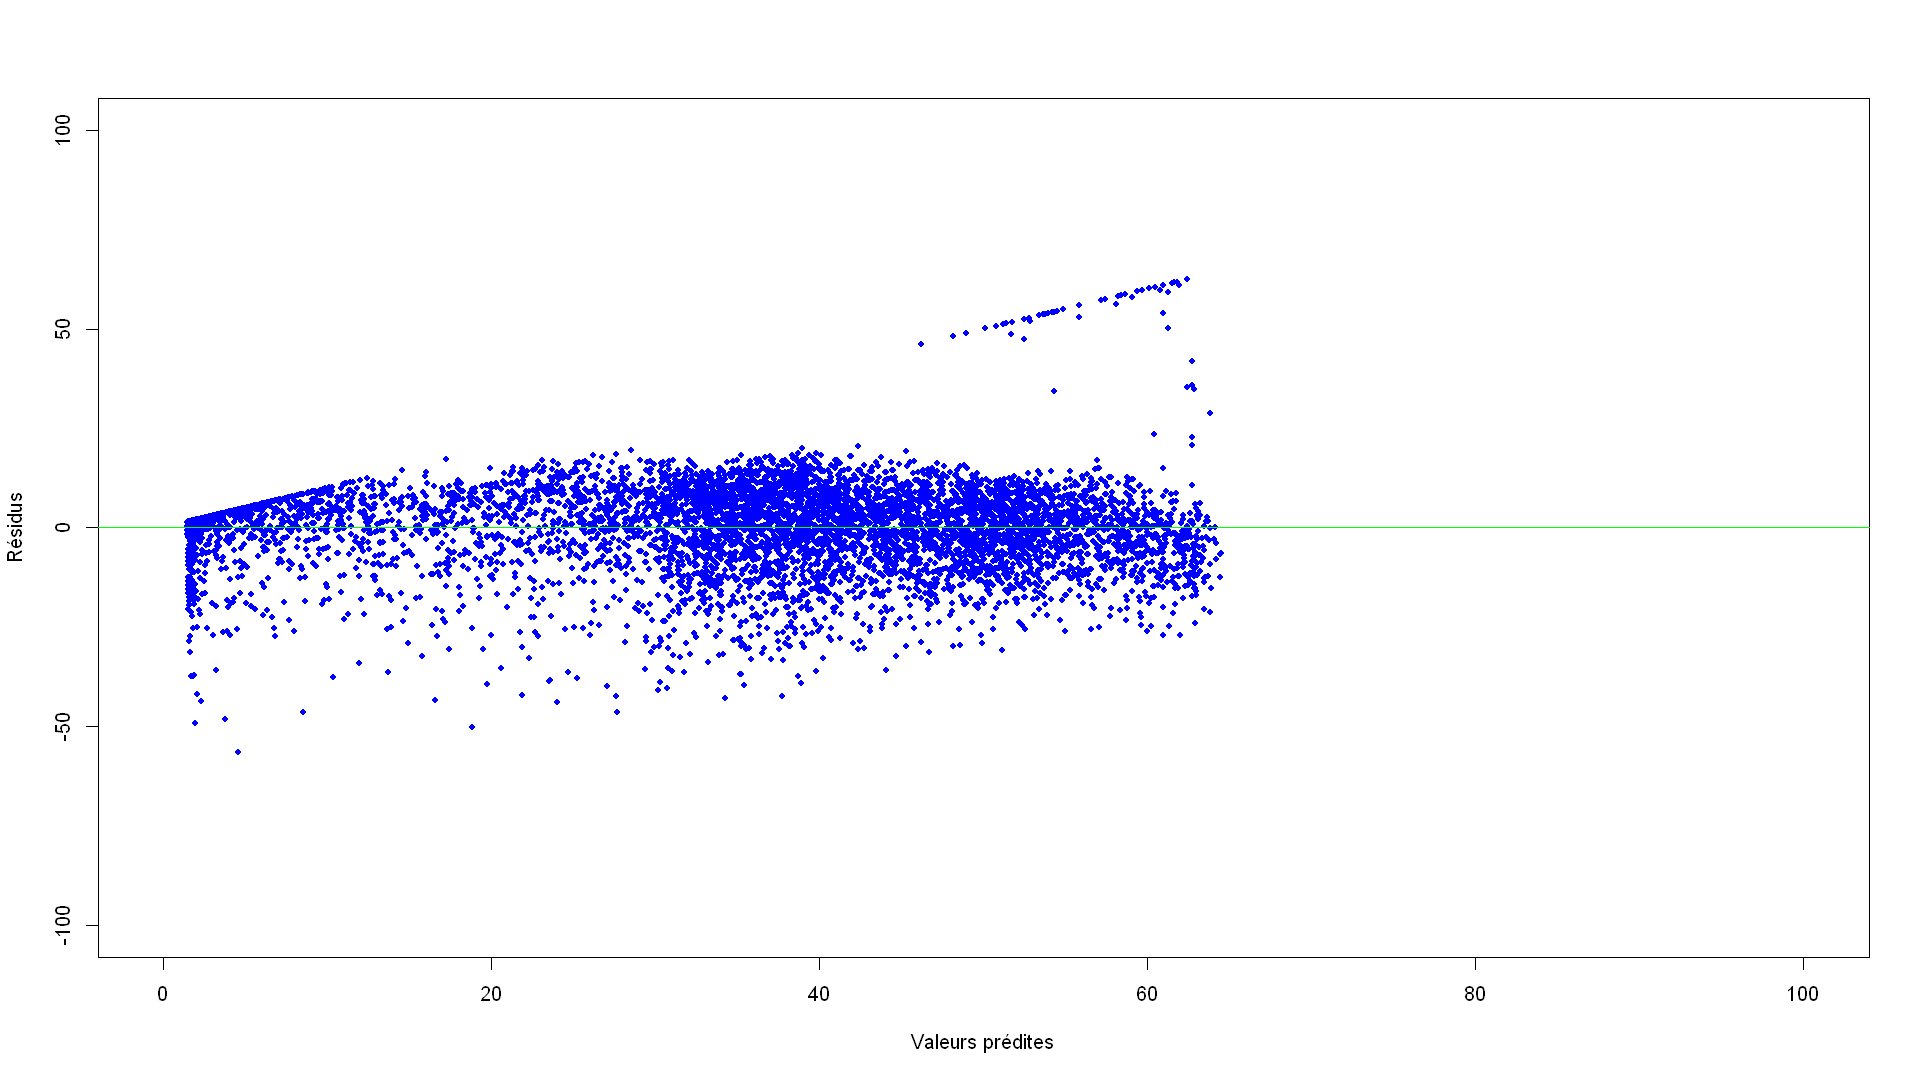

In [178]:
# calcul et graphe des résidus
fit.nnetr <- nnet.tuned$fitted
res.nnetr <- fit.nnetr - X.train.scaled$popularity
plot.res(fit.nnetr, res.nnetr, titre = "")

[1] "Mean Squared Error: 104.7414"
[1] "R2 Score: 0.786"
[1] "Explained Variance Score: 0.7858"
[1] "Prediction error: 29.2 %"
[1] "Accuracy: 70.8 %"
       true predicted
126891    0  3.934234
147565   26 36.934382
82623    32 33.653921


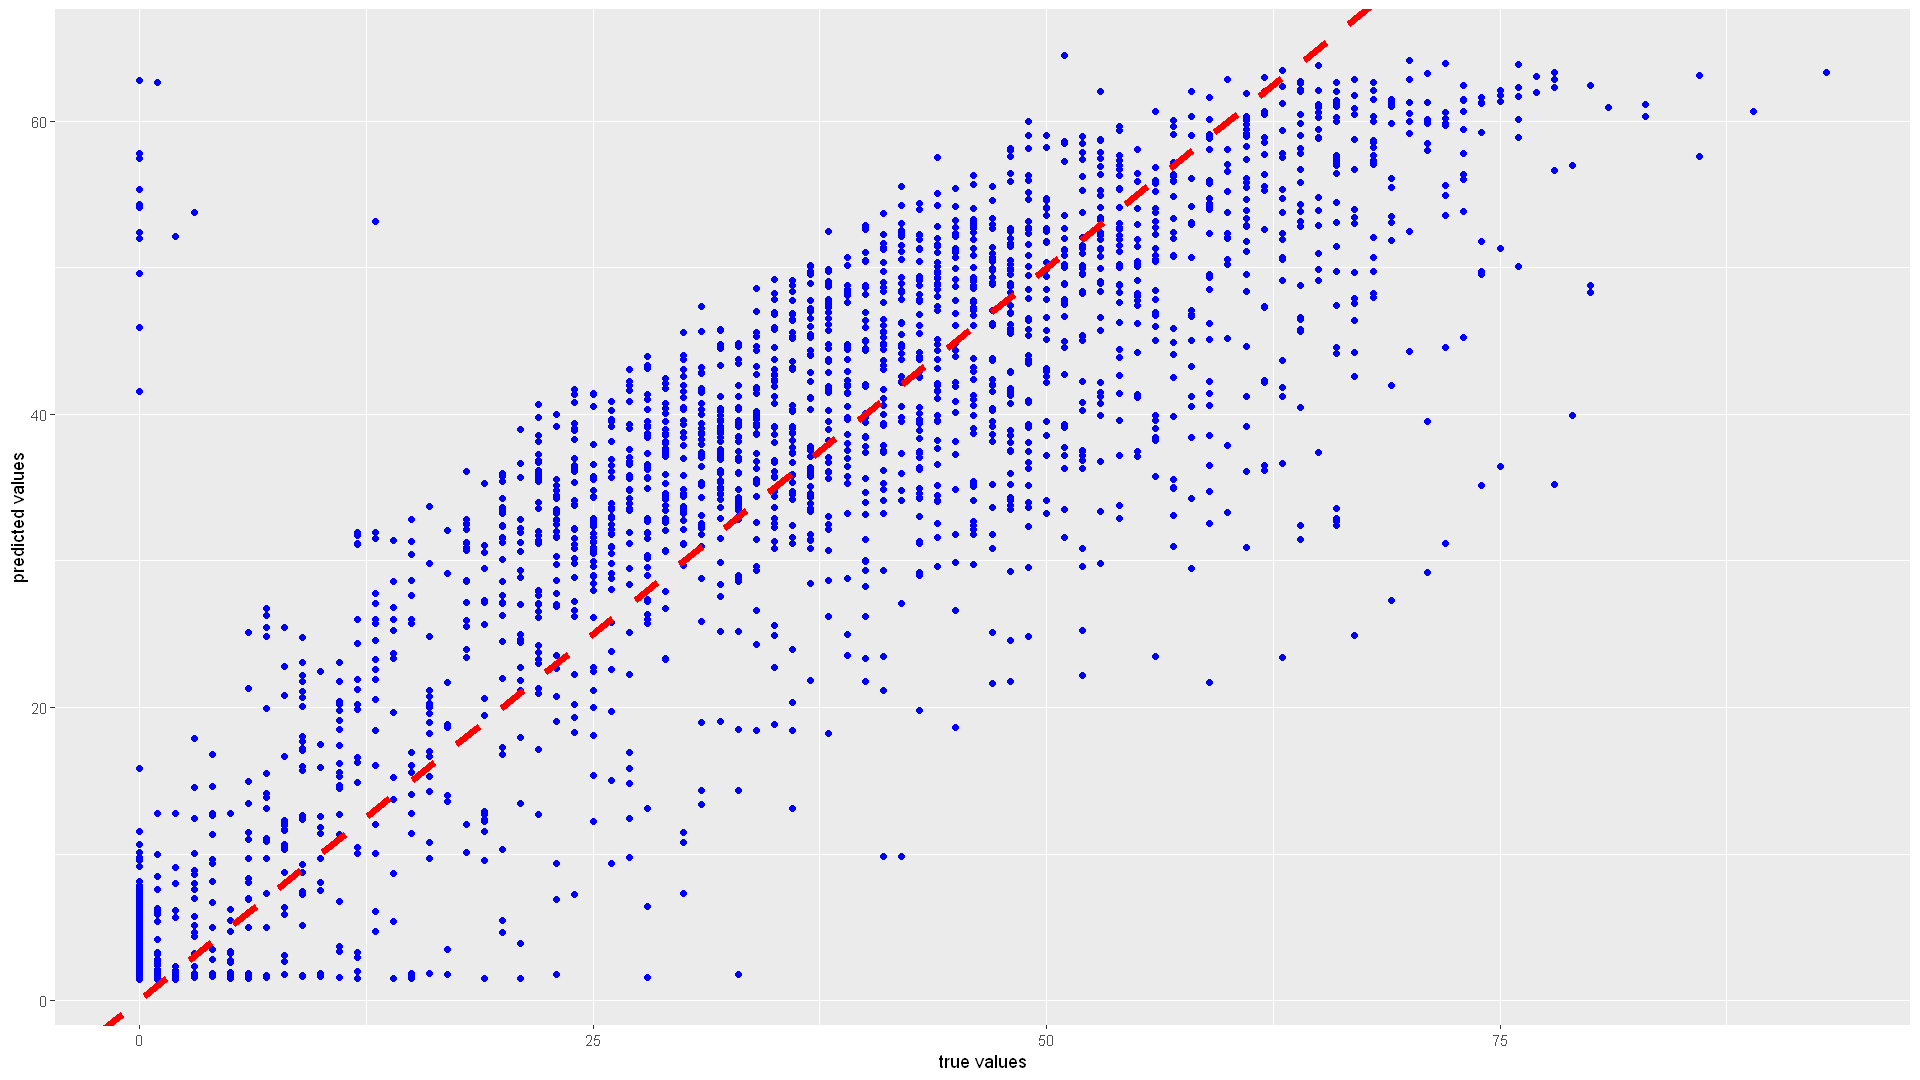

In [179]:
pred.nnetr <- predict(nnet.tuned, newdata = X.test.scaled[, -11])
plot.regression.results(y.test.reg, y.test.class, pred.nnetr)

In [180]:
mse.scores[10] <- round(sum((pred.nnetr - y.test.reg)^2)/ntest, 4)
r2.scores[10] <- round(cor(y.test.reg, pred.nnetr)^2, 4)
evs.scores[10] <- round(1 - var(y.test.reg - pred.nnetr)/var(y.test.reg), 4)
thresholding.scores[10] <- threshold.score(pred.nnetr, y.test.class)

## Résumé des résultats en régression

In [181]:
methods.reg <- c("Linear Regression", "Lasso", "Ridge", "Elastic Net",
                 "Random Forest", "Decision Trees", "Linear SVR",
                 "Polynomial SVR", "Radial SVR", "Neural Network")

reg.comparison <- data.frame(
    Model = methods.reg,
    MSE = mse.scores,
    R2 = r2.scores,
    EVS = evs.scores,
    Threshold = thresholding.scores
)

reg.comparison

Model,MSE,R2,EVS,Threshold
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Linear Regression,119.9299,0.7545,0.7545,0.6472
Lasso,119.7818,0.7549,0.7548,0.6504
Ridge,122.4089,0.7529,0.7494,0.6512
Elastic Net,119.7862,0.7549,0.7548,0.6492
Random Forest,100.0674,0.7962,0.7961,0.7112
Decision Trees,103.4396,0.7884,0.7884,0.7168
Linear SVR,121.2448,0.7541,0.7536,0.6464
Polynomial SVR,117.8398,0.7617,0.7603,0.6356
Radial SVR,113.2177,0.7705,0.7700,0.6448


In [182]:
reg.comparison[order(reg.comparison$MSE, decreasing = FALSE), ]

,Model,MSE,R2,EVS,Threshold
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
5,Random Forest,100.0674,0.7962,0.7961,0.7112
6,Decision Trees,103.4396,0.7884,0.7884,0.7168
10,Neural Network,104.7414,0.7860,0.7858,0.7080
9,Radial SVR,113.2177,0.7705,0.7700,0.6448
8,Polynomial SVR,117.8398,0.7617,0.7603,0.6356
2,Lasso,119.7818,0.7549,0.7548,0.6504
4,Elastic Net,119.7862,0.7549,0.7548,0.6492
1,Linear Regression,119.9299,0.7545,0.7545,0.6472
7,Linear SVR,121.2448,0.7541,0.7536,0.6464


# Comparaison entre classification et régression

In [183]:
classifs <- class.comparison[, "Accuracy"]
regs <- reg.comparison[, "Threshold"]

compare.table = data.frame(
    Model = methods.class,
    Classification = classifs,
    Thresholding = regs
)

compare.table

Model,Classification,Thresholding
<chr>,<dbl>,<dbl>
Logistic Regression,0.7020,0.6472
Lasso,0.7004,0.6504
Ridge,0.6600,0.6512
Elastic Net,0.6996,0.6492
Random Forest,0.7356,0.7112
Decision Trees,0.7352,0.7168
Linear SVC,0.6956,0.6464
Polynomial SVC,0.6956,0.6356
Radial SVC,0.7060,0.6448
